In [1]:
import os 
import shutil
from cobaya.run import run
import time
import numpy as np
import matplotlib.pylab as plt
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss
import pandas as pd
import gc

import numpyro
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import pickle_save, dill_save, dill_load
import random 

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"
color2 = "tomato"
color3 = "#222E50"
alpha = 0.9
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
# Cobaya 
NSAMPLES_CB = 100000
OUTPUT_FOLDER = 'CobayaROS/'

# EMCEE 
NSAMPLES = 2000

# NUTS 
TREE_DEPTH = 6
EPS = 0.01
NSAMPLES_NUTS = 5000
WARMUP = 500
THIN = None 

# General setup 
fiducial = np.ones(2)
normal_prior = ss.norm(0, 1)

In [3]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 9 * (x_i_plus_one - x_i**2) ** 2
    term_2 = (x_i - 1) ** 2
    return sum(term_1 + term_2)


def loglikelihood(xvalues):
    return -rosenbrock(xvalues)


@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)


@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)

# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [4]:
%%timeit
jit_loglike(fiducial)

34.5 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
%%timeit
jit_loglike(fiducial)

35.4 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%%timeit
jit_grad_loglike(fiducial)

34.7 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
jit_grad_loglike(fiducial)

35.4 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
dimensions = np.arange(1, 6, 1, dtype=int) * 20
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []

    for d in dimensions:
        testpoint = jnp.ones(d) + 1e-2

        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_like.append(time_taken)

        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_grad_like.append(time_taken)

    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [9]:
time_ratio = np.mean(tau_gradlike / tau_like, axis=0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis=0)

In [10]:
# dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
# dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

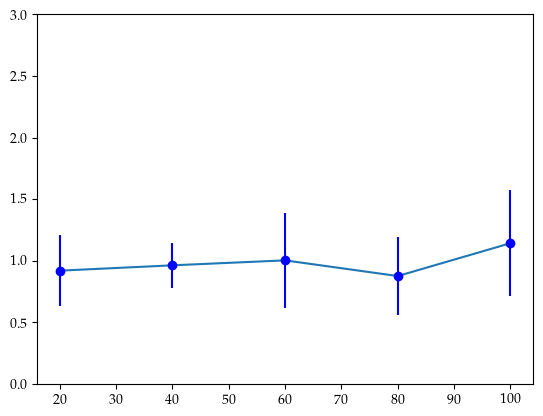

In [11]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr=time_ratio_error, fmt="bo")
plt.ylim(0, 3)
plt.show()

## EMCEE

In [4]:
def logposterior(xvalues):
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1e32

def single_emcee_run(fiducial, ndim):
    pos = fiducial + 1e-2 * np.random.randn(2 * ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, NSAMPLES, progress=True)
    return sampler


def emcee_sampler(fiducial):
    ndim = len(fiducial)
    record_samples = []
    nsteps = 0
    accep_prob = []
    for chain in range(2):
        sampler = single_emcee_run(fiducial, ndim)
        # emcee_samples = sampler.get_chain(discard=DISCARD, flat=True)
        emcee_samples = sampler.flatchain
        nsteps += emcee_samples.shape[0]
        accep_prob.append(np.mean(sampler.acceptance_fraction))
        record_samples.append(emcee_samples)
    return record_samples, nsteps, accep_prob

# Cobaya

In [5]:
class cobaya_rose:
    def __init__(self, ndim):
        self.ndim = ndim 
        self.pnames = [f'p{i}' for i in range(self.ndim)]
        
    def ros_like(self, **kwargs):
        params = np.array([kwargs[p] for p in self.pnames])
        logprior = sum([normal_prior.logpdf(params[i]) for i in range(len(params))])
        logp =  -rosenbrock(params) 
        return logp + logprior
    
    def run_sampler(self, nsamples, iteration, proposal=1E-2, criterion = 1E-2):
        info = {"likelihood": {"rosenbrock_like": {
                "external": self.ros_like,
                "input_params": self.pnames}}}
        
        position = {
                "prior": {"min": -5.0, "max": 5.0},
                "ref": {"dist": "norm", "loc": 0.0, "scale": 1.0},
                "proposal": proposal
                 }

        info["params"] = {f'p{i}': position for i in range(self.ndim)}
        info["sampler"] = {"mcmc": {"max_samples": nsamples, "Rminus1_stop": criterion}}
        
        path =  OUTPUT_FOLDER + f"experiment_{self.ndim}_{iteration}/"
        if os.path.exists(path) and os.path.isdir(path):
            shutil.rmtree(path)
        info["output"] = path + "ros"
        updated_info, sampler = run(info, debug=False)
        return sampler

## NUTS

In [6]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [11]:
def nuts_sampler(initial):
    ndim = len(initial)
    init_strategy = init_to_value(values={f"x{i}": initial[i] for i in range(ndim)})
    nuts_kernel = NUTS(
        model,
        step_size=EPS,
        dense_mass=True,
        max_tree_depth=TREE_DEPTH,
        init_strategy=init_strategy,
    )
    mcmc = MCMC(
        nuts_kernel,
        num_chains=2,
        num_warmup=WARMUP,
        num_samples=NSAMPLES_NUTS,
        chain_method="vectorized",
    )
    random_integer = random.randint(0, 1000)
    mcmc.run(
        jax.random.PRNGKey(random_integer),
        ndim=ndim,
        extra_fields=("potential_energy", "num_steps", "accept_prob"),
    )
    nsteps = mcmc.get_extra_fields(group_by_chain=False)['num_steps'].sum().item()
    accep_prob = mcmc.last_state.accept_prob.tolist()
    
    pickle_save(mcmc, 'rosenbrock', f'nuts_{ndim}')
    return mcmc, nsteps, accep_prob

In [8]:
def process_nuts_chains(mcmc, ndim):
    chains = mcmc.get_samples(group_by_chain=True)
    record = []
    for c in range(2):
        samples = np.vstack([np.asarray(chains[f"x{i}"][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [9]:
def calculate_summary(samples_1, samples_2, nlike, thin=None, ndecimal=3):
    record = []
    for i in range(samples_1.shape[1]):
        if thin is not None:
            x1 = samples_1[:,i][0::thin]
            x2 = samples_2[:,i][0::thin]
        else:
            x1 = samples_1[:,i]
            x2 = samples_2[:,i]
        
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f"p_{i}"] = summary_stats.pop("Param:0")
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(
            pd.DataFrame(record[i])
            .round(ndecimal)
            .loc[["r_hat", "n_eff", "mean", "std"]]
        )
        
    record_df = pd.concat(record_df, axis=1).T
    record_df["scaled_n_eff"] = record_df["n_eff"] / nlike
    return record_df

def calculate_metrics(results):

    mean_neff = results['scaled_n_eff'].mean()
    
    # distance calculations 
    ndimensions = results.shape[0]
    reference = pd.DataFrame([[0.45, 0.45], [0.39, 0.48]] * int(ndimensions / 2), columns=["mean", "std"])
    reference.index = [f"p_{i}" for i in range(ndimensions)]
    difference_mean = np.abs(results["mean"] - reference["mean"])
    difference_std = np.abs(results["std"] - reference["std"])
    
    mean_mean = np.mean(difference_mean)
    mean_std = np.mean(difference_std)
    return {'mean_neff': mean_neff, 'mean_mean': mean_mean, 'mean_std': mean_std}

In [10]:
def run_nuts(ndim):
    initial = [0.45, 0.39] * int(ndim/2)
    mcmc_nuts, nsteps_nuts, accep_prob = nuts_sampler(initial)
    nuts_samples = process_nuts_chains(mcmc_nuts, ndim)
    stats = calculate_summary(nuts_samples[0], nuts_samples[1], nsteps_nuts, thin = THIN)
    nuts_metrics = calculate_metrics(stats)
    nuts_metrics['ap'] = np.mean(accep_prob)
    nuts_metrics['nevals'] = nsteps_nuts
    return nuts_samples, stats, nuts_metrics

def run_emcee(ndim):
    initial = [0.45, 0.39] * int(ndim/2)
    emcee_samples, nsteps_emcee, accep_prob = emcee_sampler(initial)
    stats = calculate_summary(emcee_samples[0], emcee_samples[1], nsteps_emcee, thin = THIN)
    emcee_metrics = calculate_metrics(stats)
    emcee_metrics['ap'] = np.mean(accep_prob)
    emcee_metrics['nevals'] = nsteps_emcee
    return emcee_samples, stats, emcee_metrics

def run_cobaya(ndim):
    experiment_1 = cobaya_rose(ndim=ndim)
    sampler_1 = experiment_1.run_sampler(nsamples=NSAMPLES_CB, iteration=1, proposal=1E-3)

    experiment_2 = cobaya_rose(ndim=ndim)
    sampler_2 = experiment_2.run_sampler(nsamples=NSAMPLES_CB, iteration=2, proposal=1E-3)
    
    acceptance_rate = [sampler_1.get_acceptance_rate(), sampler_2.get_acceptance_rate()]
    
    data_1 = sampler_1.samples()
    data_2 = sampler_2.samples()
    pnames = data_1.sampled_params
    samples_1 = data_1.data[pnames].values
    samples_2 = data_2.data[pnames].values
    
    
    nsamples = [samples_1.shape[0], samples_2.shape[0]]
    minN = min(nsamples)
    
    nevals = sum(data_1.data.weight) + sum(data_2.data.weight)
    
    stats = calculate_summary(samples_1[-minN:], samples_2[-minN:], nevals, thin=THIN)
    cb_metrics = calculate_metrics(stats)
    cb_metrics['ap'] = np.mean(acceptance_rate)
    cb_metrics['nevals'] = nevals
    return [samples_1, samples_2], stats, cb_metrics 

# Single Experiment

In [466]:
ndimplot = 6

In [467]:
emcee_samples, emcee_stats, emcee_metrics = run_emcee(ndim=ndimplot)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.04it/s]


In [468]:
nuts_samples, nuts_stats, nuts_metrics = run_nuts(ndim=ndimplot)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.93it/s]


In [469]:
cobaya_samples, cobaya_stats, cobaya_metrics = run_cobaya(ndim=ndimplot)

INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_6_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_6_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.5940396, p1:0.3464111, p2:-1.690161, p3:-0.9860405, p4:1.206314, p5:-0.5223591


[mcmc] Initial point: p0:-0.5940396, p1:0.3464111, p2:-1.690161, p3:-0.9860405, p4:1.206314, p5:-0.5223591


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2050.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2050.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 09:43:22 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 09:43:22 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 17.949869 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.949869 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.808


[mcmc]  - Acceptance rate: 0.808


INFO:mcmc: - Convergence of means: R-1 = 23.858817 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.858817 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.796


[mcmc]  - Acceptance rate: 0.796


INFO:mcmc: - Convergence of means: R-1 = 19.454797 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.454797 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.746


[mcmc]  - Acceptance rate: 0.746


INFO:mcmc: - Convergence of means: R-1 = 26.128294 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 26.128294 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (1000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (1000). Stopping.


INFO:mcmc:Sampling complete after 1000 accepted steps.


[mcmc] Sampling complete after 1000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_6_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_6_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.5306655, p1:1.422231, p2:0.04119386, p3:0.9894725, p4:1.162172, p5:0.5630612


[mcmc] Initial point: p0:0.5306655, p1:1.422231, p2:0.04119386, p3:0.9894725, p4:1.162172, p5:0.5630612


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2080.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2080.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 09:43:23 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 09:43:23 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 18.988237 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 18.988237 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 17.498379 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.498379 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.889


[mcmc]  - Acceptance rate: 0.889


INFO:mcmc: - Convergence of means: R-1 = 19.588032 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.588032 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.787


[mcmc]  - Acceptance rate: 0.787


INFO:mcmc: - Convergence of means: R-1 = 37.721659 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.721659 after 768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (1000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (1000). Stopping.


INFO:mcmc:Sampling complete after 1000 accepted steps.


[mcmc] Sampling complete after 1000 accepted steps.


In [470]:
emcee_stats

r_hat      n_eff   mean    std  scaled_n_eff
p_0  1.005  31652.793  0.487  0.429      0.659433
p_1  1.001  54241.691  0.388  0.487      1.130035
p_2  1.002   2654.420  0.470  0.450      0.055300
p_3  1.000  42964.569  0.412  0.489      0.895095
p_4  1.006  49865.315  0.458  0.439      1.038861
p_5  1.004  49787.276  0.370  0.453      1.037235

In [471]:
emcee_metrics

{'mean_neff': 0.8026599444444446,
 'mean_mean': 0.018166666666666654,
 'mean_std': 0.012500000000000002,
 'ap': 0.4385,
 'nevals': 48000}

In [472]:
nuts_stats

r_hat    n_eff   mean    std  scaled_n_eff
p_0  1.005  231.387  0.389  0.476      0.019185
p_1  1.008  335.812  0.353  0.449      0.027843
p_2  1.002  327.254  0.469  0.431      0.027133
p_3  0.999  357.651  0.364  0.462      0.029654
p_4  1.000  252.147  0.415  0.452      0.020906
p_5  1.001  350.942  0.356  0.452      0.029097

In [473]:
nuts_metrics

{'mean_neff': 0.025636251830970347,
 'mean_mean': 0.03533333333333335,
 'mean_std': 0.02066666666666665,
 'ap': 0.9216490387916565,
 'nevals': 12061}

In [474]:
cobaya_stats

r_hat  n_eff   mean    std  scaled_n_eff
p_0  3.581  1.353  0.217  0.568      0.000531
p_1  2.805  1.589  0.746  0.408      0.000624
p_2  2.572  4.383 -0.436  0.728      0.001721
p_3  4.263  1.530  0.308  0.750      0.000601
p_4  2.224  4.409  0.895  0.415      0.001731
p_5  3.999  1.085  0.170  0.681      0.000426

In [475]:
cobaya_metrics

{'mean_neff': 0.0009389477817039654,
 'mean_mean': 0.3703333333333334,
 'mean_std': 0.16233333333333336,
 'ap': 0.7857492784187035,
 'nevals': 2547.0}

In [476]:
nuts_metrics['mean_neff'] / cobaya_metrics['mean_neff']

27.303170986193383

## Plots

In [11]:
def process_cobaya_chains(samples, burnin=0.1):
    nsamples = [samples[0].shape[0], samples[1].shape[0]]
    last_idx = int(-(1.0 - burnin)*min(nsamples))
    samples_b = np.concatenate([samples[0][last_idx:], samples[1][last_idx:]])
    return samples_b

In [442]:
emcee_samples_flat = np.concatenate(emcee_samples)
nuts_samples_flat = np.concatenate(nuts_samples)
cb_samples_flat = process_cobaya_chains(cobaya_samples)

In [443]:
names = ["x%s" % i for i in range(ndimplot)]
labels = [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(
    samples=emcee_samples_flat[:, 0:ndimplot], names=names, labels=labels
)

samples_cb = MCSamples(
    samples=cb_samples_flat[:, 0:ndimplot], names=names, labels=labels
)

samples_nuts = MCSamples(
    samples=nuts_samples_flat[:, 0:ndimplot], names=names, labels=labels
)

[root] *WARNING* auto bandwidth for x0 very small or failed (h=0.0019341816401430153,N_eff=214.9895097397852). Using fallback (h=0.013485576152036723)


[root] *WARNING* auto bandwidth for x1 very small or failed (h=0.003228921326032349,N_eff=197.5463997000668). Using fallback (h=0.027769778706345467)


[root] *WARNING* auto bandwidth for x5 very small or failed (h=0.0020067853079292395,N_eff=184.29296064357845). Using fallback (h=0.03932547097123433)


[root] *WARNING* fine_bins_2D not large enough for optimal density: x0, x1


[root] *WARNING* fine_bins_2D not large enough for optimal density: x0, x2


[root] *WARNING* fine_bins_2D not large enough for optimal density: x0, x5


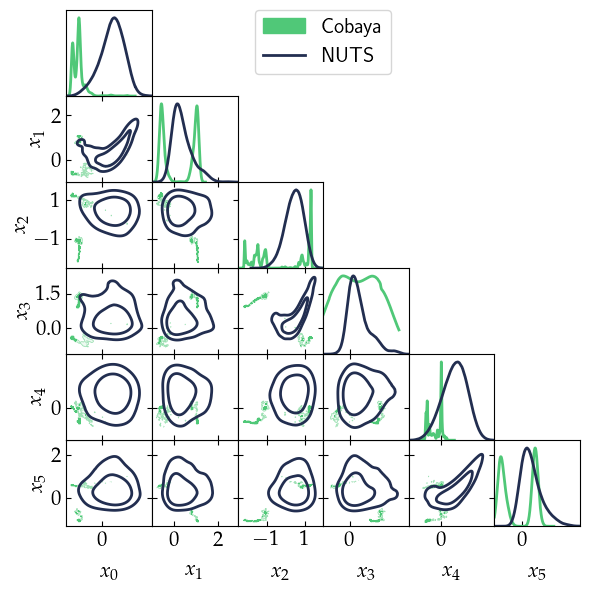

In [444]:
G = plots.getSubplotPlotter(subplot_size=1)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 15  # important for padding in x-axis
G.settings.line_styles = "Accent"
G.settings.legend_fontsize = 20
G.triangle_plot(
    [samples_cb, samples_nuts],
    filled=[True, False],
    contour_colors=[color1, color3],
    contour_lws=2,
    legend_labels=["Cobaya", "NUTS"],
)
# plt.savefig('plots/rosenbrock.pdf', bbox_inches = 'tight')
plt.show()

# Many Dimensions

In [19]:
dimensions = np.arange(4, 104, 4) # np.arange(1, 11, 1) * 10
record_emcee_metrics = []
record_nuts_metrics = []
record_cobaya_metrics = []

for ndim in dimensions:
    nuts_samples, nuts_stats, nuts_metrics = run_nuts(ndim=ndim)
    record_nuts_metrics.append(nuts_metrics)
    
    cobaya_samples, cobaya_stats, cobaya_metrics = run_cobaya(ndim=ndim)
    record_cobaya_metrics.append(cobaya_metrics)
    gc.collect()
    jax.clear_backends()
#     emcee_samples, emcee_stats, emcee_metrics = run_emcee(ndim=ndim)
#     record_emcee_metrics.append(emcee_metrics)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:25<00:00, 213.51it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_4_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_4_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.455071, p1:2.421461, p2:0.9728769, p3:-0.2567323


[mcmc] Initial point: p0:1.455071, p1:2.421461, p2:0.9728769, p3:-0.2567323


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2560.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2560.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:01:21 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:01:21 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 8.005103 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.005103 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 25.507601 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 25.507601 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 12.890296 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.890296 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.826


[mcmc]  - Acceptance rate: 0.826


INFO:mcmc: - Convergence of means: R-1 = 7.430108 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.430108 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.727


[mcmc]  - Acceptance rate: 0.727


INFO:mcmc: - Convergence of means: R-1 = 9.202228 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.202228 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.645


[mcmc]  - Acceptance rate: 0.645


INFO:mcmc: - Convergence of means: R-1 = 8.008426 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.008426 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.550


[mcmc]  - Acceptance rate: 0.550


INFO:mcmc: - Convergence of means: R-1 = 7.590054 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.590054 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.482


[mcmc]  - Acceptance rate: 0.482


INFO:mcmc: - Convergence of means: R-1 = 8.202271 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.202271 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 5.196464 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.196464 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.374


[mcmc]  - Acceptance rate: 0.374


INFO:mcmc: - Convergence of means: R-1 = 5.547199 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.547199 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.343


[mcmc]  - Acceptance rate: 0.343


INFO:mcmc: - Convergence of means: R-1 = 5.183911 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.183911 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.316


[mcmc]  - Acceptance rate: 0.316


INFO:mcmc: - Convergence of means: R-1 = 5.262470 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.262470 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 3.449868 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.449868 after 1664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.281


[mcmc]  - Acceptance rate: 0.281


INFO:mcmc: - Convergence of means: R-1 = 1.558934 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.558934 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.267


[mcmc]  - Acceptance rate: 0.267


INFO:mcmc: - Convergence of means: R-1 = 1.184129 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.184129 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.257


[mcmc]  - Acceptance rate: 0.257


INFO:mcmc: - Convergence of means: R-1 = 0.472834 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.472834 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.249


[mcmc]  - Acceptance rate: 0.249


INFO:mcmc: - Convergence of means: R-1 = 0.300274 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300274 after 2176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.238


[mcmc]  - Acceptance rate: 0.238


INFO:mcmc: - Convergence of means: R-1 = 0.204266 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204266 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.235


[mcmc]  - Acceptance rate: 0.235


INFO:mcmc: - Convergence of means: R-1 = 0.202805 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202805 after 2432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.229


[mcmc]  - Acceptance rate: 0.229


INFO:mcmc: - Convergence of means: R-1 = 0.141568 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141568 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.225


[mcmc]  - Acceptance rate: 0.225


INFO:mcmc: - Convergence of means: R-1 = 0.083223 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083223 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.222


[mcmc]  - Acceptance rate: 0.222


INFO:mcmc: - Convergence of means: R-1 = 0.037850 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037850 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.217


[mcmc]  - Acceptance rate: 0.217


INFO:mcmc: - Convergence of means: R-1 = 0.026399 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026399 after 2944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.215


[mcmc]  - Acceptance rate: 0.215


INFO:mcmc: - Convergence of means: R-1 = 0.039641 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039641 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 0.032248 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032248 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.210


[mcmc]  - Acceptance rate: 0.210


INFO:mcmc: - Convergence of means: R-1 = 0.014013 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014013 after 3328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.020505 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020505 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.026755 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026755 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4640 samples accepted.


[mcmc] Learn + convergence test @ 4640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.011862 after 3712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011862 after 3712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.010155 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010155 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4960 samples accepted.


[mcmc] Learn + convergence test @ 4960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.006850 after 3968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006850 after 3968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.010743 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010743 after 4096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.010893 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010893 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.008719 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008719 after 4352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.009871 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009871 after 4480 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.106453 after 5600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.106453 after 5600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 5600 accepted steps.


[mcmc] Sampling complete after 5600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_4_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_4_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.5847854, p1:1.236649, p2:0.4012604, p3:0.7316713


[mcmc] Initial point: p0:-0.5847854, p1:1.236649, p2:0.4012604, p3:0.7316713


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2720.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2720.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:01:32 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:01:32 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 8.465489 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.465489 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 19.445967 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.445967 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 13.383277 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.383277 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.848


[mcmc]  - Acceptance rate: 0.848


INFO:mcmc: - Convergence of means: R-1 = 8.525560 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.525560 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.729


[mcmc]  - Acceptance rate: 0.729


INFO:mcmc: - Convergence of means: R-1 = 3.257599 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.257599 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.488


[mcmc]  - Acceptance rate: 0.488


INFO:mcmc: - Convergence of means: R-1 = 8.764360 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.764360 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.418


[mcmc]  - Acceptance rate: 0.418


INFO:mcmc: - Convergence of means: R-1 = 9.387646 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.387646 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.367


[mcmc]  - Acceptance rate: 0.367


INFO:mcmc: - Convergence of means: R-1 = 4.284558 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.284558 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.315


[mcmc]  - Acceptance rate: 0.315


INFO:mcmc: - Convergence of means: R-1 = 2.858396 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.858396 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.280


[mcmc]  - Acceptance rate: 0.280


INFO:mcmc: - Convergence of means: R-1 = 5.241026 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.241026 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.264


[mcmc]  - Acceptance rate: 0.264


INFO:mcmc: - Convergence of means: R-1 = 8.040054 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.040054 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.254


[mcmc]  - Acceptance rate: 0.254


INFO:mcmc: - Convergence of means: R-1 = 2.347573 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.347573 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.242


[mcmc]  - Acceptance rate: 0.242


INFO:mcmc: - Convergence of means: R-1 = 0.802122 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.802122 after 1664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.232


[mcmc]  - Acceptance rate: 0.232


INFO:mcmc: - Convergence of means: R-1 = 0.423646 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.423646 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.222


[mcmc]  - Acceptance rate: 0.222


INFO:mcmc: - Convergence of means: R-1 = 0.270436 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.270436 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.215


[mcmc]  - Acceptance rate: 0.215


INFO:mcmc: - Convergence of means: R-1 = 0.182751 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182751 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 0.102444 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102444 after 2176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.210


[mcmc]  - Acceptance rate: 0.210


INFO:mcmc: - Convergence of means: R-1 = 0.098201 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098201 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.072193 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072193 after 2432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.044036 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044036 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.047516 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047516 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.068384 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068384 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.077913 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077913 after 2944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.049012 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049012 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.049747 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049747 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.022071 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022071 after 3328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.019475 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019475 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.024491 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024491 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4640 samples accepted.


[mcmc] Learn + convergence test @ 4640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.026078 after 3712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026078 after 3712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.024832 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024832 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4960 samples accepted.


[mcmc] Learn + convergence test @ 4960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.019436 after 3968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019436 after 3968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.020210 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020210 after 4096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.013765 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013765 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.009271 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009271 after 4352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.012004 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012004 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.009185 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009185 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5920 samples accepted.


[mcmc] Learn + convergence test @ 5920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.012245 after 4736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012245 after 4736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.011446 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011446 after 4864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013497 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013497 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.013065 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013065 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6560 samples accepted.


[mcmc] Learn + convergence test @ 6560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.010233 after 5248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010233 after 5248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.014513 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014513 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6880 samples accepted.


[mcmc] Learn + convergence test @ 6880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.014712 after 5504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014712 after 5504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.010119 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010119 after 5632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.018217 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018217 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.018618 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018618 after 5888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7520 samples accepted.


[mcmc] Learn + convergence test @ 7520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.014597 after 6016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014597 after 6016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.009802 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009802 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7840 samples accepted.


[mcmc] Learn + convergence test @ 7840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.013928 after 6272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013928 after 6272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.007944 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007944 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.022617 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022617 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.036142 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036142 after 6656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8480 samples accepted.


[mcmc] Learn + convergence test @ 8480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.029377 after 6784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029377 after 6784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.035215 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035215 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.040073 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040073 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.038217 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038217 after 7168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.039213 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039213 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9280 samples accepted.


[mcmc] Learn + convergence test @ 9280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.032252 after 7424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032252 after 7424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9440 samples accepted.


[mcmc] Learn + convergence test @ 9440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.034021 after 7552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034021 after 7552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.029725 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029725 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9760 samples accepted.


[mcmc] Learn + convergence test @ 9760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.029149 after 7808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029149 after 7808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9920 samples accepted.


[mcmc] Learn + convergence test @ 9920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.034804 after 7936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034804 after 7936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.033335 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033335 after 8064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.033162 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033162 after 8192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.038780 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038780 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.029908 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029908 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10720 samples accepted.


[mcmc] Learn + convergence test @ 10720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.027967 after 8576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027967 after 8576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.023598 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023598 after 8704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.021960 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021960 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.017490 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017490 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11360 samples accepted.


[mcmc] Learn + convergence test @ 11360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.022164 after 9088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022164 after 9088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.021186 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021186 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11680 samples accepted.


[mcmc] Learn + convergence test @ 11680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.025132 after 9344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025132 after 9344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11840 samples accepted.


[mcmc] Learn + convergence test @ 11840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.026769 after 9472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026769 after 9472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.020938 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020938 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.025557 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025557 after 9728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12320 samples accepted.


[mcmc] Learn + convergence test @ 12320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.025465 after 9856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025465 after 9856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.025119 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025119 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12640 samples accepted.


[mcmc] Learn + convergence test @ 12640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.027597 after 10112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027597 after 10112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.025643 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025643 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.021927 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021927 after 10368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13120 samples accepted.


[mcmc] Learn + convergence test @ 13120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.023950 after 10496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023950 after 10496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13280 samples accepted.


[mcmc] Learn + convergence test @ 13280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.027226 after 10624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027226 after 10624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.021335 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021335 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.011696 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011696 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13760 samples accepted.


[mcmc] Learn + convergence test @ 13760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.021710 after 11008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021710 after 11008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.023915 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023915 after 11136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.021807 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021807 after 11264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14240 samples accepted.


[mcmc] Learn + convergence test @ 14240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.020157 after 11392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020157 after 11392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.022334 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022334 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14560 samples accepted.


[mcmc] Learn + convergence test @ 14560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.020909 after 11648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020909 after 11648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.020839 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020839 after 11776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.022199 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022199 after 11904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15040 samples accepted.


[mcmc] Learn + convergence test @ 15040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.018414 after 12032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018414 after 12032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.018280 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018280 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013881 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013881 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15520 samples accepted.


[mcmc] Learn + convergence test @ 15520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013877 after 12416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013877 after 12416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015483 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015483 after 12544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.014656 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014656 after 12672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015397 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015397 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16160 samples accepted.


[mcmc] Learn + convergence test @ 16160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.019711 after 12928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019711 after 12928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.015430 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015430 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16480 samples accepted.


[mcmc] Learn + convergence test @ 16480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.016912 after 13184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016912 after 13184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013796 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013796 after 13312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013152 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013152 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16960 samples accepted.


[mcmc] Learn + convergence test @ 16960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013847 after 13568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013847 after 13568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17120 samples accepted.


[mcmc] Learn + convergence test @ 17120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.017227 after 13696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017227 after 13696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.018905 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018905 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17440 samples accepted.


[mcmc] Learn + convergence test @ 17440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.020456 after 13952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020456 after 13952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.023345 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023345 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17760 samples accepted.


[mcmc] Learn + convergence test @ 17760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.023476 after 14208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023476 after 14208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.018497 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018497 after 14336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18080 samples accepted.


[mcmc] Learn + convergence test @ 18080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015050 after 14464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015050 after 14464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015863 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015863 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.017400 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017400 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18560 samples accepted.


[mcmc] Learn + convergence test @ 18560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.016378 after 14848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016378 after 14848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015931 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015931 after 14976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18880 samples accepted.


[mcmc] Learn + convergence test @ 18880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.015212 after 15104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015212 after 15104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19040 samples accepted.


[mcmc] Learn + convergence test @ 19040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.017390 after 15232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017390 after 15232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.014627 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014627 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19360 samples accepted.


[mcmc] Learn + convergence test @ 19360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.013198 after 15488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013198 after 15488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19520 samples accepted.


[mcmc] Learn + convergence test @ 19520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.011359 after 15616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011359 after 15616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19680 samples accepted.


[mcmc] Learn + convergence test @ 19680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.010411 after 15744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010411 after 15744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19840 samples accepted.


[mcmc] Learn + convergence test @ 19840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.012400 after 15872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012400 after 15872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.011793 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011793 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.012716 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012716 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20320 samples accepted.


[mcmc] Learn + convergence test @ 20320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.010084 after 16256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010084 after 16256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.009547 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009547 after 16384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20640 samples accepted.


[mcmc] Learn + convergence test @ 20640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.009214 after 16512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009214 after 16512 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.062053 after 20640 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.062053 after 20640 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 20640 accepted steps.


[mcmc] Sampling complete after 20640 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:34<00:00, 158.46it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_8_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_8_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.4043524, p1:-0.4737753, p2:-1.087822, p3:-0.4536947, p4:-0.5432561, p5:-0.1386579, p6:0.5148392, p7:1.065503


[mcmc] Initial point: p0:-0.4043524, p1:-0.4737753, p2:-1.087822, p3:-0.4536947, p4:-0.5432561, p5:-0.1386579, p6:0.5148392, p7:1.065503


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1610.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1610.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:02:56 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:02:56 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 26.327608 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 26.327608 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 23.582473 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.582473 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 19.366855 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.366855 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.841


[mcmc]  - Acceptance rate: 0.841


INFO:mcmc: - Convergence of means: R-1 = 19.803211 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.803211 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.703


[mcmc]  - Acceptance rate: 0.703


INFO:mcmc: - Convergence of means: R-1 = 24.690104 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.690104 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.605


[mcmc]  - Acceptance rate: 0.605


INFO:mcmc: - Convergence of means: R-1 = 15.819271 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.819271 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.515


[mcmc]  - Acceptance rate: 0.515


INFO:mcmc: - Convergence of means: R-1 = 12.583190 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.583190 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.446


[mcmc]  - Acceptance rate: 0.446


INFO:mcmc: - Convergence of means: R-1 = 11.753035 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.753035 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.396


[mcmc]  - Acceptance rate: 0.396


INFO:mcmc: - Convergence of means: R-1 = 5.398708 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.398708 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.356


[mcmc]  - Acceptance rate: 0.356


INFO:mcmc: - Convergence of means: R-1 = 4.896275 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.896275 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.325


[mcmc]  - Acceptance rate: 0.325


INFO:mcmc: - Convergence of means: R-1 = 6.414401 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.414401 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 5.776973 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.776973 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.286


[mcmc]  - Acceptance rate: 0.286


INFO:mcmc: - Convergence of means: R-1 = 3.316131 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.316131 after 3328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.272


[mcmc]  - Acceptance rate: 0.272


INFO:mcmc: - Convergence of means: R-1 = 1.408337 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.408337 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.260


[mcmc]  - Acceptance rate: 0.260


INFO:mcmc: - Convergence of means: R-1 = 0.839375 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.839375 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.250


[mcmc]  - Acceptance rate: 0.250


INFO:mcmc: - Convergence of means: R-1 = 0.558381 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.558381 after 4096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.240


[mcmc]  - Acceptance rate: 0.240


INFO:mcmc: - Convergence of means: R-1 = 0.468550 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.468550 after 4352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.232


[mcmc]  - Acceptance rate: 0.232


INFO:mcmc: - Convergence of means: R-1 = 0.438977 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.438977 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.229


[mcmc]  - Acceptance rate: 0.229


INFO:mcmc: - Convergence of means: R-1 = 0.303423 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303423 after 4864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.224


[mcmc]  - Acceptance rate: 0.224


INFO:mcmc: - Convergence of means: R-1 = 0.297194 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.297194 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.220


[mcmc]  - Acceptance rate: 0.220


INFO:mcmc: - Convergence of means: R-1 = 0.150235 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150235 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.216


[mcmc]  - Acceptance rate: 0.216


INFO:mcmc: - Convergence of means: R-1 = 0.129622 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129622 after 5632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.213


[mcmc]  - Acceptance rate: 0.213


INFO:mcmc: - Convergence of means: R-1 = 0.107308 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107308 after 5888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.210


[mcmc]  - Acceptance rate: 0.210


INFO:mcmc: - Convergence of means: R-1 = 0.094685 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094685 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.097361 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097361 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.106286 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106286 after 6656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.089497 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089497 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.080597 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080597 after 7168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9280 samples accepted.


[mcmc] Learn + convergence test @ 9280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.089875 after 7424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089875 after 7424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.076926 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076926 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9920 samples accepted.


[mcmc] Learn + convergence test @ 9920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.056769 after 7936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056769 after 7936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.042891 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042891 after 8192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.038051 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038051 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.033536 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033536 after 8704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.043669 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043669 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.048650 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048650 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11840 samples accepted.


[mcmc] Learn + convergence test @ 11840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.051409 after 9472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051409 after 9472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.055347 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055347 after 9728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.049523 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049523 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.046889 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046889 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13120 samples accepted.


[mcmc] Learn + convergence test @ 13120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.054800 after 10496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054800 after 10496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.063916 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063916 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13760 samples accepted.


[mcmc] Learn + convergence test @ 13760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.071904 after 11008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071904 after 11008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.104125 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104125 after 11264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.082041 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082041 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.081314 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081314 after 11776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15040 samples accepted.


[mcmc] Learn + convergence test @ 15040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.089365 after 12032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089365 after 12032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.080141 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080141 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.059934 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059934 after 12544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.053437 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053437 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.067089 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067089 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.094074 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094074 after 13312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16960 samples accepted.


[mcmc] Learn + convergence test @ 16960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.088012 after 13568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088012 after 13568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.072928 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072928 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.084579 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084579 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:03:56 : 85563 steps taken, and 17719 accepted.


[mcmc] Progress @ 2024-04-14 21:03:56 : 85563 steps taken, and 17719 accepted.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.063071 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063071 after 14336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.050213 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050213 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18560 samples accepted.


[mcmc] Learn + convergence test @ 18560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.053543 after 14848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053543 after 14848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18880 samples accepted.


[mcmc] Learn + convergence test @ 18880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.053089 after 15104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053089 after 15104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.043911 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043911 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19520 samples accepted.


[mcmc] Learn + convergence test @ 19520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.039444 after 15616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039444 after 15616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19840 samples accepted.


[mcmc] Learn + convergence test @ 19840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.038877 after 15872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038877 after 15872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.044384 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044384 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.054103 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054103 after 16384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.053301 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053301 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.047701 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047701 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21440 samples accepted.


[mcmc] Learn + convergence test @ 21440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.044434 after 17152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044434 after 17152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.055449 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055449 after 17408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.054968 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054968 after 17664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.047377 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047377 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22720 samples accepted.


[mcmc] Learn + convergence test @ 22720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.046113 after 18176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046113 after 18176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.040705 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040705 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23360 samples accepted.


[mcmc] Learn + convergence test @ 23360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.045536 after 18688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045536 after 18688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23680 samples accepted.


[mcmc] Learn + convergence test @ 23680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.060387 after 18944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060387 after 18944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.040522 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040522 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.041280 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041280 after 19456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.038530 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038530 after 19712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.045116 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045116 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25280 samples accepted.


[mcmc] Learn + convergence test @ 25280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.037523 after 20224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037523 after 20224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.034752 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034752 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.028255 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028255 after 20736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26240 samples accepted.


[mcmc] Learn + convergence test @ 26240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.038754 after 20992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038754 after 20992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26560 samples accepted.


[mcmc] Learn + convergence test @ 26560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.037535 after 21248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037535 after 21248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.034293 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034293 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.036767 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036767 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27520 samples accepted.


[mcmc] Learn + convergence test @ 27520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.031611 after 22016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031611 after 22016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.037799 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037799 after 22272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.041741 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041741 after 22528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28480 samples accepted.


[mcmc] Learn + convergence test @ 28480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.035812 after 22784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035812 after 22784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.038722 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038722 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.039255 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039255 after 23296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.037307 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037307 after 23552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.035247 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035247 after 23808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30080 samples accepted.


[mcmc] Learn + convergence test @ 30080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.033305 after 24064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033305 after 24064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.032340 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032340 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.029141 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029141 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31040 samples accepted.


[mcmc] Learn + convergence test @ 31040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.025529 after 24832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025529 after 24832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.032188 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032188 after 25088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.033248 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033248 after 25344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.030682 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030682 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32320 samples accepted.


[mcmc] Learn + convergence test @ 32320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.027971 after 25856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027971 after 25856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.032234 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032234 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32960 samples accepted.


[mcmc] Learn + convergence test @ 32960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.029620 after 26368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029620 after 26368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:04:56 : 171037 steps taken, and 33234 accepted.


[mcmc] Progress @ 2024-04-14 21:04:56 : 171037 steps taken, and 33234 accepted.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.035068 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035068 after 26624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.029956 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029956 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33920 samples accepted.


[mcmc] Learn + convergence test @ 33920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.030545 after 27136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030545 after 27136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34240 samples accepted.


[mcmc] Learn + convergence test @ 34240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.029914 after 27392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029914 after 27392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.030009 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030009 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34880 samples accepted.


[mcmc] Learn + convergence test @ 34880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.028039 after 27904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028039 after 27904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.030169 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030169 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.027637 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027637 after 28416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.025093 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025093 after 28672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36160 samples accepted.


[mcmc] Learn + convergence test @ 36160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.027210 after 28928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027210 after 28928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.019873 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019873 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016342 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016342 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017029 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017029 after 29696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017871 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017871 after 29952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37760 samples accepted.


[mcmc] Learn + convergence test @ 37760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017807 after 30208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017807 after 30208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017893 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017893 after 30464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016410 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016410 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016074 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016074 after 30976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39040 samples accepted.


[mcmc] Learn + convergence test @ 39040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016589 after 31232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016589 after 31232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016098 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016098 after 31488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016511 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016511 after 31744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015116 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015116 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018134 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018134 after 32256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40640 samples accepted.


[mcmc] Learn + convergence test @ 40640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015617 after 32512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015617 after 32512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014309 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014309 after 32768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014771 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014771 after 33024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013602 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013602 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41920 samples accepted.


[mcmc] Learn + convergence test @ 41920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014071 after 33536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014071 after 33536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012238 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012238 after 33792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011636 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011636 after 34048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42880 samples accepted.


[mcmc] Learn + convergence test @ 42880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011378 after 34304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011378 after 34304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012448 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012448 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014518 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014518 after 34816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43840 samples accepted.


[mcmc] Learn + convergence test @ 43840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014447 after 35072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014447 after 35072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.013630 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013630 after 35328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44480 samples accepted.


[mcmc] Learn + convergence test @ 44480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.013177 after 35584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013177 after 35584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.013674 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013674 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.014721 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014721 after 36096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45440 samples accepted.


[mcmc] Learn + convergence test @ 45440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.015902 after 36352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015902 after 36352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.017082 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017082 after 36608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.019037 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019037 after 36864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.018274 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018274 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46720 samples accepted.


[mcmc] Learn + convergence test @ 46720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.018993 after 37376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018993 after 37376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018966 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018966 after 37632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.019747 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019747 after 37888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47680 samples accepted.


[mcmc] Learn + convergence test @ 47680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.020985 after 38144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020985 after 38144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.024463 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024463 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48320 samples accepted.


[mcmc] Learn + convergence test @ 48320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.024054 after 38656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024054 after 38656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.020942 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020942 after 38912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:05:56 : 255349 steps taken, and 48870 accepted.


[mcmc] Progress @ 2024-04-14 21:05:56 : 255349 steps taken, and 48870 accepted.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.019798 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019798 after 39168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016276 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016276 after 39424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018827 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018827 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017637 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017637 after 39936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50240 samples accepted.


[mcmc] Learn + convergence test @ 50240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018223 after 40192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018223 after 40192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50560 samples accepted.


[mcmc] Learn + convergence test @ 50560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016897 after 40448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016897 after 40448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015224 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015224 after 40704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014347 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014347 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014391 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014391 after 41216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012789 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012789 after 41472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52160 samples accepted.


[mcmc] Learn + convergence test @ 52160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014461 after 41728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014461 after 41728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014212 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014212 after 41984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014214 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014214 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53120 samples accepted.


[mcmc] Learn + convergence test @ 53120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014106 after 42496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014106 after 42496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53440 samples accepted.


[mcmc] Learn + convergence test @ 53440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012533 after 42752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012533 after 42752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012355 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012355 after 43008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54080 samples accepted.


[mcmc] Learn + convergence test @ 54080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011922 after 43264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011922 after 43264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011458 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011458 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010913 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010913 after 43776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55040 samples accepted.


[mcmc] Learn + convergence test @ 55040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011172 after 44032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011172 after 44032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55360 samples accepted.


[mcmc] Learn + convergence test @ 55360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010810 after 44288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010810 after 44288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010993 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010993 after 44544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012139 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012139 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012054 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012054 after 45056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56640 samples accepted.


[mcmc] Learn + convergence test @ 56640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012081 after 45312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012081 after 45312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56960 samples accepted.


[mcmc] Learn + convergence test @ 56960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010664 after 45568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010664 after 45568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57280 samples accepted.


[mcmc] Learn + convergence test @ 57280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010789 after 45824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010789 after 45824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010727 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010727 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57920 samples accepted.


[mcmc] Learn + convergence test @ 57920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010161 after 46336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010161 after 46336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010362 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010362 after 46592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58560 samples accepted.


[mcmc] Learn + convergence test @ 58560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010011 after 46848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010011 after 46848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.010124 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010124 after 47104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011087 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011087 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011665 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011665 after 47616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011380 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011380 after 47872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60160 samples accepted.


[mcmc] Learn + convergence test @ 60160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011642 after 48128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011642 after 48128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013085 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013085 after 48384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011843 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011843 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61120 samples accepted.


[mcmc] Learn + convergence test @ 61120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011800 after 48896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011800 after 48896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012824 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012824 after 49152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61760 samples accepted.


[mcmc] Learn + convergence test @ 61760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014073 after 49408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014073 after 49408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62080 samples accepted.


[mcmc] Learn + convergence test @ 62080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014604 after 49664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014604 after 49664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013992 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013992 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013453 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013453 after 50176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63040 samples accepted.


[mcmc] Learn + convergence test @ 63040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012456 after 50432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012456 after 50432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011129 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011129 after 50688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63680 samples accepted.


[mcmc] Learn + convergence test @ 63680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011666 after 50944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011666 after 50944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011975 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011975 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64320 samples accepted.


[mcmc] Learn + convergence test @ 64320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011674 after 51456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011674 after 51456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:06:56 : 339244 steps taken, and 64349 accepted.


[mcmc] Progress @ 2024-04-14 21:06:56 : 339244 steps taken, and 64349 accepted.


INFO:mcmc:Learn + convergence test @ 64640 samples accepted.


[mcmc] Learn + convergence test @ 64640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.011957 after 51712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011957 after 51712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64960 samples accepted.


[mcmc] Learn + convergence test @ 64960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012333 after 51968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012333 after 51968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012719 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012719 after 52224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014344 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014344 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65920 samples accepted.


[mcmc] Learn + convergence test @ 65920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014767 after 52736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014767 after 52736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014447 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014447 after 52992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015201 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015201 after 53248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015917 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015917 after 53504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018008 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018008 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67520 samples accepted.


[mcmc] Learn + convergence test @ 67520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018293 after 54016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018293 after 54016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67840 samples accepted.


[mcmc] Learn + convergence test @ 67840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018897 after 54272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018897 after 54272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68160 samples accepted.


[mcmc] Learn + convergence test @ 68160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.020981 after 54528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020981 after 54528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68480 samples accepted.


[mcmc] Learn + convergence test @ 68480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.022106 after 54784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022106 after 54784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.021032 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021032 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.021609 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021609 after 55296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69440 samples accepted.


[mcmc] Learn + convergence test @ 69440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.021306 after 55552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021306 after 55552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69760 samples accepted.


[mcmc] Learn + convergence test @ 69760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.019760 after 55808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019760 after 55808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70080 samples accepted.


[mcmc] Learn + convergence test @ 70080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.020341 after 56064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020341 after 56064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.018539 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018539 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70720 samples accepted.


[mcmc] Learn + convergence test @ 70720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017674 after 56576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017674 after 56576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016334 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016334 after 56832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71360 samples accepted.


[mcmc] Learn + convergence test @ 71360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017091 after 57088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017091 after 57088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.015194 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015194 after 57344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014337 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014337 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72320 samples accepted.


[mcmc] Learn + convergence test @ 72320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014206 after 57856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014206 after 57856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72640 samples accepted.


[mcmc] Learn + convergence test @ 72640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014141 after 58112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014141 after 58112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012377 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012377 after 58368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73280 samples accepted.


[mcmc] Learn + convergence test @ 73280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.012739 after 58624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012739 after 58624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.010603 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010603 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.009290 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009290 after 59136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.009502 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009502 after 59392 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.054391 after 74240 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.054391 after 74240 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 74240 accepted steps.


[mcmc] Sampling complete after 74240 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_8_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_8_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.243186, p1:0.4049999, p2:0.8642888, p3:0.1048511, p4:0.2681066, p5:-0.5318142, p6:1.146803, p7:-0.3344704


[mcmc] Initial point: p0:-1.243186, p1:0.4049999, p2:0.8642888, p3:0.1048511, p4:0.2681066, p5:-0.5318142, p6:1.146803, p7:-0.3344704


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1460.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1460.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:07:34 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:07:34 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 12.411778 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.411778 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 24.639323 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.639323 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.878


[mcmc]  - Acceptance rate: 0.878


INFO:mcmc: - Convergence of means: R-1 = 18.032978 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 18.032978 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.782


[mcmc]  - Acceptance rate: 0.782


INFO:mcmc: - Convergence of means: R-1 = 25.104268 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 25.104268 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.728


[mcmc]  - Acceptance rate: 0.728


INFO:mcmc: - Convergence of means: R-1 = 24.309238 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.309238 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.642


[mcmc]  - Acceptance rate: 0.642


INFO:mcmc: - Convergence of means: R-1 = 13.066061 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.066061 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.540


[mcmc]  - Acceptance rate: 0.540


INFO:mcmc: - Convergence of means: R-1 = 13.840101 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.840101 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.467


[mcmc]  - Acceptance rate: 0.467


INFO:mcmc: - Convergence of means: R-1 = 8.452686 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.452686 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.409


[mcmc]  - Acceptance rate: 0.409


INFO:mcmc: - Convergence of means: R-1 = 8.341588 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.341588 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.369


[mcmc]  - Acceptance rate: 0.369


INFO:mcmc: - Convergence of means: R-1 = 11.235877 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.235877 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.344


[mcmc]  - Acceptance rate: 0.344


INFO:mcmc: - Convergence of means: R-1 = 4.927542 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.927542 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.316


[mcmc]  - Acceptance rate: 0.316


INFO:mcmc: - Convergence of means: R-1 = 3.187844 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.187844 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.291


[mcmc]  - Acceptance rate: 0.291


INFO:mcmc: - Convergence of means: R-1 = 2.200480 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.200480 after 3328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.274


[mcmc]  - Acceptance rate: 0.274


INFO:mcmc: - Convergence of means: R-1 = 1.125153 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.125153 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.260


[mcmc]  - Acceptance rate: 0.260


INFO:mcmc: - Convergence of means: R-1 = 0.629329 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.629329 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.250


[mcmc]  - Acceptance rate: 0.250


INFO:mcmc: - Convergence of means: R-1 = 0.437382 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.437382 after 4096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.242


[mcmc]  - Acceptance rate: 0.242


INFO:mcmc: - Convergence of means: R-1 = 0.320512 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.320512 after 4352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.236


[mcmc]  - Acceptance rate: 0.236


INFO:mcmc: - Convergence of means: R-1 = 0.201662 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201662 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.229


[mcmc]  - Acceptance rate: 0.229


INFO:mcmc: - Convergence of means: R-1 = 0.135062 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135062 after 4864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.226


[mcmc]  - Acceptance rate: 0.226


INFO:mcmc: - Convergence of means: R-1 = 0.107440 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107440 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.222


[mcmc]  - Acceptance rate: 0.222


INFO:mcmc: - Convergence of means: R-1 = 0.105235 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105235 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.218


[mcmc]  - Acceptance rate: 0.218


INFO:mcmc: - Convergence of means: R-1 = 0.121640 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121640 after 5632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.216


[mcmc]  - Acceptance rate: 0.216


INFO:mcmc: - Convergence of means: R-1 = 0.106725 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106725 after 5888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.215


[mcmc]  - Acceptance rate: 0.215


INFO:mcmc: - Convergence of means: R-1 = 0.097078 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097078 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 0.078742 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078742 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.211


[mcmc]  - Acceptance rate: 0.211


INFO:mcmc: - Convergence of means: R-1 = 0.032124 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032124 after 6656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.210


[mcmc]  - Acceptance rate: 0.210


INFO:mcmc: - Convergence of means: R-1 = 0.054387 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054387 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.208


[mcmc]  - Acceptance rate: 0.208


INFO:mcmc: - Convergence of means: R-1 = 0.054572 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054572 after 7168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9280 samples accepted.


[mcmc] Learn + convergence test @ 9280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.054338 after 7424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054338 after 7424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.051247 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051247 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9920 samples accepted.


[mcmc] Learn + convergence test @ 9920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.043128 after 7936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043128 after 7936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.036899 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036899 after 8192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.045686 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045686 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.058550 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058550 after 8704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.052462 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052462 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.049820 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049820 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11840 samples accepted.


[mcmc] Learn + convergence test @ 11840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.043926 after 9472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043926 after 9472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.049847 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049847 after 9728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.061341 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061341 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.033589 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033589 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13120 samples accepted.


[mcmc] Learn + convergence test @ 13120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.044414 after 10496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044414 after 10496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.057107 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057107 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13760 samples accepted.


[mcmc] Learn + convergence test @ 13760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.044807 after 11008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044807 after 11008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.040527 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040527 after 11264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.034605 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034605 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.032850 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032850 after 11776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15040 samples accepted.


[mcmc] Learn + convergence test @ 15040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.038608 after 12032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038608 after 12032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.045322 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045322 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.040054 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040054 after 12544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.031678 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031678 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.035706 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035706 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.042879 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042879 after 13312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16960 samples accepted.


[mcmc] Learn + convergence test @ 16960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.027418 after 13568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027418 after 13568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.035913 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035913 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.031431 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031431 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.031090 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031090 after 14336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.030516 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030516 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:08:34 : 84924 steps taken, and 18355 accepted.


[mcmc] Progress @ 2024-04-14 21:08:34 : 84924 steps taken, and 18355 accepted.


INFO:mcmc:Learn + convergence test @ 18560 samples accepted.


[mcmc] Learn + convergence test @ 18560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.023361 after 14848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023361 after 14848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18880 samples accepted.


[mcmc] Learn + convergence test @ 18880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.021974 after 15104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021974 after 15104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.014149 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014149 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19520 samples accepted.


[mcmc] Learn + convergence test @ 19520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.013658 after 15616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013658 after 15616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19840 samples accepted.


[mcmc] Learn + convergence test @ 19840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.016684 after 15872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016684 after 15872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.014657 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014657 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.016999 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016999 after 16384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.016011 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016011 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.018531 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018531 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21440 samples accepted.


[mcmc] Learn + convergence test @ 21440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.025118 after 17152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025118 after 17152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.030505 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030505 after 17408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.032649 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032649 after 17664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.036540 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036540 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22720 samples accepted.


[mcmc] Learn + convergence test @ 22720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.032876 after 18176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032876 after 18176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.029839 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029839 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23360 samples accepted.


[mcmc] Learn + convergence test @ 23360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.026823 after 18688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026823 after 18688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23680 samples accepted.


[mcmc] Learn + convergence test @ 23680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.044882 after 18944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044882 after 18944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.050105 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050105 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.054460 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054460 after 19456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.049483 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049483 after 19712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.049389 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049389 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25280 samples accepted.


[mcmc] Learn + convergence test @ 25280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.052419 after 20224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052419 after 20224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.047070 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047070 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.044608 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044608 after 20736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26240 samples accepted.


[mcmc] Learn + convergence test @ 26240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.038501 after 20992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038501 after 20992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26560 samples accepted.


[mcmc] Learn + convergence test @ 26560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.039571 after 21248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039571 after 21248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.024175 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024175 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.029348 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029348 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27520 samples accepted.


[mcmc] Learn + convergence test @ 27520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.024438 after 22016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024438 after 22016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.027677 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027677 after 22272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.027710 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027710 after 22528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28480 samples accepted.


[mcmc] Learn + convergence test @ 28480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.024235 after 22784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024235 after 22784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.025033 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025033 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.032022 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032022 after 23296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.022612 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022612 after 23552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.030703 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030703 after 23808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30080 samples accepted.


[mcmc] Learn + convergence test @ 30080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.034804 after 24064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034804 after 24064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.040628 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040628 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.033353 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033353 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31040 samples accepted.


[mcmc] Learn + convergence test @ 31040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.031031 after 24832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031031 after 24832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.030112 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030112 after 25088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.027379 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027379 after 25344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.026544 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026544 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32320 samples accepted.


[mcmc] Learn + convergence test @ 32320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.024143 after 25856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024143 after 25856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.020792 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020792 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32960 samples accepted.


[mcmc] Learn + convergence test @ 32960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.021624 after 26368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021624 after 26368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.023783 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023783 after 26624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.025080 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025080 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33920 samples accepted.


[mcmc] Learn + convergence test @ 33920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.028642 after 27136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028642 after 27136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34240 samples accepted.


[mcmc] Learn + convergence test @ 34240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.024848 after 27392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024848 after 27392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:09:34 : 170507 steps taken, and 34450 accepted.


[mcmc] Progress @ 2024-04-14 21:09:34 : 170507 steps taken, and 34450 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.024933 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024933 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34880 samples accepted.


[mcmc] Learn + convergence test @ 34880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.024805 after 27904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024805 after 27904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.020700 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020700 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.017221 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017221 after 28416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.019834 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019834 after 28672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36160 samples accepted.


[mcmc] Learn + convergence test @ 36160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.019265 after 28928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019265 after 28928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.018365 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018365 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.018497 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018497 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.020067 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020067 after 29696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.019413 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019413 after 29952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37760 samples accepted.


[mcmc] Learn + convergence test @ 37760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.017479 after 30208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017479 after 30208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.021581 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021581 after 30464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.021183 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021183 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.018755 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018755 after 30976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39040 samples accepted.


[mcmc] Learn + convergence test @ 39040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.017849 after 31232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017849 after 31232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.011660 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011660 after 31488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.013441 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013441 after 31744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.013963 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013963 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.015716 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015716 after 32256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40640 samples accepted.


[mcmc] Learn + convergence test @ 40640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.018052 after 32512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018052 after 32512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.016301 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016301 after 32768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.016559 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016559 after 33024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.015694 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015694 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41920 samples accepted.


[mcmc] Learn + convergence test @ 41920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.015562 after 33536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015562 after 33536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.016498 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016498 after 33792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.015673 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015673 after 34048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42880 samples accepted.


[mcmc] Learn + convergence test @ 42880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.017419 after 34304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017419 after 34304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.014314 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014314 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.015623 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015623 after 34816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43840 samples accepted.


[mcmc] Learn + convergence test @ 43840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.018065 after 35072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018065 after 35072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.019280 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019280 after 35328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44480 samples accepted.


[mcmc] Learn + convergence test @ 44480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.022286 after 35584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022286 after 35584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.021407 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021407 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.020716 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020716 after 36096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45440 samples accepted.


[mcmc] Learn + convergence test @ 45440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.021583 after 36352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021583 after 36352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.017431 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017431 after 36608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.016981 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016981 after 36864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.015731 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015731 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46720 samples accepted.


[mcmc] Learn + convergence test @ 46720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.015645 after 37376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015645 after 37376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.016576 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016576 after 37632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.015352 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015352 after 37888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47680 samples accepted.


[mcmc] Learn + convergence test @ 47680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.016374 after 38144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016374 after 38144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.016817 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016817 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48320 samples accepted.


[mcmc] Learn + convergence test @ 48320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.016535 after 38656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016535 after 38656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.015882 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015882 after 38912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.013995 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013995 after 39168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.013209 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013209 after 39424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.013155 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013155 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.013590 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013590 after 39936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50240 samples accepted.


[mcmc] Learn + convergence test @ 50240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.012333 after 40192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012333 after 40192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:10:34 : 255736 steps taken, and 50261 accepted.


[mcmc] Progress @ 2024-04-14 21:10:34 : 255736 steps taken, and 50261 accepted.


INFO:mcmc:Learn + convergence test @ 50560 samples accepted.


[mcmc] Learn + convergence test @ 50560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.011333 after 40448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011333 after 40448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.013608 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013608 after 40704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.012895 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012895 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.012569 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012569 after 41216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.012446 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012446 after 41472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52160 samples accepted.


[mcmc] Learn + convergence test @ 52160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.011788 after 41728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011788 after 41728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.012330 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012330 after 41984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.012347 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012347 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53120 samples accepted.


[mcmc] Learn + convergence test @ 53120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.015101 after 42496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015101 after 42496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53440 samples accepted.


[mcmc] Learn + convergence test @ 53440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.008454 after 42752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008454 after 42752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.006909 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006909 after 43008 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.052927 after 53760 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.052927 after 53760 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 53760 accepted steps.


[mcmc] Sampling complete after 53760 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:52<00:00, 105.12it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_12_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_12_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.423711, p1:0.2144657, p2:-1.982784, p3:1.172707, p4:-0.5942853, p5:-1.042015, p6:-0.5829892, p7:0.09554396, p8:-3.44856, p9:-0.4111756, p10:-1.791881, p11:-0.281865


[mcmc] Initial point: p0:1.423711, p1:0.2144657, p2:-1.982784, p3:1.172707, p4:-0.5942853, p5:-1.042015, p6:-0.5829892, p7:0.09554396, p8:-3.44856, p9:-0.4111756, p10:-1.791881, p11:-0.281865


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1070.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1070.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:11:43 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:11:43 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.762


[mcmc]  - Acceptance rate: 0.762


INFO:mcmc: - Convergence of means: R-1 = 29.159760 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 29.159760 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.681


[mcmc]  - Acceptance rate: 0.681


INFO:mcmc: - Convergence of means: R-1 = 35.378330 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.378330 after 768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.736


[mcmc]  - Acceptance rate: 0.736


INFO:mcmc: - Convergence of means: R-1 = 45.307232 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.307232 after 1152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.784


[mcmc]  - Acceptance rate: 0.784


INFO:mcmc: - Convergence of means: R-1 = 35.671194 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.671194 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.822


[mcmc]  - Acceptance rate: 0.822


INFO:mcmc: - Convergence of means: R-1 = 39.127211 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.127211 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.857


[mcmc]  - Acceptance rate: 0.857


INFO:mcmc: - Convergence of means: R-1 = 27.134928 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 27.134928 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.825


[mcmc]  - Acceptance rate: 0.825


INFO:mcmc: - Convergence of means: R-1 = 14.307714 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.307714 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.747


[mcmc]  - Acceptance rate: 0.747


INFO:mcmc: - Convergence of means: R-1 = 17.748703 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.748703 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.700


[mcmc]  - Acceptance rate: 0.700


INFO:mcmc: - Convergence of means: R-1 = 14.282325 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.282325 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.632


[mcmc]  - Acceptance rate: 0.632


INFO:mcmc: - Convergence of means: R-1 = 23.428436 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.428436 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.587


[mcmc]  - Acceptance rate: 0.587


INFO:mcmc: - Convergence of means: R-1 = 16.516305 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.516305 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.528


[mcmc]  - Acceptance rate: 0.528


INFO:mcmc: - Convergence of means: R-1 = 16.085843 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.085843 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.476


[mcmc]  - Acceptance rate: 0.476


INFO:mcmc: - Convergence of means: R-1 = 20.878633 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 20.878633 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.436


[mcmc]  - Acceptance rate: 0.436


INFO:mcmc: - Convergence of means: R-1 = 14.930207 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.930207 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.402


[mcmc]  - Acceptance rate: 0.402


INFO:mcmc: - Convergence of means: R-1 = 13.682718 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.682718 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.365


[mcmc]  - Acceptance rate: 0.365


INFO:mcmc: - Convergence of means: R-1 = 17.616630 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.616630 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.339


[mcmc]  - Acceptance rate: 0.339


INFO:mcmc: - Convergence of means: R-1 = 21.221929 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.221929 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.321


[mcmc]  - Acceptance rate: 0.321


INFO:mcmc: - Convergence of means: R-1 = 23.834689 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.834689 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 8.068676 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.068676 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.287


[mcmc]  - Acceptance rate: 0.287


INFO:mcmc: - Convergence of means: R-1 = 7.083567 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.083567 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.270


[mcmc]  - Acceptance rate: 0.270


INFO:mcmc: - Convergence of means: R-1 = 6.953494 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.953494 after 8064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.258


[mcmc]  - Acceptance rate: 0.258


INFO:mcmc: - Convergence of means: R-1 = 7.206532 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.206532 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.250


[mcmc]  - Acceptance rate: 0.250


INFO:mcmc: - Convergence of means: R-1 = 8.045667 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.045667 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.240


[mcmc]  - Acceptance rate: 0.240


INFO:mcmc: - Convergence of means: R-1 = 10.215347 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.215347 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.232


[mcmc]  - Acceptance rate: 0.232


INFO:mcmc: - Convergence of means: R-1 = 12.297193 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.297193 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.226


[mcmc]  - Acceptance rate: 0.226


INFO:mcmc: - Convergence of means: R-1 = 16.334067 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.334067 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.220


[mcmc]  - Acceptance rate: 0.220


INFO:mcmc: - Convergence of means: R-1 = 13.933394 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.933394 after 10368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.216


[mcmc]  - Acceptance rate: 0.216


INFO:mcmc: - Convergence of means: R-1 = 6.677209 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.677209 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 4.163115 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.163115 after 11136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.209


[mcmc]  - Acceptance rate: 0.209


INFO:mcmc: - Convergence of means: R-1 = 3.722638 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.722638 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 2.744707 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.744707 after 11904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:12:43 : 61607 steps taken, and 14930 accepted.


[mcmc] Progress @ 2024-04-14 21:12:43 : 61607 steps taken, and 14930 accepted.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 2.076827 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.076827 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 1.586224 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.586224 after 12672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 1.198339 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.198339 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 1.081619 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.081619 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.962820 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.962820 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17760 samples accepted.


[mcmc] Learn + convergence test @ 17760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.803284 after 14208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.803284 after 14208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.628740 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.628740 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.486670 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486670 after 14976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.343501 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.343501 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19680 samples accepted.


[mcmc] Learn + convergence test @ 19680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.244586 after 15744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244586 after 15744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.248349 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.248349 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20640 samples accepted.


[mcmc] Learn + convergence test @ 20640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.209536 after 16512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209536 after 16512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.182538 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182538 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.175242 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175242 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.155241 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155241 after 17664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22560 samples accepted.


[mcmc] Learn + convergence test @ 22560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.132383 after 18048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132383 after 18048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.126382 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126382 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.102767 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102767 after 18816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.099015 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099015 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.089197 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089197 after 19584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:13:43 : 123634 steps taken, and 24810 accepted.


[mcmc] Progress @ 2024-04-14 21:13:43 : 123634 steps taken, and 24810 accepted.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.080103 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080103 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25440 samples accepted.


[mcmc] Learn + convergence test @ 25440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.071737 after 20352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071737 after 20352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.081104 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081104 after 20736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.088796 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088796 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.075343 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075343 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.069691 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069691 after 21888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.047068 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047068 after 22272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28320 samples accepted.


[mcmc] Learn + convergence test @ 28320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.047728 after 22656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047728 after 22656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.050791 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050791 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29280 samples accepted.


[mcmc] Learn + convergence test @ 29280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.046106 after 23424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046106 after 23424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.041939 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041939 after 23808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.046706 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046706 after 24192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.046422 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046422 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.049289 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049289 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.058273 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058273 after 25344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32160 samples accepted.


[mcmc] Learn + convergence test @ 32160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.065209 after 25728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065209 after 25728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.073564 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073564 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.071095 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071095 after 26496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.067863 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067863 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34080 samples accepted.


[mcmc] Learn + convergence test @ 34080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.074237 after 27264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074237 after 27264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.081800 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081800 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35040 samples accepted.


[mcmc] Learn + convergence test @ 35040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.079280 after 28032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079280 after 28032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.070653 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070653 after 28416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:14:43 : 185548 steps taken, and 35751 accepted.


[mcmc] Progress @ 2024-04-14 21:14:43 : 185548 steps taken, and 35751 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.060007 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060007 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.057863 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057863 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.050232 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050232 after 29568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.059213 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059213 after 29952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37920 samples accepted.


[mcmc] Learn + convergence test @ 37920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.051683 after 30336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051683 after 30336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.045773 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045773 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38880 samples accepted.


[mcmc] Learn + convergence test @ 38880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.047210 after 31104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047210 after 31104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.044311 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044311 after 31488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39840 samples accepted.


[mcmc] Learn + convergence test @ 39840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.045045 after 31872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045045 after 31872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034819 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034819 after 32256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034839 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034839 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031219 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031219 after 33024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41760 samples accepted.


[mcmc] Learn + convergence test @ 41760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027512 after 33408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027512 after 33408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031816 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031816 after 33792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42720 samples accepted.


[mcmc] Learn + convergence test @ 42720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030017 after 34176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030017 after 34176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031792 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031792 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028267 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028267 after 34944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026351 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026351 after 35328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44640 samples accepted.


[mcmc] Learn + convergence test @ 44640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029954 after 35712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029954 after 35712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030744 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030744 after 36096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030361 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030361 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028849 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028849 after 36864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46560 samples accepted.


[mcmc] Learn + convergence test @ 46560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028408 after 37248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028408 after 37248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:15:43 : 247465 steps taken, and 46845 accepted.


[mcmc] Progress @ 2024-04-14 21:15:43 : 247465 steps taken, and 46845 accepted.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026189 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026189 after 37632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027370 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027370 after 38016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033369 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033369 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48480 samples accepted.


[mcmc] Learn + convergence test @ 48480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.031087 after 38784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031087 after 38784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033808 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033808 after 39168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49440 samples accepted.


[mcmc] Learn + convergence test @ 49440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038507 after 39552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038507 after 39552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035706 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035706 after 39936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.031646 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031646 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.029083 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029083 after 40704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51360 samples accepted.


[mcmc] Learn + convergence test @ 51360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.027611 after 41088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027611 after 41088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.032152 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032152 after 41472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52320 samples accepted.


[mcmc] Learn + convergence test @ 52320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.031186 after 41856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031186 after 41856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.024291 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024291 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53280 samples accepted.


[mcmc] Learn + convergence test @ 53280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.025746 after 42624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025746 after 42624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.026740 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026740 after 43008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54240 samples accepted.


[mcmc] Learn + convergence test @ 54240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.025254 after 43392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025254 after 43392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.028975 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028975 after 43776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.027237 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027237 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.023757 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023757 after 44544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.022680 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022680 after 44928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56640 samples accepted.


[mcmc] Learn + convergence test @ 56640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.019879 after 45312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019879 after 45312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018211 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018211 after 45696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018783 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018783 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:16:43 : 309181 steps taken, and 57782 accepted.


[mcmc] Progress @ 2024-04-14 21:16:43 : 309181 steps taken, and 57782 accepted.


INFO:mcmc:Learn + convergence test @ 58080 samples accepted.


[mcmc] Learn + convergence test @ 58080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022883 after 46464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022883 after 46464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58560 samples accepted.


[mcmc] Learn + convergence test @ 58560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023732 after 46848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023732 after 46848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59040 samples accepted.


[mcmc] Learn + convergence test @ 59040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021222 after 47232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021222 after 47232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023808 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023808 after 47616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023438 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023438 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025436 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025436 after 48384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60960 samples accepted.


[mcmc] Learn + convergence test @ 60960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024881 after 48768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024881 after 48768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024114 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024114 after 49152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61920 samples accepted.


[mcmc] Learn + convergence test @ 61920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026576 after 49536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026576 after 49536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.025762 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025762 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62880 samples accepted.


[mcmc] Learn + convergence test @ 62880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.021869 after 50304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021869 after 50304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.026497 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026497 after 50688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.031272 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031272 after 51072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64320 samples accepted.


[mcmc] Learn + convergence test @ 64320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.029674 after 51456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029674 after 51456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.031108 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031108 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.031579 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031579 after 52224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65760 samples accepted.


[mcmc] Learn + convergence test @ 65760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.032322 after 52608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032322 after 52608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.032659 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032659 after 52992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66720 samples accepted.


[mcmc] Learn + convergence test @ 66720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.028858 after 53376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028858 after 53376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.029424 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029424 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67680 samples accepted.


[mcmc] Learn + convergence test @ 67680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.029539 after 54144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029539 after 54144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68160 samples accepted.


[mcmc] Learn + convergence test @ 68160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.032712 after 54528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032712 after 54528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.035404 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035404 after 54912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:17:43 : 370169 steps taken, and 68682 accepted.


[mcmc] Progress @ 2024-04-14 21:17:43 : 370169 steps taken, and 68682 accepted.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.036486 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036486 after 55296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.036041 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036041 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70080 samples accepted.


[mcmc] Learn + convergence test @ 70080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.034852 after 56064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034852 after 56064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.033998 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033998 after 56448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.034090 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034090 after 56832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71520 samples accepted.


[mcmc] Learn + convergence test @ 71520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.031527 after 57216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031527 after 57216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.029060 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029060 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72480 samples accepted.


[mcmc] Learn + convergence test @ 72480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.027118 after 57984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027118 after 57984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.026751 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026751 after 58368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.027819 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027819 after 58752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.028562 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028562 after 59136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.028388 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028388 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.028396 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028396 after 59904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75360 samples accepted.


[mcmc] Learn + convergence test @ 75360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.026439 after 60288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026439 after 60288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75840 samples accepted.


[mcmc] Learn + convergence test @ 75840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.025131 after 60672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025131 after 60672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76320 samples accepted.


[mcmc] Learn + convergence test @ 76320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.023457 after 61056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023457 after 61056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021942 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021942 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021415 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021415 after 61824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020471 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020471 after 62208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78240 samples accepted.


[mcmc] Learn + convergence test @ 78240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.022151 after 62592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022151 after 62592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021439 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021439 after 62976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021570 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021570 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79680 samples accepted.


[mcmc] Learn + convergence test @ 79680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021031 after 63744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021031 after 63744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:18:43 : 431094 steps taken, and 79743 accepted.


[mcmc] Progress @ 2024-04-14 21:18:43 : 431094 steps taken, and 79743 accepted.


INFO:mcmc:Learn + convergence test @ 80160 samples accepted.


[mcmc] Learn + convergence test @ 80160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020190 after 64128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020190 after 64128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020061 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020061 after 64512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81120 samples accepted.


[mcmc] Learn + convergence test @ 81120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020292 after 64896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020292 after 64896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020676 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020676 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018612 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018612 after 65664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019167 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019167 after 66048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83040 samples accepted.


[mcmc] Learn + convergence test @ 83040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016213 after 66432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016213 after 66432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.016802 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016802 after 66816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.014075 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014075 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.014792 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014792 after 67584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84960 samples accepted.


[mcmc] Learn + convergence test @ 84960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.015381 after 67968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015381 after 67968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85440 samples accepted.


[mcmc] Learn + convergence test @ 85440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.015778 after 68352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015778 after 68352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85920 samples accepted.


[mcmc] Learn + convergence test @ 85920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.015948 after 68736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015948 after 68736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.015948 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015948 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86880 samples accepted.


[mcmc] Learn + convergence test @ 86880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.017286 after 69504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017286 after 69504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.020438 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020438 after 69888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87840 samples accepted.


[mcmc] Learn + convergence test @ 87840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.020521 after 70272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020521 after 70272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.020240 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020240 after 70656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.018054 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018054 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.018816 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018816 after 71424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.018559 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018559 after 71808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.019093 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019093 after 72192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.019868 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019868 after 72576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:19:43 : 491856 steps taken, and 90755 accepted.


[mcmc] Progress @ 2024-04-14 21:19:43 : 491856 steps taken, and 90755 accepted.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020571 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020571 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91680 samples accepted.


[mcmc] Learn + convergence test @ 91680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018941 after 73344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018941 after 73344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017023 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017023 after 73728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92640 samples accepted.


[mcmc] Learn + convergence test @ 92640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019101 after 74112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019101 after 74112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93120 samples accepted.


[mcmc] Learn + convergence test @ 93120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016594 after 74496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016594 after 74496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016969 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016969 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016923 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016923 after 75264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94560 samples accepted.


[mcmc] Learn + convergence test @ 94560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018071 after 75648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018071 after 75648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019984 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019984 after 76032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95520 samples accepted.


[mcmc] Learn + convergence test @ 95520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021092 after 76416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021092 after 76416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021732 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021732 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96480 samples accepted.


[mcmc] Learn + convergence test @ 96480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022081 after 77184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022081 after 77184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96960 samples accepted.


[mcmc] Learn + convergence test @ 96960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022216 after 77568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022216 after 77568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021905 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021905 after 77952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021780 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021780 after 78336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021514 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021514 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98880 samples accepted.


[mcmc] Learn + convergence test @ 98880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022910 after 79104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022910 after 79104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.023562 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023562 after 79488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019622 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019622 after 79872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_12_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_12_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:2.525674, p1:0.8436771, p2:0.6424721, p3:0.9851301, p4:0.05125968, p5:-1.895834, p6:-0.06354219, p7:0.7417135, p8:0.4555043, p9:0.05789093, p10:-0.2029978, p11:0.03482173


[mcmc] Initial point: p0:2.525674, p1:0.8436771, p2:0.6424721, p3:0.9851301, p4:0.05125968, p5:-1.895834, p6:-0.06354219, p7:0.7417135, p8:0.4555043, p9:0.05789093, p10:-0.2029978, p11:0.03482173


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1060.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1060.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:20:34 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:20:34 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.871


[mcmc]  - Acceptance rate: 0.871


INFO:mcmc: - Convergence of means: R-1 = 54.999498 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.999498 after 384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.884


[mcmc]  - Acceptance rate: 0.884


INFO:mcmc: - Convergence of means: R-1 = 48.854162 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.854162 after 768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.885


[mcmc]  - Acceptance rate: 0.885


INFO:mcmc: - Convergence of means: R-1 = 30.592689 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 30.592689 after 1152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.893


[mcmc]  - Acceptance rate: 0.893


INFO:mcmc: - Convergence of means: R-1 = 42.306228 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.306228 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 45.036651 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.036651 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 30.182728 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 30.182728 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 31.292115 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 31.292115 after 2688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 46.301339 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.301339 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 41.057775 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.057775 after 3456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 38.914043 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.914043 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 57.989776 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.989776 after 4224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 33.425164 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.425164 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 33.817155 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.817155 after 4992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 34.815564 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 34.815564 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 49.012602 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.012602 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 28.889075 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 28.889075 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 13.066580 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.066580 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.881


[mcmc]  - Acceptance rate: 0.881


INFO:mcmc: - Convergence of means: R-1 = 8.298480 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.298480 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.832


[mcmc]  - Acceptance rate: 0.832


INFO:mcmc: - Convergence of means: R-1 = 11.139331 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.139331 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.786


[mcmc]  - Acceptance rate: 0.786


INFO:mcmc: - Convergence of means: R-1 = 52.898103 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.898103 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.740


[mcmc]  - Acceptance rate: 0.740


INFO:mcmc: - Convergence of means: R-1 = 24.319337 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.319337 after 8064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.698


[mcmc]  - Acceptance rate: 0.698


INFO:mcmc: - Convergence of means: R-1 = 17.212344 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.212344 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.654


[mcmc]  - Acceptance rate: 0.654


INFO:mcmc: - Convergence of means: R-1 = 21.093535 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.093535 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.616


[mcmc]  - Acceptance rate: 0.616


INFO:mcmc: - Convergence of means: R-1 = 14.724950 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.724950 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.580


[mcmc]  - Acceptance rate: 0.580


INFO:mcmc: - Convergence of means: R-1 = 12.951867 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.951867 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.550


[mcmc]  - Acceptance rate: 0.550


INFO:mcmc: - Convergence of means: R-1 = 20.006665 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 20.006665 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.519


[mcmc]  - Acceptance rate: 0.519


INFO:mcmc: - Convergence of means: R-1 = 31.372700 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 31.372700 after 10368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.495


[mcmc]  - Acceptance rate: 0.495


INFO:mcmc: - Convergence of means: R-1 = 23.440336 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.440336 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.473


[mcmc]  - Acceptance rate: 0.473


INFO:mcmc: - Convergence of means: R-1 = 19.165429 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.165429 after 11136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.453


[mcmc]  - Acceptance rate: 0.453


INFO:mcmc: - Convergence of means: R-1 = 18.278447 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 18.278447 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.435


[mcmc]  - Acceptance rate: 0.435


INFO:mcmc: - Convergence of means: R-1 = 13.575237 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.575237 after 11904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.416


[mcmc]  - Acceptance rate: 0.416


INFO:mcmc: - Convergence of means: R-1 = 9.163566 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.163566 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.400


[mcmc]  - Acceptance rate: 0.400


INFO:mcmc: - Convergence of means: R-1 = 7.516276 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.516276 after 12672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.386


[mcmc]  - Acceptance rate: 0.386


INFO:mcmc: - Convergence of means: R-1 = 7.897775 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.897775 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.370


[mcmc]  - Acceptance rate: 0.370


INFO:mcmc: - Convergence of means: R-1 = 8.219949 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.219949 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.358


[mcmc]  - Acceptance rate: 0.358


INFO:mcmc: - Convergence of means: R-1 = 8.685201 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.685201 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17760 samples accepted.


[mcmc] Learn + convergence test @ 17760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.349


[mcmc]  - Acceptance rate: 0.349


INFO:mcmc: - Convergence of means: R-1 = 9.832400 after 14208 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.832400 after 14208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.341


[mcmc]  - Acceptance rate: 0.341


INFO:mcmc: - Convergence of means: R-1 = 11.166010 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.166010 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.333


[mcmc]  - Acceptance rate: 0.333


INFO:mcmc: - Convergence of means: R-1 = 13.033906 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.033906 after 14976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.326


[mcmc]  - Acceptance rate: 0.326


INFO:mcmc: - Convergence of means: R-1 = 14.878791 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.878791 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19680 samples accepted.


[mcmc] Learn + convergence test @ 19680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.319


[mcmc]  - Acceptance rate: 0.319


INFO:mcmc: - Convergence of means: R-1 = 13.741337 after 15744 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.741337 after 15744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.313


[mcmc]  - Acceptance rate: 0.313


INFO:mcmc: - Convergence of means: R-1 = 12.924034 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.924034 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20640 samples accepted.


[mcmc] Learn + convergence test @ 20640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 11.024894 after 16512 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.024894 after 16512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:21:34 : 60693 steps taken, and 21035 accepted.


[mcmc] Progress @ 2024-04-14 21:21:34 : 60693 steps taken, and 21035 accepted.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 9.484372 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.484372 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 8.785723 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.785723 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.289


[mcmc]  - Acceptance rate: 0.289


INFO:mcmc: - Convergence of means: R-1 = 8.107458 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.107458 after 17664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22560 samples accepted.


[mcmc] Learn + convergence test @ 22560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.283


[mcmc]  - Acceptance rate: 0.283


INFO:mcmc: - Convergence of means: R-1 = 6.665974 after 18048 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.665974 after 18048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.279


[mcmc]  - Acceptance rate: 0.279


INFO:mcmc: - Convergence of means: R-1 = 5.438435 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.438435 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.274


[mcmc]  - Acceptance rate: 0.274


INFO:mcmc: - Convergence of means: R-1 = 4.403244 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.403244 after 18816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.269


[mcmc]  - Acceptance rate: 0.269


INFO:mcmc: - Convergence of means: R-1 = 4.223247 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.223247 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.265


[mcmc]  - Acceptance rate: 0.265


INFO:mcmc: - Convergence of means: R-1 = 4.232519 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.232519 after 19584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.260


[mcmc]  - Acceptance rate: 0.260


INFO:mcmc: - Convergence of means: R-1 = 4.323700 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.323700 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25440 samples accepted.


[mcmc] Learn + convergence test @ 25440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.256


[mcmc]  - Acceptance rate: 0.256


INFO:mcmc: - Convergence of means: R-1 = 4.303030 after 20352 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.303030 after 20352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.252


[mcmc]  - Acceptance rate: 0.252


INFO:mcmc: - Convergence of means: R-1 = 4.319115 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.319115 after 20736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.249


[mcmc]  - Acceptance rate: 0.249


INFO:mcmc: - Convergence of means: R-1 = 4.371532 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.371532 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.245


[mcmc]  - Acceptance rate: 0.245


INFO:mcmc: - Convergence of means: R-1 = 4.693792 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.693792 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.243


[mcmc]  - Acceptance rate: 0.243


INFO:mcmc: - Convergence of means: R-1 = 4.347321 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.347321 after 21888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.240


[mcmc]  - Acceptance rate: 0.240


INFO:mcmc: - Convergence of means: R-1 = 3.976634 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.976634 after 22272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28320 samples accepted.


[mcmc] Learn + convergence test @ 28320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.236


[mcmc]  - Acceptance rate: 0.236


INFO:mcmc: - Convergence of means: R-1 = 3.750096 after 22656 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.750096 after 22656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.234


[mcmc]  - Acceptance rate: 0.234


INFO:mcmc: - Convergence of means: R-1 = 2.727072 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.727072 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29280 samples accepted.


[mcmc] Learn + convergence test @ 29280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.232


[mcmc]  - Acceptance rate: 0.232


INFO:mcmc: - Convergence of means: R-1 = 1.950261 after 23424 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.950261 after 23424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.230


[mcmc]  - Acceptance rate: 0.230


INFO:mcmc: - Convergence of means: R-1 = 1.710195 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.710195 after 23808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.228


[mcmc]  - Acceptance rate: 0.228


INFO:mcmc: - Convergence of means: R-1 = 1.486490 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.486490 after 24192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.226


[mcmc]  - Acceptance rate: 0.226


INFO:mcmc: - Convergence of means: R-1 = 1.244899 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.244899 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.223


[mcmc]  - Acceptance rate: 0.223


INFO:mcmc: - Convergence of means: R-1 = 1.191062 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.191062 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.221


[mcmc]  - Acceptance rate: 0.221


INFO:mcmc: - Convergence of means: R-1 = 1.097650 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.097650 after 25344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:22:34 : 122809 steps taken, and 31905 accepted.


[mcmc] Progress @ 2024-04-14 21:22:34 : 122809 steps taken, and 31905 accepted.


INFO:mcmc:Learn + convergence test @ 32160 samples accepted.


[mcmc] Learn + convergence test @ 32160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.219


[mcmc]  - Acceptance rate: 0.219


INFO:mcmc: - Convergence of means: R-1 = 0.918685 after 25728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.918685 after 25728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.218


[mcmc]  - Acceptance rate: 0.218


INFO:mcmc: - Convergence of means: R-1 = 0.748036 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.748036 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.217


[mcmc]  - Acceptance rate: 0.217


INFO:mcmc: - Convergence of means: R-1 = 0.691084 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.691084 after 26496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.215


[mcmc]  - Acceptance rate: 0.215


INFO:mcmc: - Convergence of means: R-1 = 0.632405 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.632405 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34080 samples accepted.


[mcmc] Learn + convergence test @ 34080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.213


[mcmc]  - Acceptance rate: 0.213


INFO:mcmc: - Convergence of means: R-1 = 0.551642 after 27264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.551642 after 27264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 0.468150 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.468150 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35040 samples accepted.


[mcmc] Learn + convergence test @ 35040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.211


[mcmc]  - Acceptance rate: 0.211


INFO:mcmc: - Convergence of means: R-1 = 0.442326 after 28032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.442326 after 28032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.209


[mcmc]  - Acceptance rate: 0.209


INFO:mcmc: - Convergence of means: R-1 = 0.444849 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.444849 after 28416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.208


[mcmc]  - Acceptance rate: 0.208


INFO:mcmc: - Convergence of means: R-1 = 0.418786 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.418786 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.386906 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.386906 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.352736 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.352736 after 29568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.318532 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.318532 after 29952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37920 samples accepted.


[mcmc] Learn + convergence test @ 37920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.294299 after 30336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.294299 after 30336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.282787 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282787 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38880 samples accepted.


[mcmc] Learn + convergence test @ 38880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.256629 after 31104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256629 after 31104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.232447 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.232447 after 31488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39840 samples accepted.


[mcmc] Learn + convergence test @ 39840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.217011 after 31872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217011 after 31872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.197580 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.197580 after 32256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.162730 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162730 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.149562 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149562 after 33024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41760 samples accepted.


[mcmc] Learn + convergence test @ 41760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.141748 after 33408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141748 after 33408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.132431 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132431 after 33792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:23:34 : 184513 steps taken, and 42619 accepted.


[mcmc] Progress @ 2024-04-14 21:23:34 : 184513 steps taken, and 42619 accepted.


INFO:mcmc:Learn + convergence test @ 42720 samples accepted.


[mcmc] Learn + convergence test @ 42720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.122533 after 34176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122533 after 34176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.120009 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120009 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.121443 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121443 after 34944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.115750 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115750 after 35328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44640 samples accepted.


[mcmc] Learn + convergence test @ 44640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.116185 after 35712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116185 after 35712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.112416 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112416 after 36096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.107246 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107246 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.097163 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097163 after 36864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46560 samples accepted.


[mcmc] Learn + convergence test @ 46560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.101398 after 37248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101398 after 37248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.087811 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087811 after 37632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.074916 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074916 after 38016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.071186 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071186 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48480 samples accepted.


[mcmc] Learn + convergence test @ 48480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.067219 after 38784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067219 after 38784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.062490 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062490 after 39168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49440 samples accepted.


[mcmc] Learn + convergence test @ 49440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.055621 after 39552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055621 after 39552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.043806 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043806 after 39936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.041017 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041017 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.032449 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032449 after 40704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51360 samples accepted.


[mcmc] Learn + convergence test @ 51360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.029424 after 41088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029424 after 41088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.031858 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031858 after 41472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52320 samples accepted.


[mcmc] Learn + convergence test @ 52320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.038888 after 41856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038888 after 41856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.044751 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044751 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53280 samples accepted.


[mcmc] Learn + convergence test @ 53280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.038241 after 42624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038241 after 42624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.033674 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033674 after 43008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:24:34 : 246888 steps taken, and 53837 accepted.


[mcmc] Progress @ 2024-04-14 21:24:34 : 246888 steps taken, and 53837 accepted.


INFO:mcmc:Learn + convergence test @ 54240 samples accepted.


[mcmc] Learn + convergence test @ 54240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.033437 after 43392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033437 after 43392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.030301 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030301 after 43776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.029162 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029162 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.028777 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028777 after 44544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.026927 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026927 after 44928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56640 samples accepted.


[mcmc] Learn + convergence test @ 56640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.025746 after 45312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025746 after 45312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.028394 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028394 after 45696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.027193 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027193 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58080 samples accepted.


[mcmc] Learn + convergence test @ 58080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.024663 after 46464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024663 after 46464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58560 samples accepted.


[mcmc] Learn + convergence test @ 58560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.022753 after 46848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022753 after 46848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59040 samples accepted.


[mcmc] Learn + convergence test @ 59040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.020652 after 47232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020652 after 47232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.019852 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019852 after 47616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.024596 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024596 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.028319 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028319 after 48384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60960 samples accepted.


[mcmc] Learn + convergence test @ 60960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.032298 after 48768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032298 after 48768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.033378 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033378 after 49152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61920 samples accepted.


[mcmc] Learn + convergence test @ 61920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.028363 after 49536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028363 after 49536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.031850 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031850 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62880 samples accepted.


[mcmc] Learn + convergence test @ 62880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.027588 after 50304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027588 after 50304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.022745 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022745 after 50688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.024652 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024652 after 51072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64320 samples accepted.


[mcmc] Learn + convergence test @ 64320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.023908 after 51456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023908 after 51456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.020218 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020218 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:25:34 : 308813 steps taken, and 64851 accepted.


[mcmc] Progress @ 2024-04-14 21:25:34 : 308813 steps taken, and 64851 accepted.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.019625 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019625 after 52224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65760 samples accepted.


[mcmc] Learn + convergence test @ 65760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.018679 after 52608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018679 after 52608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.021122 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021122 after 52992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66720 samples accepted.


[mcmc] Learn + convergence test @ 66720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.025802 after 53376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025802 after 53376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.023830 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023830 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67680 samples accepted.


[mcmc] Learn + convergence test @ 67680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.025053 after 54144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025053 after 54144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68160 samples accepted.


[mcmc] Learn + convergence test @ 68160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.020521 after 54528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020521 after 54528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.017520 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017520 after 54912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.016941 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016941 after 55296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.017458 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017458 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70080 samples accepted.


[mcmc] Learn + convergence test @ 70080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.016138 after 56064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016138 after 56064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.015805 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015805 after 56448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.015264 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015264 after 56832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71520 samples accepted.


[mcmc] Learn + convergence test @ 71520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.016231 after 57216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016231 after 57216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.017833 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017833 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72480 samples accepted.


[mcmc] Learn + convergence test @ 72480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.018127 after 57984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018127 after 57984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.019134 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019134 after 58368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.024153 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024153 after 58752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.024300 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024300 after 59136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.025800 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025800 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.024386 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024386 after 59904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75360 samples accepted.


[mcmc] Learn + convergence test @ 75360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.022871 after 60288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022871 after 60288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:26:34 : 369825 steps taken, and 75649 accepted.


[mcmc] Progress @ 2024-04-14 21:26:34 : 369825 steps taken, and 75649 accepted.


INFO:mcmc:Learn + convergence test @ 75840 samples accepted.


[mcmc] Learn + convergence test @ 75840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.020618 after 60672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020618 after 60672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76320 samples accepted.


[mcmc] Learn + convergence test @ 76320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.018632 after 61056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018632 after 61056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.018023 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018023 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.018475 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018475 after 61824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.021302 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021302 after 62208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78240 samples accepted.


[mcmc] Learn + convergence test @ 78240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.021345 after 62592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021345 after 62592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.020712 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020712 after 62976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.021208 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021208 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79680 samples accepted.


[mcmc] Learn + convergence test @ 79680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.020491 after 63744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020491 after 63744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80160 samples accepted.


[mcmc] Learn + convergence test @ 80160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.019298 after 64128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019298 after 64128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020587 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020587 after 64512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81120 samples accepted.


[mcmc] Learn + convergence test @ 81120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020312 after 64896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020312 after 64896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017558 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017558 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017537 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017537 after 65664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018609 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018609 after 66048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83040 samples accepted.


[mcmc] Learn + convergence test @ 83040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018916 after 66432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018916 after 66432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017993 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017993 after 66816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018075 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018075 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018523 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018523 after 67584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84960 samples accepted.


[mcmc] Learn + convergence test @ 84960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019089 after 67968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019089 after 67968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85440 samples accepted.


[mcmc] Learn + convergence test @ 85440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019804 after 68352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019804 after 68352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85920 samples accepted.


[mcmc] Learn + convergence test @ 85920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.023393 after 68736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023393 after 68736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.023381 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023381 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:27:34 : 431499 steps taken, and 86576 accepted.


[mcmc] Progress @ 2024-04-14 21:27:34 : 431499 steps taken, and 86576 accepted.


INFO:mcmc:Learn + convergence test @ 86880 samples accepted.


[mcmc] Learn + convergence test @ 86880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022415 after 69504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022415 after 69504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022152 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022152 after 69888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87840 samples accepted.


[mcmc] Learn + convergence test @ 87840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021547 after 70272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021547 after 70272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020664 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020664 after 70656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018905 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018905 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017221 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017221 after 71424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016876 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016876 after 71808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016517 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016517 after 72192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017366 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017366 after 72576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015116 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015116 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91680 samples accepted.


[mcmc] Learn + convergence test @ 91680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015308 after 73344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015308 after 73344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.014589 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014589 after 73728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92640 samples accepted.


[mcmc] Learn + convergence test @ 92640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016265 after 74112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016265 after 74112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93120 samples accepted.


[mcmc] Learn + convergence test @ 93120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015440 after 74496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015440 after 74496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.014369 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014369 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015298 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015298 after 75264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94560 samples accepted.


[mcmc] Learn + convergence test @ 94560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.013658 after 75648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013658 after 75648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.014328 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014328 after 76032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95520 samples accepted.


[mcmc] Learn + convergence test @ 95520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015552 after 76416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015552 after 76416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.016851 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016851 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96480 samples accepted.


[mcmc] Learn + convergence test @ 96480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015638 after 77184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015638 after 77184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96960 samples accepted.


[mcmc] Learn + convergence test @ 96960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015333 after 77568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015333 after 77568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.014710 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014710 after 77952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:28:34 : 492666 steps taken, and 97581 accepted.


[mcmc] Progress @ 2024-04-14 21:28:34 : 492666 steps taken, and 97581 accepted.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.014512 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014512 after 78336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015919 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015919 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98880 samples accepted.


[mcmc] Learn + convergence test @ 98880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.015555 after 79104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015555 after 79104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.016996 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016996 after 79488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.016568 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016568 after 79872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:59<00:00, 92.49it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_16_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_16_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.04849, p1:-0.140518, p2:-1.180913, p3:0.1252078, p4:-0.5372816, p5:-1.474558, p6:-0.7052231, p7:-0.8475679, p8:-0.5453445, p9:0.03348332, p10:0.4411468, p11:0.7479263, p12:0.8072698, p13:-0.07791866, p14:-1.348611, p15:-0.02329129


[mcmc] Initial point: p0:1.04849, p1:-0.140518, p2:-1.180913, p3:0.1252078, p4:-0.5372816, p5:-1.474558, p6:-0.7052231, p7:-0.8475679, p8:-0.5453445, p9:0.03348332, p10:0.4411468, p11:0.7479263, p12:0.8072698, p13:-0.07791866, p14:-1.348611, p15:-0.02329129


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 845.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 845.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:29:51 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:29:51 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 51.068310 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.068310 after 512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 45.539041 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.539041 after 1024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 45.333171 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.333171 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 46.024165 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.024165 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 47.392298 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.392298 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 26.284312 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 26.284312 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 11.395505 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.395505 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.870


[mcmc]  - Acceptance rate: 0.870


INFO:mcmc: - Convergence of means: R-1 = 32.115387 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 32.115387 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.830


[mcmc]  - Acceptance rate: 0.830


INFO:mcmc: - Convergence of means: R-1 = 44.082343 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.082343 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.808


[mcmc]  - Acceptance rate: 0.808


INFO:mcmc: - Convergence of means: R-1 = 30.278827 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 30.278827 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.789


[mcmc]  - Acceptance rate: 0.789


INFO:mcmc: - Convergence of means: R-1 = 38.552469 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.552469 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.779


[mcmc]  - Acceptance rate: 0.779


INFO:mcmc: - Convergence of means: R-1 = 50.412642 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.412642 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.766


[mcmc]  - Acceptance rate: 0.766


INFO:mcmc: - Convergence of means: R-1 = 41.253973 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.253973 after 6656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.758


[mcmc]  - Acceptance rate: 0.758


INFO:mcmc: - Convergence of means: R-1 = 35.828488 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.828488 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.754


[mcmc]  - Acceptance rate: 0.754


INFO:mcmc: - Convergence of means: R-1 = 38.880275 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.880275 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.751


[mcmc]  - Acceptance rate: 0.751


INFO:mcmc: - Convergence of means: R-1 = 40.394922 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.394922 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.746


[mcmc]  - Acceptance rate: 0.746


INFO:mcmc: - Convergence of means: R-1 = 36.732635 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.732635 after 8704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.743


[mcmc]  - Acceptance rate: 0.743


INFO:mcmc: - Convergence of means: R-1 = 43.823315 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.823315 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.740


[mcmc]  - Acceptance rate: 0.740


INFO:mcmc: - Convergence of means: R-1 = 63.079337 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.079337 after 9728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.737


[mcmc]  - Acceptance rate: 0.737


INFO:mcmc: - Convergence of means: R-1 = 45.769177 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.769177 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.736


[mcmc]  - Acceptance rate: 0.736


INFO:mcmc: - Convergence of means: R-1 = 36.716108 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.716108 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.732


[mcmc]  - Acceptance rate: 0.732


INFO:mcmc: - Convergence of means: R-1 = 43.585517 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.585517 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.728


[mcmc]  - Acceptance rate: 0.728


INFO:mcmc: - Convergence of means: R-1 = 30.064570 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 30.064570 after 11776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.725


[mcmc]  - Acceptance rate: 0.725


INFO:mcmc: - Convergence of means: R-1 = 22.552340 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 22.552340 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.689


[mcmc]  - Acceptance rate: 0.689


INFO:mcmc: - Convergence of means: R-1 = 15.757558 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.757558 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.654


[mcmc]  - Acceptance rate: 0.654


INFO:mcmc: - Convergence of means: R-1 = 11.797982 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.797982 after 13312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.620


[mcmc]  - Acceptance rate: 0.620


INFO:mcmc: - Convergence of means: R-1 = 9.645298 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.645298 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.587


[mcmc]  - Acceptance rate: 0.587


INFO:mcmc: - Convergence of means: R-1 = 9.485344 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.485344 after 14336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18560 samples accepted.


[mcmc] Learn + convergence test @ 18560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.557


[mcmc]  - Acceptance rate: 0.557


INFO:mcmc: - Convergence of means: R-1 = 8.928902 after 14848 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.928902 after 14848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.534


[mcmc]  - Acceptance rate: 0.534


INFO:mcmc: - Convergence of means: R-1 = 9.120339 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.120339 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19840 samples accepted.


[mcmc] Learn + convergence test @ 19840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.512


[mcmc]  - Acceptance rate: 0.512


INFO:mcmc: - Convergence of means: R-1 = 8.301629 after 15872 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.301629 after 15872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.487


[mcmc]  - Acceptance rate: 0.487


INFO:mcmc: - Convergence of means: R-1 = 8.404590 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.404590 after 16384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.470


[mcmc]  - Acceptance rate: 0.470


INFO:mcmc: - Convergence of means: R-1 = 6.723352 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.723352 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.454


[mcmc]  - Acceptance rate: 0.454


INFO:mcmc: - Convergence of means: R-1 = 6.263611 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.263611 after 17408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.439


[mcmc]  - Acceptance rate: 0.439


INFO:mcmc: - Convergence of means: R-1 = 6.436025 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.436025 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:30:51 : 47361 steps taken, and 22815 accepted.


[mcmc] Progress @ 2024-04-14 21:30:51 : 47361 steps taken, and 22815 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.425


[mcmc]  - Acceptance rate: 0.425


INFO:mcmc: - Convergence of means: R-1 = 6.051420 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.051420 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23680 samples accepted.


[mcmc] Learn + convergence test @ 23680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.410


[mcmc]  - Acceptance rate: 0.410


INFO:mcmc: - Convergence of means: R-1 = 6.097609 after 18944 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.097609 after 18944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.399


[mcmc]  - Acceptance rate: 0.399


INFO:mcmc: - Convergence of means: R-1 = 6.239768 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.239768 after 19456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.389


[mcmc]  - Acceptance rate: 0.389


INFO:mcmc: - Convergence of means: R-1 = 5.623874 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.623874 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.380


[mcmc]  - Acceptance rate: 0.380


INFO:mcmc: - Convergence of means: R-1 = 5.868489 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.868489 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26240 samples accepted.


[mcmc] Learn + convergence test @ 26240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.371


[mcmc]  - Acceptance rate: 0.371


INFO:mcmc: - Convergence of means: R-1 = 6.072484 after 20992 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.072484 after 20992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.364


[mcmc]  - Acceptance rate: 0.364


INFO:mcmc: - Convergence of means: R-1 = 5.054400 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.054400 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27520 samples accepted.


[mcmc] Learn + convergence test @ 27520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.357


[mcmc]  - Acceptance rate: 0.357


INFO:mcmc: - Convergence of means: R-1 = 4.873335 after 22016 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.873335 after 22016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.349


[mcmc]  - Acceptance rate: 0.349


INFO:mcmc: - Convergence of means: R-1 = 4.234365 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.234365 after 22528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.342


[mcmc]  - Acceptance rate: 0.342


INFO:mcmc: - Convergence of means: R-1 = 3.600789 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.600789 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.336


[mcmc]  - Acceptance rate: 0.336


INFO:mcmc: - Convergence of means: R-1 = 3.186262 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.186262 after 23552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30080 samples accepted.


[mcmc] Learn + convergence test @ 30080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.330


[mcmc]  - Acceptance rate: 0.330


INFO:mcmc: - Convergence of means: R-1 = 3.147188 after 24064 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.147188 after 24064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.324


[mcmc]  - Acceptance rate: 0.324


INFO:mcmc: - Convergence of means: R-1 = 2.968967 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.968967 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.318


[mcmc]  - Acceptance rate: 0.318


INFO:mcmc: - Convergence of means: R-1 = 2.776340 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.776340 after 25088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.313


[mcmc]  - Acceptance rate: 0.313


INFO:mcmc: - Convergence of means: R-1 = 2.743490 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.743490 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 2.635474 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.635474 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:31:51 : 95332 steps taken, and 33213 accepted.


[mcmc] Progress @ 2024-04-14 21:31:51 : 95332 steps taken, and 33213 accepted.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 2.412646 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.412646 after 26624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33920 samples accepted.


[mcmc] Learn + convergence test @ 33920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 2.325518 after 27136 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.325518 after 27136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 2.415894 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.415894 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.290


[mcmc]  - Acceptance rate: 0.290


INFO:mcmc: - Convergence of means: R-1 = 2.505281 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.505281 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.286


[mcmc]  - Acceptance rate: 0.286


INFO:mcmc: - Convergence of means: R-1 = 2.643916 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.643916 after 28672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.283


[mcmc]  - Acceptance rate: 0.283


INFO:mcmc: - Convergence of means: R-1 = 2.561957 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.561957 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.280


[mcmc]  - Acceptance rate: 0.280


INFO:mcmc: - Convergence of means: R-1 = 2.597539 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.597539 after 29696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37760 samples accepted.


[mcmc] Learn + convergence test @ 37760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.277


[mcmc]  - Acceptance rate: 0.277


INFO:mcmc: - Convergence of means: R-1 = 2.625972 after 30208 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.625972 after 30208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.275


[mcmc]  - Acceptance rate: 0.275


INFO:mcmc: - Convergence of means: R-1 = 2.727860 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.727860 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39040 samples accepted.


[mcmc] Learn + convergence test @ 39040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.272


[mcmc]  - Acceptance rate: 0.272


INFO:mcmc: - Convergence of means: R-1 = 2.830515 after 31232 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.830515 after 31232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.270


[mcmc]  - Acceptance rate: 0.270


INFO:mcmc: - Convergence of means: R-1 = 2.701594 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.701594 after 31744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.267


[mcmc]  - Acceptance rate: 0.267


INFO:mcmc: - Convergence of means: R-1 = 2.444787 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.444787 after 32256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.265


[mcmc]  - Acceptance rate: 0.265


INFO:mcmc: - Convergence of means: R-1 = 2.379462 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.379462 after 32768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.262


[mcmc]  - Acceptance rate: 0.262


INFO:mcmc: - Convergence of means: R-1 = 2.143464 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.143464 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.260


[mcmc]  - Acceptance rate: 0.260


INFO:mcmc: - Convergence of means: R-1 = 1.906645 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.906645 after 33792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42880 samples accepted.


[mcmc] Learn + convergence test @ 42880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.258


[mcmc]  - Acceptance rate: 0.258


INFO:mcmc: - Convergence of means: R-1 = 1.662323 after 34304 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.662323 after 34304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:32:51 : 143998 steps taken, and 42906 accepted.


[mcmc] Progress @ 2024-04-14 21:32:51 : 143998 steps taken, and 42906 accepted.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.256


[mcmc]  - Acceptance rate: 0.256


INFO:mcmc: - Convergence of means: R-1 = 1.471912 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.471912 after 34816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.253


[mcmc]  - Acceptance rate: 0.253


INFO:mcmc: - Convergence of means: R-1 = 1.197236 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.197236 after 35328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.251


[mcmc]  - Acceptance rate: 0.251


INFO:mcmc: - Convergence of means: R-1 = 1.018013 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.018013 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45440 samples accepted.


[mcmc] Learn + convergence test @ 45440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.249


[mcmc]  - Acceptance rate: 0.249


INFO:mcmc: - Convergence of means: R-1 = 0.962116 after 36352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.962116 after 36352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.246


[mcmc]  - Acceptance rate: 0.246


INFO:mcmc: - Convergence of means: R-1 = 0.804930 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.804930 after 36864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46720 samples accepted.


[mcmc] Learn + convergence test @ 46720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.244


[mcmc]  - Acceptance rate: 0.244


INFO:mcmc: - Convergence of means: R-1 = 0.730526 after 37376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.730526 after 37376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.242


[mcmc]  - Acceptance rate: 0.242


INFO:mcmc: - Convergence of means: R-1 = 0.676465 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.676465 after 37888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.240


[mcmc]  - Acceptance rate: 0.240


INFO:mcmc: - Convergence of means: R-1 = 0.630467 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.630467 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.238


[mcmc]  - Acceptance rate: 0.238


INFO:mcmc: - Convergence of means: R-1 = 0.545914 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.545914 after 38912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.237


[mcmc]  - Acceptance rate: 0.237


INFO:mcmc: - Convergence of means: R-1 = 0.471676 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.471676 after 39424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.235


[mcmc]  - Acceptance rate: 0.235


INFO:mcmc: - Convergence of means: R-1 = 0.402888 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.402888 after 39936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50560 samples accepted.


[mcmc] Learn + convergence test @ 50560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.233


[mcmc]  - Acceptance rate: 0.233


INFO:mcmc: - Convergence of means: R-1 = 0.337932 after 40448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337932 after 40448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.232


[mcmc]  - Acceptance rate: 0.232


INFO:mcmc: - Convergence of means: R-1 = 0.300610 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300610 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:33:51 : 192875 steps taken, and 51760 accepted.


[mcmc] Progress @ 2024-04-14 21:33:51 : 192875 steps taken, and 51760 accepted.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.230


[mcmc]  - Acceptance rate: 0.230


INFO:mcmc: - Convergence of means: R-1 = 0.273413 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.273413 after 41472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.229


[mcmc]  - Acceptance rate: 0.229


INFO:mcmc: - Convergence of means: R-1 = 0.260730 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.260730 after 41984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53120 samples accepted.


[mcmc] Learn + convergence test @ 53120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.227


[mcmc]  - Acceptance rate: 0.227


INFO:mcmc: - Convergence of means: R-1 = 0.264874 after 42496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264874 after 42496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.226


[mcmc]  - Acceptance rate: 0.226


INFO:mcmc: - Convergence of means: R-1 = 0.256403 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256403 after 43008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.225


[mcmc]  - Acceptance rate: 0.225


INFO:mcmc: - Convergence of means: R-1 = 0.240306 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.240306 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55040 samples accepted.


[mcmc] Learn + convergence test @ 55040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.224


[mcmc]  - Acceptance rate: 0.224


INFO:mcmc: - Convergence of means: R-1 = 0.218195 after 44032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218195 after 44032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.223


[mcmc]  - Acceptance rate: 0.223


INFO:mcmc: - Convergence of means: R-1 = 0.201640 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201640 after 44544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.222


[mcmc]  - Acceptance rate: 0.222


INFO:mcmc: - Convergence of means: R-1 = 0.190065 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.190065 after 45056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56960 samples accepted.


[mcmc] Learn + convergence test @ 56960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.221


[mcmc]  - Acceptance rate: 0.221


INFO:mcmc: - Convergence of means: R-1 = 0.190381 after 45568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.190381 after 45568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.219


[mcmc]  - Acceptance rate: 0.219


INFO:mcmc: - Convergence of means: R-1 = 0.184214 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.184214 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.218


[mcmc]  - Acceptance rate: 0.218


INFO:mcmc: - Convergence of means: R-1 = 0.152655 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152655 after 46592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.217


[mcmc]  - Acceptance rate: 0.217


INFO:mcmc: - Convergence of means: R-1 = 0.118242 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118242 after 47104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.216


[mcmc]  - Acceptance rate: 0.216


INFO:mcmc: - Convergence of means: R-1 = 0.111138 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111138 after 47616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60160 samples accepted.


[mcmc] Learn + convergence test @ 60160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.215


[mcmc]  - Acceptance rate: 0.215


INFO:mcmc: - Convergence of means: R-1 = 0.105707 after 48128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105707 after 48128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:34:51 : 240884 steps taken, and 60499 accepted.


[mcmc] Progress @ 2024-04-14 21:34:51 : 240884 steps taken, and 60499 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.214


[mcmc]  - Acceptance rate: 0.214


INFO:mcmc: - Convergence of means: R-1 = 0.095415 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095415 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.214


[mcmc]  - Acceptance rate: 0.214


INFO:mcmc: - Convergence of means: R-1 = 0.089339 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089339 after 49152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62080 samples accepted.


[mcmc] Learn + convergence test @ 62080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.213


[mcmc]  - Acceptance rate: 0.213


INFO:mcmc: - Convergence of means: R-1 = 0.084582 after 49664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084582 after 49664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.212


[mcmc]  - Acceptance rate: 0.212


INFO:mcmc: - Convergence of means: R-1 = 0.079561 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079561 after 50176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.211


[mcmc]  - Acceptance rate: 0.211


INFO:mcmc: - Convergence of means: R-1 = 0.081202 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081202 after 50688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.210


[mcmc]  - Acceptance rate: 0.210


INFO:mcmc: - Convergence of means: R-1 = 0.076940 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076940 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64640 samples accepted.


[mcmc] Learn + convergence test @ 64640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.209


[mcmc]  - Acceptance rate: 0.209


INFO:mcmc: - Convergence of means: R-1 = 0.080711 after 51712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080711 after 51712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.208


[mcmc]  - Acceptance rate: 0.208


INFO:mcmc: - Convergence of means: R-1 = 0.086321 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086321 after 52224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65920 samples accepted.


[mcmc] Learn + convergence test @ 65920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.208


[mcmc]  - Acceptance rate: 0.208


INFO:mcmc: - Convergence of means: R-1 = 0.079137 after 52736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079137 after 52736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.078046 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078046 after 53248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.083580 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083580 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67840 samples accepted.


[mcmc] Learn + convergence test @ 67840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.075205 after 54272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075205 after 54272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68480 samples accepted.


[mcmc] Learn + convergence test @ 68480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.073771 after 54784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073771 after 54784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.070433 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070433 after 55296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:35:51 : 289478 steps taken, and 69185 accepted.


[mcmc] Progress @ 2024-04-14 21:35:51 : 289478 steps taken, and 69185 accepted.


INFO:mcmc:Learn + convergence test @ 69760 samples accepted.


[mcmc] Learn + convergence test @ 69760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.073555 after 55808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073555 after 55808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.075664 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075664 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.070271 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070271 after 56832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.068109 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068109 after 57344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72320 samples accepted.


[mcmc] Learn + convergence test @ 72320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.072877 after 57856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072877 after 57856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.069686 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069686 after 58368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.072387 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072387 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.059334 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059334 after 59392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.052614 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052614 after 59904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75520 samples accepted.


[mcmc] Learn + convergence test @ 75520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.054850 after 60416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054850 after 60416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.052027 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052027 after 60928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.049531 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049531 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.045536 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045536 after 61952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:36:51 : 337249 steps taken, and 77457 accepted.


[mcmc] Progress @ 2024-04-14 21:36:51 : 337249 steps taken, and 77457 accepted.


INFO:mcmc:Learn + convergence test @ 78080 samples accepted.


[mcmc] Learn + convergence test @ 78080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.042914 after 62464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042914 after 62464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.046066 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046066 after 62976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.037583 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037583 after 63488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.037349 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037349 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.035001 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035001 after 64512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81280 samples accepted.


[mcmc] Learn + convergence test @ 81280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.037095 after 65024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037095 after 65024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.040460 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040460 after 65536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.041230 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041230 after 66048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.042411 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042411 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83840 samples accepted.


[mcmc] Learn + convergence test @ 83840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.040132 after 67072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040132 after 67072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.038980 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038980 after 67584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.040087 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040087 after 68096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85760 samples accepted.


[mcmc] Learn + convergence test @ 85760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.038146 after 68608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038146 after 68608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:37:51 : 385030 steps taken, and 85939 accepted.


[mcmc] Progress @ 2024-04-14 21:37:51 : 385030 steps taken, and 85939 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.035857 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035857 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.033955 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033955 after 69632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87680 samples accepted.


[mcmc] Learn + convergence test @ 87680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.029590 after 70144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029590 after 70144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.029112 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029112 after 70656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88960 samples accepted.


[mcmc] Learn + convergence test @ 88960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.034660 after 71168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034660 after 71168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.033622 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033622 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.032887 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032887 after 72192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90880 samples accepted.


[mcmc] Learn + convergence test @ 90880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.032340 after 72704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032340 after 72704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.036026 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036026 after 73216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.034366 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034366 after 73728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.037057 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037057 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93440 samples accepted.


[mcmc] Learn + convergence test @ 93440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.035385 after 74752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035385 after 74752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.032184 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032184 after 75264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-04-14 21:38:51 : 432944 steps taken, and 94433 accepted.


[mcmc] Progress @ 2024-04-14 21:38:51 : 432944 steps taken, and 94433 accepted.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.035210 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035210 after 75776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95360 samples accepted.


[mcmc] Learn + convergence test @ 95360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.037162 after 76288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037162 after 76288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.037809 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037809 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96640 samples accepted.


[mcmc] Learn + convergence test @ 96640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.037576 after 77312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037576 after 77312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.037754 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037754 after 77824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.038520 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038520 after 78336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.035114 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035114 after 78848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.037611 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037611 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.033978 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033978 after 79872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_16_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_16_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.3352516, p1:0.1383016, p2:-1.796964, p3:-0.3550656, p4:0.3354944, p5:-1.876302, p6:1.493087, p7:-1.010599, p8:1.009988, p9:-1.541589, p10:-0.8161012, p11:-1.214813, p12:-0.8952576, p13:-1.143929, p14:-0.5180327, p15:0.5074171


[mcmc] Initial point: p0:0.3352516, p1:0.1383016, p2:-1.796964, p3:-0.3550656, p4:0.3354944, p5:-1.876302, p6:1.493087, p7:-1.010599, p8:1.009988, p9:-1.541589, p10:-0.8161012, p11:-1.214813, p12:-0.8952576, p13:-1.143929, p14:-0.5180327, p15:0.5074171


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 827.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 827.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:39:32 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:39:32 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 30.429259 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 30.429259 after 512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 61.522305 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.522305 after 1024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 38.433296 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.433296 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 42.776376 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.776376 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 36.359025 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.359025 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 33.204825 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.204825 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 33.320308 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.320308 after 3584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 31.642044 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 31.642044 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 37.397610 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.397610 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 65.851502 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.851502 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 39.146093 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.146093 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 50.572619 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.572619 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 32.338552 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 32.338552 after 6656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 44.639323 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.639323 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 35.644074 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.644074 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 42.173861 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.173861 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 33.742815 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.742815 after 8704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 48.667133 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.667133 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 60.108670 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.108670 after 9728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 47.557224 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.557224 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 63.523695 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.523695 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 50.504593 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.504593 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 43.448910 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.448910 after 11776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 53.220617 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.220617 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 46.422509 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.422509 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 64.329340 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.329340 after 13312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 65.231920 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.231920 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 58.230046 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.230046 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18560 samples accepted.


[mcmc] Learn + convergence test @ 18560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 38.751532 after 14848 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.751532 after 14848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 34.620437 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 34.620437 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19840 samples accepted.


[mcmc] Learn + convergence test @ 19840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 49.212707 after 15872 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.212707 after 15872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 44.951863 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.951863 after 16384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 42.005070 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.005070 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 51.488653 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.488653 after 17408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 64.601582 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.601582 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 64.418034 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.418034 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23680 samples accepted.


[mcmc] Learn + convergence test @ 23680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 49.134417 after 18944 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.134417 after 18944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 43.591965 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.591965 after 19456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 55.348138 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.348138 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 59.542256 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.542256 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26240 samples accepted.


[mcmc] Learn + convergence test @ 26240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 55.696361 after 20992 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.696361 after 20992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 41.813615 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.813615 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27520 samples accepted.


[mcmc] Learn + convergence test @ 27520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 39.918137 after 22016 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.918137 after 22016 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 33.652441 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.652441 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 34.663056 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 34.663056 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 42.174905 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.174905 after 23552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30080 samples accepted.


[mcmc] Learn + convergence test @ 30080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 39.604556 after 24064 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.604556 after 24064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 49.393981 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.393981 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 46.686962 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.686962 after 25088 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 46.017405 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.017405 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 37.326621 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.326621 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 36.233982 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.233982 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33920 samples accepted.


[mcmc] Learn + convergence test @ 33920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 35.775628 after 27136 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.775628 after 27136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 37.428099 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.428099 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 43.237383 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.237383 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 46.717669 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.717669 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 45.586360 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.586360 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 45.646530 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.646530 after 29696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37760 samples accepted.


[mcmc] Learn + convergence test @ 37760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 38.062105 after 30208 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.062105 after 30208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 42.090251 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.090251 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39040 samples accepted.


[mcmc] Learn + convergence test @ 39040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 43.108491 after 31232 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.108491 after 31232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 42.640916 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.640916 after 31744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 45.306006 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.306006 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 50.786202 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.786202 after 32768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 56.967487 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.967487 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 46.610130 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.610130 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42880 samples accepted.


[mcmc] Learn + convergence test @ 42880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 40.897688 after 34304 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.897688 after 34304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 41.459442 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.459442 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 41.494924 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.494924 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 41.568074 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.568074 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:40:32 : 46859 steps taken, and 45189 accepted.


[mcmc] Progress @ 2024-04-14 21:40:32 : 46859 steps taken, and 45189 accepted.


INFO:mcmc:Learn + convergence test @ 45440 samples accepted.


[mcmc] Learn + convergence test @ 45440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 40.395531 after 36352 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.395531 after 36352 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 37.422757 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.422757 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46720 samples accepted.


[mcmc] Learn + convergence test @ 46720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 37.863360 after 37376 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.863360 after 37376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 37.178719 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.178719 after 37888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 40.471436 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.471436 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 39.859777 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.859777 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 40.027575 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.027575 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 40.418351 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.418351 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50560 samples accepted.


[mcmc] Learn + convergence test @ 50560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 33.515517 after 40448 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.515517 after 40448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 35.167421 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.167421 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 36.525643 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.525643 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 37.617374 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 37.617374 after 41984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53120 samples accepted.


[mcmc] Learn + convergence test @ 53120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 38.207516 after 42496 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.207516 after 42496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 46.993277 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.993277 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 52.174298 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.174298 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55040 samples accepted.


[mcmc] Learn + convergence test @ 55040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 49.481849 after 44032 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.481849 after 44032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 45.677113 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.677113 after 44544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 41.463701 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.463701 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56960 samples accepted.


[mcmc] Learn + convergence test @ 56960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 43.509660 after 45568 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.509660 after 45568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 48.820972 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.820972 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 57.751174 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.751174 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 69.018640 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.018640 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 63.053908 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.053908 after 47616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60160 samples accepted.


[mcmc] Learn + convergence test @ 60160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 56.981060 after 48128 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.981060 after 48128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 49.389264 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.389264 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 51.231264 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.231264 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62080 samples accepted.


[mcmc] Learn + convergence test @ 62080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 48.593981 after 49664 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.593981 after 49664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 44.680980 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.680980 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 47.635855 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.635855 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 50.514168 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.514168 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64640 samples accepted.


[mcmc] Learn + convergence test @ 64640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 55.859462 after 51712 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.859462 after 51712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 56.113084 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.113084 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65920 samples accepted.


[mcmc] Learn + convergence test @ 65920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 58.347975 after 52736 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.347975 after 52736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 59.521179 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.521179 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 55.654153 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.654153 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67840 samples accepted.


[mcmc] Learn + convergence test @ 67840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 45.472038 after 54272 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.472038 after 54272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68480 samples accepted.


[mcmc] Learn + convergence test @ 68480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 41.017576 after 54784 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.017576 after 54784 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 40.217337 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.217337 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69760 samples accepted.


[mcmc] Learn + convergence test @ 69760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 40.439613 after 55808 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.439613 after 55808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 41.327030 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.327030 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 40.553655 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.553655 after 56832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 42.463649 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.463649 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72320 samples accepted.


[mcmc] Learn + convergence test @ 72320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 44.870639 after 57856 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.870639 after 57856 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 47.460776 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.460776 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 52.056977 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.056977 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 60.783629 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.783629 after 59392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 66.808934 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.808934 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75520 samples accepted.


[mcmc] Learn + convergence test @ 75520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 58.826673 after 60416 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.826673 after 60416 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 49.245224 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.245224 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 41.562028 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.562028 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 35.656915 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 35.656915 after 61952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78080 samples accepted.


[mcmc] Learn + convergence test @ 78080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 34.536607 after 62464 accepted steps


[mcmc]  - Convergence of means: R-1 = 34.536607 after 62464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 36.101493 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.101493 after 62976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 38.219820 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.219820 after 63488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 42.680978 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.680978 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 48.534080 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.534080 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81280 samples accepted.


[mcmc] Learn + convergence test @ 81280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 54.204967 after 65024 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.204967 after 65024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 54.235705 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.235705 after 65536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 47.636957 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.636957 after 66048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 43.414943 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.414943 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83840 samples accepted.


[mcmc] Learn + convergence test @ 83840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 42.606769 after 67072 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.606769 after 67072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 43.002230 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.002230 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 44.388869 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.388869 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85760 samples accepted.


[mcmc] Learn + convergence test @ 85760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 48.375066 after 68608 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.375066 after 68608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 51.731878 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.731878 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 54.154387 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.154387 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87680 samples accepted.


[mcmc] Learn + convergence test @ 87680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 55.739951 after 70144 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.739951 after 70144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 55.091760 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.091760 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88960 samples accepted.


[mcmc] Learn + convergence test @ 88960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 54.551458 after 71168 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.551458 after 71168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:41:32 : 91880 steps taken, and 89553 accepted.


[mcmc] Progress @ 2024-04-14 21:41:32 : 91880 steps taken, and 89553 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 50.743944 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.743944 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 45.678530 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.678530 after 72192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90880 samples accepted.


[mcmc] Learn + convergence test @ 90880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 41.383508 after 72704 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.383508 after 72704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 41.947490 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.947490 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 42.834046 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.834046 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 44.616492 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.616492 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93440 samples accepted.


[mcmc] Learn + convergence test @ 93440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 44.557050 after 74752 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.557050 after 74752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 44.360495 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.360495 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 45.859694 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.859694 after 75776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95360 samples accepted.


[mcmc] Learn + convergence test @ 95360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 46.635017 after 76288 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.635017 after 76288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 44.682377 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.682377 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96640 samples accepted.


[mcmc] Learn + convergence test @ 96640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 43.741787 after 77312 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.741787 after 77312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 41.845114 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.845114 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 39.035103 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.035103 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 40.055526 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.055526 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 41.317730 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.317730 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 43.916069 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.916069 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [01:13<00:00, 74.44it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_20_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_20_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.05781572, p1:0.6630454, p2:1.536828, p3:-0.3940545, p4:0.08874922, p5:0.09312873, p6:1.248687, p7:0.1738112, p8:-2.269397, p9:-3.518406, p10:-0.8006501, p11:0.758647, p12:0.4495879, p13:-0.6135826, p14:0.2149, p15:-2.267241, p16:-1.061788, p17:1.111597, p18:1.151353, p19:0.578824


[mcmc] Initial point: p0:-0.05781572, p1:0.6630454, p2:1.536828, p3:-0.3940545, p4:0.08874922, p5:0.09312873, p6:1.248687, p7:0.1738112, p8:-2.269397, p9:-3.518406, p10:-0.8006501, p11:0.758647, p12:0.4495879, p13:-0.6135826, p14:0.2149, p15:-2.267241, p16:-1.061788, p17:1.111597, p18:1.151353, p19:0.578824


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 656.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 656.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:43:05 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:43:05 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.867


[mcmc]  - Acceptance rate: 0.867


INFO:mcmc: - Convergence of means: R-1 = 56.663232 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.663232 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.867


[mcmc]  - Acceptance rate: 0.867


INFO:mcmc: - Convergence of means: R-1 = 54.494038 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.494038 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.880


[mcmc]  - Acceptance rate: 0.880


INFO:mcmc: - Convergence of means: R-1 = 81.319504 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.319504 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.883


[mcmc]  - Acceptance rate: 0.883


INFO:mcmc: - Convergence of means: R-1 = 68.710183 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.710183 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.890


[mcmc]  - Acceptance rate: 0.890


INFO:mcmc: - Convergence of means: R-1 = 43.646849 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.646849 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.894


[mcmc]  - Acceptance rate: 0.894


INFO:mcmc: - Convergence of means: R-1 = 60.950485 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.950485 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.896


[mcmc]  - Acceptance rate: 0.896


INFO:mcmc: - Convergence of means: R-1 = 68.784510 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.784510 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.898


[mcmc]  - Acceptance rate: 0.898


INFO:mcmc: - Convergence of means: R-1 = 63.424802 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.424802 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 47.370180 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.370180 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.903


[mcmc]  - Acceptance rate: 0.903


INFO:mcmc: - Convergence of means: R-1 = 44.809056 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.809056 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.905


[mcmc]  - Acceptance rate: 0.905


INFO:mcmc: - Convergence of means: R-1 = 56.066044 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.066044 after 7040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.908


[mcmc]  - Acceptance rate: 0.908


INFO:mcmc: - Convergence of means: R-1 = 62.244626 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.244626 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 58.350837 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.350837 after 8320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 82.756589 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.756589 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.915


[mcmc]  - Acceptance rate: 0.915


INFO:mcmc: - Convergence of means: R-1 = 48.849012 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.849012 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 82.521998 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.521998 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 41.831337 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.831337 after 10880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 63.121231 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.121231 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 54.133161 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.133161 after 12160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 59.856417 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.856417 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 63.144266 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.144266 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 71.392673 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.392673 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 73.907487 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.907487 after 14720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 58.679260 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.679260 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 51.589942 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.589942 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 55.092355 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.092355 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 58.335755 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.335755 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 74.914382 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.914382 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 52.062195 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.062195 after 18560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 50.049921 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.049921 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 50.825829 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.825829 after 19840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 53.013885 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.013885 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 53.830861 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.830861 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 54.524283 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.524283 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 74.916628 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.916628 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 54.467341 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.467341 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 49.845996 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.845996 after 23680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 50.559879 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.559879 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 63.615834 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.615834 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 80.053724 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.053724 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 54.465490 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.465490 after 26240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 44.597884 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.597884 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 50.966281 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.966281 after 27520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 56.066976 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.066976 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 59.428813 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.428813 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:44:05 : 38548 steps taken, and 36425 accepted.


[mcmc] Progress @ 2024-04-14 21:44:05 : 38548 steps taken, and 36425 accepted.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 83.641467 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.641467 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 65.541595 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.541595 after 30080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 60.653909 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.653909 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 71.611964 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.611964 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 79.515350 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.515350 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 61.397554 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.397554 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 47.861221 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.861221 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 47.279726 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.279726 after 33920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 47.039718 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.039718 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 52.081229 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.081229 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 55.171964 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.171964 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 54.992851 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.992851 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 48.904962 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.904962 after 37120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 49.605597 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.605597 after 37760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 67.098945 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.098945 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 68.596413 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.596413 after 39040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 60.626246 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.626246 after 39680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 51.676753 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.676753 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 61.491072 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.491072 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 57.741176 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.741176 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 56.441146 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.441146 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 50.654392 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.654392 after 42880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 50.498010 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.498010 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 49.926542 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.926542 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 50.891571 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.891571 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 47.116988 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.116988 after 45440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 38.874846 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.874846 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 39.473082 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.473082 after 46720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 43.597198 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.597198 after 47360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 48.799075 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.799075 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 47.811637 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.811637 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 55.504449 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.504449 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 67.007762 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.007762 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 78.715789 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.715789 after 50560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 71.757994 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.757994 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 68.768191 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.768191 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 68.156250 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.156250 after 52480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 76.199416 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.199416 after 53120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 65.562175 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.562175 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 55.530194 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.530194 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 61.212033 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.212033 after 55040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 68.522334 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.522334 after 55680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 75.361024 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.361024 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 68.928330 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.928330 after 56960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 65.764947 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.764947 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 61.580125 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.580125 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:45:05 : 76169 steps taken, and 73278 accepted.


[mcmc] Progress @ 2024-04-14 21:45:05 : 76169 steps taken, and 73278 accepted.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 66.714419 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.714419 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 65.127759 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.127759 after 59520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 53.453793 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.453793 after 60160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 51.315198 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.315198 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 52.696897 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.696897 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 55.213621 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.213621 after 62080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 48.424640 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.424640 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 45.321404 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.321404 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 50.785813 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.785813 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 53.688573 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.688573 after 64640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 60.025804 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.025804 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 66.361237 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.361237 after 65920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 73.556432 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.556432 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 70.031384 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.031384 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 65.542681 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.542681 after 67840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 55.652402 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.652402 after 68480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 57.503213 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.503213 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 64.175521 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.175521 after 69760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 60.320083 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.320083 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 53.791046 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.791046 after 71040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 47.129362 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.129362 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 42.443679 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.443679 after 72320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 39.740975 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.740975 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 39.858623 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.858623 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 42.387166 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.387166 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 48.707151 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.707151 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 57.431941 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.431941 after 75520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 63.833118 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.833118 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 69.856434 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.856434 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 69.609373 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.609373 after 77440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 67.941060 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.941060 after 78080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 65.058049 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.058049 after 78720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 59.527532 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.527532 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 54.540754 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.540754 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_20_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_20_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1007177, p1:-0.1494867, p2:-0.1857734, p3:-1.699849, p4:-0.4937153, p5:-0.2464285, p6:0.6562851, p7:-0.206041, p8:-1.646237, p9:-1.544826, p10:-0.3595604, p11:-0.8542809, p12:0.3489874, p13:-0.8719555, p14:-1.320814, p15:-0.349165, p16:-1.073342, p17:0.7712296, p18:0.6671999, p19:1.099918


[mcmc] Initial point: p0:0.1007177, p1:-0.1494867, p2:-0.1857734, p3:-1.699849, p4:-0.4937153, p5:-0.2464285, p6:0.6562851, p7:-0.206041, p8:-1.646237, p9:-1.544826, p10:-0.3595604, p11:-0.8542809, p12:0.3489874, p13:-0.8719555, p14:-1.320814, p15:-0.349165, p16:-1.073342, p17:0.7712296, p18:0.6671999, p19:1.099918


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 664.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 664.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:45:51 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:45:51 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 55.702142 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.702142 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 66.418159 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.418159 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 46.094740 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.094740 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 57.540953 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.540953 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 81.899006 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.899006 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 57.066704 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.066704 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 47.742425 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.742425 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 55.359420 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.359420 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 43.565863 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.565863 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 43.159138 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.159138 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 81.760527 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.760527 after 7040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 50.504066 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.504066 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 44.846744 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.846744 after 8320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 60.766321 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.766321 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 42.647763 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.647763 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 62.044002 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.044002 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 65.999644 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.999644 after 10880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 43.779458 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.779458 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 44.445190 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.445190 after 12160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 47.086607 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.086607 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 38.248575 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.248575 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 49.155722 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.155722 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 46.780863 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.780863 after 14720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 43.162517 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.162517 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 48.706186 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.706186 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 76.922307 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.922307 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 45.890788 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.890788 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 38.353707 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.353707 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 38.883623 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.883623 after 18560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 45.318912 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.318912 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 55.924938 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.924938 after 19840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 64.676479 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.676479 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 53.655493 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.655493 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 66.541424 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.541424 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 66.691945 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.691945 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 74.349585 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.349585 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 55.938325 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.938325 after 23680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 63.971087 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.971087 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 70.027060 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.027060 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 47.029216 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.029216 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 38.529786 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.529786 after 26240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 46.599364 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.599364 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 50.793127 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.793127 after 27520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 57.345829 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.345829 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 47.070014 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.070014 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 51.512326 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.512326 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:46:51 : 38722 steps taken, and 37483 accepted.


[mcmc] Progress @ 2024-04-14 21:46:51 : 38722 steps taken, and 37483 accepted.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 48.602457 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.602457 after 30080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 41.802353 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.802353 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 47.024829 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.024829 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 46.458072 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.458072 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 52.471061 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.471061 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 59.135239 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.135239 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 48.063893 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.063893 after 33920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 41.836894 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.836894 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 43.389658 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.389658 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 49.162506 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.162506 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 54.597308 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.597308 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 55.197097 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.197097 after 37120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 75.757355 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.757355 after 37760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 72.575845 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.575845 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 53.526301 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.526301 after 39040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 42.976038 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.976038 after 39680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 44.218275 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.218275 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 49.975210 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.975210 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 46.522134 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.522134 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 42.592488 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.592488 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 43.802193 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.802193 after 42880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 44.145644 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.145644 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 45.652307 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.652307 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 47.837441 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.837441 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 48.653568 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.653568 after 45440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 55.142155 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.142155 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 56.115998 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.115998 after 46720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 46.407643 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.407643 after 47360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 43.697824 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.697824 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 49.023398 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.023398 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 38.959161 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.959161 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 38.572870 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 38.572870 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 39.124569 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.124569 after 50560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 39.084340 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.084340 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 47.656116 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.656116 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 60.081824 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.081824 after 52480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 65.595105 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.595105 after 53120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 69.285207 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.285207 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 72.896662 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.896662 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 74.449844 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.449844 after 55040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 64.030138 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.030138 after 55680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 48.803478 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.803478 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 48.685348 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.685348 after 56960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 47.212197 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.212197 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 48.133662 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.133662 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 52.639860 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.639860 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 56.305368 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.305368 after 59520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:47:51 : 76346 steps taken, and 74550 accepted.


[mcmc] Progress @ 2024-04-14 21:47:51 : 76346 steps taken, and 74550 accepted.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 59.566039 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.566039 after 60160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 60.913039 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.913039 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 63.232426 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.232426 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 59.578802 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.578802 after 62080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 52.692746 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.692746 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 46.973800 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.973800 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 52.758956 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.758956 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 55.882586 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.882586 after 64640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 51.612178 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.612178 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 44.274607 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.274607 after 65920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 43.075924 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.075924 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 44.442387 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 44.442387 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 48.397111 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.397111 after 67840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 47.643401 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.643401 after 68480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 48.532121 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.532121 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 54.892354 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.892354 after 69760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 56.925426 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.925426 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 60.792044 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.792044 after 71040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 64.872142 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.872142 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 70.404631 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.404631 after 72320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 71.281946 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.281946 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 77.308354 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.308354 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 71.069382 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.069382 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 59.489644 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.489644 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 53.766573 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.766573 after 75520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 50.576394 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.576394 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 51.086592 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.086592 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 57.234207 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.234207 after 77440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 64.645956 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.645956 after 78080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 58.318312 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.318312 after 78720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 56.063165 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.063165 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 61.527719 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.527719 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [01:34<00:00, 58.24it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_24_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_24_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.121809, p1:0.5282961, p2:-0.210912, p3:-0.05364728, p4:0.193488, p5:0.3564574, p6:2.557325, p7:-0.2971637, p8:-0.4573106, p9:1.939007, p10:1.192029, p11:0.10685, p12:-0.6996725, p13:0.2189689, p14:0.8415018, p15:-2.237125, p16:0.5030881, p17:1.960648, p18:-0.3335163, p19:0.5443333, p20:-0.5565459, p21:-0.1333019, p22:0.9149255, p23:0.8372822


[mcmc] Initial point: p0:-0.121809, p1:0.5282961, p2:-0.210912, p3:-0.05364728, p4:0.193488, p5:0.3564574, p6:2.557325, p7:-0.2971637, p8:-0.4573106, p9:1.939007, p10:1.192029, p11:0.10685, p12:-0.6996725, p13:0.2189689, p14:0.8415018, p15:-2.237125, p16:0.5030881, p17:1.960648, p18:-0.3335163, p19:0.5443333, p20:-0.5565459, p21:-0.1333019, p22:0.9149255, p23:0.8372822


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 570.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 570.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:50:13 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:50:13 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 57.956849 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.956849 after 768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.903


[mcmc]  - Acceptance rate: 0.903


INFO:mcmc: - Convergence of means: R-1 = 62.910066 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.910066 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.899


[mcmc]  - Acceptance rate: 0.899


INFO:mcmc: - Convergence of means: R-1 = 48.579539 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.579539 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.903


[mcmc]  - Acceptance rate: 0.903


INFO:mcmc: - Convergence of means: R-1 = 89.770707 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.770707 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 54.675345 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.675345 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 78.918882 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.918882 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 76.131143 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.131143 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 50.720557 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.720557 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 66.686593 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.686593 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 65.071890 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.071890 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 63.307051 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.307051 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 60.439947 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.439947 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 59.293634 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.293634 after 9984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 73.193332 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.193332 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 71.932501 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.932501 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 51.483871 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.483871 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 67.279239 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.279239 after 13056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 81.708505 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.708505 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 70.146869 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.146869 after 14592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 69.984794 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.984794 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 64.664121 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.664121 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 65.779907 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.779907 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 73.831786 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.831786 after 17664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 55.289280 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.289280 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 54.650257 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.650257 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 41.494053 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.494053 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 63.812846 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.812846 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 64.479332 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.479332 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 61.356885 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.356885 after 22272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 54.591834 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.591834 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 63.534918 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.534918 after 23808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 64.139672 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.139672 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:51:13 : 33151 steps taken, and 31478 accepted.


[mcmc] Progress @ 2024-04-14 21:51:13 : 33151 steps taken, and 31478 accepted.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 79.951457 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.951457 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 84.644100 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.644100 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 72.659227 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.659227 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 61.944622 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.944622 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 71.104687 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.104687 after 28416 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 67.907095 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.907095 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 62.394390 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.394390 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 63.969397 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.969397 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 85.489095 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.489095 after 31488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 76.395148 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.395148 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 60.276427 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.276427 after 33024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 76.132702 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.132702 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 93.703821 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.703821 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 71.362413 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.362413 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 56.193548 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.193548 after 36096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 74.017845 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.017845 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 66.218107 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.218107 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 53.413700 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.413700 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 61.342764 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.342764 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 59.601276 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.601276 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 55.978232 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.978232 after 40704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 72.424622 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.424622 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 101.654549 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.654549 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 67.050641 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.050641 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 56.377465 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.377465 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 57.574800 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.574800 after 44544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56640 samples accepted.


[mcmc] Learn + convergence test @ 56640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 68.108781 after 45312 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.108781 after 45312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 76.565078 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.565078 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58560 samples accepted.


[mcmc] Learn + convergence test @ 58560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 106.674484 after 46848 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.674484 after 46848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 98.489322 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.489322 after 47616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 78.005994 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.005994 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 86.331541 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.331541 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 82.485354 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.485354 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:52:13 : 65195 steps taken, and 62844 accepted.


[mcmc] Progress @ 2024-04-14 21:52:13 : 65195 steps taken, and 62844 accepted.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 70.863106 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.863106 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64320 samples accepted.


[mcmc] Learn + convergence test @ 64320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 61.869869 after 51456 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.869869 after 51456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 66.457647 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.457647 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 75.112355 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.112355 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 90.793728 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.793728 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68160 samples accepted.


[mcmc] Learn + convergence test @ 68160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 72.945941 after 54528 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.945941 after 54528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 61.234081 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.234081 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70080 samples accepted.


[mcmc] Learn + convergence test @ 70080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 53.645689 after 56064 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.645689 after 56064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 57.141227 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.141227 after 56832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 67.117114 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.117114 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 74.130659 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.130659 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 59.162293 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.162293 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 59.131913 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.131913 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75840 samples accepted.


[mcmc] Learn + convergence test @ 75840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 56.460507 after 60672 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.460507 after 60672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 57.607887 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.607887 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 62.286626 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.286626 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 60.831073 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.831073 after 62976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79680 samples accepted.


[mcmc] Learn + convergence test @ 79680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 62.179725 after 63744 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.179725 after 63744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 72.758020 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.758020 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 88.723541 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.723541 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 68.643078 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.643078 after 66048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 57.093990 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.093990 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 54.928679 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.928679 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85440 samples accepted.


[mcmc] Learn + convergence test @ 85440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 51.552727 after 68352 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.552727 after 68352 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 48.631150 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.631150 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 50.806315 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.806315 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 52.464241 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.464241 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 54.491743 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.491743 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 67.585146 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.585146 after 72192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 74.409358 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.409358 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 74.370420 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.370420 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93120 samples accepted.


[mcmc] Learn + convergence test @ 93120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 83.445044 after 74496 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.445044 after 74496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 87.166869 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.166869 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:53:13 : 97129 steps taken, and 94414 accepted.


[mcmc] Progress @ 2024-04-14 21:53:13 : 97129 steps taken, and 94414 accepted.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 71.720617 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.720617 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 59.034258 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.034258 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96960 samples accepted.


[mcmc] Learn + convergence test @ 96960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 58.315370 after 77568 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.315370 after 77568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 57.240490 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.240490 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98880 samples accepted.


[mcmc] Learn + convergence test @ 98880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 55.069846 after 79104 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.069846 after 79104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 60.058002 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.058002 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_24_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_24_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.4231, p1:1.985842, p2:2.044835, p3:0.4091135, p4:0.8873582, p5:0.1654241, p6:0.9108237, p7:-1.598247, p8:-1.806795, p9:2.721318, p10:-0.8886189, p11:0.02939863, p12:-0.615793, p13:2.064943, p14:0.9869566, p15:1.791992, p16:1.32016, p17:0.5977272, p18:-0.4349616, p19:-1.166033, p20:-0.7556911, p21:-1.031402, p22:-0.2186748, p23:1.607792


[mcmc] Initial point: p0:-1.4231, p1:1.985842, p2:2.044835, p3:0.4091135, p4:0.8873582, p5:0.1654241, p6:0.9108237, p7:-1.598247, p8:-1.806795, p9:2.721318, p10:-0.8886189, p11:0.02939863, p12:-0.615793, p13:2.064943, p14:0.9869566, p15:1.791992, p16:1.32016, p17:0.5977272, p18:-0.4349616, p19:-1.166033, p20:-0.7556911, p21:-1.031402, p22:-0.2186748, p23:1.607792


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 572.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 572.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:53:24 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:53:24 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 51.378316 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.378316 after 768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 52.318333 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.318333 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 74.953524 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.953524 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 66.535975 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.535975 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 56.800345 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.800345 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 58.104202 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.104202 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 66.956679 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.956679 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 58.593415 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.593415 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 64.982559 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.982559 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 50.933529 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.933529 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 50.665864 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.665864 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 60.169958 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.169958 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 66.594923 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.594923 after 9984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 80.616010 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.616010 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 62.682410 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.682410 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 70.687485 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.687485 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 47.130423 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.130423 after 13056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 61.000349 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.000349 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 83.731483 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.731483 after 14592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 59.497670 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.497670 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 54.524776 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.524776 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 60.295217 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.295217 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 61.711061 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.711061 after 17664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 62.578761 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.578761 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 55.128102 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.128102 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 97.464494 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.464494 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 84.433621 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.433621 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 47.485160 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.485160 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 47.689630 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.689630 after 22272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 77.546678 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.546678 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 69.159832 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.159832 after 23808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 71.149176 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.149176 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 67.763133 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.763133 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:54:24 : 32901 steps taken, and 31731 accepted.


[mcmc] Progress @ 2024-04-14 21:54:24 : 32901 steps taken, and 31731 accepted.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 63.378729 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.378729 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 55.294113 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.294113 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 55.373664 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.373664 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 51.477823 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.477823 after 28416 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 57.695806 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.695806 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 54.096090 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.096090 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 40.670833 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.670833 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39360 samples accepted.


[mcmc] Learn + convergence test @ 39360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 45.413260 after 31488 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.413260 after 31488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 45.461828 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.461828 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41280 samples accepted.


[mcmc] Learn + convergence test @ 41280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 46.797660 after 33024 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.797660 after 33024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 54.492653 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.492653 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 43.513470 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.513470 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 40.432837 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.432837 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45120 samples accepted.


[mcmc] Learn + convergence test @ 45120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 52.093414 after 36096 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.093414 after 36096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 61.195809 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.195809 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 67.214647 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.214647 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 74.679507 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.679507 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 77.928695 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.928695 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 62.242012 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.242012 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50880 samples accepted.


[mcmc] Learn + convergence test @ 50880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 65.268631 after 40704 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.268631 after 40704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 61.471898 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.471898 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 59.764833 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.764833 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 81.064794 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.064794 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 81.349433 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.349433 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 85.032504 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.032504 after 44544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56640 samples accepted.


[mcmc] Learn + convergence test @ 56640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 76.973791 after 45312 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.973791 after 45312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 86.126578 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.126578 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58560 samples accepted.


[mcmc] Learn + convergence test @ 58560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 80.686679 after 46848 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.686679 after 46848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 77.202848 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.202848 after 47616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 89.632980 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.632980 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 93.329907 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.329907 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 82.813539 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.813539 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 65.885689 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.885689 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:55:24 : 65195 steps taken, and 63443 accepted.


[mcmc] Progress @ 2024-04-14 21:55:24 : 65195 steps taken, and 63443 accepted.


INFO:mcmc:Learn + convergence test @ 64320 samples accepted.


[mcmc] Learn + convergence test @ 64320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 67.496341 after 51456 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.496341 after 51456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 64.899356 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.899356 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 59.023684 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.023684 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 57.592848 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.592848 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68160 samples accepted.


[mcmc] Learn + convergence test @ 68160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 54.637911 after 54528 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.637911 after 54528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 43.594172 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.594172 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70080 samples accepted.


[mcmc] Learn + convergence test @ 70080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 46.551501 after 56064 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.551501 after 56064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 51.687619 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.687619 after 56832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 60.111867 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.111867 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 59.546610 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.546610 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 75.349367 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.349367 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 71.763471 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.763471 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75840 samples accepted.


[mcmc] Learn + convergence test @ 75840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 57.240151 after 60672 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.240151 after 60672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 60.821812 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.821812 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 62.283349 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.283349 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 50.000428 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.000428 after 62976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79680 samples accepted.


[mcmc] Learn + convergence test @ 79680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 47.686114 after 63744 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.686114 after 63744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 47.167694 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.167694 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 51.006615 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.006615 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 62.378234 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.378234 after 66048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 60.141550 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.141550 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 50.935803 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.935803 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85440 samples accepted.


[mcmc] Learn + convergence test @ 85440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 48.339375 after 68352 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.339375 after 68352 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 45.726026 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.726026 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 45.236913 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.236913 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 42.296542 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.296542 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 43.610018 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.610018 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 51.508917 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.508917 after 72192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 58.567171 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.567171 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 62.204437 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.204437 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93120 samples accepted.


[mcmc] Learn + convergence test @ 93120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 58.759981 after 74496 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.759981 after 74496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 50.759574 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.759574 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 48.778464 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.778464 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:56:24 : 97388 steps taken, and 95233 accepted.


[mcmc] Progress @ 2024-04-14 21:56:24 : 97388 steps taken, and 95233 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 51.063594 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.063594 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96960 samples accepted.


[mcmc] Learn + convergence test @ 96960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 53.615223 after 77568 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.615223 after 77568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 62.146588 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.146588 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98880 samples accepted.


[mcmc] Learn + convergence test @ 98880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 81.157124 after 79104 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.157124 after 79104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 83.104954 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.104954 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [01:38<00:00, 55.60it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_28_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_28_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.255295, p1:-0.2601055, p2:0.6968685, p3:1.115475, p4:-0.2465559, p5:0.5605831, p6:0.1791629, p7:-1.234869, p8:0.5618509, p9:0.4519078, p10:-0.3041283, p11:-0.2929812, p12:-0.2667294, p13:0.8942244, p14:-0.5839569, p15:-0.4868097, p16:-0.2530635, p17:0.349658, p18:1.577245, p19:-0.385713, p20:1.274603, p21:-0.2885474, p22:-0.6151104, p23:1.183119, p24:1.122396, p25:1.393783, p26:-0.09248095, p27:-0.8590783


[mcmc] Initial point: p0:1.255295, p1:-0.2601055, p2:0.6968685, p3:1.115475, p4:-0.2465559, p5:0.5605831, p6:0.1791629, p7:-1.234869, p8:0.5618509, p9:0.4519078, p10:-0.3041283, p11:-0.2929812, p12:-0.2667294, p13:0.8942244, p14:-0.5839569, p15:-0.4868097, p16:-0.2530635, p17:0.349658, p18:1.577245, p19:-0.385713, p20:1.274603, p21:-0.2885474, p22:-0.6151104, p23:1.183119, p24:1.122396, p25:1.393783, p26:-0.09248095, p27:-0.8590783


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 483.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 483.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 21:58:19 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 21:58:19 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 71.548275 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.548275 after 896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 60.176954 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.176954 after 1792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 71.093920 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.093920 after 2688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 46.729499 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.729499 after 3584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 47.998028 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 47.998028 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 53.051239 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.051239 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7840 samples accepted.


[mcmc] Learn + convergence test @ 7840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 72.022629 after 6272 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.022629 after 6272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 63.359797 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.359797 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 57.368696 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 57.368696 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 54.444308 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.444308 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12320 samples accepted.


[mcmc] Learn + convergence test @ 12320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 80.182551 after 9856 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.182551 after 9856 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 56.277278 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.277278 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14560 samples accepted.


[mcmc] Learn + convergence test @ 14560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 87.498683 after 11648 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.498683 after 11648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 83.157049 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.157049 after 12544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 78.061809 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.061809 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 93.290841 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.290841 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19040 samples accepted.


[mcmc] Learn + convergence test @ 19040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 92.152953 after 15232 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.152953 after 15232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 72.301400 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.301400 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21280 samples accepted.


[mcmc] Learn + convergence test @ 21280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 84.674353 after 17024 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.674353 after 17024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 68.185689 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.185689 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 79.205148 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.205148 after 18816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 102.236020 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.236020 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25760 samples accepted.


[mcmc] Learn + convergence test @ 25760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 69.694646 after 20608 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.694646 after 20608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 68.284678 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.284678 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 21:59:19 : 28639 steps taken, and 27796 accepted.


[mcmc] Progress @ 2024-04-14 21:59:19 : 28639 steps taken, and 27796 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 69.566886 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.566886 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 62.976743 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.976743 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 66.412578 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.412578 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 63.427486 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.427486 after 25088 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32480 samples accepted.


[mcmc] Learn + convergence test @ 32480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 85.202323 after 25984 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.202323 after 25984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 81.186341 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.186341 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34720 samples accepted.


[mcmc] Learn + convergence test @ 34720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 85.219431 after 27776 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.219431 after 27776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 95.465122 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.465122 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 67.978811 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.978811 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 53.038343 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.038343 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 73.049232 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.049232 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 70.309710 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.309710 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41440 samples accepted.


[mcmc] Learn + convergence test @ 41440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 77.604778 after 33152 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.604778 after 33152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 73.126962 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.126962 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 91.724283 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.724283 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 73.566746 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.566746 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45920 samples accepted.


[mcmc] Learn + convergence test @ 45920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 60.405974 after 36736 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.405974 after 36736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 66.263462 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.263462 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48160 samples accepted.


[mcmc] Learn + convergence test @ 48160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 80.092552 after 38528 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.092552 after 38528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 82.128549 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.128549 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 77.678992 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.678992 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 74.939987 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.939987 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52640 samples accepted.


[mcmc] Learn + convergence test @ 52640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 79.351072 after 42112 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.351072 after 42112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 77.258092 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.258092 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54880 samples accepted.


[mcmc] Learn + convergence test @ 54880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 60.259898 after 43904 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.259898 after 43904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:00:19 : 57028 steps taken, and 55742 accepted.


[mcmc] Progress @ 2024-04-14 22:00:19 : 57028 steps taken, and 55742 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 62.230294 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.230294 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 64.982518 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.982518 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 73.972473 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.972473 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59360 samples accepted.


[mcmc] Learn + convergence test @ 59360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 76.721302 after 47488 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.721302 after 47488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 75.268926 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.268926 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 87.459288 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.459288 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 71.944332 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.944332 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 66.563904 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.563904 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64960 samples accepted.


[mcmc] Learn + convergence test @ 64960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 53.515094 after 51968 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.515094 after 51968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66080 samples accepted.


[mcmc] Learn + convergence test @ 66080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 53.927508 after 52864 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.927508 after 52864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 62.976784 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.976784 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68320 samples accepted.


[mcmc] Learn + convergence test @ 68320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 76.009862 after 54656 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.009862 after 54656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69440 samples accepted.


[mcmc] Learn + convergence test @ 69440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 73.235021 after 55552 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.235021 after 55552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 73.864373 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.864373 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 83.643764 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.643764 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 63.441328 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.441328 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 67.735480 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.735480 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75040 samples accepted.


[mcmc] Learn + convergence test @ 75040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 91.514821 after 60032 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.514821 after 60032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 95.792520 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.792520 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 90.803880 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.803880 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 81.927347 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.927347 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79520 samples accepted.


[mcmc] Learn + convergence test @ 79520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 60.981043 after 63616 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.981043 after 63616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.985


[mcmc]  - Acceptance rate: 0.985


INFO:mcmc: - Convergence of means: R-1 = 60.493158 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.493158 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81760 samples accepted.


[mcmc] Learn + convergence test @ 81760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 88.905801 after 65408 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.905801 after 65408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82880 samples accepted.


[mcmc] Learn + convergence test @ 82880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 83.854567 after 66304 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.854567 after 66304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:01:19 : 84899 steps taken, and 83323 accepted.


[mcmc] Progress @ 2024-04-14 22:01:19 : 84899 steps taken, and 83323 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 80.822943 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.822943 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 78.870117 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.870117 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86240 samples accepted.


[mcmc] Learn + convergence test @ 86240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 78.487965 after 68992 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.487965 after 68992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 76.003275 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.003275 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88480 samples accepted.


[mcmc] Learn + convergence test @ 88480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 96.216189 after 70784 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.216189 after 70784 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 69.066841 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.066841 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 67.512923 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.512923 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91840 samples accepted.


[mcmc] Learn + convergence test @ 91840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 66.943044 after 73472 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.943044 after 73472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92960 samples accepted.


[mcmc] Learn + convergence test @ 92960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 69.325455 after 74368 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.325455 after 74368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 68.621562 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.621562 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.986


[mcmc]  - Acceptance rate: 0.986


INFO:mcmc: - Convergence of means: R-1 = 67.158700 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.158700 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96320 samples accepted.


[mcmc] Learn + convergence test @ 96320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.987


[mcmc]  - Acceptance rate: 0.987


INFO:mcmc: - Convergence of means: R-1 = 66.540055 after 77056 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.540055 after 77056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.987


[mcmc]  - Acceptance rate: 0.987


INFO:mcmc: - Convergence of means: R-1 = 76.280309 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.280309 after 77952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.987


[mcmc]  - Acceptance rate: 0.987


INFO:mcmc: - Convergence of means: R-1 = 77.684037 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.684037 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99680 samples accepted.


[mcmc] Learn + convergence test @ 99680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.987


[mcmc]  - Acceptance rate: 0.987


INFO:mcmc: - Convergence of means: R-1 = 76.314526 after 79744 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.314526 after 79744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_28_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_28_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.8309059, p1:0.6505119, p2:-0.03864676, p3:-2.646178, p4:0.6627986, p5:-0.06748958, p6:-0.7871217, p7:0.1063491, p8:1.374346, p9:-0.5463693, p10:-0.2742311, p11:0.3695678, p12:-0.367044, p13:0.8578128, p14:2.150613, p15:-0.2499682, p16:0.4993428, p17:0.05621073, p18:-1.09584, p19:1.184511, p20:-0.7340833, p21:1.909199, p22:0.7976339, p23:0.1974188, p24:-0.3367739, p25:1.036529, p26:0.3910209, p27:1.647664


[mcmc] Initial point: p0:-0.8309059, p1:0.6505119, p2:-0.03864676, p3:-2.646178, p4:0.6627986, p5:-0.06748958, p6:-0.7871217, p7:0.1063491, p8:1.374346, p9:-0.5463693, p10:-0.2742311, p11:0.3695678, p12:-0.367044, p13:0.8578128, p14:2.150613, p15:-0.2499682, p16:0.4993428, p17:0.05621073, p18:-1.09584, p19:1.184511, p20:-0.7340833, p21:1.909199, p22:0.7976339, p23:0.1974188, p24:-0.3367739, p25:1.036529, p26:0.3910209, p27:1.647664


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 440.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 440.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:01:55 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:01:55 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 111.163596 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.163596 after 896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 81.189642 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.189642 after 1792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 66.626744 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.626744 after 2688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 79.181552 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.181552 after 3584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 61.761474 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.761474 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 84.107978 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.107978 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7840 samples accepted.


[mcmc] Learn + convergence test @ 7840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 51.149456 after 6272 accepted steps


[mcmc]  - Convergence of means: R-1 = 51.149456 after 6272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 68.888784 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.888784 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 68.245777 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.245777 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 87.910351 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.910351 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12320 samples accepted.


[mcmc] Learn + convergence test @ 12320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 54.218105 after 9856 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.218105 after 9856 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 90.083454 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.083454 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14560 samples accepted.


[mcmc] Learn + convergence test @ 14560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 80.516737 after 11648 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.516737 after 11648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 87.348469 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.348469 after 12544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 65.757091 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.757091 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 83.083542 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.083542 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19040 samples accepted.


[mcmc] Learn + convergence test @ 19040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 48.246422 after 15232 accepted steps


[mcmc]  - Convergence of means: R-1 = 48.246422 after 15232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 68.692939 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.692939 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21280 samples accepted.


[mcmc] Learn + convergence test @ 21280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 50.781894 after 17024 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.781894 after 17024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 64.864450 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.864450 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 65.505521 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.505521 after 18816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 65.275457 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.275457 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25760 samples accepted.


[mcmc] Learn + convergence test @ 25760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 64.164525 after 20608 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.164525 after 20608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 62.416712 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.416712 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:02:55 : 29011 steps taken, and 27796 accepted.


[mcmc] Progress @ 2024-04-14 22:02:55 : 29011 steps taken, and 27796 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 69.770006 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.770006 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 68.120773 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.120773 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 87.001051 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.001051 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 72.230305 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.230305 after 25088 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32480 samples accepted.


[mcmc] Learn + convergence test @ 32480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 89.208783 after 25984 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.208783 after 25984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 86.439343 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.439343 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34720 samples accepted.


[mcmc] Learn + convergence test @ 34720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 65.851420 after 27776 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.851420 after 27776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 72.664274 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.664274 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 71.622367 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.622367 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 88.381857 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.381857 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 79.857188 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.857188 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 83.313760 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.313760 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41440 samples accepted.


[mcmc] Learn + convergence test @ 41440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 68.029266 after 33152 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.029266 after 33152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 59.826938 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.826938 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 72.461043 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.461043 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 77.759343 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.759343 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45920 samples accepted.


[mcmc] Learn + convergence test @ 45920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 88.689731 after 36736 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.689731 after 36736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 83.829334 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.829334 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48160 samples accepted.


[mcmc] Learn + convergence test @ 48160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 74.464685 after 38528 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.464685 after 38528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 72.540709 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.540709 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 76.876005 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.876005 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 72.989240 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.989240 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52640 samples accepted.


[mcmc] Learn + convergence test @ 52640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 63.054850 after 42112 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.054850 after 42112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 67.450970 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.450970 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54880 samples accepted.


[mcmc] Learn + convergence test @ 54880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 71.792401 after 43904 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.792401 after 43904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:03:55 : 57498 steps taken, and 55660 accepted.


[mcmc] Progress @ 2024-04-14 22:03:55 : 57498 steps taken, and 55660 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 65.363087 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.363087 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 63.127001 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.127001 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 55.533863 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.533863 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59360 samples accepted.


[mcmc] Learn + convergence test @ 59360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 65.437531 after 47488 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.437531 after 47488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 63.595322 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.595322 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 63.252534 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.252534 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 49.783921 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.783921 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 41.714152 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.714152 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64960 samples accepted.


[mcmc] Learn + convergence test @ 64960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 50.642640 after 51968 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.642640 after 51968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66080 samples accepted.


[mcmc] Learn + convergence test @ 66080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 53.753324 after 52864 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.753324 after 52864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 55.342498 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.342498 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68320 samples accepted.


[mcmc] Learn + convergence test @ 68320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 62.158024 after 54656 accepted steps


[mcmc]  - Convergence of means: R-1 = 62.158024 after 54656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69440 samples accepted.


[mcmc] Learn + convergence test @ 69440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 66.243779 after 55552 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.243779 after 55552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 90.922882 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.922882 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 99.662015 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.662015 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 87.069690 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.069690 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 78.565801 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.565801 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75040 samples accepted.


[mcmc] Learn + convergence test @ 75040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 67.845392 after 60032 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.845392 after 60032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 79.520333 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.520333 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 68.935885 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.935885 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 64.243785 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.243785 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79520 samples accepted.


[mcmc] Learn + convergence test @ 79520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 60.477526 after 63616 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.477526 after 63616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 50.140995 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.140995 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81760 samples accepted.


[mcmc] Learn + convergence test @ 81760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 45.818132 after 65408 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.818132 after 65408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82880 samples accepted.


[mcmc] Learn + convergence test @ 82880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 60.321751 after 66304 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.321751 after 66304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:04:55 : 85782 steps taken, and 83499 accepted.


[mcmc] Progress @ 2024-04-14 22:04:55 : 85782 steps taken, and 83499 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 74.604826 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.604826 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 72.579638 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.579638 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86240 samples accepted.


[mcmc] Learn + convergence test @ 86240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 74.124973 after 68992 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.124973 after 68992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 90.983664 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.983664 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88480 samples accepted.


[mcmc] Learn + convergence test @ 88480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 80.662251 after 70784 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.662251 after 70784 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 73.728944 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.728944 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 76.696177 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.696177 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91840 samples accepted.


[mcmc] Learn + convergence test @ 91840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 74.367011 after 73472 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.367011 after 73472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92960 samples accepted.


[mcmc] Learn + convergence test @ 92960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 69.308772 after 74368 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.308772 after 74368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 64.341862 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.341862 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 68.889383 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.889383 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96320 samples accepted.


[mcmc] Learn + convergence test @ 96320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 66.954551 after 77056 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.954551 after 77056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 64.702172 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.702172 after 77952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 66.224885 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.224885 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99680 samples accepted.


[mcmc] Learn + convergence test @ 99680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 66.874241 after 79744 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.874241 after 79744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [01:52<00:00, 48.80it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_32_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_32_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.001055, p1:0.5293658, p2:-1.253861, p3:0.7010248, p4:1.521041, p5:2.769905, p6:-1.335335, p7:1.700726, p8:0.9098039, p9:1.04421, p10:0.4551381, p11:-0.2133554, p12:-2.189758, p13:1.001442, p14:-1.678288, p15:0.4072755, p16:0.7311626, p17:-0.8785353, p18:0.009019698, p19:2.129304, p20:1.717451, p21:1.802211, p22:0.2287158, p23:-1.081144, p24:-0.06690406, p25:0.5518676, p26:-0.05558451, p27:0.8263417, p28:-0.3381527, p29:0.06558556, p30:-1.185167, p31:-0.3331918


[mcmc] Initial point: p0:-1.001055, p1:0.5293658, p2:-1.253861, p3:0.7010248, p4:1.521041, p5:2.769905, p6:-1.335335, p7:1.700726, p8:0.9098039, p9:1.04421, p10:0.4551381, p11:-0.2133554, p12:-2.189758, p13:1.001442, p14:-1.678288, p15:0.4072755, p16:0.7311626, p17:-0.8785353, p18:0.009019698, p19:2.129304, p20:1.717451, p21:1.802211, p22:0.2287158, p23:-1.081144, p24:-0.06690406, p25:0.5518676, p26:-0.05558451, p27:0.8263417, p28:-0.3381527, p29:0.06558556, p30:-1.185167, p31:-0.3331918


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 430.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 430.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:07:31 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:07:31 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 84.013121 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.013121 after 1024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 104.834039 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.834039 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 103.691965 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.691965 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 103.771311 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.771311 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 89.303709 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.303709 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 75.292633 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.292633 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 79.476379 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.476379 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 91.368600 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.368600 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 88.488698 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.488698 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 65.210540 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.210540 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 101.301110 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.301110 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 71.382483 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.382483 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 64.828213 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.828213 after 13312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 78.635417 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.635417 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 97.585901 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.585901 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 79.567120 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.567120 after 16384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 97.625869 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.625869 after 17408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 56.684015 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.684015 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 97.546248 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.546248 after 19456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:08:31 : 25531 steps taken, and 24558 accepted.


[mcmc] Progress @ 2024-04-14 22:08:31 : 25531 steps taken, and 24558 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 87.707512 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.707512 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 96.645880 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.645880 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 91.113911 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.113911 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 83.933782 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.933782 after 23552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 91.590175 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.590175 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 104.700557 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.700557 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 73.229642 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.229642 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 63.565425 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.565425 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 83.067000 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.067000 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 89.910366 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.910366 after 29696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 72.007763 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.007763 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 70.029020 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.029020 after 31744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 85.952822 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.952822 after 32768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 90.118791 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.118791 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 84.495013 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.495013 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 72.060020 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.060020 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 68.038669 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.038669 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 90.379552 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.379552 after 37888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 114.269190 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.269190 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:09:31 : 50434 steps taken, and 48977 accepted.


[mcmc] Progress @ 2024-04-14 22:09:31 : 50434 steps taken, and 48977 accepted.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 78.388238 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.388238 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 81.200988 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.200988 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 72.347425 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.347425 after 41984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 56.742407 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.742407 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55040 samples accepted.


[mcmc] Learn + convergence test @ 55040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 86.132155 after 44032 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.132155 after 44032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 77.371058 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.371058 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 59.085802 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.085802 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 59.680650 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.680650 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60160 samples accepted.


[mcmc] Learn + convergence test @ 60160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 71.705477 after 48128 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.705477 after 48128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 86.051314 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.051314 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 68.650959 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.650959 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 67.509236 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.509236 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 82.383486 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.383486 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 79.470323 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.470323 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67840 samples accepted.


[mcmc] Learn + convergence test @ 67840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 125.175177 after 54272 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.175177 after 54272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 103.730433 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.730433 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 85.066471 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.066471 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 80.590625 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.590625 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 106.237411 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.237411 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:10:31 : 75157 steps taken, and 73366 accepted.


[mcmc] Progress @ 2024-04-14 22:10:31 : 75157 steps taken, and 73366 accepted.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 97.211914 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.211914 after 59392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75520 samples accepted.


[mcmc] Learn + convergence test @ 75520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 85.184832 after 60416 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.184832 after 60416 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 97.024498 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.024498 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78080 samples accepted.


[mcmc] Learn + convergence test @ 78080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 76.647001 after 62464 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.647001 after 62464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 64.568664 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.568664 after 63488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 61.692969 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.692969 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 79.219704 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.219704 after 65536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 65.425498 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.425498 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 56.734631 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 56.734631 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85760 samples accepted.


[mcmc] Learn + convergence test @ 85760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 65.798703 after 68608 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.798703 after 68608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 67.857979 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.857979 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 67.276209 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.276209 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 71.526681 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.526681 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90880 samples accepted.


[mcmc] Learn + convergence test @ 90880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 73.537045 after 72704 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.537045 after 72704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 89.045250 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.045250 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93440 samples accepted.


[mcmc] Learn + convergence test @ 93440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 86.156769 after 74752 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.156769 after 74752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 92.155881 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.155881 after 75776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 91.723027 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.723027 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 85.338653 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.338653 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:11:31 : 99809 steps taken, and 97671 accepted.


[mcmc] Progress @ 2024-04-14 22:11:31 : 99809 steps taken, and 97671 accepted.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 77.604989 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.604989 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 71.104073 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.104073 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_32_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_32_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.6431572, p1:1.268879, p2:1.471241, p3:-1.338195, p4:0.4072233, p5:0.4205791, p6:-2.197319, p7:0.3783002, p8:-0.05192445, p9:0.6622357, p10:-0.01916708, p11:-1.355979, p12:0.1255415, p13:0.5020834, p14:2.048357, p15:-0.6518229, p16:-0.05170537, p17:1.023493, p18:-0.3602263, p19:-1.372048, p20:-0.3974922, p21:0.4318246, p22:-1.11302, p23:-1.459083, p24:0.09612797, p25:1.287613, p26:0.1490031, p27:1.38663, p28:-1.235871, p29:1.569729, p30:2.345995, p31:-0.2964459


[mcmc] Initial point: p0:0.6431572, p1:1.268879, p2:1.471241, p3:-1.338195, p4:0.4072233, p5:0.4205791, p6:-2.197319, p7:0.3783002, p8:-0.05192445, p9:0.6622357, p10:-0.01916708, p11:-1.355979, p12:0.1255415, p13:0.5020834, p14:2.048357, p15:-0.6518229, p16:-0.05170537, p17:1.023493, p18:-0.3602263, p19:-1.372048, p20:-0.3974922, p21:0.4318246, p22:-1.11302, p23:-1.459083, p24:0.09612797, p25:1.287613, p26:0.1490031, p27:1.38663, p28:-1.235871, p29:1.569729, p30:2.345995, p31:-0.2964459


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 408.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 408.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:11:37 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:11:37 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.900


[mcmc]  - Acceptance rate: 0.900


INFO:mcmc: - Convergence of means: R-1 = 74.212720 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.212720 after 1024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.902


[mcmc]  - Acceptance rate: 0.902


INFO:mcmc: - Convergence of means: R-1 = 83.990081 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.990081 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.903


[mcmc]  - Acceptance rate: 0.903


INFO:mcmc: - Convergence of means: R-1 = 96.531535 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.531535 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 84.209202 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.209202 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 82.051528 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.051528 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 109.664454 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.664454 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.917


[mcmc]  - Acceptance rate: 0.917


INFO:mcmc: - Convergence of means: R-1 = 61.586437 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.586437 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 93.415778 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.415778 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 117.254596 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.254596 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 108.507589 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.507589 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 82.705661 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.705661 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 113.723701 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.723701 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 92.864195 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.864195 after 13312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 63.512293 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 63.512293 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 81.821245 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.821245 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 73.406741 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.406741 after 16384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 84.194333 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.194333 after 17408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 102.247579 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.247579 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:12:37 : 25428 steps taken, and 23680 accepted.


[mcmc] Progress @ 2024-04-14 22:12:37 : 25428 steps taken, and 23680 accepted.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 83.354775 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.354775 after 19456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 77.932055 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.932055 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 81.632300 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.632300 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 58.072742 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.072742 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 78.669967 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.669967 after 23552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 85.600646 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.600646 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 64.067047 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.067047 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 85.751994 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.751994 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 106.877981 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.877981 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 80.031140 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.031140 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37120 samples accepted.


[mcmc] Learn + convergence test @ 37120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 70.648150 after 29696 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.648150 after 29696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 75.908398 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.908398 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39680 samples accepted.


[mcmc] Learn + convergence test @ 39680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 73.110213 after 31744 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.110213 after 31744 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 91.097288 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.097288 after 32768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 93.965971 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.965971 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 85.257806 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.257806 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 88.594480 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.594480 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 75.460866 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.460866 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47360 samples accepted.


[mcmc] Learn + convergence test @ 47360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 73.274079 after 37888 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.274079 after 37888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:13:37 : 50499 steps taken, and 47839 accepted.


[mcmc] Progress @ 2024-04-14 22:13:37 : 50499 steps taken, and 47839 accepted.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 100.045532 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.045532 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 105.721165 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.721165 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 96.757008 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.757008 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52480 samples accepted.


[mcmc] Learn + convergence test @ 52480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 91.924771 after 41984 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.924771 after 41984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 93.513310 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.513310 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55040 samples accepted.


[mcmc] Learn + convergence test @ 55040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 108.198274 after 44032 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.198274 after 44032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 70.880658 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 70.880658 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 90.255769 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.255769 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 91.649044 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.649044 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60160 samples accepted.


[mcmc] Learn + convergence test @ 60160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 77.290538 after 48128 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.290538 after 48128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 99.341967 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.341967 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 92.370557 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.370557 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 92.083208 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.083208 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 86.291056 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.291056 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 66.718961 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.718961 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67840 samples accepted.


[mcmc] Learn + convergence test @ 67840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 68.381959 after 54272 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.381959 after 54272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 83.733175 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.733175 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 90.237485 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.237485 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 78.751417 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.751417 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:14:37 : 75518 steps taken, and 72267 accepted.


[mcmc] Progress @ 2024-04-14 22:14:37 : 75518 steps taken, and 72267 accepted.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 81.688369 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.688369 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 91.572885 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.572885 after 59392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75520 samples accepted.


[mcmc] Learn + convergence test @ 75520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 78.738204 after 60416 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.738204 after 60416 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 81.131549 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.131549 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78080 samples accepted.


[mcmc] Learn + convergence test @ 78080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 89.144272 after 62464 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.144272 after 62464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 97.431629 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.431629 after 63488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 97.083510 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.083510 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 108.600664 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.600664 after 65536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 99.429797 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.429797 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 84.557337 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.557337 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85760 samples accepted.


[mcmc] Learn + convergence test @ 85760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 85.180078 after 68608 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.180078 after 68608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 77.556737 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.556737 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 69.363219 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 69.363219 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 79.135675 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.135675 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90880 samples accepted.


[mcmc] Learn + convergence test @ 90880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 84.983510 after 72704 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.983510 after 72704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 85.223817 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.223817 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93440 samples accepted.


[mcmc] Learn + convergence test @ 93440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 76.830975 after 74752 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.830975 after 74752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 65.522595 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.522595 after 75776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 60.929519 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 60.929519 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:15:37 : 100510 steps taken, and 96825 accepted.


[mcmc] Progress @ 2024-04-14 22:15:37 : 100510 steps taken, and 96825 accepted.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 80.761341 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.761341 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 93.425989 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.425989 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 84.365560 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.365560 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [02:04<00:00, 44.35it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_36_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_36_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.29012, p1:-1.828821, p2:0.3224326, p3:0.7046729, p4:0.3897479, p5:-0.542869, p6:-1.292426, p7:1.474921, p8:1.093096, p9:0.1095623, p10:-0.03447086, p11:-0.9735808, p12:-0.1738467, p13:0.2212446, p14:-1.24299, p15:1.324667, p16:-0.5530986, p17:0.671034, p18:-1.326621, p19:-0.1582571, p20:-1.325696, p21:-0.7401763, p22:-0.03843725, p23:0.4436128, p24:1.163389, p25:-1.429896, p26:0.263697, p27:-0.5552809, p28:-0.8051581, p29:1.043994, p30:1.185111, p31:-0.8659028, p32:0.8581128, p33:-0.6708998, p34:-1.496428, p35:-0.6946189


[mcmc] Initial point: p0:1.29012, p1:-1.828821, p2:0.3224326, p3:0.7046729, p4:0.3897479, p5:-0.542869, p6:-1.292426, p7:1.474921, p8:1.093096, p9:0.1095623, p10:-0.03447086, p11:-0.9735808, p12:-0.1738467, p13:0.2212446, p14:-1.24299, p15:1.324667, p16:-0.5530986, p17:0.671034, p18:-1.326621, p19:-0.1582571, p20:-1.325696, p21:-0.7401763, p22:-0.03843725, p23:0.4436128, p24:1.163389, p25:-1.429896, p26:0.263697, p27:-0.5552809, p28:-0.8051581, p29:1.043994, p30:1.185111, p31:-0.8659028, p32:0.8581128, p33:-0.6708998, p34:-1.496428, p35:-0.6946189


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 387.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 387.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:17:58 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:17:58 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 110.924363 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.924363 after 1152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 100.233357 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.233357 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 87.022658 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.022658 after 3456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 78.080240 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.080240 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 105.094397 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.094397 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 83.661399 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.661399 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 104.349530 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.349530 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 93.761122 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.761122 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 84.907456 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.907456 after 10368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 82.513975 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.513975 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 81.510091 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.510091 after 12672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 105.298497 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.298497 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 58.203524 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 58.203524 after 14976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 103.840331 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.840331 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 85.253879 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.253879 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:18:58 : 22724 steps taken, and 21707 accepted.


[mcmc] Progress @ 2024-04-14 22:18:58 : 22724 steps taken, and 21707 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 83.487575 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.487575 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 104.526889 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.526889 after 19584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 71.298679 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.298679 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 78.845693 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.845693 after 21888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 66.392400 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 66.392400 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 105.440107 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.440107 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 86.701825 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.701825 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 83.129355 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.129355 after 26496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 72.430494 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.430494 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 95.439136 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.439136 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 103.871836 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.871836 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38880 samples accepted.


[mcmc] Learn + convergence test @ 38880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 80.182807 after 31104 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.182807 after 31104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 92.943241 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.943241 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41760 samples accepted.


[mcmc] Learn + convergence test @ 41760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 85.596596 after 33408 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.596596 after 33408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 91.423394 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.423394 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:19:58 : 45246 steps taken, and 43542 accepted.


[mcmc] Progress @ 2024-04-14 22:19:58 : 45246 steps taken, and 43542 accepted.


INFO:mcmc:Learn + convergence test @ 44640 samples accepted.


[mcmc] Learn + convergence test @ 44640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 105.645690 after 35712 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.645690 after 35712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 82.142183 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.142183 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 123.267437 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.267437 after 38016 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 74.092889 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 74.092889 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 82.462279 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.462279 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 95.786034 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.786034 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53280 samples accepted.


[mcmc] Learn + convergence test @ 53280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 129.953340 after 42624 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.953340 after 42624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 93.411269 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.411269 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 98.612193 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.612193 after 44928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 94.874466 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.874466 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59040 samples accepted.


[mcmc] Learn + convergence test @ 59040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 106.727190 after 47232 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.727190 after 47232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 111.760062 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.760062 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61920 samples accepted.


[mcmc] Learn + convergence test @ 61920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 97.206780 after 49536 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.206780 after 49536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 96.179287 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.179287 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 89.690360 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.690360 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:20:58 : 67893 steps taken, and 65675 accepted.


[mcmc] Progress @ 2024-04-14 22:20:58 : 67893 steps taken, and 65675 accepted.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 85.671727 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.671727 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67680 samples accepted.


[mcmc] Learn + convergence test @ 67680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 85.399274 after 54144 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.399274 after 54144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 81.428510 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.428510 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 90.026183 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.026183 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 98.556791 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.556791 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 90.286002 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.286002 after 58752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 101.100179 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.100179 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76320 samples accepted.


[mcmc] Learn + convergence test @ 76320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 110.839939 after 61056 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.839939 after 61056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 125.423771 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.423771 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 100.924194 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.924194 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 97.520327 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.520327 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 97.077919 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.077919 after 65664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 91.795308 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.795308 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84960 samples accepted.


[mcmc] Learn + convergence test @ 84960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 76.836673 after 67968 accepted steps


[mcmc]  - Convergence of means: R-1 = 76.836673 after 67968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 73.223489 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.223489 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87840 samples accepted.


[mcmc] Learn + convergence test @ 87840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 89.712184 after 70272 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.712184 after 70272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:21:58 : 90477 steps taken, and 87861 accepted.


[mcmc] Progress @ 2024-04-14 22:21:58 : 90477 steps taken, and 87861 accepted.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 94.934646 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.934646 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 117.170976 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.170976 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 92.542015 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.542015 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 103.616006 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.616006 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 109.787215 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.787215 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96480 samples accepted.


[mcmc] Learn + convergence test @ 96480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 111.657046 after 77184 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.657046 after 77184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 91.984390 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.984390 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 111.034348 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.034348 after 79488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_36_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_36_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.819847, p1:-0.6755424, p2:-0.04859726, p3:0.3969566, p4:-0.2104906, p5:1.075219, p6:0.940012, p7:-0.8430228, p8:0.8651945, p9:1.656778, p10:-1.507594, p11:-0.7056005, p12:0.6287024, p13:0.5343136, p14:0.3249478, p15:0.3964892, p16:0.2707001, p17:-1.939972, p18:-0.4869168, p19:-0.6325669, p20:1.185018, p21:0.7101823, p22:0.5191845, p23:-0.2478884, p24:-0.6075925, p25:1.182848, p26:0.03367647, p27:0.3013035, p28:-0.3191217, p29:0.5401306, p30:-2.521189, p31:0.3616454, p32:-0.3291595, p33:1.505571, p34:1.15814, p35:-0.0828977


[mcmc] Initial point: p0:-1.819847, p1:-0.6755424, p2:-0.04859726, p3:0.3969566, p4:-0.2104906, p5:1.075219, p6:0.940012, p7:-0.8430228, p8:0.8651945, p9:1.656778, p10:-1.507594, p11:-0.7056005, p12:0.6287024, p13:0.5343136, p14:0.3249478, p15:0.3964892, p16:0.2707001, p17:-1.939972, p18:-0.4869168, p19:-0.6325669, p20:1.185018, p21:0.7101823, p22:0.5191845, p23:-0.2478884, p24:-0.6075925, p25:1.182848, p26:0.03367647, p27:0.3013035, p28:-0.3191217, p29:0.5401306, p30:-2.521189, p31:0.3616454, p32:-0.3291595, p33:1.505571, p34:1.15814, p35:-0.0828977


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 391.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 391.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:22:32 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:22:32 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 109.493763 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.493763 after 1152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.905


[mcmc]  - Acceptance rate: 0.905


INFO:mcmc: - Convergence of means: R-1 = 89.514838 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.514838 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.916


[mcmc]  - Acceptance rate: 0.916


INFO:mcmc: - Convergence of means: R-1 = 93.182935 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.182935 after 3456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.916


[mcmc]  - Acceptance rate: 0.916


INFO:mcmc: - Convergence of means: R-1 = 122.409938 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.409938 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.917


[mcmc]  - Acceptance rate: 0.917


INFO:mcmc: - Convergence of means: R-1 = 68.749384 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.749384 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 81.731230 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.731230 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 75.503180 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.503180 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 67.889189 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 67.889189 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 93.921746 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.921746 after 10368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 97.108288 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.108288 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 75.661876 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.661876 after 12672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 85.239105 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.239105 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 92.514214 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.514214 after 14976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 78.658597 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.658597 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:23:32 : 22769 steps taken, and 21284 accepted.


[mcmc] Progress @ 2024-04-14 22:23:32 : 22769 steps taken, and 21284 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 80.819140 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.819140 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 68.321521 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 68.321521 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 80.503561 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.503561 after 19584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 90.707957 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.707957 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 99.263982 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.263982 after 21888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 91.578356 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.578356 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 101.874357 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.874357 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 81.183555 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.183555 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 82.827685 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.827685 after 26496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 59.948758 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.948758 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 98.570426 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.570426 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 111.658605 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.658605 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38880 samples accepted.


[mcmc] Learn + convergence test @ 38880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 92.353118 after 31104 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.353118 after 31104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 99.956840 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.956840 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41760 samples accepted.


[mcmc] Learn + convergence test @ 41760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 108.843613 after 33408 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.843613 after 33408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 81.458278 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.458278 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:24:32 : 45477 steps taken, and 43297 accepted.


[mcmc] Progress @ 2024-04-14 22:24:32 : 45477 steps taken, and 43297 accepted.


INFO:mcmc:Learn + convergence test @ 44640 samples accepted.


[mcmc] Learn + convergence test @ 44640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 92.747361 after 35712 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.747361 after 35712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 85.691871 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.691871 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 113.515828 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.515828 after 38016 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 88.086736 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.086736 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 83.436563 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.436563 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 104.951202 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.951202 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53280 samples accepted.


[mcmc] Learn + convergence test @ 53280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 79.871155 after 42624 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.871155 after 42624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 99.641786 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.641786 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 82.689593 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.689593 after 44928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 77.096715 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.096715 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59040 samples accepted.


[mcmc] Learn + convergence test @ 59040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 71.938592 after 47232 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.938592 after 47232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 81.231654 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.231654 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61920 samples accepted.


[mcmc] Learn + convergence test @ 61920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 99.995831 after 49536 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.995831 after 49536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 84.234298 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.234298 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 77.252001 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.252001 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:25:32 : 67894 steps taken, and 65203 accepted.


[mcmc] Progress @ 2024-04-14 22:25:32 : 67894 steps taken, and 65203 accepted.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 80.114143 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.114143 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67680 samples accepted.


[mcmc] Learn + convergence test @ 67680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 86.763956 after 54144 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.763956 after 54144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 84.037326 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.037326 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 92.978396 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.978396 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 89.362085 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.362085 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 86.902777 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.902777 after 58752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 82.917228 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.917228 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76320 samples accepted.


[mcmc] Learn + convergence test @ 76320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 100.461893 after 61056 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.461893 after 61056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 105.880792 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.880792 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 88.606894 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.606894 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 119.396099 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.396099 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 100.123944 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.123944 after 65664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 113.473692 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.473692 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84960 samples accepted.


[mcmc] Learn + convergence test @ 84960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 88.748265 after 67968 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.748265 after 67968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 115.361015 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.361015 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:26:32 : 90174 steps taken, and 87078 accepted.


[mcmc] Progress @ 2024-04-14 22:26:32 : 90174 steps taken, and 87078 accepted.


INFO:mcmc:Learn + convergence test @ 87840 samples accepted.


[mcmc] Learn + convergence test @ 87840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 96.657996 after 70272 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.657996 after 70272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 99.796844 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.796844 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 83.239834 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.239834 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 80.653570 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.653570 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 81.845038 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.845038 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 87.615763 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.615763 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96480 samples accepted.


[mcmc] Learn + convergence test @ 96480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 85.507191 after 77184 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.507191 after 77184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 78.453779 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.453779 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 72.604791 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.604791 after 79488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [02:14<00:00, 41.00it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_40_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_40_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1901594, p1:-0.6875694, p2:-1.018851, p3:2.317913, p4:-0.9418808, p5:-0.9532425, p6:0.774628, p7:0.5069876, p8:-1.547908, p9:-1.700238, p10:-0.2194895, p11:-0.4744357, p12:-0.6905546, p13:0.6160703, p14:-0.7798862, p15:-0.4262633, p16:-0.3652832, p17:0.009999641, p18:0.5730676, p19:-0.7056362, p20:0.3594293, p21:-0.807992, p22:0.38034, p23:0.2609328, p24:-1.041072, p25:-0.001743806, p26:-0.03321699, p27:0.6425089, p28:0.755138, p29:-1.308102, p30:0.9602441, p31:-0.4269397, p32:-1.872392, p33:-0.1494274, p34:0.4226804, p35:0.1999014, p36:0.930251, p37:-1.013708, p38:-0.3205937, p39:0.9560471


[mcmc] Initial point: p0:0.1901594, p1:-0.6875694, p2:-1.018851, p3:2.317913, p4:-0.9418808, p5:-0.9532425, p6:0.774628, p7:0.5069876, p8:-1.547908, p9:-1.700238, p10:-0.2194895, p11:-0.4744357, p12:-0.6905546, p13:0.6160703, p14:-0.7798862, p15:-0.4262633, p16:-0.3652832, p17:0.009999641, p18:0.5730676, p19:-0.7056362, p20:0.3594293, p21:-0.807992, p22:0.38034, p23:0.2609328, p24:-1.041072, p25:-0.001743806, p26:-0.03321699, p27:0.6425089, p28:0.755138, p29:-1.308102, p30:0.9602441, p31:-0.4269397, p32:-1.872392, p33:-0.1494274, p34:0.4226804, p35:0.1999014, p36:0.930251, p37:-1.013708, p38:-0.3205937, p39:0.9560471


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 344.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 344.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:29:31 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:29:31 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 97.694626 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.694626 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 110.218288 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.218288 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 103.760648 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.760648 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 102.780261 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.780261 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 103.378020 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.378020 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 86.036899 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.036899 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 102.643027 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.643027 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 85.418846 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.418846 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 88.416138 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.416138 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 83.687540 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.687540 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 82.542774 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.542774 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 92.490034 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.490034 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:30:31 : 20499 steps taken, and 19536 accepted.


[mcmc] Progress @ 2024-04-14 22:30:31 : 20499 steps taken, and 19536 accepted.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 101.794371 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.794371 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 117.922696 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.922696 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 93.341094 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.341094 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 124.586981 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.586981 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 109.162012 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.162012 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 89.910388 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.910388 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 103.798615 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.798615 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 102.358819 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.358819 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 87.475708 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.475708 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 118.511562 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.511562 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 115.190630 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.190630 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 90.782783 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.782783 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:31:31 : 40910 steps taken, and 39311 accepted.


[mcmc] Progress @ 2024-04-14 22:31:31 : 40910 steps taken, and 39311 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 114.376876 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.376876 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 98.772688 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.772688 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 99.792760 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.792760 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 112.810429 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.810429 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 83.976032 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.976032 after 37120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 94.402924 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.402924 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 121.042409 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.042409 after 39680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 105.690440 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.690440 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 101.895066 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.895066 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 112.012306 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.012306 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 130.309246 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.309246 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 111.163138 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.163138 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:32:31 : 60963 steps taken, and 58955 accepted.


[mcmc] Progress @ 2024-04-14 22:32:31 : 60963 steps taken, and 58955 accepted.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 122.929526 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.929526 after 47360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 112.182047 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.182047 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 113.025254 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.025254 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 110.038327 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.038327 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 100.537940 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.537940 after 52480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 118.241536 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.241536 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 117.465694 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.465694 after 55040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 106.044309 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.044309 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 111.236066 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.236066 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 109.897752 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.897752 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 123.527172 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.527172 after 60160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 112.524049 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.524049 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 109.434474 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.434474 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:33:31 : 81108 steps taken, and 78678 accepted.


[mcmc] Progress @ 2024-04-14 22:33:31 : 81108 steps taken, and 78678 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 98.546080 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.546080 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 115.675882 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.675882 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 116.646969 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.646969 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 98.272973 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.272973 after 67840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 101.520602 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.520602 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 113.024768 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.024768 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 108.102295 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.102295 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 87.757700 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.757700 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 86.707532 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.707532 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 96.467607 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.467607 after 75520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 112.303213 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.303213 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 109.543632 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.543632 after 78080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:34:31 : 101049 steps taken, and 98272 accepted.


[mcmc] Progress @ 2024-04-14 22:34:31 : 101049 steps taken, and 98272 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 100.751898 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.751898 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_40_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_40_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.6614574, p1:0.353844, p2:-1.241853, p3:-0.1523266, p4:-1.0922, p5:0.1706093, p6:-0.3499349, p7:0.824701, p8:-1.078563, p9:-2.090768, p10:-0.3998408, p11:-0.9419824, p12:2.006029, p13:-0.7716669, p14:-0.6196877, p15:2.332934, p16:1.050124, p17:0.7027546, p18:-1.771154, p19:-0.1048035, p20:-0.4968428, p21:1.128936, p22:0.8863786, p23:-0.5228127, p24:0.3297313, p25:1.276737, p26:0.9110382, p27:0.4307384, p28:-1.410115, p29:-0.243063, p30:-1.216683, p31:-0.1095492, p32:0.8955961, p33:-0.3700838, p34:-0.752479, p35:-0.7411788, p36:-1.285393, p37:-1.224941, p38:-0.3125782, p39:-0.45672


[mcmc] Initial point: p0:0.6614574, p1:0.353844, p2:-1.241853, p3:-0.1523266, p4:-1.0922, p5:0.1706093, p6:-0.3499349, p7:0.824701, p8:-1.078563, p9:-2.090768, p10:-0.3998408, p11:-0.9419824, p12:2.006029, p13:-0.7716669, p14:-0.6196877, p15:2.332934, p16:1.050124, p17:0.7027546, p18:-1.771154, p19:-0.1048035, p20:-0.4968428, p21:1.128936, p22:0.8863786, p23:-0.5228127, p24:0.3297313, p25:1.276737, p26:0.9110382, p27:0.4307384, p28:-1.410115, p29:-0.243063, p30:-1.216683, p31:-0.1095492, p32:0.8955961, p33:-0.3700838, p34:-0.752479, p35:-0.7411788, p36:-1.285393, p37:-1.224941, p38:-0.3125782, p39:-0.45672


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 347.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 347.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:34:37 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:34:37 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.917


[mcmc]  - Acceptance rate: 0.917


INFO:mcmc: - Convergence of means: R-1 = 98.202113 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.202113 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 134.746108 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.746108 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 107.158044 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.158044 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 85.453392 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.453392 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 125.439313 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.439313 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 77.155023 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.155023 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 101.710286 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.710286 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 81.958642 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.958642 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 97.112868 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.112868 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 95.680936 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.680936 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 83.112409 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.112409 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 106.527474 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.527474 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:35:37 : 20532 steps taken, and 19311 accepted.


[mcmc] Progress @ 2024-04-14 22:35:37 : 20532 steps taken, and 19311 accepted.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 80.301378 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.301378 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 113.739674 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.739674 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 91.862911 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.862911 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 89.215713 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.215713 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 101.908324 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.908324 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 75.845545 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.845545 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 121.826044 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.826044 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 100.209205 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.209205 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 108.608731 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.608731 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 84.667342 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.667342 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 103.859555 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.859555 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 104.975947 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.975947 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:36:37 : 41031 steps taken, and 39052 accepted.


[mcmc] Progress @ 2024-04-14 22:36:37 : 41031 steps taken, and 39052 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 122.613282 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.613282 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 109.640891 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.640891 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 91.883805 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.883805 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 114.128284 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.128284 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 92.596307 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.596307 after 37120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 84.590955 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.590955 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 85.628915 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.628915 after 39680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 88.420178 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.420178 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 105.327170 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.327170 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 113.678972 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.678972 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 120.814374 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.814374 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 91.025868 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.025868 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:37:37 : 61625 steps taken, and 59094 accepted.


[mcmc] Progress @ 2024-04-14 22:37:37 : 61625 steps taken, and 59094 accepted.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 103.163602 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.163602 after 47360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 88.209135 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.209135 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 107.610662 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.610662 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 105.586999 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.586999 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 100.876704 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.876704 after 52480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 79.966454 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.966454 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 93.910690 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.910690 after 55040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 112.637534 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.637534 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 96.460664 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.460664 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 81.806692 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 81.806692 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 97.407488 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.407488 after 60160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 103.115897 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.115897 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 104.515192 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.515192 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:38:37 : 81951 steps taken, and 78994 accepted.


[mcmc] Progress @ 2024-04-14 22:38:37 : 81951 steps taken, and 78994 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 129.558684 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.558684 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 128.339042 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.339042 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 93.716061 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.716061 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 94.507933 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.507933 after 67840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 86.344575 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.344575 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 88.732092 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.732092 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 75.058818 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.058818 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 87.171062 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.171062 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 91.841348 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 91.841348 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 123.884232 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.884232 after 75520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 126.132735 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.132735 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 82.897428 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.897428 after 78080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:39:37 : 101881 steps taken, and 98548 accepted.


[mcmc] Progress @ 2024-04-14 22:39:37 : 101881 steps taken, and 98548 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 73.696292 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 73.696292 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [02:33<00:00, 35.73it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_44_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_44_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.9139329, p1:-0.4067983, p2:-1.805521, p3:0.302625, p4:-0.3551477, p5:0.2109362, p6:0.3053646, p7:1.879914, p8:-0.6577318, p9:-1.575691, p10:0.08365219, p11:-0.2203553, p12:0.1108105, p13:0.9739132, p14:0.1562452, p15:-0.5355577, p16:0.1255328, p17:-0.819995, p18:0.00275941, p19:0.9330461, p20:1.141648, p21:0.104547, p22:0.6230776, p23:-0.538787, p24:-0.1157298, p25:-0.2519478, p26:-1.722718, p27:0.135464, p28:0.3995304, p29:0.676667, p30:0.009826686, p31:-0.4270401, p32:0.7168976, p33:-1.129939, p34:-0.1649634, p35:-0.3124297, p36:-1.286755, p37:-0.278455, p38:0.2173909, p39:-1.496802, p40:-0.01534998, p41:0.9696787, p42:1.432503, p43:-0.1455519


[mcmc] Initial point: p0:0.9139329, p1:-0.4067983, p2:-1.805521, p3:0.302625, p4:-0.3551477, p5:0.2109362, p6:0.3053646, p7:1.879914, p8:-0.6577318, p9:-1.575691, p10:0.08365219, p11:-0.2203553, p12:0.1108105, p13:0.9739132, p14:0.1562452, p15:-0.5355577, p16:0.1255328, p17:-0.819995, p18:0.00275941, p19:0.9330461, p20:1.141648, p21:0.104547, p22:0.6230776, p23:-0.538787, p24:-0.1157298, p25:-0.2519478, p26:-1.722718, p27:0.135464, p28:0.3995304, p29:0.676667, p30:0.009826686, p31:-0.4270401, p32:0.7168976, p33:-1.129939, p34:-0.1649634, p35:-0.3124297, p36:-1.286755, p37:-0.278455, p38:0.2173909, p39:-1.496802, p40:-0.01534998, p41:0.9696787, p42:1.432503, p43:-0.1455519


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 303.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 303.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:42:25 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:42:25 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 134.927933 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.927933 after 1408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 89.106533 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 89.106533 after 2816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 104.349194 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.349194 after 4224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 94.496163 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.496163 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 87.553878 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.553878 after 7040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 112.663850 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.663850 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12320 samples accepted.


[mcmc] Learn + convergence test @ 12320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 101.054512 after 9856 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.054512 after 9856 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 103.723768 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.723768 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 114.111917 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.111917 after 12672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 143.276658 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.276658 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:43:25 : 18668 steps taken, and 17872 accepted.


[mcmc] Progress @ 2024-04-14 22:43:25 : 18668 steps taken, and 17872 accepted.


INFO:mcmc:Learn + convergence test @ 19360 samples accepted.


[mcmc] Learn + convergence test @ 19360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 115.583444 after 15488 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.583444 after 15488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 100.654546 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.654546 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22880 samples accepted.


[mcmc] Learn + convergence test @ 22880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 95.587247 after 18304 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.587247 after 18304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 110.199809 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.199809 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 144.817724 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.817724 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 141.587182 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.587182 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29920 samples accepted.


[mcmc] Learn + convergence test @ 29920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 105.282724 after 23936 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.282724 after 23936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 95.761095 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.761095 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33440 samples accepted.


[mcmc] Learn + convergence test @ 33440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 123.448621 after 26752 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.448621 after 26752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 102.425356 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.425356 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:44:25 : 37367 steps taken, and 36001 accepted.


[mcmc] Progress @ 2024-04-14 22:44:25 : 37367 steps taken, and 36001 accepted.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 118.178852 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.178852 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 99.379910 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.379910 after 30976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40480 samples accepted.


[mcmc] Learn + convergence test @ 40480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 85.465575 after 32384 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.465575 after 32384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 90.762649 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.762649 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 98.709368 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.709368 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 107.228974 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.228974 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 134.253178 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.253178 after 38016 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 88.803753 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.803753 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51040 samples accepted.


[mcmc] Learn + convergence test @ 51040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 117.649305 after 40832 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.649305 after 40832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 87.388539 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.388539 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:45:25 : 56171 steps taken, and 54368 accepted.


[mcmc] Progress @ 2024-04-14 22:45:25 : 56171 steps taken, and 54368 accepted.


INFO:mcmc:Learn + convergence test @ 54560 samples accepted.


[mcmc] Learn + convergence test @ 54560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 100.233154 after 43648 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.233154 after 43648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 100.910289 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.910289 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58080 samples accepted.


[mcmc] Learn + convergence test @ 58080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 110.654314 after 46464 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.654314 after 46464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 84.031284 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.031284 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 98.633135 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.633135 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 101.248740 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.248740 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65120 samples accepted.


[mcmc] Learn + convergence test @ 65120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 105.769720 after 52096 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.769720 after 52096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 106.838374 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.838374 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 95.116205 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.116205 after 54912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 98.661670 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.661670 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72160 samples accepted.


[mcmc] Learn + convergence test @ 72160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 117.945793 after 57728 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.945793 after 57728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:46:25 : 74710 steps taken, and 72528 accepted.


[mcmc] Progress @ 2024-04-14 22:46:25 : 74710 steps taken, and 72528 accepted.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 125.530475 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.530475 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75680 samples accepted.


[mcmc] Learn + convergence test @ 75680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 111.945811 after 60544 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.945811 after 60544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 90.114144 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.114144 after 61952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 107.116818 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.116818 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 103.955943 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.955943 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82720 samples accepted.


[mcmc] Learn + convergence test @ 82720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 99.993620 after 66176 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.993620 after 66176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 94.536559 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.536559 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86240 samples accepted.


[mcmc] Learn + convergence test @ 86240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 84.641970 after 68992 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.641970 after 68992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 118.862009 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.862009 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 127.759794 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.759794 after 71808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:47:25 : 92929 steps taken, and 90413 accepted.


[mcmc] Progress @ 2024-04-14 22:47:25 : 92929 steps taken, and 90413 accepted.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 92.127096 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.127096 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93280 samples accepted.


[mcmc] Learn + convergence test @ 93280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 102.969005 after 74624 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.969005 after 74624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 109.370036 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.370036 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 140.491773 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.491773 after 77440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 114.919504 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.919504 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_44_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_44_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.3634235, p1:0.9454878, p2:-0.7207815, p3:-0.2524266, p4:-0.03131911, p5:-1.83138, p6:-1.202462, p7:2.239859, p8:0.8333649, p9:-1.387223, p10:1.964199, p11:0.2838311, p12:-0.3753266, p13:-0.8740744, p14:0.5190614, p15:-0.936038, p16:1.770538, p17:-0.8800774, p18:0.971716, p19:1.410377, p20:-0.1658572, p21:-0.5149618, p22:0.1258809, p23:-1.322323, p24:-1.008036, p25:1.542723, p26:1.48806, p27:-0.5837028, p28:0.5769186, p29:0.959206, p30:-0.7716242, p31:-0.7278518, p32:0.3885665, p33:-1.001856, p34:-2.290099, p35:-0.7064432, p36:-0.5237002, p37:-0.2472377, p38:0.1668185, p39:1.634404, p40:0.1409694, p41:-0.2419027, p42:-0.3974607, p43:1.093759


[mcmc] Initial point: p0:0.3634235, p1:0.9454878, p2:-0.7207815, p3:-0.2524266, p4:-0.03131911, p5:-1.83138, p6:-1.202462, p7:2.239859, p8:0.8333649, p9:-1.387223, p10:1.964199, p11:0.2838311, p12:-0.3753266, p13:-0.8740744, p14:0.5190614, p15:-0.936038, p16:1.770538, p17:-0.8800774, p18:0.971716, p19:1.410377, p20:-0.1658572, p21:-0.5149618, p22:0.1258809, p23:-1.322323, p24:-1.008036, p25:1.542723, p26:1.48806, p27:-0.5837028, p28:0.5769186, p29:0.959206, p30:-0.7716242, p31:-0.7278518, p32:0.3885665, p33:-1.001856, p34:-2.290099, p35:-0.7064432, p36:-0.5237002, p37:-0.2472377, p38:0.1668185, p39:1.634404, p40:0.1409694, p41:-0.2419027, p42:-0.3974607, p43:1.093759


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 317.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 317.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:47:58 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:47:58 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 100.295832 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.295832 after 1408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 106.758023 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.758023 after 2816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 79.871027 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.871027 after 4224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 114.603461 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.603461 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 95.600882 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.600882 after 7040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 105.500813 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.500813 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12320 samples accepted.


[mcmc] Learn + convergence test @ 12320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 108.500289 after 9856 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.500289 after 9856 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 116.037248 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.037248 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 122.329811 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.329811 after 12672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 127.730686 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.730686 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:48:58 : 19058 steps taken, and 17789 accepted.


[mcmc] Progress @ 2024-04-14 22:48:58 : 19058 steps taken, and 17789 accepted.


INFO:mcmc:Learn + convergence test @ 19360 samples accepted.


[mcmc] Learn + convergence test @ 19360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 99.464061 after 15488 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.464061 after 15488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 142.286457 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.286457 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22880 samples accepted.


[mcmc] Learn + convergence test @ 22880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 129.486504 after 18304 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.486504 after 18304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 105.799059 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.799059 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 113.151483 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.151483 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 109.259453 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.259453 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29920 samples accepted.


[mcmc] Learn + convergence test @ 29920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 88.894141 after 23936 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.894141 after 23936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 124.322472 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.322472 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33440 samples accepted.


[mcmc] Learn + convergence test @ 33440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 115.703553 after 26752 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.703553 after 26752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 114.169500 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.169500 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:49:58 : 37928 steps taken, and 35808 accepted.


[mcmc] Progress @ 2024-04-14 22:49:58 : 37928 steps taken, and 35808 accepted.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 109.425344 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.425344 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 124.293581 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.293581 after 30976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40480 samples accepted.


[mcmc] Learn + convergence test @ 40480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 108.016655 after 32384 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.016655 after 32384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 130.314632 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.314632 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 128.181490 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.181490 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 86.358944 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.358944 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47520 samples accepted.


[mcmc] Learn + convergence test @ 47520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 143.905682 after 38016 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.905682 after 38016 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 86.222221 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 86.222221 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51040 samples accepted.


[mcmc] Learn + convergence test @ 51040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 100.178955 after 40832 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.178955 after 40832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 88.428232 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.428232 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:50:58 : 56317 steps taken, and 53680 accepted.


[mcmc] Progress @ 2024-04-14 22:50:58 : 56317 steps taken, and 53680 accepted.


INFO:mcmc:Learn + convergence test @ 54560 samples accepted.


[mcmc] Learn + convergence test @ 54560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 133.024692 after 43648 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.024692 after 43648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 109.259599 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.259599 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58080 samples accepted.


[mcmc] Learn + convergence test @ 58080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 102.272042 after 46464 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.272042 after 46464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 107.732918 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.732918 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 125.556336 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.556336 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 138.758885 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.758885 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65120 samples accepted.


[mcmc] Learn + convergence test @ 65120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 100.122684 after 52096 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.122684 after 52096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 115.639242 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.639242 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 108.755947 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.755947 after 54912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 111.898027 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.898027 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:51:58 : 74968 steps taken, and 71878 accepted.


[mcmc] Progress @ 2024-04-14 22:51:58 : 74968 steps taken, and 71878 accepted.


INFO:mcmc:Learn + convergence test @ 72160 samples accepted.


[mcmc] Learn + convergence test @ 72160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 124.745013 after 57728 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.745013 after 57728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 101.019400 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.019400 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 75680 samples accepted.


[mcmc] Learn + convergence test @ 75680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 79.129979 after 60544 accepted steps


[mcmc]  - Convergence of means: R-1 = 79.129979 after 60544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 117.949350 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.949350 after 61952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 99.250462 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.250462 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 112.558922 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.558922 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82720 samples accepted.


[mcmc] Learn + convergence test @ 82720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 134.683013 after 66176 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.683013 after 66176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 118.453400 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.453400 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86240 samples accepted.


[mcmc] Learn + convergence test @ 86240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 125.594640 after 68992 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.594640 after 68992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 85.855310 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.855310 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 84.274883 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.274883 after 71808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:52:58 : 93184 steps taken, and 89766 accepted.


[mcmc] Progress @ 2024-04-14 22:52:58 : 93184 steps taken, and 89766 accepted.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 95.166425 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.166425 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93280 samples accepted.


[mcmc] Learn + convergence test @ 93280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 94.857730 after 74624 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.857730 after 74624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 77.585766 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 77.585766 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 84.060949 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 84.060949 after 77440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 95.673410 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.673410 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [02:41<00:00, 34.03it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_48_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_48_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.2217595, p1:-0.1836289, p2:-0.1240182, p3:1.136319, p4:-0.680863, p5:1.654012, p6:-1.127336, p7:-0.1896459, p8:-0.1070313, p9:1.156689, p10:-0.8183744, p11:0.522684, p12:-1.490119, p13:1.613375, p14:-0.584393, p15:-0.1135085, p16:-0.1041533, p17:-0.6226471, p18:0.03619637, p19:0.3530726, p20:-0.3401402, p21:0.3441992, p22:-1.135495, p23:-0.4534239, p24:0.0734379, p25:0.3352673, p26:1.00534, p27:0.7978008, p28:0.6534485, p29:0.2061525, p30:0.8264046, p31:-2.27752, p32:-0.08498234, p33:0.4164921, p34:-0.6597475, p35:-0.5646195, p36:0.2130935, p37:1.821968, p38:-0.1570261, p39:0.1089527, p40:0.6440952, p41:-0.793982, p42:-0.7987326, p43:1.932487, p44:-1.361537, p45:0.9569271, p46:0.1240937, p47:1.511226


[mcmc] Initial point: p0:0.2217595, p1:-0.1836289, p2:-0.1240182, p3:1.136319, p4:-0.680863, p5:1.654012, p6:-1.127336, p7:-0.1896459, p8:-0.1070313, p9:1.156689, p10:-0.8183744, p11:0.522684, p12:-1.490119, p13:1.613375, p14:-0.584393, p15:-0.1135085, p16:-0.1041533, p17:-0.6226471, p18:0.03619637, p19:0.3530726, p20:-0.3401402, p21:0.3441992, p22:-1.135495, p23:-0.4534239, p24:0.0734379, p25:0.3352673, p26:1.00534, p27:0.7978008, p28:0.6534485, p29:0.2061525, p30:0.8264046, p31:-2.27752, p32:-0.08498234, p33:0.4164921, p34:-0.6597475, p35:-0.5646195, p36:0.2130935, p37:1.821968, p38:-0.1570261, p39:0.1089527, p40:0.6440952, p41:-0.793982, p42:-0.7987326, p43:1.932487, p44:-1.361537, p45:0.9569271, p46:0.1240937, p47:1.511226


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 290.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 290.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 22:56:25 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 22:56:25 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 151.152323 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.152323 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 119.775806 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.775806 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 127.060087 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.060087 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 139.612149 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.612149 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 123.818506 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.818506 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 131.541773 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 131.541773 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 107.011697 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.011697 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 109.306057 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.306057 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:57:25 : 17196 steps taken, and 16724 accepted.


[mcmc] Progress @ 2024-04-14 22:57:25 : 17196 steps taken, and 16724 accepted.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 93.113614 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 93.113614 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 102.617667 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.617667 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 115.113530 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.113530 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 112.809521 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.809521 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 99.728098 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.728098 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 143.654487 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.654487 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 126.406788 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.406788 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 97.635437 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.635437 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 119.166250 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.166250 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:58:25 : 34575 steps taken, and 33755 accepted.


[mcmc] Progress @ 2024-04-14 22:58:25 : 34575 steps taken, and 33755 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 111.895901 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.895901 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 121.863343 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.863343 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 113.937799 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.937799 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 120.623392 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.623392 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 107.708161 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.708161 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 97.290079 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.290079 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 118.933735 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.933735 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 125.232783 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.232783 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 114.008433 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.008433 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 22:59:25 : 51589 steps taken, and 50445 accepted.


[mcmc] Progress @ 2024-04-14 22:59:25 : 51589 steps taken, and 50445 accepted.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 105.585776 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.585776 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 141.924735 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.924735 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 117.383565 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.383565 after 44544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 134.065344 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.065344 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 135.297962 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.297962 after 47616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 97.110229 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 97.110229 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 134.666288 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.666288 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 115.627258 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.627258 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 107.928914 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.928914 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:00:25 : 68689 steps taken, and 67258 accepted.


[mcmc] Progress @ 2024-04-14 23:00:25 : 68689 steps taken, and 67258 accepted.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 104.789667 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.789667 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 135.387176 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.387176 after 56832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 102.487066 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.487066 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 138.793075 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.793075 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 145.583367 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.583367 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 99.829639 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.829639 after 62976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 112.330984 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.330984 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 100.876918 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.876918 after 66048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:01:25 : 85883 steps taken, and 84207 accepted.


[mcmc] Progress @ 2024-04-14 23:01:25 : 85883 steps taken, and 84207 accepted.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 118.036606 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.036606 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 134.731669 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.731669 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 134.766460 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.766460 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 121.597985 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.597985 after 72192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 123.174152 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.174152 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 117.794534 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.794534 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 112.167818 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.167818 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 104.867324 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.867324 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 98.623527 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.623527 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_48_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_48_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1445092, p1:0.3722253, p2:0.9900333, p3:0.3615059, p4:-0.6293858, p5:1.008028, p6:-1.029311, p7:-1.46858, p8:0.06091465, p9:0.008262406, p10:-1.13225, p11:-0.5199705, p12:-1.670471, p13:1.998231, p14:-0.2171875, p15:2.298617, p16:-0.7639432, p17:-1.37891, p18:1.856372, p19:-0.4129863, p20:1.26483, p21:1.03094, p22:2.900531, p23:-0.4533963, p24:-1.024278, p25:0.2990725, p26:0.1246552, p27:0.1070916, p28:-0.1392615, p29:0.3212455, p30:-0.7482536, p31:0.3524946, p32:-0.01519193, p33:-0.07217106, p34:2.311986, p35:1.359306, p36:-0.0222993, p37:0.4608779, p38:0.387637, p39:-1.160687, p40:-1.178039, p41:-0.5506513, p42:-0.9708603, p43:0.3338894, p44:-0.7414316, p45:-0.5430305, p46:-1.299949, p47:1.821052


[mcmc] Initial point: p0:0.1445092, p1:0.3722253, p2:0.9900333, p3:0.3615059, p4:-0.6293858, p5:1.008028, p6:-1.029311, p7:-1.46858, p8:0.06091465, p9:0.008262406, p10:-1.13225, p11:-0.5199705, p12:-1.670471, p13:1.998231, p14:-0.2171875, p15:2.298617, p16:-0.7639432, p17:-1.37891, p18:1.856372, p19:-0.4129863, p20:1.26483, p21:1.03094, p22:2.900531, p23:-0.4533963, p24:-1.024278, p25:0.2990725, p26:0.1246552, p27:0.1070916, p28:-0.1392615, p29:0.3212455, p30:-0.7482536, p31:0.3524946, p32:-0.01519193, p33:-0.07217106, p34:2.311986, p35:1.359306, p36:-0.0222993, p37:0.4608779, p38:0.387637, p39:-1.160687, p40:-1.178039, p41:-0.5506513, p42:-0.9708603, p43:0.3338894, p44:-0.7414316, p45:-0.5430305, p46:-1.299949, p47:1.821052


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 290.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 290.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:02:21 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:02:21 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.878


[mcmc]  - Acceptance rate: 0.878


INFO:mcmc: - Convergence of means: R-1 = 121.808371 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.808371 after 1536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.881


[mcmc]  - Acceptance rate: 0.881


INFO:mcmc: - Convergence of means: R-1 = 100.924469 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.924469 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.890


[mcmc]  - Acceptance rate: 0.890


INFO:mcmc: - Convergence of means: R-1 = 137.233146 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.233146 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.896


[mcmc]  - Acceptance rate: 0.896


INFO:mcmc: - Convergence of means: R-1 = 129.561840 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.561840 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.902


[mcmc]  - Acceptance rate: 0.902


INFO:mcmc: - Convergence of means: R-1 = 137.437709 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.437709 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 98.006413 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.006413 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 120.649409 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.649409 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.912


[mcmc]  - Acceptance rate: 0.912


INFO:mcmc: - Convergence of means: R-1 = 134.918789 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.918789 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:03:21 : 17625 steps taken, and 15981 accepted.


[mcmc] Progress @ 2024-04-14 23:03:21 : 17625 steps taken, and 15981 accepted.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.916


[mcmc]  - Acceptance rate: 0.916


INFO:mcmc: - Convergence of means: R-1 = 139.948376 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.948376 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 118.747059 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.747059 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 156.122370 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.122370 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 126.564692 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.564692 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 124.728056 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.728056 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 105.736710 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.736710 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 109.489202 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.489202 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 150.396088 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.396088 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:04:21 : 34708 steps taken, and 32175 accepted.


[mcmc] Progress @ 2024-04-14 23:04:21 : 34708 steps taken, and 32175 accepted.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 124.697194 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.697194 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 159.398272 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 159.398272 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 125.829807 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.829807 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 102.880401 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.880401 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 122.450362 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.450362 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 110.194827 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.194827 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 126.755531 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.755531 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 149.172132 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.172132 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 112.948367 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.948367 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:05:21 : 52176 steps taken, and 49039 accepted.


[mcmc] Progress @ 2024-04-14 23:05:21 : 52176 steps taken, and 49039 accepted.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 117.396974 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.396974 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 149.583276 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.583276 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 115.623567 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.623567 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55680 samples accepted.


[mcmc] Learn + convergence test @ 55680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 117.269985 after 44544 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.269985 after 44544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 128.232122 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.232122 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59520 samples accepted.


[mcmc] Learn + convergence test @ 59520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 117.989698 after 47616 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.989698 after 47616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 87.034312 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.034312 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 105.442350 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.442350 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 131.152720 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 131.152720 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:06:21 : 69486 steps taken, and 65872 accepted.


[mcmc] Progress @ 2024-04-14 23:06:21 : 69486 steps taken, and 65872 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 139.632011 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.632011 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 132.597972 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.597972 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71040 samples accepted.


[mcmc] Learn + convergence test @ 71040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 128.314253 after 56832 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.314253 after 56832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 105.026803 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.026803 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 128.873169 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.873169 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 109.166185 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.166185 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78720 samples accepted.


[mcmc] Learn + convergence test @ 78720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 117.030058 after 62976 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.030058 after 62976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 132.992770 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.992770 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82560 samples accepted.


[mcmc] Learn + convergence test @ 82560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 136.555815 after 66048 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.555815 after 66048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:07:21 : 86618 steps taken, and 82626 accepted.


[mcmc] Progress @ 2024-04-14 23:07:21 : 86618 steps taken, and 82626 accepted.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 136.732649 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.732649 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 118.125537 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.125537 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 115.044569 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.044569 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90240 samples accepted.


[mcmc] Learn + convergence test @ 90240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 124.467943 after 72192 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.467943 after 72192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 103.158401 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.158401 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 92.288374 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 92.288374 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 127.032938 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.032938 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 101.274433 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.274433 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:08:21 : 103374 steps taken, and 99065 accepted.


[mcmc] Progress @ 2024-04-14 23:08:21 : 103374 steps taken, and 99065 accepted.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 120.892598 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.892598 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [02:52<00:00, 31.93it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_52_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_52_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.5879913, p1:0.9550617, p2:-0.1622548, p3:0.296098, p4:-0.6848414, p5:-0.6172349, p6:-1.388761, p7:-0.01254943, p8:-0.861869, p9:-0.8307778, p10:0.3051474, p11:0.5938153, p12:-0.09357122, p13:-0.3724337, p14:-0.7601193, p15:1.90881, p16:1.196676, p17:0.5372788, p18:0.7230951, p19:1.660235, p20:-1.144385, p21:1.453811, p22:-0.5415823, p23:-1.025939, p24:-0.6797254, p25:-0.5553339, p26:-0.8584348, p27:0.7239388, p28:-0.9489947, p29:-0.6486947, p30:0.1018906, p31:-0.6134036, p32:0.9193429, p33:-0.1488625, p34:0.0163311, p35:-1.18613, p36:-0.0835619, p37:0.3373655, p38:0.1019704, p39:-0.8542123, p40:-0.5383772, p41:0.5304629, p42:-1.152093, p43:-0.05606849, p44:-0.8209637, p45:1.524711, p46:0.3032897, p47:0.7873438, p48:-0.11182, p49:-0.9667582, p50:0.6048239, p51:-1.091934


[mcmc] Initial point: p0:0.5879913, p1:0.9550617, p2:-0.1622548, p3:0.296098, p4:-0.6848414, p5:-0.6172349, p6:-1.388761, p7:-0.01254943, p8:-0.861869, p9:-0.8307778, p10:0.3051474, p11:0.5938153, p12:-0.09357122, p13:-0.3724337, p14:-0.7601193, p15:1.90881, p16:1.196676, p17:0.5372788, p18:0.7230951, p19:1.660235, p20:-1.144385, p21:1.453811, p22:-0.5415823, p23:-1.025939, p24:-0.6797254, p25:-0.5553339, p26:-0.8584348, p27:0.7239388, p28:-0.9489947, p29:-0.6486947, p30:0.1018906, p31:-0.6134036, p32:0.9193429, p33:-0.1488625, p34:0.0163311, p35:-1.18613, p36:-0.0835619, p37:0.3373655, p38:0.1019704, p39:-0.8542123, p40:-0.5383772, p41:0.5304629, p42:-1.152093, p43:-0.05606849, p44:-0.8209637, p45:1.524711, p46:0.3032897, p47:0.7873438, p48:-0.11182, p49:-0.9667582, p50:0.6048239, p51:-1.091934


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 264.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 264.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:11:30 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:11:30 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 124.111272 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.111272 after 1664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 101.957561 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.957561 after 3328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 116.506799 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.506799 after 4992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 123.104113 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.104113 after 6656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 136.655857 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.655857 after 8320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 146.025415 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.025415 after 9984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14560 samples accepted.


[mcmc] Learn + convergence test @ 14560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 120.958220 after 11648 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.958220 after 11648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:12:30 : 16004 steps taken, and 15552 accepted.


[mcmc] Progress @ 2024-04-14 23:12:30 : 16004 steps taken, and 15552 accepted.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 169.074735 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.074735 after 13312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.974


[mcmc]  - Acceptance rate: 0.974


INFO:mcmc: - Convergence of means: R-1 = 103.302557 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.302557 after 14976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 136.740021 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.740021 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22880 samples accepted.


[mcmc] Learn + convergence test @ 22880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 133.565562 after 18304 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.565562 after 18304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.975


[mcmc]  - Acceptance rate: 0.975


INFO:mcmc: - Convergence of means: R-1 = 131.014329 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 131.014329 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27040 samples accepted.


[mcmc] Learn + convergence test @ 27040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 128.697172 after 21632 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.697172 after 21632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 194.602591 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.602591 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.976


[mcmc]  - Acceptance rate: 0.976


INFO:mcmc: - Convergence of means: R-1 = 138.709947 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.709947 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:13:30 : 32102 steps taken, and 31316 accepted.


[mcmc] Progress @ 2024-04-14 23:13:30 : 32102 steps taken, and 31316 accepted.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 120.872714 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.872714 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35360 samples accepted.


[mcmc] Learn + convergence test @ 35360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.977


[mcmc]  - Acceptance rate: 0.977


INFO:mcmc: - Convergence of means: R-1 = 116.288765 after 28288 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.288765 after 28288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 127.137401 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.137401 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39520 samples accepted.


[mcmc] Learn + convergence test @ 39520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 99.032093 after 31616 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.032093 after 31616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 107.759190 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.759190 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.978


[mcmc]  - Acceptance rate: 0.978


INFO:mcmc: - Convergence of means: R-1 = 117.648339 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.648339 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 145.906609 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.906609 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:14:30 : 48167 steps taken, and 47083 accepted.


[mcmc] Progress @ 2024-04-14 23:14:30 : 48167 steps taken, and 47083 accepted.


INFO:mcmc:Learn + convergence test @ 47840 samples accepted.


[mcmc] Learn + convergence test @ 47840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 108.777018 after 38272 accepted steps


[mcmc]  - Convergence of means: R-1 = 108.777018 after 38272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.979


[mcmc]  - Acceptance rate: 0.979


INFO:mcmc: - Convergence of means: R-1 = 125.016171 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.016171 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 100.854029 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.854029 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54080 samples accepted.


[mcmc] Learn + convergence test @ 54080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 155.966524 after 43264 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.966524 after 43264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.980


[mcmc]  - Acceptance rate: 0.980


INFO:mcmc: - Convergence of means: R-1 = 120.824874 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.824874 after 44928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 136.623175 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.623175 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60320 samples accepted.


[mcmc] Learn + convergence test @ 60320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 126.198680 after 48256 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.198680 after 48256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.981


[mcmc]  - Acceptance rate: 0.981


INFO:mcmc: - Convergence of means: R-1 = 111.090912 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.090912 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:15:30 : 64105 steps taken, and 62781 accepted.


[mcmc] Progress @ 2024-04-14 23:15:30 : 64105 steps taken, and 62781 accepted.


INFO:mcmc:Learn + convergence test @ 64480 samples accepted.


[mcmc] Learn + convergence test @ 64480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 87.391653 after 51584 accepted steps


[mcmc]  - Convergence of means: R-1 = 87.391653 after 51584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 123.223547 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.223547 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 142.215874 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.215874 after 54912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70720 samples accepted.


[mcmc] Learn + convergence test @ 70720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 137.362059 after 56576 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.362059 after 56576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 143.632692 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.632692 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.982


[mcmc]  - Acceptance rate: 0.982


INFO:mcmc: - Convergence of means: R-1 = 136.233469 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.233469 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76960 samples accepted.


[mcmc] Learn + convergence test @ 76960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 104.100853 after 61568 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.100853 after 61568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:16:30 : 80086 steps taken, and 78548 accepted.


[mcmc] Progress @ 2024-04-14 23:16:30 : 80086 steps taken, and 78548 accepted.


INFO:mcmc:Learn + convergence test @ 79040 samples accepted.


[mcmc] Learn + convergence test @ 79040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 96.854145 after 63232 accepted steps


[mcmc]  - Convergence of means: R-1 = 96.854145 after 63232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81120 samples accepted.


[mcmc] Learn + convergence test @ 81120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 132.964512 after 64896 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.964512 after 64896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 128.545847 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.545847 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85280 samples accepted.


[mcmc] Learn + convergence test @ 85280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 130.339537 after 68224 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.339537 after 68224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.983


[mcmc]  - Acceptance rate: 0.983


INFO:mcmc: - Convergence of means: R-1 = 125.790847 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.790847 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89440 samples accepted.


[mcmc] Learn + convergence test @ 89440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 135.431088 after 71552 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.431088 after 71552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 142.712599 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.712599 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 128.362111 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.362111 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:17:30 : 95969 steps taken, and 94221 accepted.


[mcmc] Progress @ 2024-04-14 23:17:30 : 95969 steps taken, and 94221 accepted.


INFO:mcmc:Learn + convergence test @ 95680 samples accepted.


[mcmc] Learn + convergence test @ 95680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 102.516014 after 76544 accepted steps


[mcmc]  - Convergence of means: R-1 = 102.516014 after 76544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97760 samples accepted.


[mcmc] Learn + convergence test @ 97760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 117.691974 after 78208 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.691974 after 78208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.984


[mcmc]  - Acceptance rate: 0.984


INFO:mcmc: - Convergence of means: R-1 = 98.628313 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 98.628313 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_52_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_52_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.173715, p1:0.05663926, p2:0.1719231, p3:-0.6343751, p4:-1.16793, p5:0.7140616, p6:0.4598673, p7:0.9002655, p8:0.9550843, p9:-0.3175424, p10:-1.431707, p11:-0.5115824, p12:-0.781282, p13:-2.350318, p14:-0.4174777, p15:1.295859, p16:-0.4882927, p17:-0.3028825, p18:1.514644, p19:-1.24672, p20:1.160606, p21:-1.501441, p22:-0.2530165, p23:0.4329012, p24:-0.3692692, p25:0.6464066, p26:-1.462767, p27:-1.81561, p28:-0.01975796, p29:2.302253, p30:1.412054, p31:-0.519864, p32:-0.9466131, p33:-0.4157821, p34:-1.300377, p35:0.1592817, p36:1.660727, p37:-0.09742052, p38:-0.7551993, p39:-0.4330622, p40:-0.1876484, p41:-0.00389443, p42:-1.640153, p43:-2.752779, p44:0.5811804, p45:-0.04030055, p46:-0.6469199, p47:0.6939103, p48:0.4857196, p49:0.3335728, p50:0.4928809, p51:-0.02073808


[mcmc] Initial point: p0:-1.173715, p1:0.05663926, p2:0.1719231, p3:-0.6343751, p4:-1.16793, p5:0.7140616, p6:0.4598673, p7:0.9002655, p8:0.9550843, p9:-0.3175424, p10:-1.431707, p11:-0.5115824, p12:-0.781282, p13:-2.350318, p14:-0.4174777, p15:1.295859, p16:-0.4882927, p17:-0.3028825, p18:1.514644, p19:-1.24672, p20:1.160606, p21:-1.501441, p22:-0.2530165, p23:0.4329012, p24:-0.3692692, p25:0.6464066, p26:-1.462767, p27:-1.81561, p28:-0.01975796, p29:2.302253, p30:1.412054, p31:-0.519864, p32:-0.9466131, p33:-0.4157821, p34:-1.300377, p35:0.1592817, p36:1.660727, p37:-0.09742052, p38:-0.7551993, p39:-0.4330622, p40:-0.1876484, p41:-0.00389443, p42:-1.640153, p43:-2.752779, p44:0.5811804, p45:-0.04030055, p46:-0.6469199, p47:0.6939103, p48:0.4857196, p49:0.3335728, p50:0.4928809, p51:-0.02073808


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 269.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 269.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:17:52 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:17:52 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 99.443307 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.443307 after 1664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 113.707729 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.707729 after 3328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 138.204537 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.204537 after 4992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 110.476413 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.476413 after 6656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 138.927083 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.927083 after 8320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 133.093797 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.093797 after 9984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14560 samples accepted.


[mcmc] Learn + convergence test @ 14560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 120.134891 after 11648 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.134891 after 11648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:18:52 : 15876 steps taken, and 14877 accepted.


[mcmc] Progress @ 2024-04-14 23:18:52 : 15876 steps taken, and 14877 accepted.


INFO:mcmc:Learn + convergence test @ 16640 samples accepted.


[mcmc] Learn + convergence test @ 16640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 109.094523 after 13312 accepted steps


[mcmc]  - Convergence of means: R-1 = 109.094523 after 13312 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 148.645677 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.645677 after 14976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 136.798930 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.798930 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22880 samples accepted.


[mcmc] Learn + convergence test @ 22880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 132.854968 after 18304 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.854968 after 18304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 90.962280 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 90.962280 after 19968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27040 samples accepted.


[mcmc] Learn + convergence test @ 27040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 129.922446 after 21632 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.922446 after 21632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 145.016050 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.016050 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:19:52 : 31669 steps taken, and 29916 accepted.


[mcmc] Progress @ 2024-04-14 23:19:52 : 31669 steps taken, and 29916 accepted.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 118.533492 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.533492 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 99.846530 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 99.846530 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35360 samples accepted.


[mcmc] Learn + convergence test @ 35360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 105.618784 after 28288 accepted steps


[mcmc]  - Convergence of means: R-1 = 105.618784 after 28288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 136.845192 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.845192 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39520 samples accepted.


[mcmc] Learn + convergence test @ 39520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 142.454458 after 31616 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.454458 after 31616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 122.723826 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.723826 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 145.710261 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.710261 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:20:52 : 47552 steps taken, and 45180 accepted.


[mcmc] Progress @ 2024-04-14 23:20:52 : 47552 steps taken, and 45180 accepted.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 114.145850 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.145850 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47840 samples accepted.


[mcmc] Learn + convergence test @ 47840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 155.609000 after 38272 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.609000 after 38272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 139.281492 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.281492 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 154.392863 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.392863 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54080 samples accepted.


[mcmc] Learn + convergence test @ 54080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 126.788959 after 43264 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.788959 after 43264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56160 samples accepted.


[mcmc] Learn + convergence test @ 56160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 147.713335 after 44928 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.713335 after 44928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 115.558964 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.558964 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60320 samples accepted.


[mcmc] Learn + convergence test @ 60320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 134.773154 after 48256 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.773154 after 48256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:21:52 : 63423 steps taken, and 60562 accepted.


[mcmc] Progress @ 2024-04-14 23:21:52 : 63423 steps taken, and 60562 accepted.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 118.594906 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.594906 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64480 samples accepted.


[mcmc] Learn + convergence test @ 64480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 120.233042 after 51584 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.233042 after 51584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 94.719545 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.719545 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68640 samples accepted.


[mcmc] Learn + convergence test @ 68640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 111.636515 after 54912 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.636515 after 54912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70720 samples accepted.


[mcmc] Learn + convergence test @ 70720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 117.570233 after 56576 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.570233 after 56576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 107.580155 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 107.580155 after 58240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 103.341960 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.341960 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:22:52 : 79026 steps taken, and 75715 accepted.


[mcmc] Progress @ 2024-04-14 23:22:52 : 79026 steps taken, and 75715 accepted.


INFO:mcmc:Learn + convergence test @ 76960 samples accepted.


[mcmc] Learn + convergence test @ 76960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 159.873733 after 61568 accepted steps


[mcmc]  - Convergence of means: R-1 = 159.873733 after 61568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79040 samples accepted.


[mcmc] Learn + convergence test @ 79040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 119.548697 after 63232 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.548697 after 63232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81120 samples accepted.


[mcmc] Learn + convergence test @ 81120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 129.692537 after 64896 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.692537 after 64896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 128.288614 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.288614 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85280 samples accepted.


[mcmc] Learn + convergence test @ 85280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 150.325016 after 68224 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.325016 after 68224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 106.153571 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 106.153571 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89440 samples accepted.


[mcmc] Learn + convergence test @ 89440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 104.121910 after 71552 accepted steps


[mcmc]  - Convergence of means: R-1 = 104.121910 after 71552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:23:52 : 94707 steps taken, and 90944 accepted.


[mcmc] Progress @ 2024-04-14 23:23:52 : 94707 steps taken, and 90944 accepted.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 128.400710 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.400710 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 95.414167 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 95.414167 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95680 samples accepted.


[mcmc] Learn + convergence test @ 95680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 112.188223 after 76544 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.188223 after 76544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97760 samples accepted.


[mcmc] Learn + convergence test @ 97760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 159.600648 after 78208 accepted steps


[mcmc]  - Convergence of means: R-1 = 159.600648 after 78208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 151.441192 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.441192 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [03:18<00:00, 27.67it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_56_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_56_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.7159095, p1:-0.6404759, p2:1.717041, p3:-0.2413905, p4:-0.8064136, p5:-0.7328595, p6:0.6020191, p7:0.4037396, p8:-0.5584036, p9:-0.3998498, p10:0.5368668, p11:0.8921765, p12:-0.9949938, p13:1.047791, p14:2.252746, p15:-1.112726, p16:1.668684, p17:0.6859899, p18:0.0864925, p19:0.8967424, p20:-0.9237438, p21:1.170533, p22:-1.301152, p23:0.4798362, p24:1.168566, p25:-0.2446905, p26:-0.7441571, p27:-1.216749, p28:0.6233672, p29:-0.1832056, p30:0.9902755, p31:-0.4160047, p32:0.7792608, p33:-1.164911, p34:-1.47052, p35:-0.6839608, p36:0.3617786, p37:-1.945248, p38:0.601625, p39:0.5663672, p40:-0.3586666, p41:0.1549959, p42:-0.03644343, p43:0.4849509, p44:-0.8501954, p45:-0.406609, p46:2.62354, p47:-1.011504, p48:-1.566365, p49:-0.934472, p50:1.541483, p51:-1.040793, p52:-0.5607029, p53:1.062744, p54:1.396772, p55:0.8815114


[mcmc] Initial point: p0:-0.7159095, p1:-0.6404759, p2:1.717041, p3:-0.2413905, p4:-0.8064136, p5:-0.7328595, p6:0.6020191, p7:0.4037396, p8:-0.5584036, p9:-0.3998498, p10:0.5368668, p11:0.8921765, p12:-0.9949938, p13:1.047791, p14:2.252746, p15:-1.112726, p16:1.668684, p17:0.6859899, p18:0.0864925, p19:0.8967424, p20:-0.9237438, p21:1.170533, p22:-1.301152, p23:0.4798362, p24:1.168566, p25:-0.2446905, p26:-0.7441571, p27:-1.216749, p28:0.6233672, p29:-0.1832056, p30:0.9902755, p31:-0.4160047, p32:0.7792608, p33:-1.164911, p34:-1.47052, p35:-0.6839608, p36:0.3617786, p37:-1.945248, p38:0.601625, p39:0.5663672, p40:-0.3586666, p41:0.1549959, p42:-0.03644343, p43:0.4849509, p44:-0.8501954, p45:-0.406609, p46:2.62354, p47:-1.011504, p48:-1.566365, p49:-0.934472, p50:1.541483, p51:-1.040793, p52:-0.5607029, p53:1.062744, p54:1.396772, p55:0.8815114


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 242.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 242.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:28:01 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:28:01 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 146.052442 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.052442 after 1792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 120.615577 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.615577 after 3584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.905


[mcmc]  - Acceptance rate: 0.905


INFO:mcmc: - Convergence of means: R-1 = 172.189022 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 172.189022 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.907


[mcmc]  - Acceptance rate: 0.907


INFO:mcmc: - Convergence of means: R-1 = 134.870194 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.870194 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 165.749602 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.749602 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.911


[mcmc]  - Acceptance rate: 0.911


INFO:mcmc: - Convergence of means: R-1 = 148.506291 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.506291 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:29:01 : 14868 steps taken, and 13509 accepted.


[mcmc] Progress @ 2024-04-14 23:29:01 : 14868 steps taken, and 13509 accepted.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.915


[mcmc]  - Acceptance rate: 0.915


INFO:mcmc: - Convergence of means: R-1 = 140.736405 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.736405 after 12544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 133.039751 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.039751 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 192.974755 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 192.974755 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 147.738708 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.738708 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 116.074307 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.074307 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 117.611289 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 117.611289 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:30:01 : 29733 steps taken, and 27419 accepted.


[mcmc] Progress @ 2024-04-14 23:30:01 : 29733 steps taken, and 27419 accepted.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 126.655761 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.655761 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 128.334113 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.334113 after 25088 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 150.842438 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.842438 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 126.559481 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.559481 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 150.871241 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.871241 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 156.101614 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.101614 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:31:01 : 44538 steps taken, and 41443 accepted.


[mcmc] Progress @ 2024-04-14 23:31:01 : 44538 steps taken, and 41443 accepted.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 119.242787 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.242787 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 139.861123 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.861123 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 110.564168 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.564168 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 140.366502 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.366502 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 127.785506 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.785506 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 137.470899 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.470899 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:32:01 : 59586 steps taken, and 55906 accepted.


[mcmc] Progress @ 2024-04-14 23:32:01 : 59586 steps taken, and 55906 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 183.726618 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 183.726618 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 141.161161 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.161161 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 123.449506 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.449506 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 128.638061 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.638061 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64960 samples accepted.


[mcmc] Learn + convergence test @ 64960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 146.113352 after 51968 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.113352 after 51968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 153.310049 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.310049 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69440 samples accepted.


[mcmc] Learn + convergence test @ 69440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 148.082332 after 55552 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.082332 after 55552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:33:01 : 74429 steps taken, and 70307 accepted.


[mcmc] Progress @ 2024-04-14 23:33:01 : 74429 steps taken, and 70307 accepted.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 132.361115 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.361115 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 114.127141 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.127141 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 118.067549 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.067549 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 164.742513 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.742513 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 147.536495 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.536495 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82880 samples accepted.


[mcmc] Learn + convergence test @ 82880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 186.018832 after 66304 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.018832 after 66304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:34:01 : 89333 steps taken, and 84827 accepted.


[mcmc] Progress @ 2024-04-14 23:34:01 : 89333 steps taken, and 84827 accepted.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 178.228287 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.228287 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 126.361289 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.361289 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 119.375992 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 119.375992 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91840 samples accepted.


[mcmc] Learn + convergence test @ 91840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 118.313928 after 73472 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.313928 after 73472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 142.484005 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.484005 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96320 samples accepted.


[mcmc] Learn + convergence test @ 96320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 161.571232 after 77056 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.571232 after 77056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 169.191682 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.191682 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:35:01 : 103705 steps taken, and 98843 accepted.


[mcmc] Progress @ 2024-04-14 23:35:01 : 103705 steps taken, and 98843 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_56_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_56_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.09295052, p1:0.3787345, p2:1.249009, p3:-0.1105776, p4:-0.3874648, p5:-0.5305481, p6:-0.9213148, p7:-0.7626755, p8:-0.3805398, p9:0.02266843, p10:0.7548292, p11:-1.131311, p12:0.1376186, p13:0.2603438, p14:-0.5778989, p15:-0.04524866, p16:1.199935, p17:-0.4425646, p18:-0.05843249, p19:0.2570178, p20:-0.5913626, p21:-0.6765947, p22:-0.2227501, p23:-1.312101, p24:-0.5058124, p25:-0.5530556, p26:-0.3344918, p27:-0.503004, p28:0.8845428, p29:-1.140418, p30:0.6413466, p31:1.270891, p32:-1.596709, p33:-0.09927053, p34:0.1146729, p35:-0.3521215, p36:-1.291715, p37:1.011733, p38:2.132029, p39:-1.651986, p40:1.146871, p41:1.810171, p42:-0.377014, p43:-2.804724, p44:0.1154204, p45:-0.5101127, p46:0.6669532, p47:-0.07557322, p48:-0.7203472, p49:-0.9807344, p50:1.784391, p51:0.423289, p52:-0.4204157, p53:-1.1749, p54:-0.08684902, p55:-1.219722


[mcmc] Initial point: p0:-0.09295052, p1:0.3787345, p2:1.249009, p3:-0.1105776, p4:-0.3874648, p5:-0.5305481, p6:-0.9213148, p7:-0.7626755, p8:-0.3805398, p9:0.02266843, p10:0.7548292, p11:-1.131311, p12:0.1376186, p13:0.2603438, p14:-0.5778989, p15:-0.04524866, p16:1.199935, p17:-0.4425646, p18:-0.05843249, p19:0.2570178, p20:-0.5913626, p21:-0.6765947, p22:-0.2227501, p23:-1.312101, p24:-0.5058124, p25:-0.5530556, p26:-0.3344918, p27:-0.503004, p28:0.8845428, p29:-1.140418, p30:0.6413466, p31:1.270891, p32:-1.596709, p33:-0.09927053, p34:0.1146729, p35:-0.3521215, p36:-1.291715, p37:1.011733, p38:2.132029, p39:-1.651986, p40:1.146871, p41:1.810171, p42:-0.377014, p43:-2.804724, p44:0.1154204, p45:-0.5101127, p46:0.6669532, p47:-0.07557322, p48:-0.7203472, p49:-0.9807344, p50:1.784391, p51:0.423289, p52:-0.4204157, p53:-1.1749, p54:-0.08684902, p55:-1.219722


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 245.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 245.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:35:07 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:35:07 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 136.910434 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.910434 after 1792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 153.877201 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.877201 after 3584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 135.663211 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.663211 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8960 samples accepted.


[mcmc] Learn + convergence test @ 8960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 167.092794 after 7168 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.092794 after 7168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 116.419924 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.419924 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 120.326833 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.326833 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:36:07 : 15219 steps taken, and 14330 accepted.


[mcmc] Progress @ 2024-04-14 23:36:07 : 15219 steps taken, and 14330 accepted.


INFO:mcmc:Learn + convergence test @ 15680 samples accepted.


[mcmc] Learn + convergence test @ 15680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 163.971203 after 12544 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.971203 after 12544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 143.051751 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.051751 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 134.890612 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.890612 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 123.400152 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.400152 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 113.903323 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.903323 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 129.291868 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.291868 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:37:07 : 29934 steps taken, and 28429 accepted.


[mcmc] Progress @ 2024-04-14 23:37:07 : 29934 steps taken, and 28429 accepted.


INFO:mcmc:Learn + convergence test @ 29120 samples accepted.


[mcmc] Learn + convergence test @ 29120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 122.311203 after 23296 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.311203 after 23296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31360 samples accepted.


[mcmc] Learn + convergence test @ 31360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 160.118844 after 25088 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.118844 after 25088 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 115.440995 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 115.440995 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 155.362418 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.362418 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 103.336649 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.336649 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 128.014937 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.014937 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 124.289211 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.289211 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:38:07 : 44906 steps taken, and 42888 accepted.


[mcmc] Progress @ 2024-04-14 23:38:07 : 44906 steps taken, and 42888 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 138.729513 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.729513 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 121.664325 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.664325 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 138.969661 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.969661 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 131.360924 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 131.360924 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 149.334885 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.334885 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 156.184851 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.184851 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:39:07 : 60044 steps taken, and 57585 accepted.


[mcmc] Progress @ 2024-04-14 23:39:07 : 60044 steps taken, and 57585 accepted.


INFO:mcmc:Learn + convergence test @ 58240 samples accepted.


[mcmc] Learn + convergence test @ 58240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 138.062393 after 46592 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.062393 after 46592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 110.602303 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.602303 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62720 samples accepted.


[mcmc] Learn + convergence test @ 62720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 112.988982 after 50176 accepted steps


[mcmc]  - Convergence of means: R-1 = 112.988982 after 50176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64960 samples accepted.


[mcmc] Learn + convergence test @ 64960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 144.276254 after 51968 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.276254 after 51968 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 154.550189 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.550189 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69440 samples accepted.


[mcmc] Learn + convergence test @ 69440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 141.336667 after 55552 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.336667 after 55552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 146.171393 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.171393 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:40:07 : 74978 steps taken, and 72134 accepted.


[mcmc] Progress @ 2024-04-14 23:40:07 : 74978 steps taken, and 72134 accepted.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 125.876632 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.876632 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 149.183899 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.183899 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 159.308324 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 159.308324 after 62720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 128.338186 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.338186 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82880 samples accepted.


[mcmc] Learn + convergence test @ 82880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 136.031358 after 66304 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.031358 after 66304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 130.080815 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.080815 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:41:07 : 89603 steps taken, and 86462 accepted.


[mcmc] Progress @ 2024-04-14 23:41:07 : 89603 steps taken, and 86462 accepted.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 116.404805 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.404805 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 146.893016 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.893016 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91840 samples accepted.


[mcmc] Learn + convergence test @ 91840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 160.419829 after 73472 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.419829 after 73472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 125.221997 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.221997 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96320 samples accepted.


[mcmc] Learn + convergence test @ 96320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 124.454440 after 77056 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.454440 after 77056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 147.831835 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.831835 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [03:30<00:00, 26.12it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_60_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_60_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.4024554, p1:-0.0481741, p2:1.549307, p3:0.3614942, p4:-1.672003, p5:-0.651123, p6:1.181975, p7:0.1528307, p8:-0.07227399, p9:0.3310212, p10:2.693135, p11:0.07170061, p12:2.11377, p13:-1.902484, p14:0.3378288, p15:-0.6691643, p16:1.464104, p17:-1.349813, p18:0.9526817, p19:0.9766852, p20:0.241781, p21:0.3603472, p22:1.047374, p23:0.1833994, p24:1.036017, p25:-0.5946551, p26:-2.063165, p27:0.8063427, p28:-0.3769142, p29:0.56851, p30:-1.650813, p31:-0.6685046, p32:-0.804501, p33:0.8923921, p34:-1.541371, p35:0.3414807, p36:1.181252, p37:-0.1852325, p38:-1.651802, p39:0.7720424, p40:0.05896735, p41:-1.02799, p42:0.1976247, p43:0.7917253, p44:-0.9251031, p45:-0.4249197, p46:0.3150784, p47:-0.822131, p48:1.206007, p49:-1.770535, p50:-0.7572769, p51:1.143849, p52:-0.3120436, p53:0.8878282, p54:0.1116537, p55:1.060116, p56:-0.8318553, p57:-0.08902035, p58:-0.9004781, p59:-0.4049128


[mcmc] Initial point: p0:0.4024554, p1:-0.0481741, p2:1.549307, p3:0.3614942, p4:-1.672003, p5:-0.651123, p6:1.181975, p7:0.1528307, p8:-0.07227399, p9:0.3310212, p10:2.693135, p11:0.07170061, p12:2.11377, p13:-1.902484, p14:0.3378288, p15:-0.6691643, p16:1.464104, p17:-1.349813, p18:0.9526817, p19:0.9766852, p20:0.241781, p21:0.3603472, p22:1.047374, p23:0.1833994, p24:1.036017, p25:-0.5946551, p26:-2.063165, p27:0.8063427, p28:-0.3769142, p29:0.56851, p30:-1.650813, p31:-0.6685046, p32:-0.804501, p33:0.8923921, p34:-1.541371, p35:0.3414807, p36:1.181252, p37:-0.1852325, p38:-1.651802, p39:0.7720424, p40:0.05896735, p41:-1.02799, p42:0.1976247, p43:0.7917253, p44:-0.9251031, p45:-0.4249197, p46:0.3150784, p47:-0.822131, p48:1.206007, p49:-1.770535, p50:-0.7572769, p51:1.143849, p52:-0.3120436, p53:0.8878282, p54:0.1116537, p55:1.060116, p56:-0.8318553, p57:-0.08902035, p58:-0.9004781, p59:-0.4049128


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 228.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 228.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:45:50 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:45:50 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.891


[mcmc]  - Acceptance rate: 0.891


INFO:mcmc: - Convergence of means: R-1 = 143.471478 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.471478 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.895


[mcmc]  - Acceptance rate: 0.895


INFO:mcmc: - Convergence of means: R-1 = 130.765029 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.765029 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.902


[mcmc]  - Acceptance rate: 0.902


INFO:mcmc: - Convergence of means: R-1 = 139.718566 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.718566 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.908


[mcmc]  - Acceptance rate: 0.908


INFO:mcmc: - Convergence of means: R-1 = 138.644129 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.644129 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 152.657475 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.657475 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:46:50 : 13956 steps taken, and 12709 accepted.


[mcmc] Progress @ 2024-04-14 23:46:50 : 13956 steps taken, and 12709 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.917


[mcmc]  - Acceptance rate: 0.917


INFO:mcmc: - Convergence of means: R-1 = 146.525929 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.525929 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 151.756443 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.756443 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 142.010230 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.010230 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 130.771405 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.771405 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 130.782209 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.782209 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:47:50 : 27701 steps taken, and 25561 accepted.


[mcmc] Progress @ 2024-04-14 23:47:50 : 27701 steps taken, and 25561 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 158.153671 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 158.153671 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 120.339039 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.339039 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 142.007140 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.007140 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 148.978093 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.978093 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 162.606493 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 162.606493 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 137.215648 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.215648 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:48:50 : 41485 steps taken, and 38672 accepted.


[mcmc] Progress @ 2024-04-14 23:48:50 : 41485 steps taken, and 38672 accepted.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 136.049509 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.049509 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 164.878600 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.878600 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 124.071941 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.071941 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 144.231736 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.231736 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 152.327485 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.327485 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:49:50 : 55268 steps taken, and 51864 accepted.


[mcmc] Progress @ 2024-04-14 23:49:50 : 55268 steps taken, and 51864 accepted.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 113.444820 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 113.444820 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 178.778898 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.778898 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 149.777788 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.777788 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 126.927662 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.927662 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 137.015588 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.015588 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 181.766804 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 181.766804 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:50:50 : 69162 steps taken, and 65240 accepted.


[mcmc] Progress @ 2024-04-14 23:50:50 : 69162 steps taken, and 65240 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 161.667502 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.667502 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 155.130245 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.130245 after 55680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 118.076843 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.076843 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 133.586123 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.586123 after 59520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 153.477186 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.477186 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:51:50 : 83309 steps taken, and 78941 accepted.


[mcmc] Progress @ 2024-04-14 23:51:50 : 83309 steps taken, and 78941 accepted.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 146.721676 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.721676 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 128.178567 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.178567 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 101.678304 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 101.678304 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 145.240152 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.240152 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 163.462008 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.462008 after 71040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 147.696411 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.696411 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:52:50 : 97247 steps taken, and 92526 accepted.


[mcmc] Progress @ 2024-04-14 23:52:50 : 97247 steps taken, and 92526 accepted.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 187.484488 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.484488 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 136.795039 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.795039 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 167.253404 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.253404 after 78720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_60_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_60_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.091884, p1:0.2504099, p2:0.9346656, p3:-1.047763, p4:0.6235299, p5:-2.007449, p6:-0.03058593, p7:-0.4206038, p8:-0.2931059, p9:-1.454789, p10:0.8168609, p11:-0.1692686, p12:-0.1961872, p13:1.152224, p14:0.4411587, p15:0.4688906, p16:-0.0726807, p17:1.32868, p18:-0.00439013, p19:-0.2479952, p20:-0.3961259, p21:0.222356, p22:0.5171374, p23:1.897012, p24:1.50826, p25:-0.2679474, p26:-1.187832, p27:0.2662672, p28:-1.136971, p29:0.691874, p30:0.8275372, p31:0.8190702, p32:-1.144623, p33:0.03266638, p34:-1.454306, p35:-0.2223538, p36:-0.3730859, p37:-0.6766225, p38:0.03694311, p39:-2.434131, p40:1.257661, p41:-0.347372, p42:1.146366, p43:-0.7383709, p44:0.7782341, p45:-1.404385, p46:3.106132, p47:1.055042, p48:0.4767335, p49:-1.099039, p50:-1.072316, p51:-0.3851363, p52:1.579486, p53:2.165166, p54:0.120177, p55:0.9978897, p56:0.420024, p57:1.28152, p58:-0.07785288, p59:-0.8553233


[mcmc] Initial point: p0:1.091884, p1:0.2504099, p2:0.9346656, p3:-1.047763, p4:0.6235299, p5:-2.007449, p6:-0.03058593, p7:-0.4206038, p8:-0.2931059, p9:-1.454789, p10:0.8168609, p11:-0.1692686, p12:-0.1961872, p13:1.152224, p14:0.4411587, p15:0.4688906, p16:-0.0726807, p17:1.32868, p18:-0.00439013, p19:-0.2479952, p20:-0.3961259, p21:0.222356, p22:0.5171374, p23:1.897012, p24:1.50826, p25:-0.2679474, p26:-1.187832, p27:0.2662672, p28:-1.136971, p29:0.691874, p30:0.8275372, p31:0.8190702, p32:-1.144623, p33:0.03266638, p34:-1.454306, p35:-0.2223538, p36:-0.3730859, p37:-0.6766225, p38:0.03694311, p39:-2.434131, p40:1.257661, p41:-0.347372, p42:1.146366, p43:-0.7383709, p44:0.7782341, p45:-1.404385, p46:3.106132, p47:1.055042, p48:0.4767335, p49:-1.099039, p50:-1.072316, p51:-0.3851363, p52:1.579486, p53:2.165166, p54:0.120177, p55:0.9978897, p56:0.420024, p57:1.28152, p58:-0.07785288, p59:-0.8553233


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 235.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 235.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-14 23:53:23 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-14 23:53:23 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.894


[mcmc]  - Acceptance rate: 0.894


INFO:mcmc: - Convergence of means: R-1 = 140.310072 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.310072 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.898


[mcmc]  - Acceptance rate: 0.898


INFO:mcmc: - Convergence of means: R-1 = 158.257633 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 158.257633 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.907


[mcmc]  - Acceptance rate: 0.907


INFO:mcmc: - Convergence of means: R-1 = 123.204230 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.204230 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 144.318817 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.318817 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 141.085146 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.085146 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:54:23 : 14183 steps taken, and 13013 accepted.


[mcmc] Progress @ 2024-04-14 23:54:23 : 14183 steps taken, and 13013 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 111.315391 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 111.315391 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 123.323958 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 123.323958 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 132.614899 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 132.614899 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 148.353757 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.353757 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 134.917140 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.917140 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 133.267792 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.267792 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:55:23 : 28400 steps taken, and 26426 accepted.


[mcmc] Progress @ 2024-04-14 23:55:23 : 28400 steps taken, and 26426 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 165.445294 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.445294 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 157.237902 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 157.237902 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 144.518256 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.518256 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 176.474470 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.474470 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 165.900482 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.900482 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:56:23 : 42574 steps taken, and 40069 accepted.


[mcmc] Progress @ 2024-04-14 23:56:23 : 42574 steps taken, and 40069 accepted.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 183.908294 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 183.908294 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 130.383066 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.383066 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 148.271620 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.271620 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 124.620781 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.620781 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 143.478917 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.478917 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 142.256640 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.256640 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:57:23 : 56715 steps taken, and 53718 accepted.


[mcmc] Progress @ 2024-04-14 23:57:23 : 56715 steps taken, and 53718 accepted.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 121.162225 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 121.162225 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 168.097741 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.097741 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 127.687606 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 127.687606 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 176.106142 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.106142 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 171.818562 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.818562 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 134.442902 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.442902 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:58:23 : 70692 steps taken, and 67297 accepted.


[mcmc] Progress @ 2024-04-14 23:58:23 : 70692 steps taken, and 67297 accepted.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 128.139227 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.139227 after 55680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 120.794050 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 120.794050 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 142.636960 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.636960 after 59520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 118.267200 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.267200 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 146.251326 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.251326 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-14 23:59:23 : 84774 steps taken, and 81010 accepted.


[mcmc] Progress @ 2024-04-14 23:59:23 : 84774 steps taken, and 81010 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 110.418962 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 110.418962 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 154.502820 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.502820 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 141.308816 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.308816 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 148.396967 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.396967 after 71040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 145.696101 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.696101 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 125.595957 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 125.595957 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:00:23 : 98679 steps taken, and 94582 accepted.


[mcmc] Progress @ 2024-04-15 00:00:23 : 98679 steps taken, and 94582 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 148.954672 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.954672 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 154.126183 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.126183 after 78720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [04:05<00:00, 22.37it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_64_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_64_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.181836, p1:-0.5629078, p2:0.08974531, p3:0.1582131, p4:1.037317, p5:1.35339, p6:0.2469723, p7:-0.4789753, p8:1.356608, p9:-1.199942, p10:0.6464123, p11:0.7515417, p12:-0.7377866, p13:0.7429377, p14:-2.154, p15:-0.2946786, p16:0.3592041, p17:-1.094263, p18:-0.9200851, p19:0.1128464, p20:-0.3805659, p21:0.5307546, p22:-2.205957, p23:-1.661725, p24:-2.201275, p25:-0.4130076, p26:0.05157005, p27:-0.02807709, p28:0.09832976, p29:-0.09047666, p30:-1.468699, p31:-0.5453188, p32:-0.09241241, p33:-0.7196259, p34:-0.2599384, p35:-0.1554445, p36:0.5817647, p37:1.178288, p38:1.419156, p39:0.01864997, p40:-0.578351, p41:1.644031, p42:-0.02621672, p43:1.010247, p44:-1.685143, p45:1.47285, p46:-2.353723, p47:-1.042623, p48:0.1642422, p49:-1.087181, p50:-0.4099959, p51:-0.2466866, p52:0.9203776, p53:0.7298686, p54:1.02717, p55:-2.052333, p56:1.486724, p57:-0.2467587, p58:0.5196032, p59:-0.04869749, p60:-0.1972266, p61:2.487659, p62:-0.1843706, p63:0.7937956


[mcmc] Initial point: p0:-1.181836, p1:-0.5629078, p2:0.08974531, p3:0.1582131, p4:1.037317, p5:1.35339, p6:0.2469723, p7:-0.4789753, p8:1.356608, p9:-1.199942, p10:0.6464123, p11:0.7515417, p12:-0.7377866, p13:0.7429377, p14:-2.154, p15:-0.2946786, p16:0.3592041, p17:-1.094263, p18:-0.9200851, p19:0.1128464, p20:-0.3805659, p21:0.5307546, p22:-2.205957, p23:-1.661725, p24:-2.201275, p25:-0.4130076, p26:0.05157005, p27:-0.02807709, p28:0.09832976, p29:-0.09047666, p30:-1.468699, p31:-0.5453188, p32:-0.09241241, p33:-0.7196259, p34:-0.2599384, p35:-0.1554445, p36:0.5817647, p37:1.178288, p38:1.419156, p39:0.01864997, p40:-0.578351, p41:1.644031, p42:-0.02621672, p43:1.010247, p44:-1.685143, p45:1.47285, p46:-2.353723, p47:-1.042623, p48:0.1642422, p49:-1.087181, p50:-0.4099959, p51:-0.2466866, p52:0.9203776, p53:0.7298686, p54:1.02717, p55:-2.052333, p56:1.486724, p57:-0.2467587, p58:0.5196032, p59:-0.04869749, p60:-0.1972266, p61:2.487659, p62:-0.1843706, p63:0.7937956


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 217.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 217.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:05:09 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:05:09 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.906


[mcmc]  - Acceptance rate: 0.906


INFO:mcmc: - Convergence of means: R-1 = 196.242648 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.242648 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.898


[mcmc]  - Acceptance rate: 0.898


INFO:mcmc: - Convergence of means: R-1 = 189.147911 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.147911 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 154.775392 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.775392 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.906


[mcmc]  - Acceptance rate: 0.906


INFO:mcmc: - Convergence of means: R-1 = 161.602825 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.602825 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:06:09 : 13351 steps taken, and 12112 accepted.


[mcmc] Progress @ 2024-04-15 00:06:09 : 13351 steps taken, and 12112 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.908


[mcmc]  - Acceptance rate: 0.908


INFO:mcmc: - Convergence of means: R-1 = 140.553947 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.553947 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.911


[mcmc]  - Acceptance rate: 0.911


INFO:mcmc: - Convergence of means: R-1 = 163.845140 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.845140 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.915


[mcmc]  - Acceptance rate: 0.915


INFO:mcmc: - Convergence of means: R-1 = 147.313741 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.313741 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 140.574401 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.574401 after 16384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 152.355533 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.355533 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:07:09 : 26676 steps taken, and 24474 accepted.


[mcmc] Progress @ 2024-04-15 00:07:09 : 26676 steps taken, and 24474 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 156.399997 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.399997 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 137.251109 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.251109 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 137.324582 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.324582 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 150.463583 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.463583 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 191.041536 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.041536 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:08:09 : 39925 steps taken, and 36921 accepted.


[mcmc] Progress @ 2024-04-15 00:08:09 : 39925 steps taken, and 36921 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 168.368527 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.368527 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 148.638682 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.638682 after 32768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 150.365035 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.365035 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 139.209480 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.209480 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 172.338836 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 172.338836 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:09:09 : 52966 steps taken, and 49357 accepted.


[mcmc] Progress @ 2024-04-15 00:09:09 : 52966 steps taken, and 49357 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 139.617252 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.617252 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 143.510677 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.510677 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 137.394318 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 137.394318 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 143.435360 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.435360 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 149.354038 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.354038 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:10:09 : 66143 steps taken, and 62032 accepted.


[mcmc] Progress @ 2024-04-15 00:10:09 : 66143 steps taken, and 62032 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 140.417617 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.417617 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 146.485886 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.485886 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 150.234803 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.234803 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 173.842280 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.842280 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 146.364103 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.364103 after 59392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:11:09 : 79298 steps taken, and 74752 accepted.


[mcmc] Progress @ 2024-04-15 00:11:09 : 79298 steps taken, and 74752 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 196.389531 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.389531 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 185.718401 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 185.718401 after 63488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 202.547168 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.547168 after 65536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 149.392457 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.392457 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 150.169860 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.169860 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:12:09 : 92391 steps taken, and 87462 accepted.


[mcmc] Progress @ 2024-04-15 00:12:09 : 92391 steps taken, and 87462 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 188.734925 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 188.734925 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 167.111898 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.111898 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 167.424709 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.424709 after 75776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 150.815940 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.815940 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 157.828945 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 157.828945 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_64_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_64_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.5630509, p1:1.342582, p2:-0.137465, p3:-0.2590751, p4:-0.6446916, p5:-2.201252, p6:0.08820753, p7:0.4660145, p8:-0.7305873, p9:0.1541633, p10:-0.5340113, p11:0.7385502, p12:-0.888652, p13:0.8866865, p14:-0.5057949, p15:0.139996, p16:0.9656621, p17:1.97924, p18:1.238028, p19:-1.855032, p20:0.8230968, p21:0.8368543, p22:1.626459, p23:0.7537281, p24:-0.7107548, p25:-0.9926092, p26:-0.9190608, p27:0.3320811, p28:-1.216474, p29:-0.1066083, p30:-0.1731589, p31:1.072389, p32:0.70232, p33:0.7184528, p34:-0.2136356, p35:-0.1590349, p36:0.8025873, p37:2.363904, p38:-0.5922055, p39:0.7564408, p40:1.023876, p41:-1.311928, p42:-0.3829845, p43:2.938576, p44:-0.2929677, p45:-1.493547, p46:-1.463635, p47:-0.3568735, p48:-2.601473, p49:0.7854377, p50:0.8341356, p51:-1.305653, p52:0.2078195, p53:-1.361874, p54:-2.084354, p55:-0.4445389, p56:0.7325421, p57:-3.523312, p58:-0.9431557, p59:1.627664, p60:0.7496264, p61:-0.2446625, p62:-2.284719, p63:-0.3233504


[mcmc] Initial point: p0:-0.5630509, p1:1.342582, p2:-0.137465, p3:-0.2590751, p4:-0.6446916, p5:-2.201252, p6:0.08820753, p7:0.4660145, p8:-0.7305873, p9:0.1541633, p10:-0.5340113, p11:0.7385502, p12:-0.888652, p13:0.8866865, p14:-0.5057949, p15:0.139996, p16:0.9656621, p17:1.97924, p18:1.238028, p19:-1.855032, p20:0.8230968, p21:0.8368543, p22:1.626459, p23:0.7537281, p24:-0.7107548, p25:-0.9926092, p26:-0.9190608, p27:0.3320811, p28:-1.216474, p29:-0.1066083, p30:-0.1731589, p31:1.072389, p32:0.70232, p33:0.7184528, p34:-0.2136356, p35:-0.1590349, p36:0.8025873, p37:2.363904, p38:-0.5922055, p39:0.7564408, p40:1.023876, p41:-1.311928, p42:-0.3829845, p43:2.938576, p44:-0.2929677, p45:-1.493547, p46:-1.463635, p47:-0.3568735, p48:-2.601473, p49:0.7854377, p50:0.8341356, p51:-1.305653, p52:0.2078195, p53:-1.361874, p54:-2.084354, p55:-0.4445389, p56:0.7325421, p57:-3.523312, p58:-0.9431557, p59:1.627664, p60:0.7496264, p61:-0.2446625, p62:-2.284719, p63:-0.3233504


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 218.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 218.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:13:09 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:13:09 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 133.560181 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.560181 after 2048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 157.697642 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 157.697642 after 4096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.919


[mcmc]  - Acceptance rate: 0.919


INFO:mcmc: - Convergence of means: R-1 = 163.524088 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.524088 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10240 samples accepted.


[mcmc] Learn + convergence test @ 10240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 164.854598 after 8192 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.854598 after 8192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:14:09 : 13316 steps taken, and 12251 accepted.


[mcmc] Progress @ 2024-04-15 00:14:09 : 13316 steps taken, and 12251 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 140.299614 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.299614 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 136.934091 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.934091 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17920 samples accepted.


[mcmc] Learn + convergence test @ 17920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 151.062547 after 14336 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.062547 after 14336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20480 samples accepted.


[mcmc] Learn + convergence test @ 20480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 160.603719 after 16384 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.603719 after 16384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 114.563426 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 114.563426 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:15:09 : 26546 steps taken, and 24641 accepted.


[mcmc] Progress @ 2024-04-15 00:15:09 : 26546 steps taken, and 24641 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 185.747164 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 185.747164 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 153.193639 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.193639 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 141.084189 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.084189 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33280 samples accepted.


[mcmc] Learn + convergence test @ 33280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 161.107606 after 26624 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.107606 after 26624 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35840 samples accepted.


[mcmc] Learn + convergence test @ 35840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 145.244532 after 28672 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.244532 after 28672 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:16:09 : 39732 steps taken, and 37183 accepted.


[mcmc] Progress @ 2024-04-15 00:16:09 : 39732 steps taken, and 37183 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 175.628682 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.628682 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40960 samples accepted.


[mcmc] Learn + convergence test @ 40960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 128.704037 after 32768 accepted steps


[mcmc]  - Convergence of means: R-1 = 128.704037 after 32768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 179.139560 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 179.139560 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 134.898673 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.898673 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 153.798372 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.798372 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:17:09 : 52764 steps taken, and 49703 accepted.


[mcmc] Progress @ 2024-04-15 00:17:09 : 52764 steps taken, and 49703 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 140.177432 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.177432 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 150.206136 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.206136 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 122.962007 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 122.962007 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 148.770714 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.770714 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 140.594180 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.594180 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:18:09 : 65751 steps taken, and 62195 accepted.


[mcmc] Progress @ 2024-04-15 00:18:09 : 65751 steps taken, and 62195 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 139.935543 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.935543 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66560 samples accepted.


[mcmc] Learn + convergence test @ 66560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 145.604376 after 53248 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.604376 after 53248 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 124.564484 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 124.564484 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 71680 samples accepted.


[mcmc] Learn + convergence test @ 71680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 151.470628 after 57344 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.470628 after 57344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74240 samples accepted.


[mcmc] Learn + convergence test @ 74240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 118.867938 after 59392 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.867938 after 59392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:19:09 : 78694 steps taken, and 74720 accepted.


[mcmc] Progress @ 2024-04-15 00:19:09 : 78694 steps taken, and 74720 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 134.036047 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 134.036047 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79360 samples accepted.


[mcmc] Learn + convergence test @ 79360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 141.237345 after 63488 accepted steps


[mcmc]  - Convergence of means: R-1 = 141.237345 after 63488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81920 samples accepted.


[mcmc] Learn + convergence test @ 81920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 144.747829 after 65536 accepted steps


[mcmc]  - Convergence of means: R-1 = 144.747829 after 65536 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 103.405696 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 103.405696 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 160.075684 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.075684 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:20:09 : 91543 steps taken, and 87209 accepted.


[mcmc] Progress @ 2024-04-15 00:20:09 : 91543 steps taken, and 87209 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 156.117686 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.117686 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 130.741831 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 130.741831 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94720 samples accepted.


[mcmc] Learn + convergence test @ 94720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 164.231583 after 75776 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.231583 after 75776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 178.526896 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.526896 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:21:09 : 104500 steps taken, and 99840 accepted.


[mcmc] Progress @ 2024-04-15 00:21:09 : 104500 steps taken, and 99840 accepted.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 156.256989 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.256989 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [04:11<00:00, 21.85it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_68_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_68_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.887531, p1:-0.1582603, p2:-0.5662026, p3:0.02657222, p4:-0.5298776, p5:-0.4340151, p6:2.240474, p7:0.02424806, p8:0.5985522, p9:-1.614145, p10:-2.620538, p11:-1.046576, p12:1.238395, p13:-0.6285987, p14:-0.6820859, p15:-1.174513, p16:1.273918, p17:-1.489581, p18:0.4358186, p19:2.371353, p20:-1.005236, p21:3.089801, p22:-0.5235507, p23:0.2046918, p24:-0.2151976, p25:-0.4993186, p26:-2.742273, p27:0.3292759, p28:-0.03232461, p29:-0.250444, p30:-1.650294, p31:-0.6035477, p32:-0.9887494, p33:-1.354117, p34:-0.9208872, p35:0.3570998, p36:-0.0003568547, p37:0.1597736, p38:1.230123, p39:-0.4939692, p40:-0.8035966, p41:-1.261577, p42:1.885163, p43:0.9222242, p44:-0.6011193, p45:-0.8670256, p46:-2.646084, p47:0.7746506, p48:-0.5200285, p49:-0.5638202, p50:1.760814, p51:0.3534506, p52:-1.182172, p53:-0.7099943, p54:0.2914544, p55:-0.7373702, p56:-0.3422068, p57:1.373312, p58:0.4648511, p59:-0.2228553, p60:-0.3588514, p61:-0.3906869, p62:-0.06795145, p63:-1.32134, p6

[mcmc] Initial point: p0:1.887531, p1:-0.1582603, p2:-0.5662026, p3:0.02657222, p4:-0.5298776, p5:-0.4340151, p6:2.240474, p7:0.02424806, p8:0.5985522, p9:-1.614145, p10:-2.620538, p11:-1.046576, p12:1.238395, p13:-0.6285987, p14:-0.6820859, p15:-1.174513, p16:1.273918, p17:-1.489581, p18:0.4358186, p19:2.371353, p20:-1.005236, p21:3.089801, p22:-0.5235507, p23:0.2046918, p24:-0.2151976, p25:-0.4993186, p26:-2.742273, p27:0.3292759, p28:-0.03232461, p29:-0.250444, p30:-1.650294, p31:-0.6035477, p32:-0.9887494, p33:-1.354117, p34:-0.9208872, p35:0.3570998, p36:-0.0003568547, p37:0.1597736, p38:1.230123, p39:-0.4939692, p40:-0.8035966, p41:-1.261577, p42:1.885163, p43:0.9222242, p44:-0.6011193, p45:-0.8670256, p46:-2.646084, p47:0.7746506, p48:-0.5200285, p49:-0.5638202, p50:1.760814, p51:0.3534506, p52:-1.182172, p53:-0.7099943, p54:0.2914544, p55:-0.7373702, p56:-0.3422068, p57:1.373312, p58:0.4648511, p59:-0.2228553, p60:-0.3588514, p61:-0.3906869, p62:-0.06795145, p63:-1.32134, p64:-

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 210.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 210.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:25:39 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:25:39 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.880


[mcmc]  - Acceptance rate: 0.880


INFO:mcmc: - Convergence of means: R-1 = 180.604971 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 180.604971 after 2176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.884


[mcmc]  - Acceptance rate: 0.884


INFO:mcmc: - Convergence of means: R-1 = 168.094970 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.094970 after 4352 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.887


[mcmc]  - Acceptance rate: 0.887


INFO:mcmc: - Convergence of means: R-1 = 177.948633 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.948633 after 6528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:26:39 : 12032 steps taken, and 10665 accepted.


[mcmc] Progress @ 2024-04-15 00:26:39 : 12032 steps taken, and 10665 accepted.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.890


[mcmc]  - Acceptance rate: 0.890


INFO:mcmc: - Convergence of means: R-1 = 142.215600 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.215600 after 8704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.892


[mcmc]  - Acceptance rate: 0.892


INFO:mcmc: - Convergence of means: R-1 = 167.985241 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.985241 after 10880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.893


[mcmc]  - Acceptance rate: 0.893


INFO:mcmc: - Convergence of means: R-1 = 183.846800 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 183.846800 after 13056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19040 samples accepted.


[mcmc] Learn + convergence test @ 19040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.898


[mcmc]  - Acceptance rate: 0.898


INFO:mcmc: - Convergence of means: R-1 = 206.896613 after 15232 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.896613 after 15232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:27:39 : 23871 steps taken, and 21381 accepted.


[mcmc] Progress @ 2024-04-15 00:27:39 : 23871 steps taken, and 21381 accepted.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.900


[mcmc]  - Acceptance rate: 0.900


INFO:mcmc: - Convergence of means: R-1 = 147.006981 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.006981 after 17408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.904


[mcmc]  - Acceptance rate: 0.904


INFO:mcmc: - Convergence of means: R-1 = 169.962735 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.962735 after 19584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.907


[mcmc]  - Acceptance rate: 0.907


INFO:mcmc: - Convergence of means: R-1 = 147.955707 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.955707 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29920 samples accepted.


[mcmc] Learn + convergence test @ 29920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 174.472828 after 23936 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.472828 after 23936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:28:39 : 35821 steps taken, and 32477 accepted.


[mcmc] Progress @ 2024-04-15 00:28:39 : 35821 steps taken, and 32477 accepted.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 152.775840 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.775840 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35360 samples accepted.


[mcmc] Learn + convergence test @ 35360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.915


[mcmc]  - Acceptance rate: 0.915


INFO:mcmc: - Convergence of means: R-1 = 165.432671 after 28288 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.432671 after 28288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 135.452883 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.452883 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 143.283988 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 143.283988 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 175.737438 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.737438 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:29:39 : 47838 steps taken, and 43791 accepted.


[mcmc] Progress @ 2024-04-15 00:29:39 : 47838 steps taken, and 43791 accepted.


INFO:mcmc:Learn + convergence test @ 46240 samples accepted.


[mcmc] Learn + convergence test @ 46240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 171.013008 after 36992 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.013008 after 36992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 156.855401 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 156.855401 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51680 samples accepted.


[mcmc] Learn + convergence test @ 51680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 158.569699 after 41344 accepted steps


[mcmc]  - Convergence of means: R-1 = 158.569699 after 41344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 155.983646 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.983646 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:30:39 : 60197 steps taken, and 55490 accepted.


[mcmc] Progress @ 2024-04-15 00:30:39 : 60197 steps taken, and 55490 accepted.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 160.224503 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.224503 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 140.534182 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.534182 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 62560 samples accepted.


[mcmc] Learn + convergence test @ 62560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 182.022952 after 50048 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.022952 after 50048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 149.094427 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.094427 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:31:39 : 72610 steps taken, and 67332 accepted.


[mcmc] Progress @ 2024-04-15 00:31:39 : 72610 steps taken, and 67332 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 177.835242 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.835242 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70720 samples accepted.


[mcmc] Learn + convergence test @ 70720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 155.609237 after 56576 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.609237 after 56576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 135.222454 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.222454 after 58752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 168.284232 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.284232 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78880 samples accepted.


[mcmc] Learn + convergence test @ 78880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 152.273804 after 63104 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.273804 after 63104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:32:39 : 84927 steps taken, and 79170 accepted.


[mcmc] Progress @ 2024-04-15 00:32:39 : 84927 steps taken, and 79170 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 147.269369 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.269369 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84320 samples accepted.


[mcmc] Learn + convergence test @ 84320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 138.635407 after 67456 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.635407 after 67456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 149.392770 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.392770 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 145.180319 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.180319 after 71808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:33:39 : 97298 steps taken, and 91107 accepted.


[mcmc] Progress @ 2024-04-15 00:33:39 : 97298 steps taken, and 91107 accepted.


INFO:mcmc:Learn + convergence test @ 92480 samples accepted.


[mcmc] Learn + convergence test @ 92480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 151.312592 after 73984 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.312592 after 73984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 153.071421 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.071421 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 138.510250 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.510250 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_68_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_68_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1968673, p1:-2.309111, p2:-0.5016309, p3:-0.7372776, p4:0.6266445, p5:-0.4289681, p6:0.2344642, p7:-1.320568, p8:-0.5192216, p9:-0.4185373, p10:-0.6820416, p11:2.622916, p12:0.1324901, p13:0.3205939, p14:-0.3198709, p15:0.5168934, p16:1.823151, p17:-0.0131992, p18:-0.187764, p19:-0.4265788, p20:0.8386854, p21:0.2957602, p22:-1.536928, p23:0.8538481, p24:0.08437818, p25:0.4083045, p26:0.2178272, p27:-2.384387, p28:0.5936192, p29:-0.005209298, p30:-0.2082223, p31:-0.7923493, p32:0.7538362, p33:-2.063869, p34:-0.5498853, p35:-0.4652298, p36:-0.9598974, p37:2.497369, p38:0.6266657, p39:0.9502726, p40:-0.6429344, p41:2.025572, p42:0.321976, p43:0.9465105, p44:-0.6360031, p45:0.4422422, p46:2.141219, p47:2.232288, p48:0.07426169, p49:-0.5662586, p50:1.281846, p51:-0.3403155, p52:-1.383826, p53:0.3980435, p54:0.565881, p55:-1.760458, p56:0.3955157, p57:1.823197, p58:0.243994, p59:0.419076, p60:1.5219, p61:0.4785615, p62:-1.231492, p63:-0.5334045, p64:-0.3313218, 

[mcmc] Initial point: p0:0.1968673, p1:-2.309111, p2:-0.5016309, p3:-0.7372776, p4:0.6266445, p5:-0.4289681, p6:0.2344642, p7:-1.320568, p8:-0.5192216, p9:-0.4185373, p10:-0.6820416, p11:2.622916, p12:0.1324901, p13:0.3205939, p14:-0.3198709, p15:0.5168934, p16:1.823151, p17:-0.0131992, p18:-0.187764, p19:-0.4265788, p20:0.8386854, p21:0.2957602, p22:-1.536928, p23:0.8538481, p24:0.08437818, p25:0.4083045, p26:0.2178272, p27:-2.384387, p28:0.5936192, p29:-0.005209298, p30:-0.2082223, p31:-0.7923493, p32:0.7538362, p33:-2.063869, p34:-0.5498853, p35:-0.4652298, p36:-0.9598974, p37:2.497369, p38:0.6266657, p39:0.9502726, p40:-0.6429344, p41:2.025572, p42:0.321976, p43:0.9465105, p44:-0.6360031, p45:0.4422422, p46:2.141219, p47:2.232288, p48:0.07426169, p49:-0.5662586, p50:1.281846, p51:-0.3403155, p52:-1.383826, p53:0.3980435, p54:0.565881, p55:-1.760458, p56:0.3955157, p57:1.823197, p58:0.243994, p59:0.419076, p60:1.5219, p61:0.4785615, p62:-1.231492, p63:-0.5334045, p64:-0.3313218, p65

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 199.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 199.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:34:25 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:34:25 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 162.808255 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 162.808255 after 2176 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 164.111412 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.111412 after 4352 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 139.438473 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.438473 after 6528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10880 samples accepted.


[mcmc] Learn + convergence test @ 10880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 187.957100 after 8704 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.957100 after 8704 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:35:25 : 12450 steps taken, and 11856 accepted.


[mcmc] Progress @ 2024-04-15 00:35:25 : 12450 steps taken, and 11856 accepted.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 168.135740 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.135740 after 10880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 165.808659 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.808659 after 13056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19040 samples accepted.


[mcmc] Learn + convergence test @ 19040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 182.144326 after 15232 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.144326 after 15232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21760 samples accepted.


[mcmc] Learn + convergence test @ 21760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 175.677574 after 17408 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.677574 after 17408 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:36:25 : 25032 steps taken, and 23961 accepted.


[mcmc] Progress @ 2024-04-15 00:36:25 : 25032 steps taken, and 23961 accepted.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 195.139118 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.139118 after 19584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 178.140134 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.140134 after 21760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29920 samples accepted.


[mcmc] Learn + convergence test @ 29920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 149.678162 after 23936 accepted steps


[mcmc]  - Convergence of means: R-1 = 149.678162 after 23936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 206.790033 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.790033 after 26112 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35360 samples accepted.


[mcmc] Learn + convergence test @ 35360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 155.973086 after 28288 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.973086 after 28288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:37:25 : 37615 steps taken, and 36097 accepted.


[mcmc] Progress @ 2024-04-15 00:37:25 : 37615 steps taken, and 36097 accepted.


INFO:mcmc:Learn + convergence test @ 38080 samples accepted.


[mcmc] Learn + convergence test @ 38080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 139.991763 after 30464 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.991763 after 30464 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 139.504128 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.504128 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43520 samples accepted.


[mcmc] Learn + convergence test @ 43520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 170.890817 after 34816 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.890817 after 34816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 46240 samples accepted.


[mcmc] Learn + convergence test @ 46240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 194.046893 after 36992 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.046893 after 36992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:38:25 : 49801 steps taken, and 47944 accepted.


[mcmc] Progress @ 2024-04-15 00:38:25 : 49801 steps taken, and 47944 accepted.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 167.234779 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.234779 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51680 samples accepted.


[mcmc] Learn + convergence test @ 51680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 179.324564 after 41344 accepted steps


[mcmc]  - Convergence of means: R-1 = 179.324564 after 41344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 151.249236 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.249236 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 173.934801 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.934801 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 145.430057 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.430057 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:39:25 : 62250 steps taken, and 60032 accepted.


[mcmc] Progress @ 2024-04-15 00:39:25 : 62250 steps taken, and 60032 accepted.


INFO:mcmc:Learn + convergence test @ 62560 samples accepted.


[mcmc] Learn + convergence test @ 62560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 138.440073 after 50048 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.440073 after 50048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 194.334009 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.334009 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 191.423269 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.423269 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70720 samples accepted.


[mcmc] Learn + convergence test @ 70720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 140.108256 after 56576 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.108256 after 56576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:40:25 : 74542 steps taken, and 71982 accepted.


[mcmc] Progress @ 2024-04-15 00:40:25 : 74542 steps taken, and 71982 accepted.


INFO:mcmc:Learn + convergence test @ 73440 samples accepted.


[mcmc] Learn + convergence test @ 73440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 166.635938 after 58752 accepted steps


[mcmc]  - Convergence of means: R-1 = 166.635938 after 58752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76160 samples accepted.


[mcmc] Learn + convergence test @ 76160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 136.968486 after 60928 accepted steps


[mcmc]  - Convergence of means: R-1 = 136.968486 after 60928 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 78880 samples accepted.


[mcmc] Learn + convergence test @ 78880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 138.460354 after 63104 accepted steps


[mcmc]  - Convergence of means: R-1 = 138.460354 after 63104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 164.256097 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.256097 after 65280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:41:25 : 86775 steps taken, and 83907 accepted.


[mcmc] Progress @ 2024-04-15 00:41:25 : 86775 steps taken, and 83907 accepted.


INFO:mcmc:Learn + convergence test @ 84320 samples accepted.


[mcmc] Learn + convergence test @ 84320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 139.231500 after 67456 accepted steps


[mcmc]  - Convergence of means: R-1 = 139.231500 after 67456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 87040 samples accepted.


[mcmc] Learn + convergence test @ 87040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 164.633720 after 69632 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.633720 after 69632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89760 samples accepted.


[mcmc] Learn + convergence test @ 89760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 153.568061 after 71808 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.568061 after 71808 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92480 samples accepted.


[mcmc] Learn + convergence test @ 92480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 140.378067 after 73984 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.378067 after 73984 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 194.705605 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.705605 after 76160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:42:25 : 98836 steps taken, and 95710 accepted.


[mcmc] Progress @ 2024-04-15 00:42:25 : 98836 steps taken, and 95710 accepted.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 199.387979 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.387979 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [04:35<00:00, 19.99it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_72_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_72_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.8378745, p1:-1.178806, p2:-0.1919066, p3:0.7628811, p4:0.312966, p5:0.6149135, p6:-0.6631078, p7:0.7536947, p8:-0.1233803, p9:1.622632, p10:0.527417, p11:-1.099628, p12:-0.7989721, p13:-2.348196, p14:0.4762496, p15:0.5567819, p16:0.2360502, p17:-0.1009447, p18:-0.9972846, p19:-0.5310578, p20:-1.699716, p21:0.2961292, p22:-0.2156826, p23:0.5356385, p24:-0.3309352, p25:0.2105484, p26:1.913851, p27:0.7619986, p28:0.3642365, p29:-0.4036445, p30:0.4496661, p31:-1.147434, p32:-0.5388724, p33:0.5568712, p34:0.4586074, p35:1.008087, p36:-0.4475559, p37:2.285189, p38:-1.929709, p39:1.038307, p40:-1.239748, p41:1.043584, p42:0.2561221, p43:-1.034573, p44:0.9367098, p45:0.8983764, p46:-0.5930099, p47:0.4947473, p48:-0.7809152, p49:0.1717334, p50:-0.1811875, p51:0.6523489, p52:1.047065, p53:0.3504985, p54:1.738487, p55:-0.4611988, p56:0.8203535, p57:0.2437258, p58:0.8155654, p59:0.6135841, p60:-0.09405536, p61:-0.1997928, p62:-0.5685466, p63:-1.959029, p64:-0.5661371

[mcmc] Initial point: p0:-0.8378745, p1:-1.178806, p2:-0.1919066, p3:0.7628811, p4:0.312966, p5:0.6149135, p6:-0.6631078, p7:0.7536947, p8:-0.1233803, p9:1.622632, p10:0.527417, p11:-1.099628, p12:-0.7989721, p13:-2.348196, p14:0.4762496, p15:0.5567819, p16:0.2360502, p17:-0.1009447, p18:-0.9972846, p19:-0.5310578, p20:-1.699716, p21:0.2961292, p22:-0.2156826, p23:0.5356385, p24:-0.3309352, p25:0.2105484, p26:1.913851, p27:0.7619986, p28:0.3642365, p29:-0.4036445, p30:0.4496661, p31:-1.147434, p32:-0.5388724, p33:0.5568712, p34:0.4586074, p35:1.008087, p36:-0.4475559, p37:2.285189, p38:-1.929709, p39:1.038307, p40:-1.239748, p41:1.043584, p42:0.2561221, p43:-1.034573, p44:0.9367098, p45:0.8983764, p46:-0.5930099, p47:0.4947473, p48:-0.7809152, p49:0.1717334, p50:-0.1811875, p51:0.6523489, p52:1.047065, p53:0.3504985, p54:1.738487, p55:-0.4611988, p56:0.8203535, p57:0.2437258, p58:0.8155654, p59:0.6135841, p60:-0.09405536, p61:-0.1997928, p62:-0.5685466, p63:-1.959029, p64:-0.5661371, p

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 178.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 178.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:47:41 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:47:41 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 168.601874 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.601874 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 187.726266 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.726266 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 189.228679 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.228679 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:48:41 : 11680 steps taken, and 11103 accepted.


[mcmc] Progress @ 2024-04-15 00:48:41 : 11680 steps taken, and 11103 accepted.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 163.409986 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.409986 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 145.719142 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.719142 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 194.547109 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.547109 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 215.864306 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 215.864306 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:49:41 : 23405 steps taken, and 22291 accepted.


[mcmc] Progress @ 2024-04-15 00:49:41 : 23405 steps taken, and 22291 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 169.458288 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.458288 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 222.573537 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.573537 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 155.427666 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 155.427666 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 196.338642 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.338642 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:50:41 : 35175 steps taken, and 33614 accepted.


[mcmc] Progress @ 2024-04-15 00:50:41 : 35175 steps taken, and 33614 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 186.542486 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.542486 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 178.213509 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.213509 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 154.913265 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.913265 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 158.257075 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 158.257075 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:51:41 : 47140 steps taken, and 45167 accepted.


[mcmc] Progress @ 2024-04-15 00:51:41 : 47140 steps taken, and 45167 accepted.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 164.269746 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.269746 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 189.123140 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.123140 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 151.057137 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.057137 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 146.732068 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.732068 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:52:41 : 58978 steps taken, and 56696 accepted.


[mcmc] Progress @ 2024-04-15 00:52:41 : 58978 steps taken, and 56696 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 187.048350 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.048350 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 195.135781 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.135781 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 171.855166 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.855166 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 135.909781 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 135.909781 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:53:41 : 70754 steps taken, and 68212 accepted.


[mcmc] Progress @ 2024-04-15 00:53:41 : 70754 steps taken, and 68212 accepted.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 184.205588 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 184.205588 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 167.918470 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.918470 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 174.408288 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.408288 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 148.460853 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.460853 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:54:41 : 82499 steps taken, and 79684 accepted.


[mcmc] Progress @ 2024-04-15 00:54:41 : 82499 steps taken, and 79684 accepted.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 177.342624 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.342624 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 145.311202 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.311202 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 173.210126 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.210126 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 177.911255 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.911255 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:55:41 : 94262 steps taken, and 91158 accepted.


[mcmc] Progress @ 2024-04-15 00:55:41 : 94262 steps taken, and 91158 accepted.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 162.762448 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 162.762448 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 142.514811 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 142.514811 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 146.061179 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 146.061179 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_72_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_72_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.1245608, p1:0.3382727, p2:-0.5424549, p3:0.2770561, p4:-1.291202, p5:1.95401, p6:-0.9741857, p7:1.561869, p8:0.3651554, p9:0.3254535, p10:-1.949532, p11:-0.0967134, p12:-0.2062407, p13:1.340818, p14:1.292046, p15:-0.5659698, p16:0.0003301452, p17:0.2986872, p18:-0.3792223, p19:0.638615, p20:-0.4412971, p21:-0.9312512, p22:-1.596777, p23:-0.1585189, p24:0.1574681, p25:1.247728, p26:0.693793, p27:-2.264455, p28:-1.005079, p29:-0.2768178, p30:-1.045883, p31:2.037676, p32:-0.8382152, p33:-1.902601, p34:1.174572, p35:1.157912, p36:0.9791307, p37:-0.8597923, p38:-1.014811, p39:0.6632416, p40:0.3059417, p41:0.3848859, p42:-0.9756224, p43:0.7577791, p44:0.6285682, p45:-1.801878, p46:0.8771651, p47:0.08137987, p48:0.6304267, p49:-0.3246554, p50:-2.033733, p51:-1.677641, p52:-0.194624, p53:-0.3346236, p54:-2.596083, p55:-0.606784, p56:1.758309, p57:0.9453336, p58:-0.1074685, p59:0.5720548, p60:1.447053, p61:-0.6732598, p62:0.4512259, p63:-2.532995, p64:-0.5692064, 

[mcmc] Initial point: p0:-0.1245608, p1:0.3382727, p2:-0.5424549, p3:0.2770561, p4:-1.291202, p5:1.95401, p6:-0.9741857, p7:1.561869, p8:0.3651554, p9:0.3254535, p10:-1.949532, p11:-0.0967134, p12:-0.2062407, p13:1.340818, p14:1.292046, p15:-0.5659698, p16:0.0003301452, p17:0.2986872, p18:-0.3792223, p19:0.638615, p20:-0.4412971, p21:-0.9312512, p22:-1.596777, p23:-0.1585189, p24:0.1574681, p25:1.247728, p26:0.693793, p27:-2.264455, p28:-1.005079, p29:-0.2768178, p30:-1.045883, p31:2.037676, p32:-0.8382152, p33:-1.902601, p34:1.174572, p35:1.157912, p36:0.9791307, p37:-0.8597923, p38:-1.014811, p39:0.6632416, p40:0.3059417, p41:0.3848859, p42:-0.9756224, p43:0.7577791, p44:0.6285682, p45:-1.801878, p46:0.8771651, p47:0.08137987, p48:0.6304267, p49:-0.3246554, p50:-2.033733, p51:-1.677641, p52:-0.194624, p53:-0.3346236, p54:-2.596083, p55:-0.606784, p56:1.758309, p57:0.9453336, p58:-0.1074685, p59:0.5720548, p60:1.447053, p61:-0.6732598, p62:0.4512259, p63:-2.532995, p64:-0.5692064, p65

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 199.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 199.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 00:56:29 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 00:56:29 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 176.854210 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.854210 after 2304 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.911


[mcmc]  - Acceptance rate: 0.911


INFO:mcmc: - Convergence of means: R-1 = 158.038650 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 158.038650 after 4608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 189.214894 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.214894 after 6912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:57:29 : 12000 steps taken, and 10940 accepted.


[mcmc] Progress @ 2024-04-15 00:57:29 : 12000 steps taken, and 10940 accepted.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 150.646354 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.646354 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 191.316140 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.316140 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 232.834904 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 232.834904 after 13824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 210.819730 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.819730 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:58:29 : 23869 steps taken, and 21993 accepted.


[mcmc] Progress @ 2024-04-15 00:58:29 : 23869 steps taken, and 21993 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 273.750097 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 273.750097 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 179.229053 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 179.229053 after 20736 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 190.289883 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.289883 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 197.405729 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.405729 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 00:59:29 : 35597 steps taken, and 33115 accepted.


[mcmc] Progress @ 2024-04-15 00:59:29 : 35597 steps taken, and 33115 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 204.408232 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.408232 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 37440 samples accepted.


[mcmc] Learn + convergence test @ 37440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 198.244190 after 29952 accepted steps


[mcmc]  - Convergence of means: R-1 = 198.244190 after 29952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 175.629956 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.629956 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 195.717250 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.717250 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:00:29 : 47215 steps taken, and 44245 accepted.


[mcmc] Progress @ 2024-04-15 01:00:29 : 47215 steps taken, and 44245 accepted.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 145.806363 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 145.806363 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48960 samples accepted.


[mcmc] Learn + convergence test @ 48960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 163.492746 after 39168 accepted steps


[mcmc]  - Convergence of means: R-1 = 163.492746 after 39168 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51840 samples accepted.


[mcmc] Learn + convergence test @ 51840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 196.255817 after 41472 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.255817 after 41472 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 169.479008 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.479008 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:01:29 : 58907 steps taken, and 55435 accepted.


[mcmc] Progress @ 2024-04-15 01:01:29 : 58907 steps taken, and 55435 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 182.102597 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.102597 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 168.792240 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.792240 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 153.815864 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.815864 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 162.851618 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 162.851618 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:02:29 : 70646 steps taken, and 66763 accepted.


[mcmc] Progress @ 2024-04-15 01:02:29 : 70646 steps taken, and 66763 accepted.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 191.502099 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.502099 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 220.373306 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.373306 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 74880 samples accepted.


[mcmc] Learn + convergence test @ 74880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 126.869333 after 59904 accepted steps


[mcmc]  - Convergence of means: R-1 = 126.869333 after 59904 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77760 samples accepted.


[mcmc] Learn + convergence test @ 77760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 150.184533 after 62208 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.184533 after 62208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:03:29 : 82491 steps taken, and 78229 accepted.


[mcmc] Progress @ 2024-04-15 01:03:29 : 82491 steps taken, and 78229 accepted.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 169.718706 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 169.718706 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83520 samples accepted.


[mcmc] Learn + convergence test @ 83520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 165.815821 after 66816 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.815821 after 66816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 166.730969 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 166.730969 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89280 samples accepted.


[mcmc] Learn + convergence test @ 89280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 201.983101 after 71424 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.983101 after 71424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:04:29 : 94244 steps taken, and 89681 accepted.


[mcmc] Progress @ 2024-04-15 01:04:29 : 94244 steps taken, and 89681 accepted.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 197.019514 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.019514 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 161.332085 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.332085 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97920 samples accepted.


[mcmc] Learn + convergence test @ 97920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 188.297563 after 78336 accepted steps


[mcmc]  - Convergence of means: R-1 = 188.297563 after 78336 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [04:51<00:00, 18.85it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_76_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_76_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.4036515, p1:-1.117829, p2:1.791517, p3:-1.444261, p4:-0.5273981, p5:-0.2771575, p6:0.6913262, p7:0.9425838, p8:0.1402398, p9:-0.1507925, p10:-2.46414, p11:1.011062, p12:0.4236373, p13:1.330195, p14:0.4421776, p15:0.3458431, p16:1.3564, p17:-0.4238104, p18:0.7799602, p19:0.7088906, p20:-0.4274502, p21:-1.11633, p22:1.074094, p23:0.5303748, p24:0.3106666, p25:0.1793789, p26:0.05261194, p27:0.459176, p28:1.148839, p29:-0.7012874, p30:-0.9827304, p31:-0.7173499, p32:1.061377, p33:1.804473, p34:-0.2137396, p35:1.502154, p36:-0.352848, p37:-0.4691775, p38:-1.649456, p39:-0.2435263, p40:-0.1950656, p41:-0.2047156, p42:-0.5521028, p43:0.3067776, p44:1.040939, p45:0.1501617, p46:-1.077867, p47:-0.2741272, p48:1.308867, p49:-0.3426266, p50:-0.08651714, p51:0.1212045, p52:1.718463, p53:-1.363892, p54:0.3758014, p55:1.545183, p56:0.4927509, p57:2.018989, p58:-0.3035061, p59:-0.226149, p60:-0.3093037, p61:0.6027335, p62:1.769051, p63:0.6853764, p64:0.8424367, p65:-1.3

[mcmc] Initial point: p0:-0.4036515, p1:-1.117829, p2:1.791517, p3:-1.444261, p4:-0.5273981, p5:-0.2771575, p6:0.6913262, p7:0.9425838, p8:0.1402398, p9:-0.1507925, p10:-2.46414, p11:1.011062, p12:0.4236373, p13:1.330195, p14:0.4421776, p15:0.3458431, p16:1.3564, p17:-0.4238104, p18:0.7799602, p19:0.7088906, p20:-0.4274502, p21:-1.11633, p22:1.074094, p23:0.5303748, p24:0.3106666, p25:0.1793789, p26:0.05261194, p27:0.459176, p28:1.148839, p29:-0.7012874, p30:-0.9827304, p31:-0.7173499, p32:1.061377, p33:1.804473, p34:-0.2137396, p35:1.502154, p36:-0.352848, p37:-0.4691775, p38:-1.649456, p39:-0.2435263, p40:-0.1950656, p41:-0.2047156, p42:-0.5521028, p43:0.3067776, p44:1.040939, p45:0.1501617, p46:-1.077867, p47:-0.2741272, p48:1.308867, p49:-0.3426266, p50:-0.08651714, p51:0.1212045, p52:1.718463, p53:-1.363892, p54:0.3758014, p55:1.545183, p56:0.4927509, p57:2.018989, p58:-0.3035061, p59:-0.226149, p60:-0.3093037, p61:0.6027335, p62:1.769051, p63:0.6853764, p64:0.8424367, p65:-1.3567

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 180.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 180.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 01:10:34 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 01:10:34 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 197.334243 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.334243 after 2432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 202.297227 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.297227 after 4864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 159.117830 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 159.117830 after 7296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:11:34 : 11492 steps taken, and 10676 accepted.


[mcmc] Progress @ 2024-04-15 01:11:34 : 11492 steps taken, and 10676 accepted.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 210.283345 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.283345 after 9728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 167.129604 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.129604 after 12160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 177.038795 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.038795 after 14592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21280 samples accepted.


[mcmc] Learn + convergence test @ 21280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 170.873696 after 17024 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.873696 after 17024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:12:34 : 22750 steps taken, and 21322 accepted.


[mcmc] Progress @ 2024-04-15 01:12:34 : 22750 steps taken, and 21322 accepted.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 181.367643 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 181.367643 after 19456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 176.095808 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.095808 after 21888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 150.206607 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 150.206607 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:13:34 : 33489 steps taken, and 31577 accepted.


[mcmc] Progress @ 2024-04-15 01:13:34 : 33489 steps taken, and 31577 accepted.


INFO:mcmc:Learn + convergence test @ 33440 samples accepted.


[mcmc] Learn + convergence test @ 33440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 189.109116 after 26752 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.109116 after 26752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 171.206180 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.206180 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39520 samples accepted.


[mcmc] Learn + convergence test @ 39520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 197.384518 after 31616 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.384518 after 31616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:14:34 : 44261 steps taken, and 41899 accepted.


[mcmc] Progress @ 2024-04-15 01:14:34 : 44261 steps taken, and 41899 accepted.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 189.319796 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.319796 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 206.457973 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.457973 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 205.010717 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.010717 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51680 samples accepted.


[mcmc] Learn + convergence test @ 51680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 204.971933 after 41344 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.971933 after 41344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:15:34 : 55563 steps taken, and 52804 accepted.


[mcmc] Progress @ 2024-04-15 01:15:34 : 55563 steps taken, and 52804 accepted.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 164.308175 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 164.308175 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57760 samples accepted.


[mcmc] Learn + convergence test @ 57760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 204.289177 after 46208 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.289177 after 46208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 173.677041 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.677041 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:16:34 : 66671 steps taken, and 63509 accepted.


[mcmc] Progress @ 2024-04-15 01:16:34 : 66671 steps taken, and 63509 accepted.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 165.309615 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.309615 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 190.529393 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.529393 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69920 samples accepted.


[mcmc] Learn + convergence test @ 69920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 176.384749 after 55936 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.384749 after 55936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 186.275553 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.275553 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:17:34 : 77811 steps taken, and 74320 accepted.


[mcmc] Progress @ 2024-04-15 01:17:34 : 77811 steps taken, and 74320 accepted.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 204.912217 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.912217 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79040 samples accepted.


[mcmc] Learn + convergence test @ 79040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 171.664112 after 63232 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.664112 after 63232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 204.216949 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.216949 after 65664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:18:34 : 88906 steps taken, and 85098 accepted.


[mcmc] Progress @ 2024-04-15 01:18:34 : 88906 steps taken, and 85098 accepted.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 182.884559 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.884559 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88160 samples accepted.


[mcmc] Learn + convergence test @ 88160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 186.902588 after 70528 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.902588 after 70528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 165.940078 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.940078 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94240 samples accepted.


[mcmc] Learn + convergence test @ 94240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 182.011389 after 75392 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.011389 after 75392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:19:34 : 100029 steps taken, and 95972 accepted.


[mcmc] Progress @ 2024-04-15 01:19:34 : 100029 steps taken, and 95972 accepted.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 211.915247 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.915247 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_76_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_76_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.8907525, p1:0.1766427, p2:0.2305264, p3:-1.23971, p4:-0.3010227, p5:2.115624, p6:-1.228161, p7:-0.2694631, p8:2.336873, p9:-1.345696, p10:-0.6209794, p11:-1.454977, p12:1.63353, p13:-1.108509, p14:-0.09504101, p15:-1.142113, p16:-0.3770165, p17:-0.6366753, p18:0.2607768, p19:-0.809706, p20:-0.4726299, p21:-1.199104, p22:-0.333986, p23:-0.3059653, p24:-1.490374, p25:-1.445948, p26:0.195028, p27:0.1675127, p28:-0.1157369, p29:-0.562514, p30:-2.371868, p31:-0.2974924, p32:-2.189308, p33:-0.5909497, p34:0.4526337, p35:0.08532271, p36:-0.8949666, p37:0.9120252, p38:0.406027, p39:0.5375305, p40:-1.132827, p41:-0.1250554, p42:-0.3356435, p43:-0.175125, p44:2.304547, p45:0.4244505, p46:-0.4838242, p47:-0.7568623, p48:-1.356138, p49:-0.4548169, p50:1.894236, p51:-0.486812, p52:0.3681624, p53:-0.4886211, p54:0.04607769, p55:0.9911995, p56:1.801315, p57:1.446545, p58:-0.2361814, p59:1.366976, p60:0.4209566, p61:-2.040632, p62:-0.2565767, p63:0.03680711, p64:-1.608613

[mcmc] Initial point: p0:0.8907525, p1:0.1766427, p2:0.2305264, p3:-1.23971, p4:-0.3010227, p5:2.115624, p6:-1.228161, p7:-0.2694631, p8:2.336873, p9:-1.345696, p10:-0.6209794, p11:-1.454977, p12:1.63353, p13:-1.108509, p14:-0.09504101, p15:-1.142113, p16:-0.3770165, p17:-0.6366753, p18:0.2607768, p19:-0.809706, p20:-0.4726299, p21:-1.199104, p22:-0.333986, p23:-0.3059653, p24:-1.490374, p25:-1.445948, p26:0.195028, p27:0.1675127, p28:-0.1157369, p29:-0.562514, p30:-2.371868, p31:-0.2974924, p32:-2.189308, p33:-0.5909497, p34:0.4526337, p35:0.08532271, p36:-0.8949666, p37:0.9120252, p38:0.406027, p39:0.5375305, p40:-1.132827, p41:-0.1250554, p42:-0.3356435, p43:-0.175125, p44:2.304547, p45:0.4244505, p46:-0.4838242, p47:-0.7568623, p48:-1.356138, p49:-0.4548169, p50:1.894236, p51:-0.486812, p52:0.3681624, p53:-0.4886211, p54:0.04607769, p55:0.9911995, p56:1.801315, p57:1.446545, p58:-0.2361814, p59:1.366976, p60:0.4209566, p61:-2.040632, p62:-0.2565767, p63:0.03680711, p64:-1.608613, p

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 176.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 176.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 01:19:57 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 01:19:57 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.900


[mcmc]  - Acceptance rate: 0.900


INFO:mcmc: - Convergence of means: R-1 = 182.233011 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.233011 after 2432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.895


[mcmc]  - Acceptance rate: 0.895


INFO:mcmc: - Convergence of means: R-1 = 172.921609 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 172.921609 after 4864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.900


[mcmc]  - Acceptance rate: 0.900


INFO:mcmc: - Convergence of means: R-1 = 208.345910 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 208.345910 after 7296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:20:57 : 11291 steps taken, and 10150 accepted.


[mcmc] Progress @ 2024-04-15 01:20:57 : 11291 steps taken, and 10150 accepted.


INFO:mcmc:Learn + convergence test @ 12160 samples accepted.


[mcmc] Learn + convergence test @ 12160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 168.337635 after 9728 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.337635 after 9728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.905


[mcmc]  - Acceptance rate: 0.905


INFO:mcmc: - Convergence of means: R-1 = 219.217951 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.217951 after 12160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.908


[mcmc]  - Acceptance rate: 0.908


INFO:mcmc: - Convergence of means: R-1 = 199.578430 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.578430 after 14592 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:21:57 : 22439 steps taken, and 20361 accepted.


[mcmc] Progress @ 2024-04-15 01:21:57 : 22439 steps taken, and 20361 accepted.


INFO:mcmc:Learn + convergence test @ 21280 samples accepted.


[mcmc] Learn + convergence test @ 21280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.912


[mcmc]  - Acceptance rate: 0.912


INFO:mcmc: - Convergence of means: R-1 = 170.670061 after 17024 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.670061 after 17024 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24320 samples accepted.


[mcmc] Learn + convergence test @ 24320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.916


[mcmc]  - Acceptance rate: 0.916


INFO:mcmc: - Convergence of means: R-1 = 218.891241 after 19456 accepted steps


[mcmc]  - Convergence of means: R-1 = 218.891241 after 19456 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 171.686713 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 171.686713 after 21888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 181.611467 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 181.611467 after 24320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:22:57 : 33500 steps taken, and 30661 accepted.


[mcmc] Progress @ 2024-04-15 01:22:57 : 33500 steps taken, and 30661 accepted.


INFO:mcmc:Learn + convergence test @ 33440 samples accepted.


[mcmc] Learn + convergence test @ 33440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 181.362179 after 26752 accepted steps


[mcmc]  - Convergence of means: R-1 = 181.362179 after 26752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 178.654213 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.654213 after 29184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 39520 samples accepted.


[mcmc] Learn + convergence test @ 39520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 211.072712 after 31616 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.072712 after 31616 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:23:57 : 44474 steps taken, and 40968 accepted.


[mcmc] Progress @ 2024-04-15 01:23:57 : 44474 steps taken, and 40968 accepted.


INFO:mcmc:Learn + convergence test @ 42560 samples accepted.


[mcmc] Learn + convergence test @ 42560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 160.340333 after 34048 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.340333 after 34048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 203.082233 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 203.082233 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48640 samples accepted.


[mcmc] Learn + convergence test @ 48640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 242.343329 after 38912 accepted steps


[mcmc]  - Convergence of means: R-1 = 242.343329 after 38912 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:24:57 : 55403 steps taken, and 51327 accepted.


[mcmc] Progress @ 2024-04-15 01:24:57 : 55403 steps taken, and 51327 accepted.


INFO:mcmc:Learn + convergence test @ 51680 samples accepted.


[mcmc] Learn + convergence test @ 51680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 196.848208 after 41344 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.848208 after 41344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54720 samples accepted.


[mcmc] Learn + convergence test @ 54720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 205.772161 after 43776 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.772161 after 43776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57760 samples accepted.


[mcmc] Learn + convergence test @ 57760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 201.301800 after 46208 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.301800 after 46208 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 179.865347 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 179.865347 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:25:57 : 66578 steps taken, and 61993 accepted.


[mcmc] Progress @ 2024-04-15 01:25:57 : 66578 steps taken, and 61993 accepted.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 202.535127 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.535127 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 197.019940 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.019940 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69920 samples accepted.


[mcmc] Learn + convergence test @ 69920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 166.231197 after 55936 accepted steps


[mcmc]  - Convergence of means: R-1 = 166.231197 after 55936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:26:57 : 77697 steps taken, and 72595 accepted.


[mcmc] Progress @ 2024-04-15 01:26:57 : 77697 steps taken, and 72595 accepted.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 190.284886 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.284886 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 160.440484 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.440484 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 79040 samples accepted.


[mcmc] Learn + convergence test @ 79040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 170.047550 after 63232 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.047550 after 63232 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 82080 samples accepted.


[mcmc] Learn + convergence test @ 82080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 208.397747 after 65664 accepted steps


[mcmc]  - Convergence of means: R-1 = 208.397747 after 65664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:27:57 : 88676 steps taken, and 83177 accepted.


[mcmc] Progress @ 2024-04-15 01:27:57 : 88676 steps taken, and 83177 accepted.


INFO:mcmc:Learn + convergence test @ 85120 samples accepted.


[mcmc] Learn + convergence test @ 85120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 191.260386 after 68096 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.260386 after 68096 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88160 samples accepted.


[mcmc] Learn + convergence test @ 88160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 178.892000 after 70528 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.892000 after 70528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 168.134440 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.134440 after 72960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:28:57 : 99585 steps taken, and 93746 accepted.


[mcmc] Progress @ 2024-04-15 01:28:57 : 99585 steps taken, and 93746 accepted.


INFO:mcmc:Learn + convergence test @ 94240 samples accepted.


[mcmc] Learn + convergence test @ 94240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 148.770837 after 75392 accepted steps


[mcmc]  - Convergence of means: R-1 = 148.770837 after 75392 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 97280 samples accepted.


[mcmc] Learn + convergence test @ 97280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 179.320585 after 77824 accepted steps


[mcmc]  - Convergence of means: R-1 = 179.320585 after 77824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [05:03<00:00, 18.11it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_80_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_80_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.4304174, p1:0.8240517, p2:2.150312, p3:1.332262, p4:1.369874, p5:0.5335325, p6:-0.09588658, p7:-1.560389, p8:-1.19794, p9:0.1475571, p10:-1.26605, p11:-1.060069, p12:0.0692176, p13:-0.3358414, p14:1.25954, p15:-2.184526, p16:1.176773, p17:-0.330347, p18:1.447511, p19:-2.569566, p20:0.3882695, p21:-0.312778, p22:-1.543168, p23:-0.2981622, p24:0.1972735, p25:-0.5171793, p26:1.506062, p27:-0.7826891, p28:1.185257, p29:-1.220154, p30:0.3183699, p31:-0.3389524, p32:-1.55569, p33:0.1352583, p34:-1.177965, p35:0.1293386, p36:1.558052, p37:-0.1638897, p38:0.04741315, p39:-1.019926, p40:-0.5057997, p41:2.773423, p42:1.310366, p43:0.3681351, p44:-1.637016, p45:-0.8426955, p46:-0.9566378, p47:-1.073092, p48:0.6400459, p49:-0.2502783, p50:1.264034, p51:1.078185, p52:0.07179287, p53:-0.1169008, p54:0.434941, p55:-0.5662116, p56:0.1456706, p57:0.02995801, p58:-0.756885, p59:-0.02689796, p60:0.4888591, p61:-0.6529946, p62:-0.9390343, p63:-0.5784377, p64:-0.6755024, p65:-

[mcmc] Initial point: p0:0.4304174, p1:0.8240517, p2:2.150312, p3:1.332262, p4:1.369874, p5:0.5335325, p6:-0.09588658, p7:-1.560389, p8:-1.19794, p9:0.1475571, p10:-1.26605, p11:-1.060069, p12:0.0692176, p13:-0.3358414, p14:1.25954, p15:-2.184526, p16:1.176773, p17:-0.330347, p18:1.447511, p19:-2.569566, p20:0.3882695, p21:-0.312778, p22:-1.543168, p23:-0.2981622, p24:0.1972735, p25:-0.5171793, p26:1.506062, p27:-0.7826891, p28:1.185257, p29:-1.220154, p30:0.3183699, p31:-0.3389524, p32:-1.55569, p33:0.1352583, p34:-1.177965, p35:0.1293386, p36:1.558052, p37:-0.1638897, p38:0.04741315, p39:-1.019926, p40:-0.5057997, p41:2.773423, p42:1.310366, p43:0.3681351, p44:-1.637016, p45:-0.8426955, p46:-0.9566378, p47:-1.073092, p48:0.6400459, p49:-0.2502783, p50:1.264034, p51:1.078185, p52:0.07179287, p53:-0.1169008, p54:0.434941, p55:-0.5662116, p56:0.1456706, p57:0.02995801, p58:-0.756885, p59:-0.02689796, p60:0.4888591, p61:-0.6529946, p62:-0.9390343, p63:-0.5784377, p64:-0.6755024, p65:-0.4

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 173.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 173.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 01:34:57 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 01:34:57 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 174.889861 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.889861 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.923


[mcmc]  - Acceptance rate: 0.923


INFO:mcmc: - Convergence of means: R-1 = 193.649206 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.649206 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 190.064052 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.064052 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:35:57 : 10589 steps taken, and 9834 accepted.


[mcmc] Progress @ 2024-04-15 01:35:57 : 10589 steps taken, and 9834 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 183.453127 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 183.453127 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 173.049168 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.049168 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 190.403280 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.403280 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:36:57 : 21130 steps taken, and 19754 accepted.


[mcmc] Progress @ 2024-04-15 01:36:57 : 21130 steps taken, and 19754 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 165.605259 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.605259 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 195.894523 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.894523 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 221.640329 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 221.640329 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:37:57 : 31757 steps taken, and 29798 accepted.


[mcmc] Progress @ 2024-04-15 01:37:57 : 31757 steps taken, and 29798 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 173.994891 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.994891 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 206.182623 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.182623 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 151.984705 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.984705 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:38:57 : 42227 steps taken, and 39741 accepted.


[mcmc] Progress @ 2024-04-15 01:38:57 : 42227 steps taken, and 39741 accepted.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 212.649647 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 212.649647 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 219.522185 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.522185 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 193.636466 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.636466 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:39:57 : 52622 steps taken, and 49682 accepted.


[mcmc] Progress @ 2024-04-15 01:39:57 : 52622 steps taken, and 49682 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 205.058622 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.058622 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 204.494758 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.494758 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 201.913910 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.913910 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:40:57 : 63167 steps taken, and 59818 accepted.


[mcmc] Progress @ 2024-04-15 01:40:57 : 63167 steps taken, and 59818 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 210.180351 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.180351 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 174.639302 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.639302 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 196.725746 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.725746 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:41:57 : 73711 steps taken, and 69988 accepted.


[mcmc] Progress @ 2024-04-15 01:41:57 : 73711 steps taken, and 69988 accepted.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 181.354420 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 181.354420 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 215.041066 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 215.041066 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 191.673808 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.673808 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:42:57 : 84016 steps taken, and 79981 accepted.


[mcmc] Progress @ 2024-04-15 01:42:57 : 84016 steps taken, and 79981 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 190.832240 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.832240 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 189.250056 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.250056 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 191.351413 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.351413 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 180.127892 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 180.127892 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:43:57 : 94282 steps taken, and 89947 accepted.


[mcmc] Progress @ 2024-04-15 01:43:57 : 94282 steps taken, and 89947 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 162.806008 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 162.806008 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 170.831530 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.831530 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 207.114745 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.114745 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:44:57 : 104460 steps taken, and 99864 accepted.


[mcmc] Progress @ 2024-04-15 01:44:57 : 104460 steps taken, and 99864 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_80_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_80_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.3678993, p1:-1.307219, p2:-1.378792, p3:1.213403, p4:-0.2168626, p5:-0.3459701, p6:0.5988174, p7:-1.182849, p8:-0.4589365, p9:-1.435539, p10:-1.226609, p11:-0.04829093, p12:-1.404733, p13:0.3685746, p14:-1.128723, p15:-0.2914861, p16:0.8041191, p17:1.576056, p18:0.02842469, p19:-1.386496, p20:0.4366202, p21:-1.591118, p22:0.5061432, p23:0.7378531, p24:0.4997362, p25:2.019313, p26:-0.8013133, p27:0.2419965, p28:0.5429286, p29:0.5652274, p30:-1.16448, p31:-0.6579124, p32:-0.06421333, p33:0.1338509, p34:0.6450228, p35:-0.02606198, p36:-0.4678633, p37:-0.2287079, p38:1.4417, p39:-0.4428153, p40:0.5607741, p41:0.7669297, p42:0.391225, p43:-0.3297847, p44:0.2326038, p45:0.06675864, p46:1.588257, p47:0.8813188, p48:0.7824814, p49:-0.3175929, p50:0.02665386, p51:0.6313026, p52:0.3536654, p53:-0.3449873, p54:2.774046, p55:1.687685, p56:-1.064271, p57:0.4760265, p58:-0.03225415, p59:-1.071391, p60:-2.230654, p61:-0.3672533, p62:0.1003262, p63:-1.148657, p64:2.116021

[mcmc] Initial point: p0:0.3678993, p1:-1.307219, p2:-1.378792, p3:1.213403, p4:-0.2168626, p5:-0.3459701, p6:0.5988174, p7:-1.182849, p8:-0.4589365, p9:-1.435539, p10:-1.226609, p11:-0.04829093, p12:-1.404733, p13:0.3685746, p14:-1.128723, p15:-0.2914861, p16:0.8041191, p17:1.576056, p18:0.02842469, p19:-1.386496, p20:0.4366202, p21:-1.591118, p22:0.5061432, p23:0.7378531, p24:0.4997362, p25:2.019313, p26:-0.8013133, p27:0.2419965, p28:0.5429286, p29:0.5652274, p30:-1.16448, p31:-0.6579124, p32:-0.06421333, p33:0.1338509, p34:0.6450228, p35:-0.02606198, p36:-0.4678633, p37:-0.2287079, p38:1.4417, p39:-0.4428153, p40:0.5607741, p41:0.7669297, p42:0.391225, p43:-0.3297847, p44:0.2326038, p45:0.06675864, p46:1.588257, p47:0.8813188, p48:0.7824814, p49:-0.3175929, p50:0.02665386, p51:0.6313026, p52:0.3536654, p53:-0.3449873, p54:2.774046, p55:1.687685, p56:-1.064271, p57:0.4760265, p58:-0.03225415, p59:-1.071391, p60:-2.230654, p61:-0.3672533, p62:0.1003262, p63:-1.148657, p64:2.116021, p

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 182.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 182.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 01:44:59 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 01:44:59 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.896


[mcmc]  - Acceptance rate: 0.896


INFO:mcmc: - Convergence of means: R-1 = 207.065591 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.065591 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 190.627762 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.627762 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:45:59 : 10529 steps taken, and 9508 accepted.


[mcmc] Progress @ 2024-04-15 01:45:59 : 10529 steps taken, and 9508 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.907


[mcmc]  - Acceptance rate: 0.907


INFO:mcmc: - Convergence of means: R-1 = 154.941729 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 154.941729 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.913


[mcmc]  - Acceptance rate: 0.913


INFO:mcmc: - Convergence of means: R-1 = 152.475262 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 152.475262 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.916


[mcmc]  - Acceptance rate: 0.916


INFO:mcmc: - Convergence of means: R-1 = 201.917673 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.917673 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 176.024843 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.024843 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:46:59 : 21245 steps taken, and 19456 accepted.


[mcmc] Progress @ 2024-04-15 01:46:59 : 21245 steps taken, and 19456 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 160.728923 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 160.728923 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 151.278955 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 151.278955 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 187.838863 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.838863 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:47:59 : 31724 steps taken, and 29306 accepted.


[mcmc] Progress @ 2024-04-15 01:47:59 : 31724 steps taken, and 29306 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 222.739190 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.739190 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 196.042709 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.042709 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 189.513305 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.513305 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:48:59 : 42168 steps taken, and 39261 accepted.


[mcmc] Progress @ 2024-04-15 01:48:59 : 42168 steps taken, and 39261 accepted.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 203.608348 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 203.608348 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 187.589372 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.589372 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 189.092450 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.092450 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:49:59 : 52833 steps taken, and 49470 accepted.


[mcmc] Progress @ 2024-04-15 01:49:59 : 52833 steps taken, and 49470 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 207.268095 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.268095 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 189.582762 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.582762 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 226.806207 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.806207 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:50:59 : 63453 steps taken, and 59686 accepted.


[mcmc] Progress @ 2024-04-15 01:50:59 : 63453 steps taken, and 59686 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 209.262810 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 209.262810 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 173.659253 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.659253 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 153.366770 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 153.366770 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:51:59 : 74223 steps taken, and 70111 accepted.


[mcmc] Progress @ 2024-04-15 01:51:59 : 74223 steps taken, and 70111 accepted.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 190.747045 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.747045 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 174.769582 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.769582 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 205.629995 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.629995 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 206.225575 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.225575 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:52:59 : 84755 steps taken, and 80302 accepted.


[mcmc] Progress @ 2024-04-15 01:52:59 : 84755 steps taken, and 80302 accepted.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 193.981022 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.981022 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 217.823499 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 217.823499 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 213.728823 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.728823 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 01:53:59 : 95151 steps taken, and 90437 accepted.


[mcmc] Progress @ 2024-04-15 01:53:59 : 95151 steps taken, and 90437 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 167.450048 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.450048 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 191.122771 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 191.122771 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 193.544114 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.544114 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [05:14<00:00, 17.51it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_84_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_84_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.4568257, p1:-0.04349424, p2:-1.605363, p3:1.453612, p4:1.995731, p5:-0.2376063, p6:1.671711, p7:0.9595005, p8:-0.1199907, p9:-1.046979, p10:-0.6611716, p11:-0.1513712, p12:-0.3080789, p13:-1.497049, p14:1.920692, p15:0.8765647, p16:-0.0788308, p17:-0.9407817, p18:-0.4966866, p19:1.698671, p20:-0.9402349, p21:-1.009772, p22:-0.0004574818, p23:2.334965, p24:-0.01677944, p25:0.555541, p26:1.228319, p27:2.423288, p28:-1.062795, p29:-0.4475751, p30:-0.6600362, p31:0.468189, p32:0.1148861, p33:-0.468513, p34:-1.055574, p35:-0.5459858, p36:1.104751, p37:-1.995119, p38:0.6546543, p39:-0.1414764, p40:-0.2816789, p41:2.043955, p42:-0.5021792, p43:0.3934375, p44:1.345132, p45:-0.2025183, p46:0.9765968, p47:0.4538726, p48:-0.8688466, p49:-0.3450607, p50:-0.8957547, p51:0.8048359, p52:-0.05555464, p53:0.09498336, p54:0.2743246, p55:-0.4985171, p56:-0.07185337, p57:0.9459444, p58:0.8794992, p59:-0.3266269, p60:1.111527, p61:-0.1750281, p62:0.12366, p63:0.1569444, p64:1.

[mcmc] Initial point: p0:0.4568257, p1:-0.04349424, p2:-1.605363, p3:1.453612, p4:1.995731, p5:-0.2376063, p6:1.671711, p7:0.9595005, p8:-0.1199907, p9:-1.046979, p10:-0.6611716, p11:-0.1513712, p12:-0.3080789, p13:-1.497049, p14:1.920692, p15:0.8765647, p16:-0.0788308, p17:-0.9407817, p18:-0.4966866, p19:1.698671, p20:-0.9402349, p21:-1.009772, p22:-0.0004574818, p23:2.334965, p24:-0.01677944, p25:0.555541, p26:1.228319, p27:2.423288, p28:-1.062795, p29:-0.4475751, p30:-0.6600362, p31:0.468189, p32:0.1148861, p33:-0.468513, p34:-1.055574, p35:-0.5459858, p36:1.104751, p37:-1.995119, p38:0.6546543, p39:-0.1414764, p40:-0.2816789, p41:2.043955, p42:-0.5021792, p43:0.3934375, p44:1.345132, p45:-0.2025183, p46:0.9765968, p47:0.4538726, p48:-0.8688466, p49:-0.3450607, p50:-0.8957547, p51:0.8048359, p52:-0.05555464, p53:0.09498336, p54:0.2743246, p55:-0.4985171, p56:-0.07185337, p57:0.9459444, p58:0.8794992, p59:-0.3266269, p60:1.111527, p61:-0.1750281, p62:0.12366, p63:0.1569444, p64:1.190

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 159.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 159.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 02:00:32 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 02:00:32 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 197.066550 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.066550 after 2688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 231.380781 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 231.380781 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:01:32 : 9907 steps taken, and 9357 accepted.


[mcmc] Progress @ 2024-04-15 02:01:32 : 9907 steps taken, and 9357 accepted.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 202.260194 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.260194 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 213.404140 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.404140 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 201.860080 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.860080 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:02:32 : 19571 steps taken, and 18539 accepted.


[mcmc] Progress @ 2024-04-15 02:02:32 : 19571 steps taken, and 18539 accepted.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 195.770661 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.770661 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 183.692497 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 183.692497 after 18816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 220.615710 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.615710 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:03:32 : 29352 steps taken, and 27882 accepted.


[mcmc] Progress @ 2024-04-15 02:03:32 : 29352 steps taken, and 27882 accepted.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 238.203732 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 238.203732 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 186.125553 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.125553 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 238.145563 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 238.145563 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:04:32 : 38935 steps taken, and 37053 accepted.


[mcmc] Progress @ 2024-04-15 02:04:32 : 38935 steps taken, and 37053 accepted.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 227.611059 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.611059 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 220.474643 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.474643 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:05:32 : 48846 steps taken, and 46578 accepted.


[mcmc] Progress @ 2024-04-15 02:05:32 : 48846 steps taken, and 46578 accepted.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 192.412854 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 192.412854 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 194.621435 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.621435 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 185.303488 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 185.303488 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:06:32 : 58587 steps taken, and 55989 accepted.


[mcmc] Progress @ 2024-04-15 02:06:32 : 58587 steps taken, and 55989 accepted.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 224.626931 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 224.626931 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 172.138606 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 172.138606 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 173.162588 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.162588 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:07:32 : 68473 steps taken, and 65585 accepted.


[mcmc] Progress @ 2024-04-15 02:07:32 : 68473 steps taken, and 65585 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 196.768001 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.768001 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 214.627149 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.627149 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 233.807487 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 233.807487 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:08:32 : 78538 steps taken, and 75372 accepted.


[mcmc] Progress @ 2024-04-15 02:08:32 : 78538 steps taken, and 75372 accepted.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 219.680386 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.680386 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 161.677223 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 161.677223 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 194.882833 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.882833 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:09:32 : 88639 steps taken, and 85209 accepted.


[mcmc] Progress @ 2024-04-15 02:09:32 : 88639 steps taken, and 85209 accepted.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 230.765691 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 230.765691 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 213.176595 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.176595 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 238.493544 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 238.493544 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:10:32 : 98649 steps taken, and 94954 accepted.


[mcmc] Progress @ 2024-04-15 02:10:32 : 98649 steps taken, and 94954 accepted.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 210.686261 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.686261 after 77952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_84_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_84_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.642684, p1:1.553583, p2:0.4818454, p3:2.643517, p4:0.3376232, p5:-1.656795, p6:-1.444344, p7:-1.548176, p8:-0.9854741, p9:0.3972923, p10:0.4265514, p11:-1.06697, p12:-0.9795912, p13:0.5461619, p14:-0.8575436, p15:1.247141, p16:0.9958525, p17:-1.079416, p18:-0.7215354, p19:-0.0506855, p20:1.720229, p21:-0.07026031, p22:-1.045724, p23:0.5715559, p24:-1.195752, p25:1.366215, p26:0.7935525, p27:0.7334899, p28:-1.022035, p29:-1.659387, p30:0.2694479, p31:0.636995, p32:1.276983, p33:0.171023, p34:0.898351, p35:-0.152418, p36:0.541297, p37:0.3310318, p38:1.190701, p39:0.6375561, p40:-0.8194307, p41:-2.010327, p42:0.6021272, p43:0.3026829, p44:1.673605, p45:0.1609851, p46:0.5115941, p47:0.6880197, p48:0.2166, p49:-1.579647, p50:-0.8212319, p51:-0.5155458, p52:-0.7056395, p53:-2.310055, p54:-0.4017559, p55:-0.1241999, p56:-0.03291467, p57:-1.06511, p58:0.2062726, p59:0.02955501, p60:-0.4916489, p61:1.684609, p62:1.980729, p63:-0.156629, p64:-0.4043192, p65:0.74371

[mcmc] Initial point: p0:-1.642684, p1:1.553583, p2:0.4818454, p3:2.643517, p4:0.3376232, p5:-1.656795, p6:-1.444344, p7:-1.548176, p8:-0.9854741, p9:0.3972923, p10:0.4265514, p11:-1.06697, p12:-0.9795912, p13:0.5461619, p14:-0.8575436, p15:1.247141, p16:0.9958525, p17:-1.079416, p18:-0.7215354, p19:-0.0506855, p20:1.720229, p21:-0.07026031, p22:-1.045724, p23:0.5715559, p24:-1.195752, p25:1.366215, p26:0.7935525, p27:0.7334899, p28:-1.022035, p29:-1.659387, p30:0.2694479, p31:0.636995, p32:1.276983, p33:0.171023, p34:0.898351, p35:-0.152418, p36:0.541297, p37:0.3310318, p38:1.190701, p39:0.6375561, p40:-0.8194307, p41:-2.010327, p42:0.6021272, p43:0.3026829, p44:1.673605, p45:0.1609851, p46:0.5115941, p47:0.6880197, p48:0.2166, p49:-1.579647, p50:-0.8212319, p51:-0.5155458, p52:-0.7056395, p53:-2.310055, p54:-0.4017559, p55:-0.1241999, p56:-0.03291467, p57:-1.06511, p58:0.2062726, p59:0.02955501, p60:-0.4916489, p61:1.684609, p62:1.980729, p63:-0.156629, p64:-0.4043192, p65:0.7437135,

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 167.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 167.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 02:11:03 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 02:11:03 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 167.582853 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.582853 after 2688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 196.774282 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.774282 after 5376 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:12:03 : 10093 steps taken, and 9364 accepted.


[mcmc] Progress @ 2024-04-15 02:12:03 : 10093 steps taken, and 9364 accepted.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 174.806254 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.806254 after 8064 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 214.091841 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.091841 after 10752 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 174.720910 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.720910 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:13:03 : 20041 steps taken, and 18706 accepted.


[mcmc] Progress @ 2024-04-15 02:13:03 : 20041 steps taken, and 18706 accepted.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 185.058071 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 185.058071 after 16128 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 201.433768 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.433768 after 18816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 248.206185 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 248.206185 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:14:03 : 30018 steps taken, and 28111 accepted.


[mcmc] Progress @ 2024-04-15 02:14:03 : 30018 steps taken, and 28111 accepted.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 182.179535 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 182.179535 after 24192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 202.526788 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.526788 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36960 samples accepted.


[mcmc] Learn + convergence test @ 36960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 227.978205 after 29568 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.978205 after 29568 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:15:03 : 40285 steps taken, and 37867 accepted.


[mcmc] Progress @ 2024-04-15 02:15:03 : 40285 steps taken, and 37867 accepted.


INFO:mcmc:Learn + convergence test @ 40320 samples accepted.


[mcmc] Learn + convergence test @ 40320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 228.733655 after 32256 accepted steps


[mcmc]  - Convergence of means: R-1 = 228.733655 after 32256 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 43680 samples accepted.


[mcmc] Learn + convergence test @ 43680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 189.014630 after 34944 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.014630 after 34944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47040 samples accepted.


[mcmc] Learn + convergence test @ 47040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 225.444634 after 37632 accepted steps


[mcmc]  - Convergence of means: R-1 = 225.444634 after 37632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:16:03 : 50615 steps taken, and 47707 accepted.


[mcmc] Progress @ 2024-04-15 02:16:03 : 50615 steps taken, and 47707 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 180.296504 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 180.296504 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 187.251136 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.251136 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57120 samples accepted.


[mcmc] Learn + convergence test @ 57120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 174.199785 after 45696 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.199785 after 45696 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:17:03 : 60851 steps taken, and 57491 accepted.


[mcmc] Progress @ 2024-04-15 02:17:03 : 60851 steps taken, and 57491 accepted.


INFO:mcmc:Learn + convergence test @ 60480 samples accepted.


[mcmc] Learn + convergence test @ 60480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 207.332420 after 48384 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.332420 after 48384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 63840 samples accepted.


[mcmc] Learn + convergence test @ 63840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 187.007923 after 51072 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.007923 after 51072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 210.377394 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.377394 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:18:03 : 71128 steps taken, and 67373 accepted.


[mcmc] Progress @ 2024-04-15 02:18:03 : 71128 steps taken, and 67373 accepted.


INFO:mcmc:Learn + convergence test @ 70560 samples accepted.


[mcmc] Learn + convergence test @ 70560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 217.791871 after 56448 accepted steps


[mcmc]  - Convergence of means: R-1 = 217.791871 after 56448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 176.561960 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 176.561960 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:19:03 : 81316 steps taken, and 77188 accepted.


[mcmc] Progress @ 2024-04-15 02:19:03 : 81316 steps taken, and 77188 accepted.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 175.141413 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.141413 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 196.210175 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.210175 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 180.912274 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 180.912274 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:20:03 : 91501 steps taken, and 87001 accepted.


[mcmc] Progress @ 2024-04-15 02:20:03 : 91501 steps taken, and 87001 accepted.


INFO:mcmc:Learn + convergence test @ 87360 samples accepted.


[mcmc] Learn + convergence test @ 87360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 174.574459 after 69888 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.574459 after 69888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 90720 samples accepted.


[mcmc] Learn + convergence test @ 90720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 175.787061 after 72576 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.787061 after 72576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 94080 samples accepted.


[mcmc] Learn + convergence test @ 94080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 211.674826 after 75264 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.674826 after 75264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:21:03 : 101612 steps taken, and 96764 accepted.


[mcmc] Progress @ 2024-04-15 02:21:03 : 101612 steps taken, and 96764 accepted.


INFO:mcmc:Learn + convergence test @ 97440 samples accepted.


[mcmc] Learn + convergence test @ 97440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 199.822791 after 77952 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.822791 after 77952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [05:24<00:00, 16.96it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_88_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_88_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.9879659, p1:1.212441, p2:0.8794515, p3:1.217708, p4:0.8526935, p5:-1.670541, p6:0.5081456, p7:1.502825, p8:0.8955845, p9:1.082702, p10:0.003172267, p11:-0.7515396, p12:0.1134996, p13:0.7280403, p14:-0.9776035, p15:1.384482, p16:0.952428, p17:1.015296, p18:1.533393, p19:-0.6153118, p20:0.9070579, p21:-0.9437239, p22:0.584368, p23:-0.7876631, p24:0.05424647, p25:-0.6013327, p26:0.6872994, p27:0.1034555, p28:0.9360909, p29:-0.6340247, p30:0.3339133, p31:-0.6194186, p32:1.589953, p33:1.255534, p34:0.003609325, p35:0.9739315, p36:0.1742784, p37:0.5818986, p38:2.002711, p39:-0.397198, p40:1.91033, p41:1.076885, p42:-0.4368481, p43:-0.3241327, p44:0.2979025, p45:0.4276202, p46:0.03678512, p47:-1.224402, p48:-0.6112787, p49:-0.6499054, p50:0.6190824, p51:0.8297918, p52:0.644851, p53:-0.3701176, p54:-1.805364, p55:0.7206843, p56:0.2419952, p57:-0.3439683, p58:-1.845007, p59:1.419689, p60:-0.4227693, p61:-0.4948683, p62:0.8469331, p63:2.002957, p64:3.107266, p65:-2

[mcmc] Initial point: p0:-0.9879659, p1:1.212441, p2:0.8794515, p3:1.217708, p4:0.8526935, p5:-1.670541, p6:0.5081456, p7:1.502825, p8:0.8955845, p9:1.082702, p10:0.003172267, p11:-0.7515396, p12:0.1134996, p13:0.7280403, p14:-0.9776035, p15:1.384482, p16:0.952428, p17:1.015296, p18:1.533393, p19:-0.6153118, p20:0.9070579, p21:-0.9437239, p22:0.584368, p23:-0.7876631, p24:0.05424647, p25:-0.6013327, p26:0.6872994, p27:0.1034555, p28:0.9360909, p29:-0.6340247, p30:0.3339133, p31:-0.6194186, p32:1.589953, p33:1.255534, p34:0.003609325, p35:0.9739315, p36:0.1742784, p37:0.5818986, p38:2.002711, p39:-0.397198, p40:1.91033, p41:1.076885, p42:-0.4368481, p43:-0.3241327, p44:0.2979025, p45:0.4276202, p46:0.03678512, p47:-1.224402, p48:-0.6112787, p49:-0.6499054, p50:0.6190824, p51:0.8297918, p52:0.644851, p53:-0.3701176, p54:-1.805364, p55:0.7206843, p56:0.2419952, p57:-0.3439683, p58:-1.845007, p59:1.419689, p60:-0.4227693, p61:-0.4948683, p62:0.8469331, p63:2.002957, p64:3.107266, p65:-2.60

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 158.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 158.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 02:27:11 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 02:27:11 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.875


[mcmc]  - Acceptance rate: 0.875


INFO:mcmc: - Convergence of means: R-1 = 222.692890 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.692890 after 2816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.883


[mcmc]  - Acceptance rate: 0.883


INFO:mcmc: - Convergence of means: R-1 = 228.169422 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 228.169422 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:28:11 : 9794 steps taken, and 8622 accepted.


[mcmc] Progress @ 2024-04-15 02:28:11 : 9794 steps taken, and 8622 accepted.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.886


[mcmc]  - Acceptance rate: 0.886


INFO:mcmc: - Convergence of means: R-1 = 197.612101 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.612101 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.890


[mcmc]  - Acceptance rate: 0.890


INFO:mcmc: - Convergence of means: R-1 = 204.868209 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.868209 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:29:11 : 19451 steps taken, and 17327 accepted.


[mcmc] Progress @ 2024-04-15 02:29:11 : 19451 steps taken, and 17327 accepted.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.895


[mcmc]  - Acceptance rate: 0.895


INFO:mcmc: - Convergence of means: R-1 = 240.133608 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 240.133608 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 209.487096 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 209.487096 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.906


[mcmc]  - Acceptance rate: 0.906


INFO:mcmc: - Convergence of means: R-1 = 245.848049 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 245.848049 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:30:11 : 29057 steps taken, and 26185 accepted.


[mcmc] Progress @ 2024-04-15 02:30:11 : 29057 steps taken, and 26185 accepted.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 209.990146 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 209.990146 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 202.841265 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.841265 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:31:11 : 38695 steps taken, and 35189 accepted.


[mcmc] Progress @ 2024-04-15 02:31:11 : 38695 steps taken, and 35189 accepted.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.917


[mcmc]  - Acceptance rate: 0.917


INFO:mcmc: - Convergence of means: R-1 = 214.612700 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.612700 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 177.315612 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 177.315612 after 30976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 228.878545 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 228.878545 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:32:11 : 48307 steps taken, and 44287 accepted.


[mcmc] Progress @ 2024-04-15 02:32:11 : 48307 steps taken, and 44287 accepted.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 217.102791 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 217.102791 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.930


[mcmc]  - Acceptance rate: 0.930


INFO:mcmc: - Convergence of means: R-1 = 222.215784 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.215784 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 184.584038 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 184.584038 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:33:11 : 57898 steps taken, and 53456 accepted.


[mcmc] Progress @ 2024-04-15 02:33:11 : 57898 steps taken, and 53456 accepted.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 187.592715 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.592715 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 213.521281 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.521281 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:34:11 : 67319 steps taken, and 62469 accepted.


[mcmc] Progress @ 2024-04-15 02:34:11 : 67319 steps taken, and 62469 accepted.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 194.187786 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.187786 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 198.492556 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 198.492556 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.944


[mcmc]  - Acceptance rate: 0.944


INFO:mcmc: - Convergence of means: R-1 = 178.078249 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.078249 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:35:11 : 76831 steps taken, and 71606 accepted.


[mcmc] Progress @ 2024-04-15 02:35:11 : 76831 steps taken, and 71606 accepted.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 196.914849 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 196.914849 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 209.024043 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 209.024043 after 61952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:36:11 : 86286 steps taken, and 80743 accepted.


[mcmc] Progress @ 2024-04-15 02:36:11 : 86286 steps taken, and 80743 accepted.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 204.775472 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.775472 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 202.568196 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.568196 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 203.416724 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 203.416724 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:37:11 : 95671 steps taken, and 89846 accepted.


[mcmc] Progress @ 2024-04-15 02:37:11 : 95671 steps taken, and 89846 accepted.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 212.805846 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 212.805846 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 207.457123 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.457123 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 167.499069 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 167.499069 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:38:11 : 105078 steps taken, and 99002 accepted.


[mcmc] Progress @ 2024-04-15 02:38:11 : 105078 steps taken, and 99002 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_88_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_88_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.224885, p1:0.3808106, p2:0.1228686, p3:-0.7715183, p4:-0.2250447, p5:-0.9681891, p6:0.7916798, p7:1.191428, p8:0.08088214, p9:0.05466013, p10:-1.185822, p11:0.5043139, p12:0.648637, p13:-1.979262, p14:-1.570611, p15:-1.187736, p16:-0.6857472, p17:-0.4164893, p18:-0.1787871, p19:1.595472, p20:2.506089, p21:0.09369067, p22:1.07801, p23:0.4075535, p24:0.9510532, p25:-0.09392191, p26:2.883089, p27:-1.959843, p28:0.7151329, p29:3.154941, p30:-0.9632736, p31:1.729413, p32:1.544312, p33:1.193694, p34:1.486529, p35:0.2543119, p36:-0.5914326, p37:-0.7523187, p38:0.9749073, p39:0.541487, p40:-1.431673, p41:-0.6510344, p42:-0.3591906, p43:-0.2631187, p44:0.4813554, p45:-0.1782257, p46:0.362179, p47:-1.387455, p48:1.341408, p49:-1.020783, p50:-0.1429955, p51:0.4647303, p52:-0.5363168, p53:-1.038118, p54:0.525293, p55:0.5395486, p56:1.587814, p57:-0.221391, p58:-0.8148512, p59:0.6554188, p60:0.2508229, p61:-0.3974771, p62:-1.56977, p63:0.7724976, p64:0.09999312, p65:1.

[mcmc] Initial point: p0:1.224885, p1:0.3808106, p2:0.1228686, p3:-0.7715183, p4:-0.2250447, p5:-0.9681891, p6:0.7916798, p7:1.191428, p8:0.08088214, p9:0.05466013, p10:-1.185822, p11:0.5043139, p12:0.648637, p13:-1.979262, p14:-1.570611, p15:-1.187736, p16:-0.6857472, p17:-0.4164893, p18:-0.1787871, p19:1.595472, p20:2.506089, p21:0.09369067, p22:1.07801, p23:0.4075535, p24:0.9510532, p25:-0.09392191, p26:2.883089, p27:-1.959843, p28:0.7151329, p29:3.154941, p30:-0.9632736, p31:1.729413, p32:1.544312, p33:1.193694, p34:1.486529, p35:0.2543119, p36:-0.5914326, p37:-0.7523187, p38:0.9749073, p39:0.541487, p40:-1.431673, p41:-0.6510344, p42:-0.3591906, p43:-0.2631187, p44:0.4813554, p45:-0.1782257, p46:0.362179, p47:-1.387455, p48:1.341408, p49:-1.020783, p50:-0.1429955, p51:0.4647303, p52:-0.5363168, p53:-1.038118, p54:0.525293, p55:0.5395486, p56:1.587814, p57:-0.221391, p58:-0.8148512, p59:0.6554188, p60:0.2508229, p61:-0.3974771, p62:-1.56977, p63:0.7724976, p64:0.09999312, p65:1.154

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 155.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 155.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 02:38:18 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 02:38:18 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.895


[mcmc]  - Acceptance rate: 0.895


INFO:mcmc: - Convergence of means: R-1 = 200.091049 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 200.091049 after 2816 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.891


[mcmc]  - Acceptance rate: 0.891


INFO:mcmc: - Convergence of means: R-1 = 173.448411 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 173.448411 after 5632 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:39:18 : 9507 steps taken, and 8507 accepted.


[mcmc] Progress @ 2024-04-15 02:39:18 : 9507 steps taken, and 8507 accepted.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.898


[mcmc]  - Acceptance rate: 0.898


INFO:mcmc: - Convergence of means: R-1 = 193.526994 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.526994 after 8448 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14080 samples accepted.


[mcmc] Learn + convergence test @ 14080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.903


[mcmc]  - Acceptance rate: 0.903


INFO:mcmc: - Convergence of means: R-1 = 229.303749 after 11264 accepted steps


[mcmc]  - Convergence of means: R-1 = 229.303749 after 11264 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:40:18 : 18920 steps taken, and 17124 accepted.


[mcmc] Progress @ 2024-04-15 02:40:18 : 18920 steps taken, and 17124 accepted.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.909


[mcmc]  - Acceptance rate: 0.909


INFO:mcmc: - Convergence of means: R-1 = 214.908443 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.908443 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 193.409649 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.409649 after 16896 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24640 samples accepted.


[mcmc] Learn + convergence test @ 24640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 193.910201 after 19712 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.910201 after 19712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:41:18 : 28308 steps taken, and 25923 accepted.


[mcmc] Progress @ 2024-04-15 02:41:18 : 28308 steps taken, and 25923 accepted.


INFO:mcmc:Learn + convergence test @ 28160 samples accepted.


[mcmc] Learn + convergence test @ 28160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 190.838332 after 22528 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.838332 after 22528 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 195.758796 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.758796 after 25344 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:42:18 : 37585 steps taken, and 34680 accepted.


[mcmc] Progress @ 2024-04-15 02:42:18 : 37585 steps taken, and 34680 accepted.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 213.232066 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.232066 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38720 samples accepted.


[mcmc] Learn + convergence test @ 38720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.934


[mcmc]  - Acceptance rate: 0.934


INFO:mcmc: - Convergence of means: R-1 = 201.818796 after 30976 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.818796 after 30976 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 194.320134 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.320134 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:43:18 : 46872 steps taken, and 43511 accepted.


[mcmc] Progress @ 2024-04-15 02:43:18 : 46872 steps taken, and 43511 accepted.


INFO:mcmc:Learn + convergence test @ 45760 samples accepted.


[mcmc] Learn + convergence test @ 45760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 175.028167 after 36608 accepted steps


[mcmc]  - Convergence of means: R-1 = 175.028167 after 36608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49280 samples accepted.


[mcmc] Learn + convergence test @ 49280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 204.281139 after 39424 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.281139 after 39424 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:44:18 : 56206 steps taken, and 52394 accepted.


[mcmc] Progress @ 2024-04-15 02:44:18 : 56206 steps taken, and 52394 accepted.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 227.986073 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.986073 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56320 samples accepted.


[mcmc] Learn + convergence test @ 56320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 195.398471 after 45056 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.398471 after 45056 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 59840 samples accepted.


[mcmc] Learn + convergence test @ 59840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 232.505868 after 47872 accepted steps


[mcmc]  - Convergence of means: R-1 = 232.505868 after 47872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:45:18 : 65618 steps taken, and 61413 accepted.


[mcmc] Progress @ 2024-04-15 02:45:18 : 65618 steps taken, and 61413 accepted.


INFO:mcmc:Learn + convergence test @ 63360 samples accepted.


[mcmc] Learn + convergence test @ 63360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 189.291841 after 50688 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.291841 after 50688 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66880 samples accepted.


[mcmc] Learn + convergence test @ 66880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 232.360717 after 53504 accepted steps


[mcmc]  - Convergence of means: R-1 = 232.360717 after 53504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 203.000609 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 203.000609 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:46:18 : 75063 steps taken, and 70507 accepted.


[mcmc] Progress @ 2024-04-15 02:46:18 : 75063 steps taken, and 70507 accepted.


INFO:mcmc:Learn + convergence test @ 73920 samples accepted.


[mcmc] Learn + convergence test @ 73920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 210.929847 after 59136 accepted steps


[mcmc]  - Convergence of means: R-1 = 210.929847 after 59136 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77440 samples accepted.


[mcmc] Learn + convergence test @ 77440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 165.958392 after 61952 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.958392 after 61952 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:47:18 : 84462 steps taken, and 79570 accepted.


[mcmc] Progress @ 2024-04-15 02:47:18 : 84462 steps taken, and 79570 accepted.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 199.519805 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.519805 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 184.329324 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 184.329324 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 195.018221 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.018221 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:48:18 : 93824 steps taken, and 88627 accepted.


[mcmc] Progress @ 2024-04-15 02:48:18 : 93824 steps taken, and 88627 accepted.


INFO:mcmc:Learn + convergence test @ 91520 samples accepted.


[mcmc] Learn + convergence test @ 91520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 211.613293 after 73216 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.613293 after 73216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95040 samples accepted.


[mcmc] Learn + convergence test @ 95040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 180.093159 after 76032 accepted steps


[mcmc]  - Convergence of means: R-1 = 180.093159 after 76032 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:49:18 : 103168 steps taken, and 97697 accepted.


[mcmc] Progress @ 2024-04-15 02:49:18 : 103168 steps taken, and 97697 accepted.


INFO:mcmc:Learn + convergence test @ 98560 samples accepted.


[mcmc] Learn + convergence test @ 98560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 165.046808 after 78848 accepted steps


[mcmc]  - Convergence of means: R-1 = 165.046808 after 78848 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [05:41<00:00, 16.09it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_92_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_92_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.1649503, p1:0.1148252, p2:-0.1317552, p3:0.6479441, p4:1.502276, p5:1.080875, p6:-0.6592762, p7:0.987778, p8:0.394342, p9:-0.05098879, p10:-0.7604117, p11:-1.253422, p12:1.332425, p13:-0.9513886, p14:-0.1572701, p15:0.4851326, p16:-1.012794, p17:1.10727, p18:0.8121462, p19:-1.182462, p20:1.356666, p21:0.6424431, p22:1.516678, p23:0.2435685, p24:-1.272658, p25:-0.4064062, p26:-0.4178155, p27:0.5215055, p28:0.8700568, p29:0.1392322, p30:-0.1095293, p31:0.8653028, p32:-0.3939786, p33:-0.4691056, p34:-0.2674533, p35:-0.3689552, p36:-1.055649, p37:0.2682154, p38:-0.05764304, p39:-0.2656899, p40:-0.6171889, p41:-0.1905646, p42:0.8698719, p43:1.273955, p44:-0.3227324, p45:-2.32303, p46:0.1837018, p47:-1.002185, p48:-0.4122559, p49:0.6557881, p50:0.01443225, p51:0.2296413, p52:-1.348094, p53:-0.3293244, p54:0.3329029, p55:-0.774814, p56:-0.507916, p57:-0.7344518, p58:-0.56776, p59:-0.4377749, p60:0.4066445, p61:0.5951578, p62:-0.3067922, p63:1.152989, p64:-0.5525

[mcmc] Initial point: p0:-0.1649503, p1:0.1148252, p2:-0.1317552, p3:0.6479441, p4:1.502276, p5:1.080875, p6:-0.6592762, p7:0.987778, p8:0.394342, p9:-0.05098879, p10:-0.7604117, p11:-1.253422, p12:1.332425, p13:-0.9513886, p14:-0.1572701, p15:0.4851326, p16:-1.012794, p17:1.10727, p18:0.8121462, p19:-1.182462, p20:1.356666, p21:0.6424431, p22:1.516678, p23:0.2435685, p24:-1.272658, p25:-0.4064062, p26:-0.4178155, p27:0.5215055, p28:0.8700568, p29:0.1392322, p30:-0.1095293, p31:0.8653028, p32:-0.3939786, p33:-0.4691056, p34:-0.2674533, p35:-0.3689552, p36:-1.055649, p37:0.2682154, p38:-0.05764304, p39:-0.2656899, p40:-0.6171889, p41:-0.1905646, p42:0.8698719, p43:1.273955, p44:-0.3227324, p45:-2.32303, p46:0.1837018, p47:-1.002185, p48:-0.4122559, p49:0.6557881, p50:0.01443225, p51:0.2296413, p52:-1.348094, p53:-0.3293244, p54:0.3329029, p55:-0.774814, p56:-0.507916, p57:-0.7344518, p58:-0.56776, p59:-0.4377749, p60:0.4066445, p61:0.5951578, p62:-0.3067922, p63:1.152989, p64:-0.5525081

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 148.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 148.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 02:55:40 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 02:55:40 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 186.162301 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.162301 after 2944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 211.718812 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.718812 after 5888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:56:40 : 9124 steps taken, and 8751 accepted.


[mcmc] Progress @ 2024-04-15 02:56:40 : 9124 steps taken, and 8751 accepted.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 221.547506 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 221.547506 after 8832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 247.253188 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 247.253188 after 11776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:57:40 : 18354 steps taken, and 17599 accepted.


[mcmc] Progress @ 2024-04-15 02:57:40 : 18354 steps taken, and 17599 accepted.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 199.511276 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.511276 after 14720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 231.923008 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 231.923008 after 17664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 25760 samples accepted.


[mcmc] Learn + convergence test @ 25760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 189.967775 after 20608 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.967775 after 20608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:58:40 : 27486 steps taken, and 26399 accepted.


[mcmc] Progress @ 2024-04-15 02:58:40 : 27486 steps taken, and 26399 accepted.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 222.328274 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.328274 after 23552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 186.804429 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 186.804429 after 26496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 02:59:40 : 36737 steps taken, and 35357 accepted.


[mcmc] Progress @ 2024-04-15 02:59:40 : 36737 steps taken, and 35357 accepted.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 202.776162 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.776162 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40480 samples accepted.


[mcmc] Learn + convergence test @ 40480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 193.290031 after 32384 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.290031 after 32384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 240.195636 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 240.195636 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:00:40 : 45879 steps taken, and 44213 accepted.


[mcmc] Progress @ 2024-04-15 03:00:40 : 45879 steps taken, and 44213 accepted.


INFO:mcmc:Learn + convergence test @ 47840 samples accepted.


[mcmc] Learn + convergence test @ 47840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 170.628399 after 38272 accepted steps


[mcmc]  - Convergence of means: R-1 = 170.628399 after 38272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 205.544651 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.544651 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:01:40 : 55203 steps taken, and 53263 accepted.


[mcmc] Progress @ 2024-04-15 03:01:40 : 55203 steps taken, and 53263 accepted.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 201.082324 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.082324 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 201.360698 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.360698 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:02:40 : 64530 steps taken, and 62339 accepted.


[mcmc] Progress @ 2024-04-15 03:02:40 : 64530 steps taken, and 62339 accepted.


INFO:mcmc:Learn + convergence test @ 62560 samples accepted.


[mcmc] Learn + convergence test @ 62560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 243.398536 after 50048 accepted steps


[mcmc]  - Convergence of means: R-1 = 243.398536 after 50048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 219.264888 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.264888 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69920 samples accepted.


[mcmc] Learn + convergence test @ 69920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 231.187290 after 55936 accepted steps


[mcmc]  - Convergence of means: R-1 = 231.187290 after 55936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:03:40 : 73686 steps taken, and 71278 accepted.


[mcmc] Progress @ 2024-04-15 03:03:40 : 73686 steps taken, and 71278 accepted.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 255.402021 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 255.402021 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 206.422458 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.422458 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:04:40 : 82749 steps taken, and 80099 accepted.


[mcmc] Progress @ 2024-04-15 03:04:40 : 82749 steps taken, and 80099 accepted.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 202.946561 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.946561 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84640 samples accepted.


[mcmc] Learn + convergence test @ 84640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 245.684314 after 67712 accepted steps


[mcmc]  - Convergence of means: R-1 = 245.684314 after 67712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 221.883156 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 221.883156 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:05:40 : 91988 steps taken, and 89120 accepted.


[mcmc] Progress @ 2024-04-15 03:05:40 : 91988 steps taken, and 89120 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 246.472508 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 246.472508 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 95680 samples accepted.


[mcmc] Learn + convergence test @ 95680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 237.298311 after 76544 accepted steps


[mcmc]  - Convergence of means: R-1 = 237.298311 after 76544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:06:40 : 101140 steps taken, and 98062 accepted.


[mcmc] Progress @ 2024-04-15 03:06:40 : 101140 steps taken, and 98062 accepted.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.973


[mcmc]  - Acceptance rate: 0.973


INFO:mcmc: - Convergence of means: R-1 = 216.244838 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 216.244838 after 79488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_92_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_92_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.8203025, p1:0.2642361, p2:-0.004148762, p3:-1.378488, p4:-0.08295779, p5:2.61709, p6:-2.463984, p7:1.519297, p8:-0.2244615, p9:0.08219404, p10:0.269022, p11:-0.6245139, p12:0.327137, p13:-2.30093, p14:-2.233143, p15:0.01784416, p16:-0.1504179, p17:1.219215, p18:0.412731, p19:1.036979, p20:1.207093, p21:-0.3391705, p22:-1.594235, p23:0.6790571, p24:-0.5254389, p25:-2.515486, p26:-1.841566, p27:-0.5262953, p28:1.745217, p29:0.4296977, p30:-2.360229, p31:0.6189398, p32:2.047954, p33:-1.423615, p34:-1.516558, p35:1.017498, p36:-0.9338603, p37:-0.1216624, p38:0.01532439, p39:1.300123, p40:0.04889829, p41:0.1316302, p42:-0.6131371, p43:0.2685902, p44:1.067255, p45:2.353491, p46:-0.3062979, p47:0.9034242, p48:-1.867592, p49:1.357152, p50:-1.51086, p51:0.5742965, p52:0.4738005, p53:0.06887555, p54:2.207641, p55:-0.1148426, p56:-0.3826382, p57:0.3141273, p58:-1.454877, p59:-0.1881639, p60:0.07845425, p61:0.5535085, p62:1.647885, p63:-0.3028758, p64:-0.933234, p65:-

[mcmc] Initial point: p0:0.8203025, p1:0.2642361, p2:-0.004148762, p3:-1.378488, p4:-0.08295779, p5:2.61709, p6:-2.463984, p7:1.519297, p8:-0.2244615, p9:0.08219404, p10:0.269022, p11:-0.6245139, p12:0.327137, p13:-2.30093, p14:-2.233143, p15:0.01784416, p16:-0.1504179, p17:1.219215, p18:0.412731, p19:1.036979, p20:1.207093, p21:-0.3391705, p22:-1.594235, p23:0.6790571, p24:-0.5254389, p25:-2.515486, p26:-1.841566, p27:-0.5262953, p28:1.745217, p29:0.4296977, p30:-2.360229, p31:0.6189398, p32:2.047954, p33:-1.423615, p34:-1.516558, p35:1.017498, p36:-0.9338603, p37:-0.1216624, p38:0.01532439, p39:1.300123, p40:0.04889829, p41:0.1316302, p42:-0.6131371, p43:0.2685902, p44:1.067255, p45:2.353491, p46:-0.3062979, p47:0.9034242, p48:-1.867592, p49:1.357152, p50:-1.51086, p51:0.5742965, p52:0.4738005, p53:0.06887555, p54:2.207641, p55:-0.1148426, p56:-0.3826382, p57:0.3141273, p58:-1.454877, p59:-0.1881639, p60:0.07845425, p61:0.5535085, p62:1.647885, p63:-0.3028758, p64:-0.933234, p65:-1.6

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 151.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 151.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 03:06:54 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 03:06:54 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 204.805975 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.805975 after 2944 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.899


[mcmc]  - Acceptance rate: 0.899


INFO:mcmc: - Convergence of means: R-1 = 241.460282 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 241.460282 after 5888 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:07:54 : 9377 steps taken, and 8444 accepted.


[mcmc] Progress @ 2024-04-15 03:07:54 : 9377 steps taken, and 8444 accepted.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.901


[mcmc]  - Acceptance rate: 0.901


INFO:mcmc: - Convergence of means: R-1 = 200.148168 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 200.148168 after 8832 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14720 samples accepted.


[mcmc] Learn + convergence test @ 14720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.906


[mcmc]  - Acceptance rate: 0.906


INFO:mcmc: - Convergence of means: R-1 = 211.068871 after 11776 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.068871 after 11776 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:08:54 : 18720 steps taken, and 16977 accepted.


[mcmc] Progress @ 2024-04-15 03:08:54 : 18720 steps taken, and 16977 accepted.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.910


[mcmc]  - Acceptance rate: 0.910


INFO:mcmc: - Convergence of means: R-1 = 190.982611 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 190.982611 after 14720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.914


[mcmc]  - Acceptance rate: 0.914


INFO:mcmc: - Convergence of means: R-1 = 203.153210 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 203.153210 after 17664 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:09:54 : 28110 steps taken, and 25675 accepted.


[mcmc] Progress @ 2024-04-15 03:09:54 : 28110 steps taken, and 25675 accepted.


INFO:mcmc:Learn + convergence test @ 25760 samples accepted.


[mcmc] Learn + convergence test @ 25760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 178.943347 after 20608 accepted steps


[mcmc]  - Convergence of means: R-1 = 178.943347 after 20608 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 29440 samples accepted.


[mcmc] Learn + convergence test @ 29440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.920


[mcmc]  - Acceptance rate: 0.920


INFO:mcmc: - Convergence of means: R-1 = 253.431834 after 23552 accepted steps


[mcmc]  - Convergence of means: R-1 = 253.431834 after 23552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.922


[mcmc]  - Acceptance rate: 0.922


INFO:mcmc: - Convergence of means: R-1 = 244.838341 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 244.838341 after 26496 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:10:54 : 37415 steps taken, and 34350 accepted.


[mcmc] Progress @ 2024-04-15 03:10:54 : 37415 steps taken, and 34350 accepted.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 194.613120 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 194.613120 after 29440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 40480 samples accepted.


[mcmc] Learn + convergence test @ 40480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.926


[mcmc]  - Acceptance rate: 0.926


INFO:mcmc: - Convergence of means: R-1 = 241.035293 after 32384 accepted steps


[mcmc]  - Convergence of means: R-1 = 241.035293 after 32384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:11:54 : 46832 steps taken, and 43208 accepted.


[mcmc] Progress @ 2024-04-15 03:11:54 : 46832 steps taken, and 43208 accepted.


INFO:mcmc:Learn + convergence test @ 44160 samples accepted.


[mcmc] Learn + convergence test @ 44160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.929


[mcmc]  - Acceptance rate: 0.929


INFO:mcmc: - Convergence of means: R-1 = 246.862982 after 35328 accepted steps


[mcmc]  - Convergence of means: R-1 = 246.862982 after 35328 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 47840 samples accepted.


[mcmc] Learn + convergence test @ 47840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 215.639209 after 38272 accepted steps


[mcmc]  - Convergence of means: R-1 = 215.639209 after 38272 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 51520 samples accepted.


[mcmc] Learn + convergence test @ 51520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.933


[mcmc]  - Acceptance rate: 0.933


INFO:mcmc: - Convergence of means: R-1 = 192.541030 after 41216 accepted steps


[mcmc]  - Convergence of means: R-1 = 192.541030 after 41216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:12:54 : 56089 steps taken, and 51980 accepted.


[mcmc] Progress @ 2024-04-15 03:12:54 : 56089 steps taken, and 51980 accepted.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 239.106548 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 239.106548 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 58880 samples accepted.


[mcmc] Learn + convergence test @ 58880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 199.663786 after 47104 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.663786 after 47104 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:13:54 : 65359 steps taken, and 60814 accepted.


[mcmc] Progress @ 2024-04-15 03:13:54 : 65359 steps taken, and 60814 accepted.


INFO:mcmc:Learn + convergence test @ 62560 samples accepted.


[mcmc] Learn + convergence test @ 62560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 261.634290 after 50048 accepted steps


[mcmc]  - Convergence of means: R-1 = 261.634290 after 50048 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 66240 samples accepted.


[mcmc] Learn + convergence test @ 66240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 211.253260 after 52992 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.253260 after 52992 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:14:54 : 74253 steps taken, and 69334 accepted.


[mcmc] Progress @ 2024-04-15 03:14:54 : 74253 steps taken, and 69334 accepted.


INFO:mcmc:Learn + convergence test @ 69920 samples accepted.


[mcmc] Learn + convergence test @ 69920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 233.289196 after 55936 accepted steps


[mcmc]  - Convergence of means: R-1 = 233.289196 after 55936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 255.288011 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 255.288011 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 77280 samples accepted.


[mcmc] Learn + convergence test @ 77280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 226.641848 after 61824 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.641848 after 61824 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:15:54 : 83262 steps taken, and 78003 accepted.


[mcmc] Progress @ 2024-04-15 03:15:54 : 83262 steps taken, and 78003 accepted.


INFO:mcmc:Learn + convergence test @ 80960 samples accepted.


[mcmc] Learn + convergence test @ 80960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 211.438179 after 64768 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.438179 after 64768 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 84640 samples accepted.


[mcmc] Learn + convergence test @ 84640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 201.438606 after 67712 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.438606 after 67712 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:16:54 : 92170 steps taken, and 86603 accepted.


[mcmc] Progress @ 2024-04-15 03:16:54 : 92170 steps taken, and 86603 accepted.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 225.716834 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 225.716834 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 239.950794 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 239.950794 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:17:54 : 101118 steps taken, and 95240 accepted.


[mcmc] Progress @ 2024-04-15 03:17:54 : 101118 steps taken, and 95240 accepted.


INFO:mcmc:Learn + convergence test @ 95680 samples accepted.


[mcmc] Learn + convergence test @ 95680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 209.811038 after 76544 accepted steps


[mcmc]  - Convergence of means: R-1 = 209.811038 after 76544 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 99360 samples accepted.


[mcmc] Learn + convergence test @ 99360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 218.350286 after 79488 accepted steps


[mcmc]  - Convergence of means: R-1 = 218.350286 after 79488 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [05:57<00:00, 15.40it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_96_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_96_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.258135, p1:-0.2685217, p2:0.4501837, p3:-0.03559521, p4:0.9901291, p5:0.1409158, p6:-0.7713691, p7:-0.3960068, p8:-0.2264299, p9:0.8167353, p10:0.5866157, p11:1.175506, p12:0.6550317, p13:-0.5143847, p14:-1.269214, p15:-1.331637, p16:0.06897493, p17:-0.2687701, p18:0.1794435, p19:0.4881449, p20:0.2640949, p21:-0.2705911, p22:0.8173166, p23:-0.4450489, p24:1.710696, p25:1.919894, p26:-0.2595319, p27:0.2627214, p28:-0.59042, p29:-0.4113504, p30:0.9528862, p31:0.8043447, p32:2.064716, p33:-0.3197351, p34:-0.1807493, p35:-1.133807, p36:0.2122545, p37:0.645735, p38:1.357911, p39:-0.04306505, p40:-0.1328851, p41:1.078557, p42:1.082619, p43:1.482195, p44:-1.170634, p45:-0.4056375, p46:1.425902, p47:-1.386136, p48:0.01080889, p49:1.36057, p50:-0.06094815, p51:0.3680441, p52:-0.8147024, p53:0.9909097, p54:-1.769207, p55:-0.7091642, p56:0.6272212, p57:0.8921501, p58:0.0490493, p59:2.077524, p60:0.8789223, p61:-0.2060199, p62:0.05229375, p63:-0.7812359, p64:1.206065,

[mcmc] Initial point: p0:1.258135, p1:-0.2685217, p2:0.4501837, p3:-0.03559521, p4:0.9901291, p5:0.1409158, p6:-0.7713691, p7:-0.3960068, p8:-0.2264299, p9:0.8167353, p10:0.5866157, p11:1.175506, p12:0.6550317, p13:-0.5143847, p14:-1.269214, p15:-1.331637, p16:0.06897493, p17:-0.2687701, p18:0.1794435, p19:0.4881449, p20:0.2640949, p21:-0.2705911, p22:0.8173166, p23:-0.4450489, p24:1.710696, p25:1.919894, p26:-0.2595319, p27:0.2627214, p28:-0.59042, p29:-0.4113504, p30:0.9528862, p31:0.8043447, p32:2.064716, p33:-0.3197351, p34:-0.1807493, p35:-1.133807, p36:0.2122545, p37:0.645735, p38:1.357911, p39:-0.04306505, p40:-0.1328851, p41:1.078557, p42:1.082619, p43:1.482195, p44:-1.170634, p45:-0.4056375, p46:1.425902, p47:-1.386136, p48:0.01080889, p49:1.36057, p50:-0.06094815, p51:0.3680441, p52:-0.8147024, p53:0.9909097, p54:-1.769207, p55:-0.7091642, p56:0.6272212, p57:0.8921501, p58:0.0490493, p59:2.077524, p60:0.8789223, p61:-0.2060199, p62:0.05229375, p63:-0.7812359, p64:1.206065, p6

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 136.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 136.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 03:24:50 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 03:24:50 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 206.033398 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.033398 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:25:51 : 7070 steps taken, and 6604 accepted.


[mcmc] Progress @ 2024-04-15 03:25:51 : 7070 steps taken, and 6604 accepted.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 227.458219 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.458219 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 226.663678 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.663678 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:26:51 : 13615 steps taken, and 12749 accepted.


[mcmc] Progress @ 2024-04-15 03:26:51 : 13615 steps taken, and 12749 accepted.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 221.453315 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 221.453315 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.939


[mcmc]  - Acceptance rate: 0.939


INFO:mcmc: - Convergence of means: R-1 = 197.148229 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 197.148229 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:27:51 : 20702 steps taken, and 19420 accepted.


[mcmc] Progress @ 2024-04-15 03:27:51 : 20702 steps taken, and 19420 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 238.862090 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 238.862090 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:28:51 : 27255 steps taken, and 25654 accepted.


[mcmc] Progress @ 2024-04-15 03:28:51 : 27255 steps taken, and 25654 accepted.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 236.445275 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 236.445275 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.946


[mcmc]  - Acceptance rate: 0.946


INFO:mcmc: - Convergence of means: R-1 = 212.806239 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 212.806239 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:29:51 : 34409 steps taken, and 32483 accepted.


[mcmc] Progress @ 2024-04-15 03:29:51 : 34409 steps taken, and 32483 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 227.086351 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.086351 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 225.732473 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 225.732473 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:30:51 : 40951 steps taken, and 38726 accepted.


[mcmc] Progress @ 2024-04-15 03:30:51 : 40951 steps taken, and 38726 accepted.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 238.703376 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 238.703376 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:31:51 : 47877 steps taken, and 45383 accepted.


[mcmc] Progress @ 2024-04-15 03:31:51 : 47877 steps taken, and 45383 accepted.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 226.717909 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.717909 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 224.481833 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 224.481833 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:32:51 : 54331 steps taken, and 51600 accepted.


[mcmc] Progress @ 2024-04-15 03:32:51 : 54331 steps taken, and 51600 accepted.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 216.952227 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 216.952227 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 222.715841 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 222.715841 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:33:51 : 61217 steps taken, and 58206 accepted.


[mcmc] Progress @ 2024-04-15 03:33:51 : 61217 steps taken, and 58206 accepted.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 219.847310 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.847310 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:34:51 : 67591 steps taken, and 64350 accepted.


[mcmc] Progress @ 2024-04-15 03:34:51 : 67591 steps taken, and 64350 accepted.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 215.182001 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 215.182001 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 249.931914 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 249.931914 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:35:51 : 74468 steps taken, and 71003 accepted.


[mcmc] Progress @ 2024-04-15 03:35:51 : 74468 steps taken, and 71003 accepted.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 237.716978 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 237.716978 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 281.194828 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 281.194828 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:36:51 : 81080 steps taken, and 77394 accepted.


[mcmc] Progress @ 2024-04-15 03:36:51 : 81080 steps taken, and 77394 accepted.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 246.683389 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 246.683389 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:37:51 : 87968 steps taken, and 84057 accepted.


[mcmc] Progress @ 2024-04-15 03:37:51 : 87968 steps taken, and 84057 accepted.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 256.543612 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 256.543612 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 230.229980 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 230.229980 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:38:51 : 94299 steps taken, and 90208 accepted.


[mcmc] Progress @ 2024-04-15 03:38:51 : 94299 steps taken, and 90208 accepted.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 224.999761 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 224.999761 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 193.400933 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 193.400933 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:39:51 : 101250 steps taken, and 96967 accepted.


[mcmc] Progress @ 2024-04-15 03:39:51 : 101250 steps taken, and 96967 accepted.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 219.993204 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.993204 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_96_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_96_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.132924, p1:1.241761, p2:-1.418501, p3:0.6617417, p4:0.4521712, p5:0.05925048, p6:-0.9671709, p7:-1.538921, p8:-0.02579073, p9:0.4255645, p10:-1.291761, p11:-0.09332605, p12:-0.9139085, p13:0.01376077, p14:-0.3459214, p15:0.549999, p16:-0.236207, p17:2.1507, p18:-0.7717524, p19:1.445483, p20:0.842303, p21:-0.4668943, p22:0.5869926, p23:0.06458434, p24:-1.631311, p25:0.2797762, p26:-0.9117722, p27:-0.6687262, p28:-1.179156, p29:0.1984312, p30:0.06797737, p31:0.8798526, p32:0.1784084, p33:-0.4968864, p34:-0.8948962, p35:1.345885, p36:0.3551199, p37:0.2060704, p38:1.138451, p39:-1.075162, p40:0.2797254, p41:1.614529, p42:-0.5525382, p43:1.019857, p44:0.2347383, p45:0.7536677, p46:-0.2261293, p47:0.7986655, p48:0.05404822, p49:-0.08242565, p50:-0.1119321, p51:0.9565384, p52:0.02433428, p53:-0.4679461, p54:0.6257914, p55:-0.2391476, p56:-0.9746802, p57:-1.147214, p58:-0.5109712, p59:-0.414134, p60:-0.5089196, p61:0.5040113, p62:-1.152563, p63:0.7232117, p64:-0.7

[mcmc] Initial point: p0:1.132924, p1:1.241761, p2:-1.418501, p3:0.6617417, p4:0.4521712, p5:0.05925048, p6:-0.9671709, p7:-1.538921, p8:-0.02579073, p9:0.4255645, p10:-1.291761, p11:-0.09332605, p12:-0.9139085, p13:0.01376077, p14:-0.3459214, p15:0.549999, p16:-0.236207, p17:2.1507, p18:-0.7717524, p19:1.445483, p20:0.842303, p21:-0.4668943, p22:0.5869926, p23:0.06458434, p24:-1.631311, p25:0.2797762, p26:-0.9117722, p27:-0.6687262, p28:-1.179156, p29:0.1984312, p30:0.06797737, p31:0.8798526, p32:0.1784084, p33:-0.4968864, p34:-0.8948962, p35:1.345885, p36:0.3551199, p37:0.2060704, p38:1.138451, p39:-1.075162, p40:0.2797254, p41:1.614529, p42:-0.5525382, p43:1.019857, p44:0.2347383, p45:0.7536677, p46:-0.2261293, p47:0.7986655, p48:0.05404822, p49:-0.08242565, p50:-0.1119321, p51:0.9565384, p52:0.02433428, p53:-0.4679461, p54:0.6257914, p55:-0.2391476, p56:-0.9746802, p57:-1.147214, p58:-0.5109712, p59:-0.414134, p60:-0.5089196, p61:0.5040113, p62:-1.152563, p63:0.7232117, p64:-0.7593

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 139.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 139.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 03:40:21 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 03:40:21 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 174.070619 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 174.070619 after 3072 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:41:21 : 6898 steps taken, and 6595 accepted.


[mcmc] Progress @ 2024-04-15 03:41:21 : 6898 steps taken, and 6595 accepted.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 212.888956 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 212.888956 after 6144 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 214.316263 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.316263 after 9216 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:42:21 : 13333 steps taken, and 12776 accepted.


[mcmc] Progress @ 2024-04-15 03:42:21 : 13333 steps taken, and 12776 accepted.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 247.733832 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 247.733832 after 12288 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 220.817207 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.817207 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:43:21 : 20226 steps taken, and 19414 accepted.


[mcmc] Progress @ 2024-04-15 03:43:21 : 20226 steps taken, and 19414 accepted.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.962


[mcmc]  - Acceptance rate: 0.962


INFO:mcmc: - Convergence of means: R-1 = 260.634795 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 260.634795 after 18432 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:44:21 : 26849 steps taken, and 25805 accepted.


[mcmc] Progress @ 2024-04-15 03:44:21 : 26849 steps taken, and 25805 accepted.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 235.442173 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 235.442173 after 21504 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.963


[mcmc]  - Acceptance rate: 0.963


INFO:mcmc: - Convergence of means: R-1 = 224.180329 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 224.180329 after 24576 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:45:21 : 33649 steps taken, and 32360 accepted.


[mcmc] Progress @ 2024-04-15 03:45:21 : 33649 steps taken, and 32360 accepted.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 201.704799 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 201.704799 after 27648 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.964


[mcmc]  - Acceptance rate: 0.964


INFO:mcmc: - Convergence of means: R-1 = 227.367823 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.367823 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:46:21 : 40136 steps taken, and 38641 accepted.


[mcmc] Progress @ 2024-04-15 03:46:21 : 40136 steps taken, and 38641 accepted.


INFO:mcmc:Learn + convergence test @ 42240 samples accepted.


[mcmc] Learn + convergence test @ 42240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.965


[mcmc]  - Acceptance rate: 0.965


INFO:mcmc: - Convergence of means: R-1 = 223.594192 after 33792 accepted steps


[mcmc]  - Convergence of means: R-1 = 223.594192 after 33792 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:47:21 : 46972 steps taken, and 45285 accepted.


[mcmc] Progress @ 2024-04-15 03:47:21 : 46972 steps taken, and 45285 accepted.


INFO:mcmc:Learn + convergence test @ 46080 samples accepted.


[mcmc] Learn + convergence test @ 46080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 202.159190 after 36864 accepted steps


[mcmc]  - Convergence of means: R-1 = 202.159190 after 36864 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 49920 samples accepted.


[mcmc] Learn + convergence test @ 49920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.966


[mcmc]  - Acceptance rate: 0.966


INFO:mcmc: - Convergence of means: R-1 = 232.239997 after 39936 accepted steps


[mcmc]  - Convergence of means: R-1 = 232.239997 after 39936 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:48:21 : 53562 steps taken, and 51676 accepted.


[mcmc] Progress @ 2024-04-15 03:48:21 : 53562 steps taken, and 51676 accepted.


INFO:mcmc:Learn + convergence test @ 53760 samples accepted.


[mcmc] Learn + convergence test @ 53760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 249.078902 after 43008 accepted steps


[mcmc]  - Convergence of means: R-1 = 249.078902 after 43008 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.967


[mcmc]  - Acceptance rate: 0.967


INFO:mcmc: - Convergence of means: R-1 = 250.508602 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 250.508602 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:49:21 : 60430 steps taken, and 58347 accepted.


[mcmc] Progress @ 2024-04-15 03:49:21 : 60430 steps taken, and 58347 accepted.


INFO:mcmc:Learn + convergence test @ 61440 samples accepted.


[mcmc] Learn + convergence test @ 61440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 185.312393 after 49152 accepted steps


[mcmc]  - Convergence of means: R-1 = 185.312393 after 49152 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:50:21 : 66734 steps taken, and 64466 accepted.


[mcmc] Progress @ 2024-04-15 03:50:21 : 66734 steps taken, and 64466 accepted.


INFO:mcmc:Learn + convergence test @ 65280 samples accepted.


[mcmc] Learn + convergence test @ 65280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 232.899834 after 52224 accepted steps


[mcmc]  - Convergence of means: R-1 = 232.899834 after 52224 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 69120 samples accepted.


[mcmc] Learn + convergence test @ 69120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.968


[mcmc]  - Acceptance rate: 0.968


INFO:mcmc: - Convergence of means: R-1 = 189.454973 after 55296 accepted steps


[mcmc]  - Convergence of means: R-1 = 189.454973 after 55296 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:51:21 : 73352 steps taken, and 70891 accepted.


[mcmc] Progress @ 2024-04-15 03:51:21 : 73352 steps taken, and 70891 accepted.


INFO:mcmc:Learn + convergence test @ 72960 samples accepted.


[mcmc] Learn + convergence test @ 72960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 230.416136 after 58368 accepted steps


[mcmc]  - Convergence of means: R-1 = 230.416136 after 58368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 226.523893 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.523893 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:52:21 : 79913 steps taken, and 77270 accepted.


[mcmc] Progress @ 2024-04-15 03:52:21 : 79913 steps taken, and 77270 accepted.


INFO:mcmc:Learn + convergence test @ 80640 samples accepted.


[mcmc] Learn + convergence test @ 80640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.969


[mcmc]  - Acceptance rate: 0.969


INFO:mcmc: - Convergence of means: R-1 = 246.184682 after 64512 accepted steps


[mcmc]  - Convergence of means: R-1 = 246.184682 after 64512 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:53:21 : 86767 steps taken, and 83955 accepted.


[mcmc] Progress @ 2024-04-15 03:53:21 : 86767 steps taken, and 83955 accepted.


INFO:mcmc:Learn + convergence test @ 84480 samples accepted.


[mcmc] Learn + convergence test @ 84480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 230.629305 after 67584 accepted steps


[mcmc]  - Convergence of means: R-1 = 230.629305 after 67584 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88320 samples accepted.


[mcmc] Learn + convergence test @ 88320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.970


[mcmc]  - Acceptance rate: 0.970


INFO:mcmc: - Convergence of means: R-1 = 211.632556 after 70656 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.632556 after 70656 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:54:21 : 93247 steps taken, and 90313 accepted.


[mcmc] Progress @ 2024-04-15 03:54:21 : 93247 steps taken, and 90313 accepted.


INFO:mcmc:Learn + convergence test @ 92160 samples accepted.


[mcmc] Learn + convergence test @ 92160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.971


[mcmc]  - Acceptance rate: 0.971


INFO:mcmc: - Convergence of means: R-1 = 206.997600 after 73728 accepted steps


[mcmc]  - Convergence of means: R-1 = 206.997600 after 73728 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 227.802096 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.802096 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 03:55:21 : 100028 steps taken, and 96965 accepted.


[mcmc] Progress @ 2024-04-15 03:55:21 : 100028 steps taken, and 96965 accepted.


INFO:mcmc:Learn + convergence test @ 99840 samples accepted.


[mcmc] Learn + convergence test @ 99840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.972


[mcmc]  - Acceptance rate: 0.972


INFO:mcmc: - Convergence of means: R-1 = 219.097617 after 79872 accepted steps


[mcmc]  - Convergence of means: R-1 = 219.097617 after 79872 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [06:16<00:00, 14.60it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_100_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_100_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.3013689, p1:-0.9415885, p2:0.1937596, p3:1.116624, p4:-0.6939088, p5:-0.800279, p6:-0.6933805, p7:-0.7451929, p8:-0.68602, p9:0.3685915, p10:-0.7478698, p11:-0.2430357, p12:1.261379, p13:-1.722651, p14:-1.154621, p15:1.187166, p16:0.7216104, p17:0.795036, p18:1.371192, p19:-0.7392933, p20:0.3120065, p21:1.544814, p22:0.1961506, p23:0.7191409, p24:2.630744, p25:-0.05005033, p26:0.1077505, p27:-0.9649732, p28:2.140484, p29:-0.4170537, p30:-0.806186, p31:0.3800189, p32:-0.1741497, p33:-2.389026, p34:-0.6498821, p35:-0.4755135, p36:-0.4170752, p37:2.829293, p38:1.191598, p39:0.3407924, p40:-1.518284, p41:-0.3472042, p42:0.8777215, p43:-0.9255718, p44:-0.6963098, p45:0.122913, p46:0.02610309, p47:1.33204, p48:-0.007557621, p49:1.616324, p50:0.8044178, p51:0.5768869, p52:1.024951, p53:-2.556093, p54:-1.108258, p55:-0.4707588, p56:0.4505648, p57:-1.741354, p58:1.201812, p59:-0.8521666, p60:0.2926421, p61:-1.73956, p62:0.1977383, p63:0.2373974, p64:1.337997, p65:-

[mcmc] Initial point: p0:0.3013689, p1:-0.9415885, p2:0.1937596, p3:1.116624, p4:-0.6939088, p5:-0.800279, p6:-0.6933805, p7:-0.7451929, p8:-0.68602, p9:0.3685915, p10:-0.7478698, p11:-0.2430357, p12:1.261379, p13:-1.722651, p14:-1.154621, p15:1.187166, p16:0.7216104, p17:0.795036, p18:1.371192, p19:-0.7392933, p20:0.3120065, p21:1.544814, p22:0.1961506, p23:0.7191409, p24:2.630744, p25:-0.05005033, p26:0.1077505, p27:-0.9649732, p28:2.140484, p29:-0.4170537, p30:-0.806186, p31:0.3800189, p32:-0.1741497, p33:-2.389026, p34:-0.6498821, p35:-0.4755135, p36:-0.4170752, p37:2.829293, p38:1.191598, p39:0.3407924, p40:-1.518284, p41:-0.3472042, p42:0.8777215, p43:-0.9255718, p44:-0.6963098, p45:0.122913, p46:0.02610309, p47:1.33204, p48:-0.007557621, p49:1.616324, p50:0.8044178, p51:0.5768869, p52:1.024951, p53:-2.556093, p54:-1.108258, p55:-0.4707588, p56:0.4505648, p57:-1.741354, p58:1.201812, p59:-0.8521666, p60:0.2926421, p61:-1.73956, p62:0.1977383, p63:0.2373974, p64:1.337997, p65:-0.4

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 141.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 141.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 04:02:33 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 04:02:33 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 211.655460 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 211.655460 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:03:33 : 6822 steps taken, and 6282 accepted.


[mcmc] Progress @ 2024-04-15 04:03:33 : 6822 steps taken, and 6282 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.921


[mcmc]  - Acceptance rate: 0.921


INFO:mcmc: - Convergence of means: R-1 = 195.899493 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.899493 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.924


[mcmc]  - Acceptance rate: 0.924


INFO:mcmc: - Convergence of means: R-1 = 242.215380 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 242.215380 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:04:33 : 13090 steps taken, and 12086 accepted.


[mcmc] Progress @ 2024-04-15 04:04:33 : 13090 steps taken, and 12086 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.927


[mcmc]  - Acceptance rate: 0.927


INFO:mcmc: - Convergence of means: R-1 = 227.278696 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 227.278696 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:05:33 : 19972 steps taken, and 18505 accepted.


[mcmc] Progress @ 2024-04-15 04:05:33 : 19972 steps taken, and 18505 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.928


[mcmc]  - Acceptance rate: 0.928


INFO:mcmc: - Convergence of means: R-1 = 270.198030 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 270.198030 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.932


[mcmc]  - Acceptance rate: 0.932


INFO:mcmc: - Convergence of means: R-1 = 241.746496 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 241.746496 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:06:33 : 26226 steps taken, and 24383 accepted.


[mcmc] Progress @ 2024-04-15 04:06:33 : 26226 steps taken, and 24383 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.935


[mcmc]  - Acceptance rate: 0.935


INFO:mcmc: - Convergence of means: R-1 = 239.571202 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 239.571202 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:07:33 : 32816 steps taken, and 30618 accepted.


[mcmc] Progress @ 2024-04-15 04:07:33 : 32816 steps taken, and 30618 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 268.595440 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 268.595440 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.940


[mcmc]  - Acceptance rate: 0.940


INFO:mcmc: - Convergence of means: R-1 = 250.689271 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 250.689271 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:08:33 : 38988 steps taken, and 36483 accepted.


[mcmc] Progress @ 2024-04-15 04:08:33 : 38988 steps taken, and 36483 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.942


[mcmc]  - Acceptance rate: 0.942


INFO:mcmc: - Convergence of means: R-1 = 254.393416 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 254.393416 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:09:33 : 45899 steps taken, and 43070 accepted.


[mcmc] Progress @ 2024-04-15 04:09:33 : 45899 steps taken, and 43070 accepted.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 255.659237 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 255.659237 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 270.616860 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 270.616860 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:10:33 : 52090 steps taken, and 48978 accepted.


[mcmc] Progress @ 2024-04-15 04:10:33 : 52090 steps taken, and 48978 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 247.778816 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 247.778816 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:11:33 : 58906 steps taken, and 55529 accepted.


[mcmc] Progress @ 2024-04-15 04:11:33 : 58906 steps taken, and 55529 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 229.800344 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 229.800344 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 207.464535 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 207.464535 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:12:33 : 65215 steps taken, and 61620 accepted.


[mcmc] Progress @ 2024-04-15 04:12:33 : 65215 steps taken, and 61620 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 253.740028 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 253.740028 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 215.670620 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 215.670620 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:13:33 : 72021 steps taken, and 68180 accepted.


[mcmc] Progress @ 2024-04-15 04:13:33 : 72021 steps taken, and 68180 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 253.603928 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 253.603928 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:14:33 : 78256 steps taken, and 74212 accepted.


[mcmc] Progress @ 2024-04-15 04:14:33 : 78256 steps taken, and 74212 accepted.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 187.576408 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 187.576408 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 213.462928 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 213.462928 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:15:33 : 84828 steps taken, and 80591 accepted.


[mcmc] Progress @ 2024-04-15 04:15:33 : 84828 steps taken, and 80591 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 236.266947 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 236.266947 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:16:33 : 91148 steps taken, and 86725 accepted.


[mcmc] Progress @ 2024-04-15 04:16:33 : 91148 steps taken, and 86725 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 265.754178 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 265.754178 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 277.137143 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 277.137143 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:17:33 : 97790 steps taken, and 93182 accepted.


[mcmc] Progress @ 2024-04-15 04:17:33 : 97790 steps taken, and 93182 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 259.176314 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 259.176314 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:18:33 : 103864 steps taken, and 99084 accepted.


[mcmc] Progress @ 2024-04-15 04:18:33 : 103864 steps taken, and 99084 accepted.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 204.589648 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 204.589648 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_100_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_100_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.156347, p1:-0.4776958, p2:1.203536, p3:-0.9008537, p4:-1.571202, p5:0.09366884, p6:-0.06527641, p7:-0.5910714, p8:-0.205647, p9:-0.1349146, p10:0.3563695, p11:1.167996, p12:0.9689747, p13:0.4292229, p14:-0.750185, p15:0.9526439, p16:-1.697924, p17:1.878705, p18:-0.9165813, p19:0.8742708, p20:-0.2818992, p21:-0.6440787, p22:1.457868, p23:0.5848202, p24:-0.9881877, p25:-0.01653312, p26:-0.6072843, p27:-0.9397026, p28:-2.425362, p29:-0.01922495, p30:0.5253279, p31:0.598436, p32:0.4062055, p33:-1.73031, p34:0.006644979, p35:-1.406625, p36:0.4052962, p37:1.150058, p38:-0.8895854, p39:-1.185787, p40:0.3439494, p41:-1.456235, p42:-0.2644832, p43:1.275453, p44:-0.9719187, p45:0.3589421, p46:1.730087, p47:0.2047871, p48:0.4048611, p49:-0.2652282, p50:-0.0342711, p51:-1.299518, p52:1.290557, p53:0.05417154, p54:0.6565574, p55:-1.23373, p56:0.3768307, p57:1.392743, p58:0.3641592, p59:0.7882152, p60:-2.168181, p61:-1.090634, p62:0.7102, p63:0.1446811, p64:0.794805, p

[mcmc] Initial point: p0:-1.156347, p1:-0.4776958, p2:1.203536, p3:-0.9008537, p4:-1.571202, p5:0.09366884, p6:-0.06527641, p7:-0.5910714, p8:-0.205647, p9:-0.1349146, p10:0.3563695, p11:1.167996, p12:0.9689747, p13:0.4292229, p14:-0.750185, p15:0.9526439, p16:-1.697924, p17:1.878705, p18:-0.9165813, p19:0.8742708, p20:-0.2818992, p21:-0.6440787, p22:1.457868, p23:0.5848202, p24:-0.9881877, p25:-0.01653312, p26:-0.6072843, p27:-0.9397026, p28:-2.425362, p29:-0.01922495, p30:0.5253279, p31:0.598436, p32:0.4062055, p33:-1.73031, p34:0.006644979, p35:-1.406625, p36:0.4052962, p37:1.150058, p38:-0.8895854, p39:-1.185787, p40:0.3439494, p41:-1.456235, p42:-0.2644832, p43:1.275453, p44:-0.9719187, p45:0.3589421, p46:1.730087, p47:0.2047871, p48:0.4048611, p49:-0.2652282, p50:-0.0342711, p51:-1.299518, p52:1.290557, p53:0.05417154, p54:0.6565574, p55:-1.23373, p56:0.3768307, p57:1.392743, p58:0.3641592, p59:0.7882152, p60:-2.168181, p61:-1.090634, p62:0.7102, p63:0.1446811, p64:0.794805, p65:

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 139.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 139.0}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 04:18:43 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 04:18:43 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.918


[mcmc]  - Acceptance rate: 0.918


INFO:mcmc: - Convergence of means: R-1 = 240.057575 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 240.057575 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:19:43 : 6892 steps taken, and 6361 accepted.


[mcmc] Progress @ 2024-04-15 04:19:43 : 6892 steps taken, and 6361 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.925


[mcmc]  - Acceptance rate: 0.925


INFO:mcmc: - Convergence of means: R-1 = 285.866188 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 285.866188 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.931


[mcmc]  - Acceptance rate: 0.931


INFO:mcmc: - Convergence of means: R-1 = 220.757253 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.757253 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:20:43 : 13327 steps taken, and 12398 accepted.


[mcmc] Progress @ 2024-04-15 04:20:43 : 13327 steps taken, and 12398 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.936


[mcmc]  - Acceptance rate: 0.936


INFO:mcmc: - Convergence of means: R-1 = 234.501137 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 234.501137 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:21:43 : 20145 steps taken, and 18806 accepted.


[mcmc] Progress @ 2024-04-15 04:21:43 : 20145 steps taken, and 18806 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.937


[mcmc]  - Acceptance rate: 0.937


INFO:mcmc: - Convergence of means: R-1 = 244.967282 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 244.967282 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.938


[mcmc]  - Acceptance rate: 0.938


INFO:mcmc: - Convergence of means: R-1 = 243.638054 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 243.638054 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:22:43 : 26556 steps taken, and 24842 accepted.


[mcmc] Progress @ 2024-04-15 04:22:43 : 26556 steps taken, and 24842 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.941


[mcmc]  - Acceptance rate: 0.941


INFO:mcmc: - Convergence of means: R-1 = 239.957719 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 239.957719 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:23:43 : 33329 steps taken, and 31287 accepted.


[mcmc] Progress @ 2024-04-15 04:23:43 : 33329 steps taken, and 31287 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.943


[mcmc]  - Acceptance rate: 0.943


INFO:mcmc: - Convergence of means: R-1 = 205.017409 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 205.017409 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.945


[mcmc]  - Acceptance rate: 0.945


INFO:mcmc: - Convergence of means: R-1 = 220.363596 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 220.363596 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:24:43 : 40128 steps taken, and 37774 accepted.


[mcmc] Progress @ 2024-04-15 04:24:43 : 40128 steps taken, and 37774 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.947


[mcmc]  - Acceptance rate: 0.947


INFO:mcmc: - Convergence of means: R-1 = 195.509622 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 195.509622 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.948


[mcmc]  - Acceptance rate: 0.948


INFO:mcmc: - Convergence of means: R-1 = 244.233668 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 244.233668 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:25:43 : 46879 steps taken, and 44229 accepted.


[mcmc] Progress @ 2024-04-15 04:25:43 : 46879 steps taken, and 44229 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.949


[mcmc]  - Acceptance rate: 0.949


INFO:mcmc: - Convergence of means: R-1 = 262.892883 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 262.892883 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:26:43 : 53789 steps taken, and 50846 accepted.


[mcmc] Progress @ 2024-04-15 04:26:43 : 53789 steps taken, and 50846 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.950


[mcmc]  - Acceptance rate: 0.950


INFO:mcmc: - Convergence of means: R-1 = 221.192431 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 221.192431 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.951


[mcmc]  - Acceptance rate: 0.951


INFO:mcmc: - Convergence of means: R-1 = 226.462338 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 226.462338 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:27:43 : 60686 steps taken, and 57468 accepted.


[mcmc] Progress @ 2024-04-15 04:27:43 : 60686 steps taken, and 57468 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.952


[mcmc]  - Acceptance rate: 0.952


INFO:mcmc: - Convergence of means: R-1 = 199.632673 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 199.632673 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:28:43 : 67367 steps taken, and 63888 accepted.


[mcmc] Progress @ 2024-04-15 04:28:43 : 67367 steps taken, and 63888 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.953


[mcmc]  - Acceptance rate: 0.953


INFO:mcmc: - Convergence of means: R-1 = 266.330886 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 266.330886 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.954


[mcmc]  - Acceptance rate: 0.954


INFO:mcmc: - Convergence of means: R-1 = 224.460611 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 224.460611 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:29:43 : 74018 steps taken, and 70303 accepted.


[mcmc] Progress @ 2024-04-15 04:29:43 : 74018 steps taken, and 70303 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.955


[mcmc]  - Acceptance rate: 0.955


INFO:mcmc: - Convergence of means: R-1 = 214.334152 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 214.334152 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.956


[mcmc]  - Acceptance rate: 0.956


INFO:mcmc: - Convergence of means: R-1 = 272.829482 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 272.829482 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:30:43 : 80654 steps taken, and 76710 accepted.


[mcmc] Progress @ 2024-04-15 04:30:43 : 80654 steps taken, and 76710 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.957


[mcmc]  - Acceptance rate: 0.957


INFO:mcmc: - Convergence of means: R-1 = 272.333818 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 272.333818 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:31:43 : 87420 steps taken, and 83282 accepted.


[mcmc] Progress @ 2024-04-15 04:31:43 : 87420 steps taken, and 83282 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.958


[mcmc]  - Acceptance rate: 0.958


INFO:mcmc: - Convergence of means: R-1 = 265.023527 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 265.023527 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.959


[mcmc]  - Acceptance rate: 0.959


INFO:mcmc: - Convergence of means: R-1 = 257.922156 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 257.922156 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:32:43 : 94184 steps taken, and 89845 accepted.


[mcmc] Progress @ 2024-04-15 04:32:43 : 94184 steps taken, and 89845 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.960


[mcmc]  - Acceptance rate: 0.960


INFO:mcmc: - Convergence of means: R-1 = 188.283648 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 188.283648 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 264.058355 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 264.058355 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 04:33:43 : 101057 steps taken, and 96519 accepted.


[mcmc] Progress @ 2024-04-15 04:33:43 : 101057 steps taken, and 96519 accepted.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.961


[mcmc]  - Acceptance rate: 0.961


INFO:mcmc: - Convergence of means: R-1 = 237.637835 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 237.637835 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Reached maximum number of accepted steps allowed (100000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (100000). Stopping.


INFO:mcmc:Sampling complete after 100000 accepted steps.


[mcmc] Sampling complete after 100000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


## Metrics Plot

In [20]:
# df_emcee_metrics = pd.DataFrame(record_emcee_metrics)
# df_emcee_metrics.index = dimensions

df_cobaya_metrics = pd.DataFrame(record_cobaya_metrics)
df_cobaya_metrics.index = dimensions

In [21]:
df_nuts_metrics = pd.DataFrame(record_nuts_metrics)
df_nuts_metrics.index = dimensions

In [22]:
df_cobaya_metrics

mean_neff  mean_mean  mean_std        ap     nevals
4     0.002504   0.073750  0.081250  0.216209   127313.0
8     0.004849   0.013375  0.012875  0.192458   667221.0
12    0.000589   0.049583  0.045417  0.190854  1049233.0
16    0.000060   0.408562  0.166000  0.595573   567631.0
20    0.000010   0.689950  0.252800  0.974117   205322.0
24    0.000008   0.645333  0.241208  0.975760   204970.0
28    0.000008   0.421250  0.297571  0.979268   204237.0
32    0.000006   0.581625  0.304594  0.971442   205891.0
36    0.000006   0.506222  0.268833  0.970409   206100.0
40    0.000009   0.595300  0.254350  0.970108   206164.0
44    0.000008   0.590614  0.264364  0.969659   206262.0
48    0.000008   0.617188  0.259083  0.969972   206220.0
52    0.000008   0.622923  0.289654  0.972065   205770.0
56    0.000007   0.646179  0.281607  0.960301   208279.0
60    0.000006   0.567383  0.257733  0.956453   209108.0
64    0.000008   0.642047  0.330078  0.952603   209953.0
68    0.000007   0.714206  0.295941  0.954030   209688.0
72    0.000006   0.649500  0.296181  0.961078   208111.0
76    0.000006   0.590579  0.308868  0.951736   210159.0
80    0.000007   0.607575  0.319925  0.954343   209569.0
84    0.000006   0.667345  0.307238  0.958108   208751.0
88    0.000007   0.555034  0.311670  0.945021   211637.0
92    0.000006   0.682500  0.295033  0.956417   209155.0
96    0.000006   0.551115  0.306375  0.963950   207487.0
100   0.000006   0.633300  0.309890  0.954955   209434.0

In [23]:
df_nuts_metrics

mean_neff  mean_mean  mean_std        ap  nevals
4     0.030340   0.006500  0.003250  0.938154   86606
8     0.025016   0.004625  0.007500  0.969830  124468
12    0.021223   0.005333  0.003333  0.957448  172696
16    0.023813   0.006063  0.006875  0.768100  161913
20    0.022776   0.006600  0.007400  0.878308  184284
24    0.016590   0.006958  0.005625  0.931153  248696
28    0.020024   0.003964  0.004857  0.848753  207568
32    0.017831   0.005906  0.005781  0.702654  250872
36    0.017768   0.007000  0.007306  0.969759  270408
40    0.018653   0.006150  0.004925  0.858534  259288
44    0.017546   0.004932  0.004955  0.876366  302680
48    0.018589   0.006146  0.005354  0.972085  299536
52    0.018913   0.006154  0.006442  0.949879  307568
56    0.015858   0.005571  0.004911  0.941649  362848
60    0.016662   0.005017  0.004667  0.949297  367232
64    0.013539   0.005766  0.005891  0.848196  448160
68    0.013265   0.004750  0.004485  0.854427  473760
72    0.010112   0.006069  0.005222  0.940053  598640
76    0.008675   0.005855  0.004855  0.938254  615760
80    0.010153   0.005988  0.005350  0.949840  594512
84    0.008048   0.006107  0.005071  0.979275  624752
88    0.005927   0.006080  0.004989  0.943041  628688
92    0.004759   0.009500  0.006380  0.911437  629584
96    0.003860   0.007969  0.005104  0.950728  629840
100   0.002657   0.010490  0.006710  0.952203  629968

In [24]:
# df_emcee_metrics.to_csv('rosenbrock/emcee_metrics_neff_nlike.csv')
# df_nuts_metrics.to_csv('rosenbrock/nuts_metrics_neff_nlike.csv')
# df_cobaya_metrics.to_csv('rosenbrock/cobaya_metrics_neff_nlike.csv')

# Generate Plots

In [28]:
df_nuts_metrics = pd.read_csv('rosenbrock/nuts_metrics_neff_nlike.csv', index_col=0)
df_cobaya_metrics = pd.read_csv('rosenbrock/cobaya_metrics_neff_nlike.csv', index_col=0)
dimensions = list(df_nuts_metrics.index)

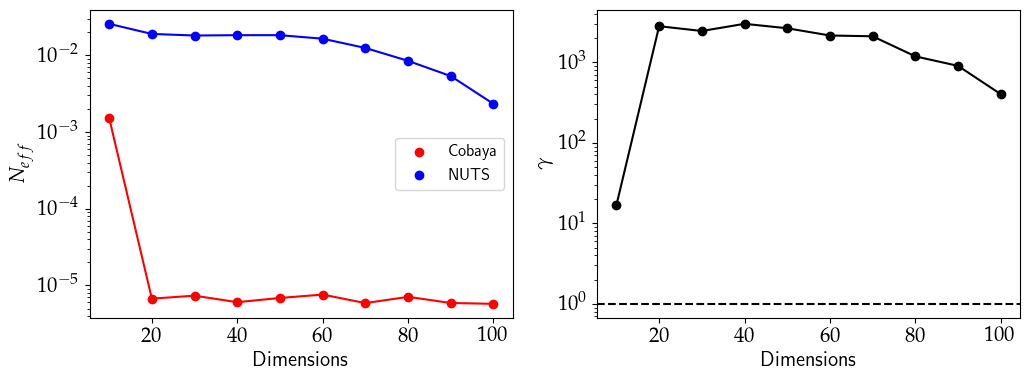

In [32]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.scatter(dimensions, df_cobaya_metrics['mean_neff'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_neff'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_neff'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_neff'], c = 'b')
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.yscale('log')
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(122)
ratio = df_nuts_metrics['mean_neff'] / df_cobaya_metrics['mean_neff']
plt.scatter(dimensions, ratio, c = 'k')
plt.plot(dimensions, ratio, c = 'k')
plt.axhline(1.0, linestyle = '--', c = 'k')
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.yscale('log')
# plt.savefig('/home/arrykrishna/Desktop/ros_neff.pdf', bbox_inches = 'tight')

plt.show()

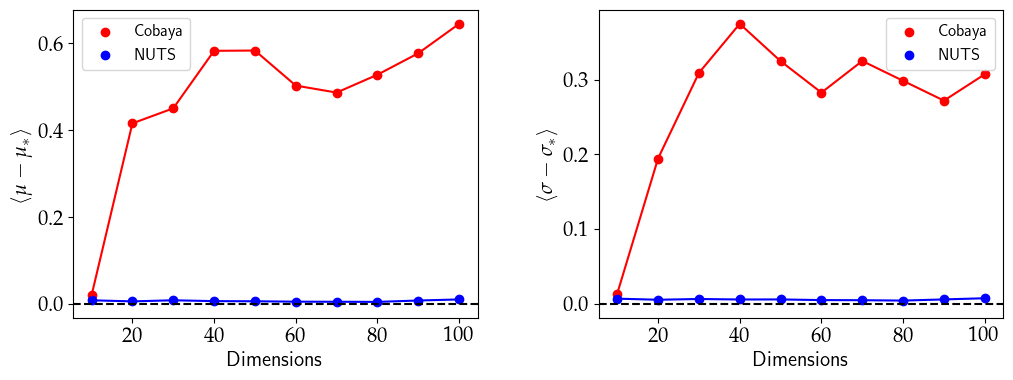

In [34]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.axhline(0.0, linestyle ='--', c = 'k')
# plt.scatter(dimensions, df_emcee_metrics['mean_mean'], c = 'r', label = 'EMCEE')
# plt.plot(dimensions, df_emcee_metrics['mean_mean'], c = 'r')
plt.scatter(dimensions, df_cobaya_metrics['mean_mean'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_mean'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_mean'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_mean'], c = 'b')
plt.ylabel(r'$\langle \mu - \mu_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ylim(-0.1, 0.2)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(122)
plt.axhline(0.0, linestyle ='--', c = 'k')
# plt.scatter(dimensions, df_emcee_metrics['mean_std'], c = 'r', label = 'EMCEE')
# plt.plot(dimensions, df_emcee_metrics['mean_std'], c = 'r')
plt.scatter(dimensions, df_cobaya_metrics['mean_std'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_std'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_std'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_std'], c = 'b')
plt.ylabel(r'$\langle \sigma - \sigma_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ylim(-0.1, 0.2)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
# plt.savefig('/home/arrykrishna/Desktop/ros_dist.pdf', bbox_inches = 'tight')
plt.show()